In [113]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F 
import numpy as np
import pickle

import matplotlib.pyplot as plt

In [114]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())


__Python VERSION: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 18:21:58) 
[GCC 7.2.0]
__pyTorch VERSION: 0.4.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2015 NVIDIA Corporation
Built on Tue_Aug_11_14:27:32_CDT_2015
Cuda compilation tools, release 7.5, V7.5.17
__CUDNN VERSION: 7102
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [116]:
train_xyz = []

with open('training/data.pickle', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    obj = np.asarray(data[i])
    #print("i=",i)
    #print("new obj")
    #print(obj.shape)
    #print(obj)
    nv = obj.shape[1]
    train_xyz.append((obj.T.reshape(1,3,nv)))
    #print(train_xyz)
train_xyz = torch.squeeze(torch.Tensor(train_xyz))
train_xyz.shape        

torch.Size([1000, 3, 10])

In [117]:
train_xy = []

with open('training/data.pickle', 'rb') as f:
    data = pickle.load(f)
    
for i in range(len(data)):
    obj = np.asarray(data[i])
    nv = obj.shape[1]
    obj.T.reshape(1,3,nv)[0][2]=np.random.rand(nv)
    train_xy.append(obj.T.reshape(1,3,nv))
    #print(train_xyz)
train_xy = torch.squeeze(torch.Tensor(train_xy))
train_xy.shape        

torch.Size([1000, 3, 10])

In [223]:
# new version
import torch.nn.functional as F 

from functools import reduce
def num_edges(n):
    return int(n*(n-1)/2)


class DepthEstNet(nn.Module):    
    def __init__(self, vertices, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(DepthEstNet, self).__init__()
        input_dim = vertices * 3
        edges = int(num_edges(vertices))
        edge_dim = edges * 3
        self.conv_edge_vec = nn.ModuleList()
        self.conv_edge_num = vertices-1
        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=i)
            m.weight = torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],
    
            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
            m.bias = torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
            m.requires_grad = False
            self.conv_edge_vec.append(m)
        
        self.reverse_learn_params = nn.ModuleList()
        fc1 = nn.Linear(edges, edges*10)
        self.reverse_learn_params.append(fc1)
        fc2 = nn.Linear(edges*10, edges*20)
        self.reverse_learn_params.append(fc2)
        fc3 = nn.Linear(edges*20, edges*10)
        self.reverse_learn_params.append(fc3)        
        fc4 = nn.Linear(edges*10, vertices)
        self.reverse_learn_params.append(fc4)
        
        self.layernorm = nn.LayerNorm(edges)
        self.nonlinearity = nonlinearity
        self.cos = nn.CosineSimilarity(dim=0, eps=1e-6)

        '''
    def forward_old(self, x, extract_z=False):
        #print("initial x", x)
        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i](x)
            y = self.nonlinearity(y)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
        #print("output: ",output)
        n,d,e = output.size()
        
        if (extract_z):
            edge_vec = output[0,2,:]
            temp = F.sigmoid(self.reverse_learn_params[0](edge_vec))
            temp = F.sigmoid(self.reverse_learn_params[1](temp))
            temp = F.sigmoid(self.reverse_learn_params[2](temp))
            vertexs_recovered = F.sigmoid(self.reverse_learn_params[3](temp))
            return vertexs_recovered
            
        for i in range(n):
            edge_vec = output[i,0,:]
            print("edge_vec: ", edge_vec)
            temp = F.sigmoid(self.reverse_learn_params[0](edge_vec))
            temp = F.sigmoid(self.reverse_learn_params[1](temp))
            temp = F.sigmoid(self.reverse_learn_params[2](temp))
            vertexs_recovered = F.sigmoid(self.reverse_learn_params[3](temp))
            print("vertex recovered: ", vertexs_recovered)
            optimizer = torch.optim.SGD(self.reverse_learn_params.parameters(), lr = 5e-1 , momentum=0.8)
            criterion = nn.MSELoss()
            optimizer.zero_grad()
            print(" orginal x: ", x[i,0,:])
            loss = criterion(vertexs_recovered, x[i,0,:])
            print("loss", loss)
            loss.backward(retain_graph=True)
            optimizer.step()
 '''

    def forward(self, x, extract_x=False, extract_y=False, extract_z=False):
        #print("initial x", x)
        n,d,v = x.size()
        #print(n,d,v)
        new_x = torch.tensor(x.data)
        
        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i](new_x)
            y = self.nonlinearity(y)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
            
        for i in range(n):
            x_vec = output[i,0,:]
            #print("x_vec: ", x_vec)
            temp = F.sigmoid(self.reverse_learn_params[0](x_vec))
            temp = F.sigmoid(self.reverse_learn_params[1](temp))
            temp = F.sigmoid(self.reverse_learn_params[2](temp))
            vertexs_recovered = F.sigmoid(self.reverse_learn_params[3](temp))
            #print("x vertex recovered: ", vertexs_recovered)
            optimizer = torch.optim.SGD(self.reverse_learn_params.parameters(), lr = 5e-1 , momentum=0.8)
            criterion = nn.L1Loss()
            optimizer.zero_grad()
            #print(" orginal x: ", x[i,:,:])
            ##x[i,2,:]=vertexs_recovered
            #print(" new x:", new_x[i])
            loss = criterion(vertexs_recovered, x[i,0,:])
            print("loss", loss)
            loss.backward(retain_graph=True)
            optimizer.step()
            #new_x[i] = torch.stack([vertexs_recovered,x[i,0,:],x[i,1,:]])
            

        if (extract_x):
            z_vec = output[0,0,:]
            temp = F.sigmoid(self.reverse_learn_params[0](z_vec))
            temp = F.sigmoid(self.reverse_learn_params[1](temp))
            temp = F.sigmoid(self.reverse_learn_params[2](temp))
            vertexs_recovered = F.sigmoid(self.reverse_learn_params[3](temp))
            return vertexs_recovered        
        
        if (extract_y):
            z_vec = output[0,1,:]
            temp = F.sigmoid(self.reverse_learn_params[0](z_vec))
            temp = F.sigmoid(self.reverse_learn_params[1](temp))
            temp = F.sigmoid(self.reverse_learn_params[2](temp))
            vertexs_recovered = F.sigmoid(self.reverse_learn_params[3](temp))
            return vertexs_recovered          
            
        if (extract_z):
            z_vec = output[0,2,:]
            temp = F.sigmoid(self.reverse_learn_params[0](z_vec))
            temp = F.sigmoid(self.reverse_learn_params[1](temp))
            temp = F.sigmoid(self.reverse_learn_params[2](temp))
            vertexs_recovered = F.sigmoid(self.reverse_learn_params[3](temp))
            return vertexs_recovered  
                
        #print("output: ",output)
        n,d,e = output.size()            
        output = F.normalize(output, p=2, dim=1)
        #print("normalized output",output)
        #pool all dimensions for Gram Matrix
        n,d,e = output.size()
        #y = output.reshape(n, d, e).sum(1)
        #print(y.shape) # Batch X Num_Edges
        #print("y",y)
        #print("y norm",(y.norm(dim=1)[:,None]))
        #output = output/(y.norm(dim=1)[:,None])
        #print("n,d,e",n,d,e)
        #print(output.transpose(1,2)[0])
        #output = torch.mm(output.transpose(1,0),output)
        output = [torch.mm(mat.transpose(1,0),mat) for mat in output[:]]
        #print(type(output))
        return torch.stack(output)

In [224]:
model = DepthEstNet(10, nonlinearity=fn.relu, additional_hidden_wide=1)
criterion = nn.L1Loss()
print(model)

DepthEstNet(
  (conv_edge_vec): ModuleList(
    (0): Conv1d(3, 3, kernel_size=(2,), stride=(1,))
    (1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(3,))
    (3): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(4,))
    (4): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(5,))
    (5): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(6,))
    (6): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(7,))
    (7): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(8,))
    (8): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(9,))
  )
  (reverse_learn_params): ModuleList(
    (0): Linear(in_features=45, out_features=450, bias=True)
    (1): Linear(in_features=450, out_features=900, bias=True)
    (2): Linear(in_features=900, out_features=450, bias=True)
    (3): Linear(in_features=450, out_features=10, bias=True)
  )
  (layernorm): LayerNorm(torch.Size([45]), eps=1e-05, elementwise_a

In [225]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(train_xy, train_xyz)
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

In [226]:
print(list(model.parameters())[:])

[Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([ 0.,  0.,  0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([ 0.,  0.,  0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([ 0.,  0.,  0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [

In [199]:
model.forward(torch.Tensor([[[ 0.2769, -0.9160, -0.9214,  0.2624,  0.9698,  0.4479, -0.7450,
          -0.7504,  0.4334,  1.1409],
         [ 0.9578,  0.3730, -0.3491, -0.9648,  0.1710,  0.9879,  0.4032,
          -0.3189, -0.9347,  0.2012],
         [ 0.0516,  0.2616,  0.9816,  0.6172,  0.2001,  0.9574,  0.6874,
           0.8240,  0.9663,  0.4618]]]).to(device), extract_x=True)


tensor([ 2.8080e-01,  2.9619e-06,  3.2515e-06,  2.5563e-01,  9.7001e-01,
         4.5879e-01,  3.9820e-06,  4.2415e-06,  4.3478e-01,  9.9998e-01], device='cuda:0')

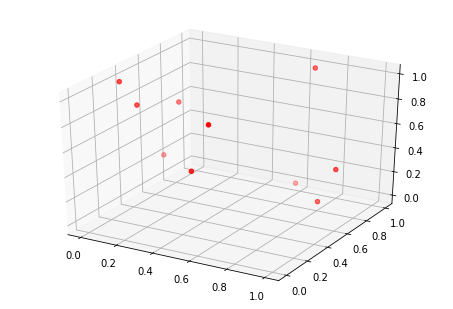

In [184]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [ 0.2769, -0.9160, -0.9214,  0.2624,  0.9698,  0.4479, -0.7450,
          -0.7504,  0.4334,  1.1409]
y = [ 0.9578,  0.3730, -0.3491, -0.9648,  0.1710,  0.9879,  0.4032,
          -0.3189, -0.9347,  0.2012]
z =  [ 0.0516,  0.2616,  0.9816,  0.6172,  0.2001,  0.9574,  0.6874,
           0.8240,  0.9663,  0.4618]
x=[(i-min(x))/(max(x)-min(x)) for i in x]
y=[(i-min(y))/(max(y)-min(y)) for i in y]
z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
plt.show()

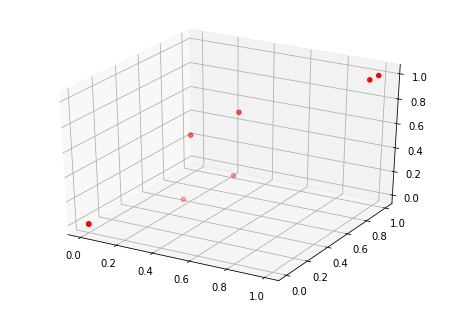

In [200]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [ 2.8080e-01,  2.9619e-06,  3.2515e-06,  2.5563e-01,  9.7001e-01,
         4.5879e-01,  3.9820e-06,  4.2415e-06,  4.3478e-01,  9.9998e-01]
y = [ 4.0580e-01,  4.9951e-06,  5.7506e-06,  5.2565e-01,  9.6880e-01,
         5.8071e-01,  6.7826e-06,  7.3122e-06,  6.7354e-01,  9.9997e-01]
z = [ 7.6734e-02,  1.2083e-06,  1.4175e-06,  5.4260e-01,  9.7211e-01,
         2.3730e-01,  1.7056e-06,  1.9382e-06,  7.0712e-01,  9.9999e-01]
x=[(i-min(x))/(max(x)-min(x)) for i in x]
y=[(i-min(y))/(max(y)-min(y)) for i in y]
z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
plt.show()

In [227]:
cuda = torch.device('cuda') 

In [228]:
cuda

device(type='cuda')

In [229]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


In [230]:
model.to(device)

DepthEstNet(
  (conv_edge_vec): ModuleList(
    (0): Conv1d(3, 3, kernel_size=(2,), stride=(1,))
    (1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(3,))
    (3): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(4,))
    (4): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(5,))
    (5): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(6,))
    (6): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(7,))
    (7): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(8,))
    (8): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(9,))
  )
  (reverse_learn_params): ModuleList(
    (0): Linear(in_features=45, out_features=450, bias=True)
    (1): Linear(in_features=450, out_features=900, bias=True)
    (2): Linear(in_features=900, out_features=450, bias=True)
    (3): Linear(in_features=450, out_features=10, bias=True)
  )
  (layernorm): LayerNorm(torch.Size([45]), eps=1e-05, elementwise_a

loss tensor(0.3014, device='cuda:0')
loss tensor(0.2895, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
loss tensor(0.2737, device='cuda:0')
loss tensor(0.3425, device='cuda:0')
network loss ->  tensor(0.1325, device='cuda:0')
loss tensor(0.3264, device='cuda:0')
loss tensor(0.3329, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
loss tensor(0.3211, device='cuda:0')
loss tensor(0.4028, device='cuda:0')
network loss ->  tensor(0.1330, device='cuda:0')
loss tensor(0.2108, device='cuda:0')
loss tensor(0.2260, device='cuda:0')
loss tensor(0.2449, device='cuda:0')
loss tensor(0.3878, device='cuda:0')
loss tensor(0.3318, device='cuda:0')
network loss ->  tensor(0.1483, device='cuda:0')
loss tensor(0.2632, device='cuda:0')
loss tensor(0.2427, device='cuda:0')
loss tensor(0.2886, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
loss tensor(0.2834, device='cuda:0')
network loss ->  tensor(0.1333, device='cuda:0')
loss tensor(0.2204, device='cuda:0')
loss tensor(0.2805, device=

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


loss tensor(0.2225, device='cuda:0')
network loss ->  tensor(0.1366, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.2828, device='cuda:0')
loss tensor(0.2834, device='cuda:0')
loss tensor(0.3863, device='cuda:0')
loss tensor(0.2653, device='cuda:0')
network loss ->  tensor(0.1443, device='cuda:0')
loss tensor(0.3431, device='cuda:0')
loss tensor(0.2816, device='cuda:0')
loss tensor(0.3548, device='cuda:0')
loss tensor(0.3268, device='cuda:0')
loss tensor(0.3286, device='cuda:0')
network loss ->  tensor(0.1348, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
loss tensor(0.2288, device='cuda:0')
loss tensor(0.2596, device='cuda:0')
loss tensor(0.3074, device='cuda:0')
loss tensor(0.3188, device='cuda:0')
network loss ->  tensor(0.1382, device='cuda:0')
loss tensor(0.3797, device='cuda:0')
loss tensor(0.3032, device='cuda:0')
loss tensor(0.3188, device='cuda:0')
loss tensor(0.3513, device='cuda:0')
loss tensor(0.2795, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3124, device='cuda:0')
loss tensor(0.3860, device='cuda:0')
loss tensor(0.2513, device='cuda:0')
network loss ->  tensor(0.1548, device='cuda:0')
loss tensor(0.2741, device='cuda:0')
loss tensor(0.2728, device='cuda:0')
loss tensor(0.2422, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
loss tensor(0.2480, device='cuda:0')
network loss ->  tensor(0.1452, device='cuda:0')
loss tensor(0.2074, device='cuda:0')
loss tensor(0.3121, device='cuda:0')
loss tensor(0.3248, device='cuda:0')
loss tensor(0.3685, device='cuda:0')
loss tensor(0.2801, device='cuda:0')
network loss ->  tensor(0.1315, device='cuda:0')
loss tensor(0.2568, device='cuda:0')
loss tensor(0.2579, device='cuda:0')
loss tensor(0.3039, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
loss tensor(0.3012, device='cuda:0')
network loss ->  tensor(0.1474, device='cuda:0')
loss tensor(0.3168, device='cuda:0')
loss tensor(0.3325, device='cuda:0')
loss tensor(0.2446, device='cuda:0')
loss tensor(0.2467, device=

loss tensor(0.3047, device='cuda:0')
loss tensor(0.2658, device='cuda:0')
loss tensor(0.3500, device='cuda:0')
loss tensor(0.3139, device='cuda:0')
network loss ->  tensor(0.1470, device='cuda:0')
loss tensor(0.2775, device='cuda:0')
loss tensor(0.3475, device='cuda:0')
loss tensor(0.3199, device='cuda:0')
loss tensor(0.3037, device='cuda:0')
loss tensor(0.3552, device='cuda:0')
network loss ->  tensor(0.1428, device='cuda:0')
loss tensor(0.3263, device='cuda:0')
loss tensor(0.2086, device='cuda:0')
loss tensor(0.3153, device='cuda:0')
loss tensor(0.2709, device='cuda:0')
loss tensor(0.2381, device='cuda:0')
network loss ->  tensor(0.1470, device='cuda:0')
loss tensor(0.3098, device='cuda:0')
loss tensor(0.2757, device='cuda:0')
loss tensor(0.3273, device='cuda:0')
loss tensor(0.3877, device='cuda:0')
loss tensor(0.3578, device='cuda:0')
network loss ->  tensor(0.1471, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
loss tensor(0.3524, device='cuda:0')
loss tensor(0.3280, device=

loss tensor(0.2984, device='cuda:0')
network loss ->  tensor(0.1337, device='cuda:0')
loss tensor(0.2922, device='cuda:0')
loss tensor(0.2832, device='cuda:0')
loss tensor(0.3358, device='cuda:0')
loss tensor(0.3252, device='cuda:0')
loss tensor(0.2850, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.2693, device='cuda:0')
loss tensor(0.3134, device='cuda:0')
loss tensor(0.3688, device='cuda:0')
loss tensor(0.2564, device='cuda:0')
loss tensor(0.3251, device='cuda:0')
network loss ->  tensor(0.1429, device='cuda:0')
loss tensor(0.3128, device='cuda:0')
loss tensor(0.2584, device='cuda:0')
loss tensor(0.3262, device='cuda:0')
loss tensor(0.3387, device='cuda:0')
loss tensor(0.1936, device='cuda:0')
network loss ->  tensor(0.1343, device='cuda:0')
loss tensor(0.2938, device='cuda:0')
loss tensor(0.3150, device='cuda:0')
loss tensor(0.2679, device='cuda:0')
loss tensor(0.3533, device='cuda:0')
loss tensor(0.3803, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2613, device='cuda:0')
loss tensor(0.3220, device='cuda:0')
loss tensor(0.3244, device='cuda:0')
loss tensor(0.3346, device='cuda:0')
loss tensor(0.3669, device='cuda:0')
network loss ->  tensor(0.1313, device='cuda:0')
loss tensor(0.3103, device='cuda:0')
loss tensor(0.2716, device='cuda:0')
loss tensor(0.2063, device='cuda:0')
loss tensor(0.3378, device='cuda:0')
loss tensor(0.2763, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.3153, device='cuda:0')
loss tensor(0.2466, device='cuda:0')
loss tensor(0.2852, device='cuda:0')
loss tensor(0.3101, device='cuda:0')
loss tensor(0.2770, device='cuda:0')
network loss ->  tensor(0.1220, device='cuda:0')
loss tensor(0.2777, device='cuda:0')
loss tensor(0.2865, device='cuda:0')
loss tensor(0.2518, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.2722, device='cuda:0')
network loss ->  tensor(0.1377, device='cuda:0')
loss tensor(0.3840, device='cuda:0')
loss tensor(0.2491, device=

loss tensor(0.2150, device='cuda:0')
loss tensor(0.2942, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.3031, device='cuda:0')
loss tensor(0.3624, device='cuda:0')
loss tensor(0.3284, device='cuda:0')
loss tensor(0.3334, device='cuda:0')
loss tensor(0.3051, device='cuda:0')
network loss ->  tensor(0.1382, device='cuda:0')
loss tensor(0.3136, device='cuda:0')
loss tensor(0.3630, device='cuda:0')
loss tensor(0.2985, device='cuda:0')
loss tensor(0.2974, device='cuda:0')
loss tensor(0.2995, device='cuda:0')
network loss ->  tensor(0.1272, device='cuda:0')
loss tensor(0.2656, device='cuda:0')
loss tensor(0.3393, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.2771, device='cuda:0')
loss tensor(0.2786, device='cuda:0')
network loss ->  tensor(0.1529, device='cuda:0')
loss tensor(0.2577, device='cuda:0')
loss tensor(0.3560, device='cuda:0')
loss tensor(0.3490, device='cuda:0')
loss tensor(0.2348, device='cuda:0')
loss tensor(0.3397, device=

network loss ->  tensor(0.1426, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
loss tensor(0.2407, device='cuda:0')
loss tensor(0.4030, device='cuda:0')
loss tensor(0.2677, device='cuda:0')
loss tensor(0.2450, device='cuda:0')
network loss ->  tensor(0.1550, device='cuda:0')
loss tensor(0.3561, device='cuda:0')
loss tensor(0.3138, device='cuda:0')
loss tensor(0.2286, device='cuda:0')
loss tensor(0.3262, device='cuda:0')
loss tensor(0.3703, device='cuda:0')
network loss ->  tensor(0.1452, device='cuda:0')
loss tensor(0.3977, device='cuda:0')
loss tensor(0.3096, device='cuda:0')
loss tensor(0.3463, device='cuda:0')
loss tensor(0.2640, device='cuda:0')
loss tensor(0.3480, device='cuda:0')
network loss ->  tensor(0.1412, device='cuda:0')
loss tensor(0.2738, device='cuda:0')
loss tensor(0.2473, device='cuda:0')
loss tensor(0.2459, device='cuda:0')
loss tensor(0.3068, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
network loss ->  tensor(0.1537, device='cuda:0')
loss tensor(0.3

loss tensor(0.2555, device='cuda:0')
loss tensor(0.3393, device='cuda:0')
network loss ->  tensor(0.1338, device='cuda:0')
loss tensor(0.3204, device='cuda:0')
loss tensor(0.3491, device='cuda:0')
loss tensor(0.2956, device='cuda:0')
loss tensor(0.3492, device='cuda:0')
loss tensor(0.2476, device='cuda:0')
network loss ->  tensor(0.1466, device='cuda:0')
loss tensor(0.2883, device='cuda:0')
loss tensor(0.2495, device='cuda:0')
loss tensor(0.3652, device='cuda:0')
loss tensor(0.3575, device='cuda:0')
loss tensor(0.2561, device='cuda:0')
network loss ->  tensor(0.1484, device='cuda:0')
loss tensor(0.2943, device='cuda:0')
loss tensor(0.3145, device='cuda:0')
loss tensor(0.2697, device='cuda:0')
loss tensor(0.4077, device='cuda:0')
loss tensor(0.3666, device='cuda:0')
network loss ->  tensor(0.1344, device='cuda:0')
loss tensor(0.2692, device='cuda:0')
loss tensor(0.2515, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
loss tensor(0.3607, device='cuda:0')
loss tensor(0.3407, device=

loss tensor(0.2785, device='cuda:0')
loss tensor(0.2268, device='cuda:0')
loss tensor(0.3134, device='cuda:0')
loss tensor(0.2756, device='cuda:0')
loss tensor(0.2696, device='cuda:0')
network loss ->  tensor(0.1475, device='cuda:0')
loss tensor(0.3318, device='cuda:0')
loss tensor(0.2472, device='cuda:0')
loss tensor(0.2214, device='cuda:0')
loss tensor(0.3184, device='cuda:0')
loss tensor(0.3289, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
loss tensor(0.2709, device='cuda:0')
loss tensor(0.3390, device='cuda:0')
loss tensor(0.2110, device='cuda:0')
loss tensor(0.2918, device='cuda:0')
network loss ->  tensor(0.1423, device='cuda:0')
loss tensor(0.3188, device='cuda:0')
loss tensor(0.2651, device='cuda:0')
loss tensor(0.3420, device='cuda:0')
loss tensor(0.2899, device='cuda:0')
loss tensor(0.2955, device='cuda:0')
network loss ->  tensor(0.1552, device='cuda:0')
loss tensor(0.3462, device='cuda:0')
loss tensor(0.2724, device=

loss tensor(0.3745, device='cuda:0')
loss tensor(0.3088, device='cuda:0')
network loss ->  tensor(0.1377, device='cuda:0')
loss tensor(0.3403, device='cuda:0')
loss tensor(0.3285, device='cuda:0')
loss tensor(0.3376, device='cuda:0')
loss tensor(0.3079, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
network loss ->  tensor(0.1542, device='cuda:0')
loss tensor(0.2780, device='cuda:0')
loss tensor(0.2026, device='cuda:0')
loss tensor(0.3458, device='cuda:0')
loss tensor(0.2457, device='cuda:0')
loss tensor(0.3208, device='cuda:0')
network loss ->  tensor(0.1358, device='cuda:0')
loss tensor(0.2933, device='cuda:0')
loss tensor(0.3155, device='cuda:0')
loss tensor(0.4090, device='cuda:0')
loss tensor(0.3384, device='cuda:0')
loss tensor(0.3138, device='cuda:0')
network loss ->  tensor(0.1338, device='cuda:0')
loss tensor(0.3433, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.2771, device='cuda:0')
loss tensor(0.2909, device='cuda:0')
loss tensor(0.3593, device=

loss tensor(0.3379, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
loss tensor(0.2848, device='cuda:0')
loss tensor(0.3258, device='cuda:0')
loss tensor(0.3737, device='cuda:0')
network loss ->  tensor(0.1439, device='cuda:0')
loss tensor(0.3387, device='cuda:0')
loss tensor(0.3315, device='cuda:0')
loss tensor(0.3444, device='cuda:0')
loss tensor(0.3026, device='cuda:0')
loss tensor(0.2851, device='cuda:0')
network loss ->  tensor(0.1277, device='cuda:0')
loss tensor(0.2426, device='cuda:0')
loss tensor(0.3892, device='cuda:0')
loss tensor(0.2654, device='cuda:0')
loss tensor(0.3020, device='cuda:0')
loss tensor(0.2577, device='cuda:0')
network loss ->  tensor(0.1518, device='cuda:0')
loss tensor(0.3610, device='cuda:0')
loss tensor(0.2299, device='cuda:0')
loss tensor(0.3247, device='cuda:0')
loss tensor(0.3201, device='cuda:0')
loss tensor(0.3668, device='cuda:0')
network loss ->  tensor(0.1402, device='cuda:0')
loss tensor(0.3086, device='cuda:0')
loss tensor(0.2885, device=

loss tensor(0.3192, device='cuda:0')
loss tensor(0.4328, device='cuda:0')
loss tensor(0.2932, device='cuda:0')
network loss ->  tensor(0.1506, device='cuda:0')
loss tensor(0.3191, device='cuda:0')
loss tensor(0.3026, device='cuda:0')
loss tensor(0.3883, device='cuda:0')
loss tensor(0.3356, device='cuda:0')
loss tensor(0.2302, device='cuda:0')
network loss ->  tensor(0.1325, device='cuda:0')
loss tensor(0.2743, device='cuda:0')
loss tensor(0.3362, device='cuda:0')
loss tensor(0.2608, device='cuda:0')
loss tensor(0.3098, device='cuda:0')
loss tensor(0.2860, device='cuda:0')
network loss ->  tensor(0.1462, device='cuda:0')
loss tensor(0.3109, device='cuda:0')
loss tensor(0.3717, device='cuda:0')
loss tensor(0.2854, device='cuda:0')
loss tensor(0.1928, device='cuda:0')
loss tensor(0.2935, device='cuda:0')
network loss ->  tensor(0.1558, device='cuda:0')
loss tensor(0.2977, device='cuda:0')
loss tensor(0.3264, device='cuda:0')
loss tensor(0.3367, device='cuda:0')
loss tensor(0.3529, device=

loss tensor(0.2890, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.3338, device='cuda:0')
loss tensor(0.2665, device='cuda:0')
loss tensor(0.3623, device='cuda:0')
loss tensor(0.2782, device='cuda:0')
loss tensor(0.2740, device='cuda:0')
network loss ->  tensor(0.1362, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
loss tensor(0.2597, device='cuda:0')
loss tensor(0.2656, device='cuda:0')
loss tensor(0.3224, device='cuda:0')
loss tensor(0.2879, device='cuda:0')
network loss ->  tensor(0.1464, device='cuda:0')
loss tensor(0.3081, device='cuda:0')
loss tensor(0.3014, device='cuda:0')
loss tensor(0.2948, device='cuda:0')
loss tensor(0.3445, device='cuda:0')
loss tensor(0.2359, device='cuda:0')
network loss ->  tensor(0.1448, device='cuda:0')
loss tensor(0.2613, device='cuda:0')
loss tensor(0.2965, device='cuda:0')
loss tensor(0.3603, device='cuda:0')
loss tensor(0.3706, device='cuda:0')
loss tensor(0.3456, device=

loss tensor(0.3001, device='cuda:0')
network loss ->  tensor(0.1428, device='cuda:0')
loss tensor(0.2980, device='cuda:0')
loss tensor(0.3437, device='cuda:0')
loss tensor(0.3434, device='cuda:0')
loss tensor(0.2367, device='cuda:0')
loss tensor(0.2869, device='cuda:0')
network loss ->  tensor(0.1424, device='cuda:0')
loss tensor(0.2876, device='cuda:0')
loss tensor(0.3223, device='cuda:0')
loss tensor(0.3588, device='cuda:0')
loss tensor(0.3451, device='cuda:0')
loss tensor(0.4000, device='cuda:0')
network loss ->  tensor(0.1368, device='cuda:0')
loss tensor(0.2312, device='cuda:0')
loss tensor(0.3271, device='cuda:0')
loss tensor(0.3151, device='cuda:0')
loss tensor(0.3039, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
network loss ->  tensor(0.1298, device='cuda:0')
loss tensor(0.2789, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
loss tensor(0.3360, device='cuda:0')
loss tensor(0.2962, device='cuda:0')
loss tensor(0.2751, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3340, device='cuda:0')
loss tensor(0.3399, device='cuda:0')
network loss ->  tensor(0.1311, device='cuda:0')
loss tensor(0.2976, device='cuda:0')
loss tensor(0.2659, device='cuda:0')
loss tensor(0.2820, device='cuda:0')
loss tensor(0.3530, device='cuda:0')
loss tensor(0.3168, device='cuda:0')
network loss ->  tensor(0.1354, device='cuda:0')
loss tensor(0.2688, device='cuda:0')
loss tensor(0.2227, device='cuda:0')
loss tensor(0.2466, device='cuda:0')
loss tensor(0.2854, device='cuda:0')
loss tensor(0.2678, device='cuda:0')
network loss ->  tensor(0.1519, device='cuda:0')
loss tensor(0.3044, device='cuda:0')
loss tensor(0.2900, device='cuda:0')
loss tensor(0.2989, device='cuda:0')
loss tensor(0.1915, device='cuda:0')
loss tensor(0.3636, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.2762, device='cuda:0')
loss tensor(0.3172, device='cuda:0')
loss tensor(0.2313, device='cuda:0')
loss tensor(0.3219, device='cuda:0')
loss tensor(0.3288, device=

loss tensor(0.2799, device='cuda:0')
loss tensor(0.2960, device='cuda:0')
loss tensor(0.1790, device='cuda:0')
network loss ->  tensor(0.1376, device='cuda:0')
loss tensor(0.3117, device='cuda:0')
loss tensor(0.1782, device='cuda:0')
loss tensor(0.2768, device='cuda:0')
loss tensor(0.3304, device='cuda:0')
loss tensor(0.2802, device='cuda:0')
network loss ->  tensor(0.1408, device='cuda:0')
loss tensor(0.3082, device='cuda:0')
loss tensor(0.4204, device='cuda:0')
loss tensor(0.2297, device='cuda:0')
loss tensor(0.2616, device='cuda:0')
loss tensor(0.2409, device='cuda:0')
network loss ->  tensor(0.1455, device='cuda:0')
loss tensor(0.3143, device='cuda:0')
loss tensor(0.3948, device='cuda:0')
loss tensor(0.3376, device='cuda:0')
loss tensor(0.2397, device='cuda:0')
loss tensor(0.3599, device='cuda:0')
network loss ->  tensor(0.1457, device='cuda:0')
loss tensor(0.3875, device='cuda:0')
loss tensor(0.2602, device='cuda:0')
loss tensor(0.2595, device='cuda:0')
loss tensor(0.3338, device=

loss tensor(0.3303, device='cuda:0')
loss tensor(0.3866, device='cuda:0')
loss tensor(0.3401, device='cuda:0')
loss tensor(0.3171, device='cuda:0')
loss tensor(0.2881, device='cuda:0')
network loss ->  tensor(0.1426, device='cuda:0')
loss tensor(0.3160, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
loss tensor(0.3226, device='cuda:0')
loss tensor(0.3670, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
network loss ->  tensor(0.1351, device='cuda:0')
loss tensor(0.3488, device='cuda:0')
loss tensor(0.2859, device='cuda:0')
loss tensor(0.2303, device='cuda:0')
loss tensor(0.3821, device='cuda:0')
loss tensor(0.3573, device='cuda:0')
network loss ->  tensor(0.1377, device='cuda:0')
loss tensor(0.3545, device='cuda:0')
loss tensor(0.3312, device='cuda:0')
loss tensor(0.3058, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
loss tensor(0.2938, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.2432, device='cuda:0')
loss tensor(0.3320, device=

loss tensor(0.2977, device='cuda:0')
loss tensor(0.3044, device='cuda:0')
loss tensor(0.3432, device='cuda:0')
loss tensor(0.3524, device='cuda:0')
loss tensor(0.2362, device='cuda:0')
network loss ->  tensor(0.1419, device='cuda:0')
loss tensor(0.2872, device='cuda:0')
loss tensor(0.3036, device='cuda:0')
loss tensor(0.2529, device='cuda:0')
loss tensor(0.2634, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
network loss ->  tensor(0.1503, device='cuda:0')
loss tensor(0.2398, device='cuda:0')
loss tensor(0.3081, device='cuda:0')
loss tensor(0.3224, device='cuda:0')
loss tensor(0.2920, device='cuda:0')
loss tensor(0.2400, device='cuda:0')
network loss ->  tensor(0.1372, device='cuda:0')
loss tensor(0.2453, device='cuda:0')
loss tensor(0.4009, device='cuda:0')
loss tensor(0.3427, device='cuda:0')
loss tensor(0.2119, device='cuda:0')
loss tensor(0.3389, device='cuda:0')
network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.3348, device='cuda:0')
loss tensor(0.2275, device=

loss tensor(0.3369, device='cuda:0')
loss tensor(0.2463, device='cuda:0')
loss tensor(0.3479, device='cuda:0')
loss tensor(0.2889, device='cuda:0')
network loss ->  tensor(0.1327, device='cuda:0')
loss tensor(0.3852, device='cuda:0')
loss tensor(0.2599, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
loss tensor(0.3343, device='cuda:0')
loss tensor(0.2375, device='cuda:0')
network loss ->  tensor(0.1481, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
loss tensor(0.3819, device='cuda:0')
loss tensor(0.2929, device='cuda:0')
loss tensor(0.2886, device='cuda:0')
loss tensor(0.3176, device='cuda:0')
network loss ->  tensor(0.1591, device='cuda:0')
loss tensor(0.3265, device='cuda:0')
loss tensor(0.2668, device='cuda:0')
loss tensor(0.3193, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
loss tensor(0.2571, device='cuda:0')
network loss ->  tensor(0.1423, device='cuda:0')
loss tensor(0.3378, device='cuda:0')
loss tensor(0.3585, device='cuda:0')
loss tensor(0.3084, device=

loss tensor(0.2514, device='cuda:0')
loss tensor(0.1982, device='cuda:0')
loss tensor(0.3372, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.3405, device='cuda:0')
loss tensor(0.2219, device='cuda:0')
loss tensor(0.3513, device='cuda:0')
loss tensor(0.2951, device='cuda:0')
loss tensor(0.3141, device='cuda:0')
network loss ->  tensor(0.1335, device='cuda:0')
loss tensor(0.2318, device='cuda:0')
loss tensor(0.3727, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
loss tensor(0.3336, device='cuda:0')
loss tensor(0.3472, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.2789, device='cuda:0')
loss tensor(0.2180, device='cuda:0')
loss tensor(0.3071, device='cuda:0')
loss tensor(0.2692, device='cuda:0')
loss tensor(0.2284, device='cuda:0')
network loss ->  tensor(0.1485, device='cuda:0')
loss tensor(0.2791, device='cuda:0')
loss tensor(0.2153, device='cuda:0')
loss tensor(0.2211, device=

loss tensor(0.3296, device='cuda:0')
loss tensor(0.3044, device='cuda:0')
network loss ->  tensor(0.1314, device='cuda:0')
loss tensor(0.2325, device='cuda:0')
loss tensor(0.2420, device='cuda:0')
loss tensor(0.2815, device='cuda:0')
loss tensor(0.3132, device='cuda:0')
loss tensor(0.2698, device='cuda:0')
network loss ->  tensor(0.1560, device='cuda:0')
loss tensor(0.2038, device='cuda:0')
loss tensor(0.3095, device='cuda:0')
loss tensor(0.3288, device='cuda:0')
loss tensor(0.3130, device='cuda:0')
loss tensor(0.2983, device='cuda:0')
network loss ->  tensor(0.1329, device='cuda:0')
loss tensor(0.3184, device='cuda:0')
loss tensor(0.3346, device='cuda:0')
loss tensor(0.3404, device='cuda:0')
loss tensor(0.3421, device='cuda:0')
loss tensor(0.2662, device='cuda:0')
network loss ->  tensor(0.1419, device='cuda:0')
loss tensor(0.3269, device='cuda:0')
loss tensor(0.3041, device='cuda:0')
loss tensor(0.2861, device='cuda:0')
loss tensor(0.3245, device='cuda:0')
loss tensor(0.2302, device=

loss tensor(0.2255, device='cuda:0')
loss tensor(0.2989, device='cuda:0')
loss tensor(0.3402, device='cuda:0')
network loss ->  tensor(0.1251, device='cuda:0')
loss tensor(0.2793, device='cuda:0')
loss tensor(0.3001, device='cuda:0')
loss tensor(0.2957, device='cuda:0')
loss tensor(0.3172, device='cuda:0')
loss tensor(0.2729, device='cuda:0')
network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
loss tensor(0.3594, device='cuda:0')
loss tensor(0.3550, device='cuda:0')
loss tensor(0.2409, device='cuda:0')
loss tensor(0.2758, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.3177, device='cuda:0')
loss tensor(0.2431, device='cuda:0')
loss tensor(0.2847, device='cuda:0')
loss tensor(0.3357, device='cuda:0')
loss tensor(0.3300, device='cuda:0')
network loss ->  tensor(0.1496, device='cuda:0')
loss tensor(0.2479, device='cuda:0')
loss tensor(0.3239, device='cuda:0')
loss tensor(0.2513, device='cuda:0')
loss tensor(0.2126, device=

loss tensor(0.2691, device='cuda:0')
loss tensor(0.3361, device='cuda:0')
loss tensor(0.3333, device='cuda:0')
loss tensor(0.3331, device='cuda:0')
network loss ->  tensor(0.1308, device='cuda:0')
loss tensor(0.2884, device='cuda:0')
loss tensor(0.2960, device='cuda:0')
loss tensor(0.3228, device='cuda:0')
loss tensor(0.3590, device='cuda:0')
loss tensor(0.2794, device='cuda:0')
network loss ->  tensor(0.1312, device='cuda:0')
loss tensor(0.2889, device='cuda:0')
loss tensor(0.3268, device='cuda:0')
loss tensor(0.3220, device='cuda:0')
loss tensor(0.3327, device='cuda:0')
loss tensor(0.3233, device='cuda:0')
network loss ->  tensor(0.1391, device='cuda:0')
loss tensor(0.3393, device='cuda:0')
loss tensor(0.3338, device='cuda:0')
loss tensor(0.4044, device='cuda:0')
loss tensor(0.2989, device='cuda:0')
loss tensor(0.2593, device='cuda:0')
network loss ->  tensor(0.1309, device='cuda:0')
loss tensor(0.3044, device='cuda:0')
loss tensor(0.3497, device='cuda:0')
loss tensor(0.3085, device=

loss tensor(0.2950, device='cuda:0')
loss tensor(0.2444, device='cuda:0')
loss tensor(0.3519, device='cuda:0')
network loss ->  tensor(0.1296, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
loss tensor(0.2653, device='cuda:0')
loss tensor(0.2798, device='cuda:0')
loss tensor(0.2656, device='cuda:0')
loss tensor(0.2780, device='cuda:0')
network loss ->  tensor(0.1318, device='cuda:0')
loss tensor(0.2331, device='cuda:0')
loss tensor(0.3292, device='cuda:0')
loss tensor(0.1816, device='cuda:0')
loss tensor(0.3355, device='cuda:0')
loss tensor(0.3164, device='cuda:0')
network loss ->  tensor(0.1353, device='cuda:0')
loss tensor(0.2798, device='cuda:0')
loss tensor(0.3508, device='cuda:0')
loss tensor(0.2420, device='cuda:0')
loss tensor(0.2837, device='cuda:0')
loss tensor(0.2850, device='cuda:0')
network loss ->  tensor(0.1510, device='cuda:0')
loss tensor(0.3071, device='cuda:0')
loss tensor(0.3195, device='cuda:0')
loss tensor(0.2839, device='cuda:0')
loss tensor(0.2534, device=

loss tensor(0.2851, device='cuda:0')
network loss ->  tensor(0.1461, device='cuda:0')
loss tensor(0.2293, device='cuda:0')
loss tensor(0.3117, device='cuda:0')
loss tensor(0.3502, device='cuda:0')
loss tensor(0.2227, device='cuda:0')
loss tensor(0.2915, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.2558, device='cuda:0')
loss tensor(0.3629, device='cuda:0')
loss tensor(0.2703, device='cuda:0')
loss tensor(0.3611, device='cuda:0')
loss tensor(0.2616, device='cuda:0')
network loss ->  tensor(0.1472, device='cuda:0')
loss tensor(0.3044, device='cuda:0')
loss tensor(0.2616, device='cuda:0')
loss tensor(0.3419, device='cuda:0')
loss tensor(0.2961, device='cuda:0')
loss tensor(0.3230, device='cuda:0')
network loss ->  tensor(0.1402, device='cuda:0')
loss tensor(0.2790, device='cuda:0')
loss tensor(0.2646, device='cuda:0')
loss tensor(0.3418, device='cuda:0')
loss tensor(0.2698, device='cuda:0')
loss tensor(0.3662, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3257, device='cuda:0')
loss tensor(0.2650, device='cuda:0')
network loss ->  tensor(0.1419, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
loss tensor(0.2920, device='cuda:0')
loss tensor(0.3087, device='cuda:0')
loss tensor(0.2971, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
loss tensor(0.2771, device='cuda:0')
loss tensor(0.2145, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
loss tensor(0.3082, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
loss tensor(0.3577, device='cuda:0')
loss tensor(0.3807, device='cuda:0')
loss tensor(0.2952, device='cuda:0')
loss tensor(0.3226, device='cuda:0')
network loss ->  tensor(0.1560, device='cuda:0')
loss tensor(0.3152, device='cuda:0')
loss tensor(0.2356, device='cuda:0')
loss tensor(0.3283, device='cuda:0')
loss tensor(0.3459, device='cuda:0')
loss tensor(0.3196, device=

network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.3007, device='cuda:0')
loss tensor(0.2551, device='cuda:0')
loss tensor(0.2834, device='cuda:0')
loss tensor(0.3346, device='cuda:0')
loss tensor(0.2017, device='cuda:0')
network loss ->  tensor(0.1242, device='cuda:0')
loss tensor(0.4037, device='cuda:0')
loss tensor(0.2761, device='cuda:0')
loss tensor(0.2399, device='cuda:0')
loss tensor(0.2314, device='cuda:0')
loss tensor(0.3076, device='cuda:0')
network loss ->  tensor(0.1330, device='cuda:0')
loss tensor(0.3398, device='cuda:0')
loss tensor(0.3109, device='cuda:0')
loss tensor(0.2988, device='cuda:0')
loss tensor(0.3935, device='cuda:0')
loss tensor(0.3676, device='cuda:0')
network loss ->  tensor(0.1305, device='cuda:0')
loss tensor(0.3104, device='cuda:0')
loss tensor(0.3657, device='cuda:0')
loss tensor(0.2690, device='cuda:0')
loss tensor(0.2444, device='cuda:0')
loss tensor(0.3425, device='cuda:0')
network loss ->  tensor(0.1671, device='cuda:0')
loss tensor(0.3

loss tensor(0.2676, device='cuda:0')
loss tensor(0.2556, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
loss tensor(0.2055, device='cuda:0')
loss tensor(0.3173, device='cuda:0')
network loss ->  tensor(0.1340, device='cuda:0')
loss tensor(0.2649, device='cuda:0')
loss tensor(0.3781, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
loss tensor(0.3026, device='cuda:0')
loss tensor(0.2424, device='cuda:0')
network loss ->  tensor(0.1368, device='cuda:0')
loss tensor(0.2944, device='cuda:0')
loss tensor(0.2648, device='cuda:0')
loss tensor(0.2116, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
loss tensor(0.3196, device='cuda:0')
network loss ->  tensor(0.1460, device='cuda:0')
loss tensor(0.2988, device='cuda:0')
loss tensor(0.2730, device='cuda:0')
loss tensor(0.3229, device='cuda:0')
loss tensor(0.2882, device='cuda:0')
loss tensor(0.2276, device='cuda:0')
network loss ->  tensor(0.1392, device='cuda:0')
loss tensor(0.3947, device='cuda:0')
loss tensor(0.3009, device=

loss tensor(0.3445, device='cuda:0')
loss tensor(0.3312, device='cuda:0')
network loss ->  tensor(0.1435, device='cuda:0')
loss tensor(0.3394, device='cuda:0')
loss tensor(0.2737, device='cuda:0')
loss tensor(0.2008, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.3536, device='cuda:0')
network loss ->  tensor(0.1502, device='cuda:0')
loss tensor(0.2905, device='cuda:0')
loss tensor(0.3408, device='cuda:0')
loss tensor(0.2402, device='cuda:0')
loss tensor(0.3175, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
network loss ->  tensor(0.1598, device='cuda:0')
loss tensor(0.3022, device='cuda:0')
loss tensor(0.3305, device='cuda:0')
loss tensor(0.2280, device='cuda:0')
loss tensor(0.3267, device='cuda:0')
loss tensor(0.3639, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.2979, device='cuda:0')
loss tensor(0.2275, device='cuda:0')
loss tensor(0.2668, device='cuda:0')
loss tensor(0.3539, device='cuda:0')
loss tensor(0.3095, device=

loss tensor(0.2718, device='cuda:0')
loss tensor(0.3145, device='cuda:0')
network loss ->  tensor(0.1372, device='cuda:0')
loss tensor(0.3607, device='cuda:0')
loss tensor(0.3339, device='cuda:0')
loss tensor(0.3627, device='cuda:0')
loss tensor(0.3021, device='cuda:0')
loss tensor(0.2854, device='cuda:0')
network loss ->  tensor(0.1417, device='cuda:0')
loss tensor(0.2745, device='cuda:0')
loss tensor(0.2180, device='cuda:0')
loss tensor(0.3572, device='cuda:0')
loss tensor(0.2550, device='cuda:0')
loss tensor(0.3205, device='cuda:0')
network loss ->  tensor(0.1378, device='cuda:0')
loss tensor(0.3183, device='cuda:0')
loss tensor(0.2813, device='cuda:0')
loss tensor(0.3134, device='cuda:0')
loss tensor(0.2232, device='cuda:0')
loss tensor(0.2824, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.3057, device='cuda:0')
loss tensor(0.2905, device='cuda:0')
loss tensor(0.2541, device='cuda:0')
loss tensor(0.2672, device='cuda:0')
loss tensor(0.2467, device=

loss tensor(0.3276, device='cuda:0')
loss tensor(0.2860, device='cuda:0')
loss tensor(0.2888, device='cuda:0')
loss tensor(0.2697, device='cuda:0')
loss tensor(0.3337, device='cuda:0')
network loss ->  tensor(0.1383, device='cuda:0')
loss tensor(0.2548, device='cuda:0')
loss tensor(0.2514, device='cuda:0')
loss tensor(0.2864, device='cuda:0')
loss tensor(0.1864, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.3680, device='cuda:0')
loss tensor(0.2179, device='cuda:0')
loss tensor(0.2724, device='cuda:0')
loss tensor(0.4013, device='cuda:0')
loss tensor(0.3448, device='cuda:0')
network loss ->  tensor(0.1392, device='cuda:0')
loss tensor(0.3123, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
loss tensor(0.3565, device='cuda:0')
loss tensor(0.2940, device='cuda:0')
loss tensor(0.3305, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.3057, device='cuda:0')
loss tensor(0.3165, device=

loss tensor(0.3302, device='cuda:0')
loss tensor(0.2406, device='cuda:0')
network loss ->  tensor(0.1474, device='cuda:0')
loss tensor(0.3006, device='cuda:0')
loss tensor(0.2759, device='cuda:0')
loss tensor(0.3383, device='cuda:0')
loss tensor(0.3122, device='cuda:0')
loss tensor(0.3585, device='cuda:0')
network loss ->  tensor(0.1430, device='cuda:0')
loss tensor(0.2672, device='cuda:0')
loss tensor(0.2730, device='cuda:0')
loss tensor(0.2710, device='cuda:0')
loss tensor(0.3325, device='cuda:0')
loss tensor(0.3753, device='cuda:0')
network loss ->  tensor(0.1507, device='cuda:0')
loss tensor(0.2535, device='cuda:0')
loss tensor(0.2421, device='cuda:0')
loss tensor(0.3281, device='cuda:0')
loss tensor(0.2787, device='cuda:0')
loss tensor(0.3385, device='cuda:0')
network loss ->  tensor(0.1314, device='cuda:0')
loss tensor(0.2989, device='cuda:0')
loss tensor(0.3705, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.2350, device='cuda:0')
loss tensor(0.2729, device=

loss tensor(0.3352, device='cuda:0')
loss tensor(0.3303, device='cuda:0')
loss tensor(0.3071, device='cuda:0')
loss tensor(0.3307, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.3340, device='cuda:0')
loss tensor(0.3219, device='cuda:0')
loss tensor(0.3970, device='cuda:0')
loss tensor(0.2488, device='cuda:0')
loss tensor(0.2603, device='cuda:0')
network loss ->  tensor(0.1295, device='cuda:0')
loss tensor(0.2510, device='cuda:0')
loss tensor(0.2276, device='cuda:0')
loss tensor(0.3202, device='cuda:0')
loss tensor(0.3565, device='cuda:0')
loss tensor(0.2915, device='cuda:0')
network loss ->  tensor(0.1479, device='cuda:0')
loss tensor(0.3323, device='cuda:0')
loss tensor(0.3204, device='cuda:0')
loss tensor(0.3954, device='cuda:0')
loss tensor(0.3205, device='cuda:0')
loss tensor(0.3192, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.2969, device='cuda:0')
loss tensor(0.2881, device='cuda:0')
loss tensor(0.3021, device=

loss tensor(0.3723, device='cuda:0')
loss tensor(0.3637, device='cuda:0')
loss tensor(0.2711, device='cuda:0')
loss tensor(0.2333, device='cuda:0')
network loss ->  tensor(0.1364, device='cuda:0')
loss tensor(0.2781, device='cuda:0')
loss tensor(0.2876, device='cuda:0')
loss tensor(0.2708, device='cuda:0')
loss tensor(0.3417, device='cuda:0')
loss tensor(0.3318, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.2542, device='cuda:0')
loss tensor(0.3387, device='cuda:0')
loss tensor(0.2359, device='cuda:0')
loss tensor(0.3357, device='cuda:0')
loss tensor(0.3685, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.2661, device='cuda:0')
loss tensor(0.3067, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
loss tensor(0.3670, device='cuda:0')
network loss ->  tensor(0.1447, device='cuda:0')
loss tensor(0.3217, device='cuda:0')
loss tensor(0.3195, device='cuda:0')
loss tensor(0.3865, device=

network loss ->  tensor(0.1453, device='cuda:0')
loss tensor(0.3025, device='cuda:0')
loss tensor(0.3080, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
loss tensor(0.3036, device='cuda:0')
loss tensor(0.2986, device='cuda:0')
network loss ->  tensor(0.1191, device='cuda:0')
loss tensor(0.2610, device='cuda:0')
loss tensor(0.2463, device='cuda:0')
loss tensor(0.2779, device='cuda:0')
loss tensor(0.3314, device='cuda:0')
loss tensor(0.2657, device='cuda:0')
network loss ->  tensor(0.1434, device='cuda:0')
loss tensor(0.3482, device='cuda:0')
loss tensor(0.3808, device='cuda:0')
loss tensor(0.3045, device='cuda:0')
loss tensor(0.3637, device='cuda:0')
loss tensor(0.3825, device='cuda:0')
network loss ->  tensor(0.1341, device='cuda:0')
loss tensor(0.2969, device='cuda:0')
loss tensor(0.3541, device='cuda:0')
loss tensor(0.2842, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
loss tensor(0.1943, device='cuda:0')
network loss ->  tensor(0.1332, device='cuda:0')
loss tensor(0.3

loss tensor(0.3294, device='cuda:0')
loss tensor(0.3915, device='cuda:0')
loss tensor(0.3422, device='cuda:0')
network loss ->  tensor(0.1392, device='cuda:0')
loss tensor(0.3175, device='cuda:0')
loss tensor(0.3284, device='cuda:0')
loss tensor(0.3073, device='cuda:0')
loss tensor(0.3403, device='cuda:0')
loss tensor(0.3231, device='cuda:0')
network loss ->  tensor(0.1430, device='cuda:0')
loss tensor(0.2486, device='cuda:0')
loss tensor(0.2489, device='cuda:0')
loss tensor(0.2367, device='cuda:0')
loss tensor(0.2112, device='cuda:0')
loss tensor(0.2345, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.2417, device='cuda:0')
loss tensor(0.3016, device='cuda:0')
loss tensor(0.3534, device='cuda:0')
loss tensor(0.2966, device='cuda:0')
loss tensor(0.3139, device='cuda:0')
network loss ->  tensor(0.1510, device='cuda:0')
loss tensor(0.2152, device='cuda:0')
loss tensor(0.3510, device='cuda:0')
loss tensor(0.2517, device='cuda:0')
loss tensor(0.2435, device=

loss tensor(0.2993, device='cuda:0')
loss tensor(0.3242, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
network loss ->  tensor(0.1409, device='cuda:0')
loss tensor(0.2624, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
loss tensor(0.3600, device='cuda:0')
loss tensor(0.3172, device='cuda:0')
loss tensor(0.3259, device='cuda:0')
network loss ->  tensor(0.1355, device='cuda:0')
loss tensor(0.2867, device='cuda:0')
loss tensor(0.3200, device='cuda:0')
loss tensor(0.3362, device='cuda:0')
loss tensor(0.3895, device='cuda:0')
loss tensor(0.3661, device='cuda:0')
network loss ->  tensor(0.1342, device='cuda:0')
loss tensor(0.2396, device='cuda:0')
loss tensor(0.2948, device='cuda:0')
loss tensor(0.2363, device='cuda:0')
loss tensor(0.2878, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
network loss ->  tensor(0.1475, device='cuda:0')
loss tensor(0.3008, device='cuda:0')
loss tensor(0.2713, device='cuda:0')
loss tensor(0.2803, device='cuda:0')
loss tensor(0.3121, device=

loss tensor(0.3190, device='cuda:0')
loss tensor(0.2848, device='cuda:0')
loss tensor(0.2993, device='cuda:0')
loss tensor(0.3412, device='cuda:0')
network loss ->  tensor(0.1464, device='cuda:0')
loss tensor(0.3216, device='cuda:0')
loss tensor(0.3336, device='cuda:0')
loss tensor(0.3256, device='cuda:0')
loss tensor(0.3421, device='cuda:0')
loss tensor(0.2626, device='cuda:0')
network loss ->  tensor(0.1333, device='cuda:0')
loss tensor(0.3186, device='cuda:0')
loss tensor(0.2665, device='cuda:0')
loss tensor(0.3198, device='cuda:0')
loss tensor(0.2099, device='cuda:0')
loss tensor(0.3602, device='cuda:0')
network loss ->  tensor(0.1473, device='cuda:0')
loss tensor(0.2241, device='cuda:0')
loss tensor(0.3574, device='cuda:0')
loss tensor(0.2386, device='cuda:0')
loss tensor(0.2444, device='cuda:0')
loss tensor(0.2211, device='cuda:0')
network loss ->  tensor(0.1635, device='cuda:0')
loss tensor(0.2924, device='cuda:0')
loss tensor(0.3268, device='cuda:0')
loss tensor(0.3366, device=

network loss ->  tensor(0.1373, device='cuda:0')
loss tensor(0.2745, device='cuda:0')
loss tensor(0.2485, device='cuda:0')
loss tensor(0.2688, device='cuda:0')
loss tensor(0.3614, device='cuda:0')
loss tensor(0.2447, device='cuda:0')
network loss ->  tensor(0.1581, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
loss tensor(0.3315, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
loss tensor(0.2651, device='cuda:0')
loss tensor(0.2780, device='cuda:0')
network loss ->  tensor(0.1372, device='cuda:0')
loss tensor(0.2764, device='cuda:0')
loss tensor(0.2489, device='cuda:0')
loss tensor(0.2688, device='cuda:0')
loss tensor(0.3113, device='cuda:0')
loss tensor(0.2754, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.3297, device='cuda:0')
loss tensor(0.2482, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
loss tensor(0.3106, device='cuda:0')
loss tensor(0.3288, device='cuda:0')
network loss ->  tensor(0.1480, device='cuda:0')
loss tensor(0.2

loss tensor(0.3205, device='cuda:0')
loss tensor(0.3115, device='cuda:0')
loss tensor(0.3274, device='cuda:0')
loss tensor(0.3134, device='cuda:0')
loss tensor(0.3121, device='cuda:0')
network loss ->  tensor(0.1466, device='cuda:0')
loss tensor(0.3285, device='cuda:0')
loss tensor(0.3558, device='cuda:0')
loss tensor(0.2675, device='cuda:0')
loss tensor(0.3620, device='cuda:0')
loss tensor(0.3958, device='cuda:0')
network loss ->  tensor(0.1430, device='cuda:0')
loss tensor(0.2139, device='cuda:0')
loss tensor(0.2766, device='cuda:0')
loss tensor(0.2928, device='cuda:0')
loss tensor(0.2346, device='cuda:0')
loss tensor(0.3253, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.3574, device='cuda:0')
loss tensor(0.2570, device='cuda:0')
loss tensor(0.3181, device='cuda:0')
loss tensor(0.2353, device='cuda:0')
loss tensor(0.2582, device='cuda:0')
network loss ->  tensor(0.1509, device='cuda:0')
loss tensor(0.2956, device='cuda:0')
loss tensor(0.2652, device=

loss tensor(0.3777, device='cuda:0')
loss tensor(0.3645, device='cuda:0')
loss tensor(0.2730, device='cuda:0')
network loss ->  tensor(0.1316, device='cuda:0')
loss tensor(0.3318, device='cuda:0')
loss tensor(0.2962, device='cuda:0')
loss tensor(0.2561, device='cuda:0')
loss tensor(0.3367, device='cuda:0')
loss tensor(0.3997, device='cuda:0')
network loss ->  tensor(0.1358, device='cuda:0')
loss tensor(0.1966, device='cuda:0')
loss tensor(0.2370, device='cuda:0')
loss tensor(0.3089, device='cuda:0')
loss tensor(0.3574, device='cuda:0')
loss tensor(0.2824, device='cuda:0')
network loss ->  tensor(0.1318, device='cuda:0')
loss tensor(0.3367, device='cuda:0')
loss tensor(0.2647, device='cuda:0')
loss tensor(0.3307, device='cuda:0')
loss tensor(0.2638, device='cuda:0')
loss tensor(0.2951, device='cuda:0')
network loss ->  tensor(0.1401, device='cuda:0')
loss tensor(0.2246, device='cuda:0')
loss tensor(0.2533, device='cuda:0')
loss tensor(0.3260, device='cuda:0')
loss tensor(0.2675, device=

loss tensor(0.2779, device='cuda:0')
loss tensor(0.2852, device='cuda:0')
loss tensor(0.2663, device='cuda:0')
network loss ->  tensor(0.1473, device='cuda:0')
loss tensor(0.2965, device='cuda:0')
loss tensor(0.3063, device='cuda:0')
loss tensor(0.3327, device='cuda:0')
loss tensor(0.2244, device='cuda:0')
loss tensor(0.3338, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.3920, device='cuda:0')
loss tensor(0.2941, device='cuda:0')
loss tensor(0.2190, device='cuda:0')
loss tensor(0.3532, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
network loss ->  tensor(0.1503, device='cuda:0')
loss tensor(0.2149, device='cuda:0')
loss tensor(0.2564, device='cuda:0')
loss tensor(0.2453, device='cuda:0')
loss tensor(0.4189, device='cuda:0')
loss tensor(0.2336, device='cuda:0')
network loss ->  tensor(0.1497, device='cuda:0')
loss tensor(0.2888, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
loss tensor(0.3205, device='cuda:0')
loss tensor(0.3238, device=

loss tensor(0.3982, device='cuda:0')
loss tensor(0.3382, device='cuda:0')
loss tensor(0.2724, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
loss tensor(0.2867, device='cuda:0')
loss tensor(0.3644, device='cuda:0')
loss tensor(0.3371, device='cuda:0')
loss tensor(0.3084, device='cuda:0')
network loss ->  tensor(0.1450, device='cuda:0')
loss tensor(0.2584, device='cuda:0')
loss tensor(0.3412, device='cuda:0')
loss tensor(0.2643, device='cuda:0')
loss tensor(0.3327, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
network loss ->  tensor(0.1319, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
loss tensor(0.3328, device='cuda:0')
loss tensor(0.2434, device='cuda:0')
loss tensor(0.2584, device='cuda:0')
loss tensor(0.3283, device='cuda:0')
network loss ->  tensor(0.1319, device='cuda:0')
loss tensor(0.3061, device='cuda:0')
loss tensor(0.2848, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
loss tensor(0.3132, device=

loss tensor(0.3941, device='cuda:0')
loss tensor(0.2936, device='cuda:0')
loss tensor(0.2116, device='cuda:0')
network loss ->  tensor(0.1323, device='cuda:0')
loss tensor(0.2949, device='cuda:0')
loss tensor(0.2699, device='cuda:0')
loss tensor(0.2728, device='cuda:0')
loss tensor(0.2825, device='cuda:0')
loss tensor(0.2489, device='cuda:0')
network loss ->  tensor(0.1304, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.2376, device='cuda:0')
loss tensor(0.3194, device='cuda:0')
loss tensor(0.3153, device='cuda:0')
loss tensor(0.3513, device='cuda:0')
network loss ->  tensor(0.1459, device='cuda:0')
loss tensor(0.2685, device='cuda:0')
loss tensor(0.2933, device='cuda:0')
loss tensor(0.2316, device='cuda:0')
loss tensor(0.2636, device='cuda:0')
loss tensor(0.3692, device='cuda:0')
network loss ->  tensor(0.1428, device='cuda:0')
loss tensor(0.2869, device='cuda:0')
loss tensor(0.2819, device='cuda:0')
loss tensor(0.2478, device='cuda:0')
loss tensor(0.2729, device=

loss tensor(0.2913, device='cuda:0')
loss tensor(0.2524, device='cuda:0')
network loss ->  tensor(0.1436, device='cuda:0')
loss tensor(0.3695, device='cuda:0')
loss tensor(0.2328, device='cuda:0')
loss tensor(0.3524, device='cuda:0')
loss tensor(0.3062, device='cuda:0')
loss tensor(0.2894, device='cuda:0')
network loss ->  tensor(0.1370, device='cuda:0')
loss tensor(0.2935, device='cuda:0')
loss tensor(0.3187, device='cuda:0')
loss tensor(0.3351, device='cuda:0')
loss tensor(0.2928, device='cuda:0')
loss tensor(0.2353, device='cuda:0')
network loss ->  tensor(0.1434, device='cuda:0')
loss tensor(0.2753, device='cuda:0')
loss tensor(0.2697, device='cuda:0')
loss tensor(0.3656, device='cuda:0')
loss tensor(0.3271, device='cuda:0')
loss tensor(0.3360, device='cuda:0')
network loss ->  tensor(0.1424, device='cuda:0')
loss tensor(0.3669, device='cuda:0')
loss tensor(0.3034, device='cuda:0')
loss tensor(0.2881, device='cuda:0')
loss tensor(0.3171, device='cuda:0')
loss tensor(0.3127, device=

loss tensor(0.1981, device='cuda:0')
loss tensor(0.3239, device='cuda:0')
loss tensor(0.2785, device='cuda:0')
loss tensor(0.2890, device='cuda:0')
loss tensor(0.3071, device='cuda:0')
network loss ->  tensor(0.1425, device='cuda:0')
loss tensor(0.2162, device='cuda:0')
loss tensor(0.2911, device='cuda:0')
loss tensor(0.3168, device='cuda:0')
loss tensor(0.2779, device='cuda:0')
loss tensor(0.3163, device='cuda:0')
network loss ->  tensor(0.1497, device='cuda:0')
loss tensor(0.2952, device='cuda:0')
loss tensor(0.2554, device='cuda:0')
loss tensor(0.2860, device='cuda:0')
loss tensor(0.2670, device='cuda:0')
loss tensor(0.2787, device='cuda:0')
network loss ->  tensor(0.1337, device='cuda:0')
loss tensor(0.3980, device='cuda:0')
loss tensor(0.3570, device='cuda:0')
loss tensor(0.2403, device='cuda:0')
loss tensor(0.3298, device='cuda:0')
loss tensor(0.3398, device='cuda:0')
network loss ->  tensor(0.1484, device='cuda:0')
loss tensor(0.3421, device='cuda:0')
loss tensor(0.2897, device=

loss tensor(0.3114, device='cuda:0')
loss tensor(0.2383, device='cuda:0')
loss tensor(0.3833, device='cuda:0')
loss tensor(0.3658, device='cuda:0')
loss tensor(0.2404, device='cuda:0')
network loss ->  tensor(0.1285, device='cuda:0')
loss tensor(0.2525, device='cuda:0')
loss tensor(0.2658, device='cuda:0')
loss tensor(0.3109, device='cuda:0')
loss tensor(0.2353, device='cuda:0')
loss tensor(0.4042, device='cuda:0')
network loss ->  tensor(0.1582, device='cuda:0')
loss tensor(0.2821, device='cuda:0')
loss tensor(0.2225, device='cuda:0')
loss tensor(0.3117, device='cuda:0')
loss tensor(0.2404, device='cuda:0')
loss tensor(0.2841, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.3582, device='cuda:0')
loss tensor(0.2289, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
loss tensor(0.2090, device='cuda:0')
loss tensor(0.3647, device='cuda:0')
network loss ->  tensor(0.1391, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
loss tensor(0.2443, device=

loss tensor(0.2660, device='cuda:0')
loss tensor(0.2449, device='cuda:0')
network loss ->  tensor(0.1511, device='cuda:0')
loss tensor(0.3212, device='cuda:0')
loss tensor(0.2924, device='cuda:0')
loss tensor(0.3461, device='cuda:0')
loss tensor(0.2527, device='cuda:0')
loss tensor(0.2867, device='cuda:0')
network loss ->  tensor(0.1367, device='cuda:0')
loss tensor(0.3446, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.3187, device='cuda:0')
loss tensor(0.2368, device='cuda:0')
loss tensor(0.3037, device='cuda:0')
network loss ->  tensor(0.1364, device='cuda:0')
loss tensor(0.2331, device='cuda:0')
loss tensor(0.2380, device='cuda:0')
loss tensor(0.2835, device='cuda:0')
loss tensor(0.2955, device='cuda:0')
loss tensor(0.3140, device='cuda:0')
network loss ->  tensor(0.1480, device='cuda:0')
loss tensor(0.3292, device='cuda:0')
loss tensor(0.2716, device='cuda:0')
loss tensor(0.3441, device='cuda:0')
loss tensor(0.3581, device='cuda:0')
loss tensor(0.2311, device=

loss tensor(0.2750, device='cuda:0')
loss tensor(0.2909, device='cuda:0')
network loss ->  tensor(0.1475, device='cuda:0')
loss tensor(0.2651, device='cuda:0')
loss tensor(0.3035, device='cuda:0')
loss tensor(0.3096, device='cuda:0')
loss tensor(0.3230, device='cuda:0')
loss tensor(0.3400, device='cuda:0')
network loss ->  tensor(0.1418, device='cuda:0')
loss tensor(0.2989, device='cuda:0')
loss tensor(0.3022, device='cuda:0')
loss tensor(0.2085, device='cuda:0')
loss tensor(0.3328, device='cuda:0')
loss tensor(0.3938, device='cuda:0')
network loss ->  tensor(0.1337, device='cuda:0')
loss tensor(0.3188, device='cuda:0')
loss tensor(0.3468, device='cuda:0')
loss tensor(0.3558, device='cuda:0')
loss tensor(0.1960, device='cuda:0')
loss tensor(0.2924, device='cuda:0')
network loss ->  tensor(0.1488, device='cuda:0')
loss tensor(0.3436, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
loss tensor(0.3104, device='cuda:0')
loss tensor(0.3120, device='cuda:0')
loss tensor(0.2615, device=

loss tensor(0.3634, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.3207, device='cuda:0')
loss tensor(0.2585, device='cuda:0')
loss tensor(0.1863, device='cuda:0')
loss tensor(0.2716, device='cuda:0')
loss tensor(0.3330, device='cuda:0')
network loss ->  tensor(0.1484, device='cuda:0')
loss tensor(0.2400, device='cuda:0')
loss tensor(0.2677, device='cuda:0')
loss tensor(0.3237, device='cuda:0')
loss tensor(0.2493, device='cuda:0')
loss tensor(0.2833, device='cuda:0')
network loss ->  tensor(0.1339, device='cuda:0')
loss tensor(0.3501, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
loss tensor(0.2162, device='cuda:0')
loss tensor(0.2940, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
network loss ->  tensor(0.1485, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
loss tensor(0.1973, device='cuda:0')
loss tensor(0.3913, device='cuda:0')
loss tensor(0.3370, device='cuda:0')
loss tensor(0.3869, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3206, device='cuda:0')
loss tensor(0.2470, device='cuda:0')
loss tensor(0.3232, device='cuda:0')
loss tensor(0.2484, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.3076, device='cuda:0')
loss tensor(0.2824, device='cuda:0')
loss tensor(0.3439, device='cuda:0')
loss tensor(0.3221, device='cuda:0')
loss tensor(0.2965, device='cuda:0')
network loss ->  tensor(0.1411, device='cuda:0')
loss tensor(0.2573, device='cuda:0')
loss tensor(0.3410, device='cuda:0')
loss tensor(0.2063, device='cuda:0')
loss tensor(0.2405, device='cuda:0')
loss tensor(0.2979, device='cuda:0')
network loss ->  tensor(0.1414, device='cuda:0')
loss tensor(0.3701, device='cuda:0')
loss tensor(0.3660, device='cuda:0')
loss tensor(0.2778, device='cuda:0')
loss tensor(0.3031, device='cuda:0')
loss tensor(0.2504, device='cuda:0')
network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.3336, device='cuda:0')
loss tensor(0.2321, device='cuda:0')
loss tensor(0.3183, device=

loss tensor(0.1780, device='cuda:0')
network loss ->  tensor(0.1307, device='cuda:0')
loss tensor(0.2412, device='cuda:0')
loss tensor(0.3292, device='cuda:0')
loss tensor(0.3470, device='cuda:0')
loss tensor(0.2673, device='cuda:0')
loss tensor(0.2288, device='cuda:0')
network loss ->  tensor(0.1353, device='cuda:0')
loss tensor(0.3222, device='cuda:0')
loss tensor(0.2855, device='cuda:0')
loss tensor(0.2832, device='cuda:0')
loss tensor(0.3018, device='cuda:0')
loss tensor(0.3508, device='cuda:0')
network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.3520, device='cuda:0')
loss tensor(0.2719, device='cuda:0')
loss tensor(0.3477, device='cuda:0')
loss tensor(0.3512, device='cuda:0')
loss tensor(0.2880, device='cuda:0')
network loss ->  tensor(0.1419, device='cuda:0')
loss tensor(0.2473, device='cuda:0')
loss tensor(0.3856, device='cuda:0')
loss tensor(0.2925, device='cuda:0')
loss tensor(0.2796, device='cuda:0')
loss tensor(0.3226, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3045, device='cuda:0')
loss tensor(0.2512, device='cuda:0')
loss tensor(0.2097, device='cuda:0')
loss tensor(0.2211, device='cuda:0')
loss tensor(0.2548, device='cuda:0')
network loss ->  tensor(0.1380, device='cuda:0')
loss tensor(0.2990, device='cuda:0')
loss tensor(0.3080, device='cuda:0')
loss tensor(0.2620, device='cuda:0')
loss tensor(0.2310, device='cuda:0')
loss tensor(0.3367, device='cuda:0')
network loss ->  tensor(0.1283, device='cuda:0')
loss tensor(0.2555, device='cuda:0')
loss tensor(0.3251, device='cuda:0')
loss tensor(0.2641, device='cuda:0')
loss tensor(0.2349, device='cuda:0')
loss tensor(0.2125, device='cuda:0')
network loss ->  tensor(0.1464, device='cuda:0')
loss tensor(0.2531, device='cuda:0')
loss tensor(0.2499, device='cuda:0')
loss tensor(0.2530, device='cuda:0')
loss tensor(0.2615, device='cuda:0')
loss tensor(0.2666, device='cuda:0')
network loss ->  tensor(0.1360, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
loss tensor(0.2937, device=

loss tensor(0.2954, device='cuda:0')
loss tensor(0.2235, device='cuda:0')
loss tensor(0.2387, device='cuda:0')
loss tensor(0.3044, device='cuda:0')
network loss ->  tensor(0.1483, device='cuda:0')
loss tensor(0.2112, device='cuda:0')
loss tensor(0.2835, device='cuda:0')
loss tensor(0.2407, device='cuda:0')
loss tensor(0.3584, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
network loss ->  tensor(0.1492, device='cuda:0')
loss tensor(0.2530, device='cuda:0')
loss tensor(0.3417, device='cuda:0')
loss tensor(0.2878, device='cuda:0')
loss tensor(0.2387, device='cuda:0')
loss tensor(0.2320, device='cuda:0')
network loss ->  tensor(0.1545, device='cuda:0')
loss tensor(0.3120, device='cuda:0')
loss tensor(0.2756, device='cuda:0')
loss tensor(0.4105, device='cuda:0')
loss tensor(0.3372, device='cuda:0')
loss tensor(0.3163, device='cuda:0')
network loss ->  tensor(0.1393, device='cuda:0')
loss tensor(0.2584, device='cuda:0')
loss tensor(0.3204, device='cuda:0')
loss tensor(0.3349, device=

loss tensor(0.3832, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.2222, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.1992, device='cuda:0')
loss tensor(0.3117, device='cuda:0')
loss tensor(0.3376, device='cuda:0')
network loss ->  tensor(0.1449, device='cuda:0')
loss tensor(0.3311, device='cuda:0')
loss tensor(0.3559, device='cuda:0')
loss tensor(0.3572, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.2644, device='cuda:0')
network loss ->  tensor(0.1369, device='cuda:0')
loss tensor(0.3009, device='cuda:0')
loss tensor(0.2420, device='cuda:0')
loss tensor(0.2667, device='cuda:0')
loss tensor(0.2993, device='cuda:0')
loss tensor(0.2867, device='cuda:0')
network loss ->  tensor(0.1352, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
loss tensor(0.2947, device='cuda:0')
loss tensor(0.3524, device='cuda:0')
loss tensor(0.3182, device='cuda:0')
loss tensor(0.3302, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2892, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
loss tensor(0.2744, device='cuda:0')
loss tensor(0.3250, device='cuda:0')
loss tensor(0.3099, device='cuda:0')
network loss ->  tensor(0.1373, device='cuda:0')
loss tensor(0.3466, device='cuda:0')
loss tensor(0.2858, device='cuda:0')
loss tensor(0.3634, device='cuda:0')
loss tensor(0.2669, device='cuda:0')
loss tensor(0.2816, device='cuda:0')
network loss ->  tensor(0.1421, device='cuda:0')
loss tensor(0.3066, device='cuda:0')
loss tensor(0.2366, device='cuda:0')
loss tensor(0.2948, device='cuda:0')
loss tensor(0.2912, device='cuda:0')
loss tensor(0.1901, device='cuda:0')
network loss ->  tensor(0.1710, device='cuda:0')
loss tensor(0.2651, device='cuda:0')
loss tensor(0.3242, device='cuda:0')
loss tensor(0.3060, device='cuda:0')
loss tensor(0.3519, device='cuda:0')
loss tensor(0.2603, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.2991, device='cuda:0')
loss tensor(0.2860, device=

loss tensor(0.3639, device='cuda:0')
loss tensor(0.2109, device='cuda:0')
network loss ->  tensor(0.1482, device='cuda:0')
loss tensor(0.3368, device='cuda:0')
loss tensor(0.3940, device='cuda:0')
loss tensor(0.3112, device='cuda:0')
loss tensor(0.3559, device='cuda:0')
loss tensor(0.3368, device='cuda:0')
network loss ->  tensor(0.1359, device='cuda:0')
loss tensor(0.2787, device='cuda:0')
loss tensor(0.3353, device='cuda:0')
loss tensor(0.3148, device='cuda:0')
loss tensor(0.2416, device='cuda:0')
loss tensor(0.3431, device='cuda:0')
network loss ->  tensor(0.1506, device='cuda:0')
loss tensor(0.3146, device='cuda:0')
loss tensor(0.3452, device='cuda:0')
loss tensor(0.2370, device='cuda:0')
loss tensor(0.3252, device='cuda:0')
loss tensor(0.3618, device='cuda:0')
network loss ->  tensor(0.1347, device='cuda:0')
loss tensor(0.2844, device='cuda:0')
loss tensor(0.2264, device='cuda:0')
loss tensor(0.3607, device='cuda:0')
loss tensor(0.3371, device='cuda:0')
loss tensor(0.3648, device=

network loss ->  tensor(0.1366, device='cuda:0')
loss tensor(0.2700, device='cuda:0')
loss tensor(0.3545, device='cuda:0')
loss tensor(0.3646, device='cuda:0')
loss tensor(0.2535, device='cuda:0')
loss tensor(0.2763, device='cuda:0')
network loss ->  tensor(0.1378, device='cuda:0')
loss tensor(0.2182, device='cuda:0')
loss tensor(0.4064, device='cuda:0')
loss tensor(0.3002, device='cuda:0')
loss tensor(0.3319, device='cuda:0')
loss tensor(0.3083, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.3153, device='cuda:0')
loss tensor(0.3299, device='cuda:0')
loss tensor(0.2504, device='cuda:0')
loss tensor(0.3020, device='cuda:0')
loss tensor(0.1915, device='cuda:0')
network loss ->  tensor(0.1484, device='cuda:0')
loss tensor(0.2949, device='cuda:0')
loss tensor(0.2677, device='cuda:0')
loss tensor(0.3517, device='cuda:0')
loss tensor(0.2948, device='cuda:0')
loss tensor(0.3106, device='cuda:0')
network loss ->  tensor(0.1464, device='cuda:0')
loss tensor(0.3

network loss ->  tensor(0.1444, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
loss tensor(0.2435, device='cuda:0')
loss tensor(0.2226, device='cuda:0')
loss tensor(0.2952, device='cuda:0')
loss tensor(0.2669, device='cuda:0')
network loss ->  tensor(0.1413, device='cuda:0')
loss tensor(0.3629, device='cuda:0')
loss tensor(0.3525, device='cuda:0')
loss tensor(0.3016, device='cuda:0')
loss tensor(0.3311, device='cuda:0')
loss tensor(0.3064, device='cuda:0')
network loss ->  tensor(0.1416, device='cuda:0')
loss tensor(0.3861, device='cuda:0')
loss tensor(0.3249, device='cuda:0')
loss tensor(0.2743, device='cuda:0')
loss tensor(0.3105, device='cuda:0')
loss tensor(0.3245, device='cuda:0')
network loss ->  tensor(0.1339, device='cuda:0')
loss tensor(0.2789, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.2661, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.2955, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.2

network loss ->  tensor(0.1265, device='cuda:0')
loss tensor(0.3229, device='cuda:0')
loss tensor(0.3540, device='cuda:0')
loss tensor(0.3092, device='cuda:0')
loss tensor(0.3479, device='cuda:0')
loss tensor(0.3068, device='cuda:0')
network loss ->  tensor(0.1337, device='cuda:0')
loss tensor(0.3246, device='cuda:0')
loss tensor(0.3044, device='cuda:0')
loss tensor(0.2508, device='cuda:0')
loss tensor(0.2946, device='cuda:0')
loss tensor(0.3975, device='cuda:0')
network loss ->  tensor(0.1410, device='cuda:0')
loss tensor(0.2907, device='cuda:0')
loss tensor(0.1977, device='cuda:0')
loss tensor(0.2372, device='cuda:0')
loss tensor(0.3691, device='cuda:0')
loss tensor(0.3530, device='cuda:0')
network loss ->  tensor(0.1377, device='cuda:0')
loss tensor(0.2322, device='cuda:0')
loss tensor(0.2183, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
loss tensor(0.3387, device='cuda:0')
loss tensor(0.3883, device='cuda:0')
network loss ->  tensor(0.1524, device='cuda:0')
loss tensor(0.3

loss tensor(0.3171, device='cuda:0')
loss tensor(0.2623, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.2867, device='cuda:0')
network loss ->  tensor(0.1329, device='cuda:0')
loss tensor(0.2136, device='cuda:0')
loss tensor(0.2238, device='cuda:0')
loss tensor(0.3924, device='cuda:0')
loss tensor(0.3444, device='cuda:0')
loss tensor(0.2496, device='cuda:0')
network loss ->  tensor(0.1319, device='cuda:0')
loss tensor(0.2950, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
loss tensor(0.2122, device='cuda:0')
loss tensor(0.2792, device='cuda:0')
loss tensor(0.2196, device='cuda:0')
network loss ->  tensor(0.1491, device='cuda:0')
loss tensor(0.3393, device='cuda:0')
loss tensor(0.3949, device='cuda:0')
loss tensor(0.3095, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
loss tensor(0.2923, device='cuda:0')
network loss ->  tensor(0.1372, device='cuda:0')
loss tensor(0.2771, device='cuda:0')
loss tensor(0.3707, device='cuda:0')
loss tensor(0.2641, device=

loss tensor(0.2766, device='cuda:0')
loss tensor(0.3083, device='cuda:0')
loss tensor(0.2716, device='cuda:0')
loss tensor(0.3338, device='cuda:0')
network loss ->  tensor(0.1360, device='cuda:0')
loss tensor(0.2925, device='cuda:0')
loss tensor(0.3409, device='cuda:0')
loss tensor(0.3345, device='cuda:0')
loss tensor(0.2767, device='cuda:0')
loss tensor(0.3528, device='cuda:0')
network loss ->  tensor(0.1481, device='cuda:0')
loss tensor(0.2430, device='cuda:0')
loss tensor(0.3616, device='cuda:0')
loss tensor(0.3457, device='cuda:0')
loss tensor(0.3424, device='cuda:0')
loss tensor(0.2911, device='cuda:0')
network loss ->  tensor(0.1311, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
loss tensor(0.2689, device='cuda:0')
loss tensor(0.3369, device='cuda:0')
loss tensor(0.3454, device='cuda:0')
loss tensor(0.1911, device='cuda:0')
network loss ->  tensor(0.1337, device='cuda:0')
loss tensor(0.2127, device='cuda:0')
loss tensor(0.3764, device='cuda:0')
loss tensor(0.2616, device=

loss tensor(0.3151, device='cuda:0')
loss tensor(0.2356, device='cuda:0')
loss tensor(0.3511, device='cuda:0')
loss tensor(0.3031, device='cuda:0')
loss tensor(0.3639, device='cuda:0')
network loss ->  tensor(0.1412, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
loss tensor(0.3238, device='cuda:0')
loss tensor(0.2946, device='cuda:0')
loss tensor(0.3220, device='cuda:0')
loss tensor(0.3149, device='cuda:0')
network loss ->  tensor(0.1275, device='cuda:0')
loss tensor(0.2679, device='cuda:0')
loss tensor(0.3336, device='cuda:0')
loss tensor(0.3099, device='cuda:0')
loss tensor(0.2956, device='cuda:0')
loss tensor(0.2599, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.3150, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.3223, device='cuda:0')
loss tensor(0.2795, device='cuda:0')
loss tensor(0.3503, device='cuda:0')
network loss ->  tensor(0.1306, device='cuda:0')
loss tensor(0.3129, device='cuda:0')
loss tensor(0.2538, device=

loss tensor(0.2267, device='cuda:0')
loss tensor(0.3449, device='cuda:0')
loss tensor(0.3680, device='cuda:0')
loss tensor(0.3312, device='cuda:0')
network loss ->  tensor(0.1427, device='cuda:0')
loss tensor(0.2614, device='cuda:0')
loss tensor(0.2486, device='cuda:0')
loss tensor(0.3059, device='cuda:0')
loss tensor(0.2320, device='cuda:0')
loss tensor(0.2656, device='cuda:0')
network loss ->  tensor(0.1553, device='cuda:0')
loss tensor(0.2998, device='cuda:0')
loss tensor(0.2895, device='cuda:0')
loss tensor(0.3107, device='cuda:0')
loss tensor(0.2815, device='cuda:0')
loss tensor(0.2971, device='cuda:0')
network loss ->  tensor(0.1407, device='cuda:0')
loss tensor(0.3162, device='cuda:0')
loss tensor(0.2793, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
loss tensor(0.2416, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
network loss ->  tensor(0.1415, device='cuda:0')
loss tensor(0.2595, device='cuda:0')
loss tensor(0.3611, device='cuda:0')
loss tensor(0.2924, device=

loss tensor(0.2125, device='cuda:0')
loss tensor(0.2895, device='cuda:0')
loss tensor(0.3147, device='cuda:0')
loss tensor(0.3810, device='cuda:0')
loss tensor(0.2939, device='cuda:0')
network loss ->  tensor(0.1387, device='cuda:0')
loss tensor(0.3302, device='cuda:0')
loss tensor(0.2951, device='cuda:0')
loss tensor(0.2839, device='cuda:0')
loss tensor(0.2428, device='cuda:0')
loss tensor(0.3301, device='cuda:0')
network loss ->  tensor(0.1312, device='cuda:0')
loss tensor(0.3136, device='cuda:0')
loss tensor(0.3149, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
loss tensor(0.2545, device='cuda:0')
loss tensor(0.3248, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.3372, device='cuda:0')
loss tensor(0.2749, device='cuda:0')
loss tensor(0.3254, device='cuda:0')
loss tensor(0.2703, device='cuda:0')
loss tensor(0.3641, device='cuda:0')
network loss ->  tensor(0.1421, device='cuda:0')
loss tensor(0.3192, device='cuda:0')
loss tensor(0.3071, device=

loss tensor(0.2810, device='cuda:0')
loss tensor(0.3181, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.2351, device='cuda:0')
loss tensor(0.3241, device='cuda:0')
loss tensor(0.2321, device='cuda:0')
loss tensor(0.2947, device='cuda:0')
loss tensor(0.2518, device='cuda:0')
network loss ->  tensor(0.1351, device='cuda:0')
loss tensor(0.2792, device='cuda:0')
loss tensor(0.3185, device='cuda:0')
loss tensor(0.2629, device='cuda:0')
loss tensor(0.3036, device='cuda:0')
loss tensor(0.2579, device='cuda:0')
network loss ->  tensor(0.1234, device='cuda:0')
loss tensor(0.3379, device='cuda:0')
loss tensor(0.3093, device='cuda:0')
loss tensor(0.3411, device='cuda:0')
loss tensor(0.3610, device='cuda:0')
loss tensor(0.2923, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.4144, device='cuda:0')
loss tensor(0.2221, device='cuda:0')
loss tensor(0.2246, device='cuda:0')
loss tensor(0.3105, device='cuda:0')
loss tensor(0.1869, device=

loss tensor(0.3341, device='cuda:0')
network loss ->  tensor(0.1445, device='cuda:0')
loss tensor(0.2731, device='cuda:0')
loss tensor(0.3155, device='cuda:0')
loss tensor(0.2920, device='cuda:0')
loss tensor(0.2983, device='cuda:0')
loss tensor(0.3251, device='cuda:0')
network loss ->  tensor(0.1322, device='cuda:0')
loss tensor(0.3966, device='cuda:0')
loss tensor(0.2875, device='cuda:0')
loss tensor(0.3277, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
loss tensor(0.3312, device='cuda:0')
network loss ->  tensor(0.1412, device='cuda:0')
loss tensor(0.2823, device='cuda:0')
loss tensor(0.2676, device='cuda:0')
loss tensor(0.2401, device='cuda:0')
loss tensor(0.2610, device='cuda:0')
loss tensor(0.3854, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.4084, device='cuda:0')
loss tensor(0.2669, device='cuda:0')
loss tensor(0.2510, device='cuda:0')
loss tensor(0.2633, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
network loss ->  tensor(0.1

network loss ->  tensor(0.1350, device='cuda:0')
loss tensor(0.3201, device='cuda:0')
loss tensor(0.3562, device='cuda:0')
loss tensor(0.2485, device='cuda:0')
loss tensor(0.3143, device='cuda:0')
loss tensor(0.2895, device='cuda:0')
network loss ->  tensor(0.1409, device='cuda:0')
loss tensor(0.3117, device='cuda:0')
loss tensor(0.2670, device='cuda:0')
loss tensor(0.3370, device='cuda:0')
loss tensor(0.3155, device='cuda:0')
loss tensor(0.3133, device='cuda:0')
network loss ->  tensor(0.1282, device='cuda:0')
loss tensor(0.2795, device='cuda:0')
loss tensor(0.2527, device='cuda:0')
loss tensor(0.3532, device='cuda:0')
loss tensor(0.3090, device='cuda:0')
loss tensor(0.2937, device='cuda:0')
network loss ->  tensor(0.1358, device='cuda:0')
loss tensor(0.3662, device='cuda:0')
loss tensor(0.2965, device='cuda:0')
loss tensor(0.2705, device='cuda:0')
loss tensor(0.3217, device='cuda:0')
loss tensor(0.3356, device='cuda:0')
network loss ->  tensor(0.1449, device='cuda:0')
loss tensor(0.2

loss tensor(0.3091, device='cuda:0')
network loss ->  tensor(0.1563, device='cuda:0')
loss tensor(0.2508, device='cuda:0')
loss tensor(0.4079, device='cuda:0')
loss tensor(0.3376, device='cuda:0')
loss tensor(0.2248, device='cuda:0')
loss tensor(0.2435, device='cuda:0')
network loss ->  tensor(0.1469, device='cuda:0')
loss tensor(0.3217, device='cuda:0')
loss tensor(0.2496, device='cuda:0')
loss tensor(0.2712, device='cuda:0')
loss tensor(0.2347, device='cuda:0')
loss tensor(0.3275, device='cuda:0')
network loss ->  tensor(0.1464, device='cuda:0')
loss tensor(0.2548, device='cuda:0')
loss tensor(0.3186, device='cuda:0')
loss tensor(0.3752, device='cuda:0')
loss tensor(0.2937, device='cuda:0')
loss tensor(0.3378, device='cuda:0')
network loss ->  tensor(0.1317, device='cuda:0')
loss tensor(0.2730, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.3215, device='cuda:0')
loss tensor(0.3264, device='cuda:0')
loss tensor(0.2251, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3349, device='cuda:0')
loss tensor(0.2126, device='cuda:0')
loss tensor(0.2713, device='cuda:0')
loss tensor(0.2882, device='cuda:0')
network loss ->  tensor(0.1455, device='cuda:0')
loss tensor(0.2689, device='cuda:0')
loss tensor(0.3548, device='cuda:0')
loss tensor(0.3179, device='cuda:0')
loss tensor(0.3383, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
network loss ->  tensor(0.1346, device='cuda:0')
loss tensor(0.2785, device='cuda:0')
loss tensor(0.3811, device='cuda:0')
loss tensor(0.3048, device='cuda:0')
loss tensor(0.1946, device='cuda:0')
loss tensor(0.2860, device='cuda:0')
network loss ->  tensor(0.1296, device='cuda:0')
loss tensor(0.2040, device='cuda:0')
loss tensor(0.2692, device='cuda:0')
loss tensor(0.2924, device='cuda:0')
loss tensor(0.2843, device='cuda:0')
loss tensor(0.3184, device='cuda:0')
network loss ->  tensor(0.1345, device='cuda:0')
loss tensor(0.2547, device='cuda:0')
loss tensor(0.2501, device='cuda:0')
loss tensor(0.3168, device=

loss tensor(0.2887, device='cuda:0')
network loss ->  tensor(0.1351, device='cuda:0')
loss tensor(0.2390, device='cuda:0')
loss tensor(0.2184, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
loss tensor(0.2682, device='cuda:0')
loss tensor(0.2829, device='cuda:0')
network loss ->  tensor(0.1377, device='cuda:0')
loss tensor(0.2616, device='cuda:0')
loss tensor(0.3187, device='cuda:0')
loss tensor(0.4024, device='cuda:0')
loss tensor(0.3350, device='cuda:0')
loss tensor(0.2474, device='cuda:0')
network loss ->  tensor(0.1247, device='cuda:0')
loss tensor(0.3126, device='cuda:0')
loss tensor(0.2989, device='cuda:0')
loss tensor(0.3322, device='cuda:0')
loss tensor(0.3529, device='cuda:0')
loss tensor(0.2974, device='cuda:0')
network loss ->  tensor(0.1459, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
loss tensor(0.2714, device='cuda:0')
loss tensor(0.3971, device='cuda:0')
loss tensor(0.2761, device='cuda:0')
loss tensor(0.2872, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3537, device='cuda:0')
loss tensor(0.2511, device='cuda:0')
network loss ->  tensor(0.1348, device='cuda:0')
loss tensor(0.3470, device='cuda:0')
loss tensor(0.2649, device='cuda:0')
loss tensor(0.3329, device='cuda:0')
loss tensor(0.2812, device='cuda:0')
loss tensor(0.3003, device='cuda:0')
network loss ->  tensor(0.1482, device='cuda:0')
loss tensor(0.2705, device='cuda:0')
loss tensor(0.2769, device='cuda:0')
loss tensor(0.3385, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
loss tensor(0.3363, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.3117, device='cuda:0')
loss tensor(0.2994, device='cuda:0')
loss tensor(0.3962, device='cuda:0')
loss tensor(0.2998, device='cuda:0')
loss tensor(0.3908, device='cuda:0')
network loss ->  tensor(0.1240, device='cuda:0')
loss tensor(0.3655, device='cuda:0')
loss tensor(0.2202, device='cuda:0')
loss tensor(0.2198, device='cuda:0')
loss tensor(0.3558, device='cuda:0')
loss tensor(0.3718, device=

loss tensor(0.3182, device='cuda:0')
loss tensor(0.2673, device='cuda:0')
loss tensor(0.3513, device='cuda:0')
loss tensor(0.3390, device='cuda:0')
network loss ->  tensor(0.1413, device='cuda:0')
loss tensor(0.2897, device='cuda:0')
loss tensor(0.2764, device='cuda:0')
loss tensor(0.2881, device='cuda:0')
loss tensor(0.3408, device='cuda:0')
loss tensor(0.2802, device='cuda:0')
network loss ->  tensor(0.1453, device='cuda:0')
loss tensor(0.2929, device='cuda:0')
loss tensor(0.3648, device='cuda:0')
loss tensor(0.3157, device='cuda:0')
loss tensor(0.2453, device='cuda:0')
loss tensor(0.2959, device='cuda:0')
network loss ->  tensor(0.1383, device='cuda:0')
loss tensor(0.3477, device='cuda:0')
loss tensor(0.3028, device='cuda:0')
loss tensor(0.2773, device='cuda:0')
loss tensor(0.2796, device='cuda:0')
loss tensor(0.3129, device='cuda:0')
network loss ->  tensor(0.1297, device='cuda:0')
loss tensor(0.2645, device='cuda:0')
loss tensor(0.3389, device='cuda:0')
loss tensor(0.2952, device=

loss tensor(0.2961, device='cuda:0')
loss tensor(0.2635, device='cuda:0')
loss tensor(0.2434, device='cuda:0')
network loss ->  tensor(0.1350, device='cuda:0')
loss tensor(0.2793, device='cuda:0')
loss tensor(0.3669, device='cuda:0')
loss tensor(0.2637, device='cuda:0')
loss tensor(0.2377, device='cuda:0')
loss tensor(0.4026, device='cuda:0')
network loss ->  tensor(0.1443, device='cuda:0')
loss tensor(0.2765, device='cuda:0')
loss tensor(0.3859, device='cuda:0')
loss tensor(0.2393, device='cuda:0')
loss tensor(0.3131, device='cuda:0')
loss tensor(0.3986, device='cuda:0')
network loss ->  tensor(0.1299, device='cuda:0')
loss tensor(0.3402, device='cuda:0')
loss tensor(0.3793, device='cuda:0')
loss tensor(0.2824, device='cuda:0')
loss tensor(0.3042, device='cuda:0')
loss tensor(0.2739, device='cuda:0')
network loss ->  tensor(0.1387, device='cuda:0')
loss tensor(0.3182, device='cuda:0')
loss tensor(0.3349, device='cuda:0')
loss tensor(0.2424, device='cuda:0')
loss tensor(0.2446, device=

loss tensor(0.2809, device='cuda:0')
loss tensor(0.3401, device='cuda:0')
loss tensor(0.3495, device='cuda:0')
loss tensor(0.2491, device='cuda:0')
loss tensor(0.3437, device='cuda:0')
network loss ->  tensor(0.1425, device='cuda:0')
loss tensor(0.2563, device='cuda:0')
loss tensor(0.2980, device='cuda:0')
loss tensor(0.2784, device='cuda:0')
loss tensor(0.2351, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
network loss ->  tensor(0.1478, device='cuda:0')
loss tensor(0.2487, device='cuda:0')
loss tensor(0.3048, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
loss tensor(0.2907, device='cuda:0')
loss tensor(0.2857, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.3127, device='cuda:0')
loss tensor(0.4077, device='cuda:0')
loss tensor(0.3201, device='cuda:0')
loss tensor(0.2747, device='cuda:0')
loss tensor(0.2188, device='cuda:0')
network loss ->  tensor(0.1529, device='cuda:0')
loss tensor(0.2665, device='cuda:0')
loss tensor(0.2868, device=

loss tensor(0.3327, device='cuda:0')
loss tensor(0.3949, device='cuda:0')
loss tensor(0.2343, device='cuda:0')
loss tensor(0.3232, device='cuda:0')
loss tensor(0.2579, device='cuda:0')
network loss ->  tensor(0.1307, device='cuda:0')
loss tensor(0.3041, device='cuda:0')
loss tensor(0.2687, device='cuda:0')
loss tensor(0.2617, device='cuda:0')
loss tensor(0.3468, device='cuda:0')
loss tensor(0.2402, device='cuda:0')
network loss ->  tensor(0.1404, device='cuda:0')
loss tensor(0.2012, device='cuda:0')
loss tensor(0.2729, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
loss tensor(0.3203, device='cuda:0')
loss tensor(0.3139, device='cuda:0')
network loss ->  tensor(0.1477, device='cuda:0')
loss tensor(0.3520, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
loss tensor(0.3059, device='cuda:0')
loss tensor(0.2755, device='cuda:0')
loss tensor(0.3291, device='cuda:0')
network loss ->  tensor(0.1279, device='cuda:0')
loss tensor(0.2574, device='cuda:0')
loss tensor(0.2399, device=

loss tensor(0.3433, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.2969, device='cuda:0')
loss tensor(0.2571, device='cuda:0')
loss tensor(0.3627, device='cuda:0')
loss tensor(0.2331, device='cuda:0')
loss tensor(0.2632, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.2714, device='cuda:0')
loss tensor(0.3340, device='cuda:0')
loss tensor(0.2894, device='cuda:0')
loss tensor(0.3486, device='cuda:0')
loss tensor(0.3260, device='cuda:0')
network loss ->  tensor(0.1509, device='cuda:0')
loss tensor(0.3394, device='cuda:0')
loss tensor(0.3555, device='cuda:0')
loss tensor(0.3139, device='cuda:0')
loss tensor(0.3286, device='cuda:0')
loss tensor(0.2766, device='cuda:0')
network loss ->  tensor(0.1331, device='cuda:0')
loss tensor(0.3610, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
loss tensor(0.2150, device='cuda:0')
loss tensor(0.2817, device='cuda:0')
loss tensor(0.3067, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3482, device='cuda:0')
loss tensor(0.3126, device='cuda:0')
loss tensor(0.3626, device='cuda:0')
loss tensor(0.2747, device='cuda:0')
loss tensor(0.3836, device='cuda:0')
network loss ->  tensor(0.1327, device='cuda:0')
loss tensor(0.2839, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
loss tensor(0.2528, device='cuda:0')
loss tensor(0.2881, device='cuda:0')
loss tensor(0.2881, device='cuda:0')
network loss ->  tensor(0.1411, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
loss tensor(0.3200, device='cuda:0')
loss tensor(0.2161, device='cuda:0')
loss tensor(0.2460, device='cuda:0')
network loss ->  tensor(0.1462, device='cuda:0')
loss tensor(0.2983, device='cuda:0')
loss tensor(0.3615, device='cuda:0')
loss tensor(0.2528, device='cuda:0')
loss tensor(0.3273, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
network loss ->  tensor(0.1321, device='cuda:0')
loss tensor(0.3036, device='cuda:0')
loss tensor(0.2765, device=

loss tensor(0.2882, device='cuda:0')
loss tensor(0.2322, device='cuda:0')
loss tensor(0.2964, device='cuda:0')
loss tensor(0.2379, device='cuda:0')
network loss ->  tensor(0.1632, device='cuda:0')
loss tensor(0.1772, device='cuda:0')
loss tensor(0.2757, device='cuda:0')
loss tensor(0.3174, device='cuda:0')
loss tensor(0.2631, device='cuda:0')
loss tensor(0.3090, device='cuda:0')
network loss ->  tensor(0.1365, device='cuda:0')
loss tensor(0.3262, device='cuda:0')
loss tensor(0.2678, device='cuda:0')
loss tensor(0.3277, device='cuda:0')
loss tensor(0.2848, device='cuda:0')
loss tensor(0.1864, device='cuda:0')
network loss ->  tensor(0.1356, device='cuda:0')
loss tensor(0.2841, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
loss tensor(0.2491, device='cuda:0')
loss tensor(0.3250, device='cuda:0')
loss tensor(0.3180, device='cuda:0')
network loss ->  tensor(0.1437, device='cuda:0')
loss tensor(0.2450, device='cuda:0')
loss tensor(0.3456, device='cuda:0')
loss tensor(0.3064, device=

loss tensor(0.2673, device='cuda:0')
loss tensor(0.3012, device='cuda:0')
loss tensor(0.3010, device='cuda:0')
network loss ->  tensor(0.1335, device='cuda:0')
loss tensor(0.2692, device='cuda:0')
loss tensor(0.2663, device='cuda:0')
loss tensor(0.3221, device='cuda:0')
loss tensor(0.3302, device='cuda:0')
loss tensor(0.2988, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.3288, device='cuda:0')
loss tensor(0.3553, device='cuda:0')
loss tensor(0.3676, device='cuda:0')
loss tensor(0.3170, device='cuda:0')
loss tensor(0.2761, device='cuda:0')
network loss ->  tensor(0.1346, device='cuda:0')
loss tensor(0.3408, device='cuda:0')
loss tensor(0.2731, device='cuda:0')
loss tensor(0.2233, device='cuda:0')
loss tensor(0.2380, device='cuda:0')
loss tensor(0.1990, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.2314, device='cuda:0')
loss tensor(0.3007, device='cuda:0')
loss tensor(0.3477, device='cuda:0')
loss tensor(0.3548, device=

loss tensor(0.3559, device='cuda:0')
loss tensor(0.2208, device='cuda:0')
network loss ->  tensor(0.1593, device='cuda:0')
loss tensor(0.3539, device='cuda:0')
loss tensor(0.3207, device='cuda:0')
loss tensor(0.2293, device='cuda:0')
loss tensor(0.2592, device='cuda:0')
loss tensor(0.2924, device='cuda:0')
network loss ->  tensor(0.1549, device='cuda:0')
loss tensor(0.2332, device='cuda:0')
loss tensor(0.2862, device='cuda:0')
loss tensor(0.3163, device='cuda:0')
loss tensor(0.3435, device='cuda:0')
loss tensor(0.2112, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.2858, device='cuda:0')
loss tensor(0.2915, device='cuda:0')
loss tensor(0.3606, device='cuda:0')
loss tensor(0.2031, device='cuda:0')
loss tensor(0.2841, device='cuda:0')
network loss ->  tensor(0.1297, device='cuda:0')
loss tensor(0.2661, device='cuda:0')
loss tensor(0.3543, device='cuda:0')
loss tensor(0.3595, device='cuda:0')
loss tensor(0.2383, device='cuda:0')
loss tensor(0.2291, device=

loss tensor(0.2071, device='cuda:0')
loss tensor(0.2382, device='cuda:0')
loss tensor(0.3332, device='cuda:0')
loss tensor(0.3006, device='cuda:0')
loss tensor(0.3112, device='cuda:0')
network loss ->  tensor(0.1346, device='cuda:0')
loss tensor(0.2997, device='cuda:0')
loss tensor(0.2657, device='cuda:0')
loss tensor(0.2285, device='cuda:0')
loss tensor(0.3111, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
network loss ->  tensor(0.1422, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
loss tensor(0.2590, device='cuda:0')
loss tensor(0.2279, device='cuda:0')
loss tensor(0.2762, device='cuda:0')
loss tensor(0.2252, device='cuda:0')
network loss ->  tensor(0.1371, device='cuda:0')
loss tensor(0.3452, device='cuda:0')
loss tensor(0.2478, device='cuda:0')
loss tensor(0.2863, device='cuda:0')
loss tensor(0.3281, device='cuda:0')
loss tensor(0.2637, device='cuda:0')
network loss ->  tensor(0.1353, device='cuda:0')
loss tensor(0.4115, device='cuda:0')
loss tensor(0.2946, device=

loss tensor(0.2963, device='cuda:0')
loss tensor(0.3292, device='cuda:0')
network loss ->  tensor(0.1415, device='cuda:0')
loss tensor(0.2920, device='cuda:0')
loss tensor(0.2758, device='cuda:0')
loss tensor(0.2988, device='cuda:0')
loss tensor(0.2750, device='cuda:0')
loss tensor(0.3612, device='cuda:0')
network loss ->  tensor(0.1343, device='cuda:0')
loss tensor(0.3964, device='cuda:0')
loss tensor(0.2658, device='cuda:0')
loss tensor(0.3368, device='cuda:0')
loss tensor(0.2949, device='cuda:0')
loss tensor(0.3496, device='cuda:0')
network loss ->  tensor(0.1430, device='cuda:0')
loss tensor(0.3010, device='cuda:0')
loss tensor(0.2443, device='cuda:0')
loss tensor(0.2209, device='cuda:0')
loss tensor(0.2601, device='cuda:0')
loss tensor(0.2711, device='cuda:0')
network loss ->  tensor(0.1504, device='cuda:0')
loss tensor(0.3802, device='cuda:0')
loss tensor(0.2966, device='cuda:0')
loss tensor(0.2997, device='cuda:0')
loss tensor(0.2387, device='cuda:0')
loss tensor(0.2542, device=

network loss ->  tensor(0.1368, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
loss tensor(0.3259, device='cuda:0')
loss tensor(0.2449, device='cuda:0')
loss tensor(0.3468, device='cuda:0')
loss tensor(0.3362, device='cuda:0')
network loss ->  tensor(0.1384, device='cuda:0')
loss tensor(0.3168, device='cuda:0')
loss tensor(0.2971, device='cuda:0')
loss tensor(0.3313, device='cuda:0')
loss tensor(0.3150, device='cuda:0')
loss tensor(0.2457, device='cuda:0')
network loss ->  tensor(0.1380, device='cuda:0')
loss tensor(0.3256, device='cuda:0')
loss tensor(0.3849, device='cuda:0')
loss tensor(0.3327, device='cuda:0')
loss tensor(0.2929, device='cuda:0')
loss tensor(0.3227, device='cuda:0')
network loss ->  tensor(0.1266, device='cuda:0')
loss tensor(0.3408, device='cuda:0')
loss tensor(0.2638, device='cuda:0')
loss tensor(0.3370, device='cuda:0')
loss tensor(0.3230, device='cuda:0')
loss tensor(0.3108, device='cuda:0')
network loss ->  tensor(0.1417, device='cuda:0')
loss tensor(0.3

network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.2977, device='cuda:0')
loss tensor(0.3907, device='cuda:0')
loss tensor(0.2289, device='cuda:0')
loss tensor(0.3531, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
network loss ->  tensor(0.1411, device='cuda:0')
loss tensor(0.2275, device='cuda:0')
loss tensor(0.3657, device='cuda:0')
loss tensor(0.2267, device='cuda:0')
loss tensor(0.2162, device='cuda:0')
loss tensor(0.3348, device='cuda:0')
network loss ->  tensor(0.1434, device='cuda:0')
loss tensor(0.3433, device='cuda:0')
loss tensor(0.3324, device='cuda:0')
loss tensor(0.2374, device='cuda:0')
loss tensor(0.3340, device='cuda:0')
loss tensor(0.3572, device='cuda:0')
network loss ->  tensor(0.1643, device='cuda:0')
loss tensor(0.3827, device='cuda:0')
loss tensor(0.1919, device='cuda:0')
loss tensor(0.2816, device='cuda:0')
loss tensor(0.2841, device='cuda:0')
loss tensor(0.2514, device='cuda:0')
network loss ->  tensor(0.1450, device='cuda:0')
loss tensor(0.3

loss tensor(0.3440, device='cuda:0')
network loss ->  tensor(0.1410, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
loss tensor(0.3096, device='cuda:0')
loss tensor(0.3032, device='cuda:0')
loss tensor(0.3170, device='cuda:0')
loss tensor(0.2964, device='cuda:0')
network loss ->  tensor(0.1346, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
loss tensor(0.3022, device='cuda:0')
loss tensor(0.2694, device='cuda:0')
loss tensor(0.2681, device='cuda:0')
loss tensor(0.3089, device='cuda:0')
network loss ->  tensor(0.1324, device='cuda:0')
loss tensor(0.2912, device='cuda:0')
loss tensor(0.3552, device='cuda:0')
loss tensor(0.3123, device='cuda:0')
loss tensor(0.3385, device='cuda:0')
loss tensor(0.2937, device='cuda:0')
network loss ->  tensor(0.1424, device='cuda:0')
loss tensor(0.2427, device='cuda:0')
loss tensor(0.2281, device='cuda:0')
loss tensor(0.2875, device='cuda:0')
loss tensor(0.3236, device='cuda:0')
loss tensor(0.2710, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3364, device='cuda:0')
loss tensor(0.3274, device='cuda:0')
loss tensor(0.3473, device='cuda:0')
loss tensor(0.2400, device='cuda:0')
network loss ->  tensor(0.1358, device='cuda:0')
loss tensor(0.2697, device='cuda:0')
loss tensor(0.2709, device='cuda:0')
loss tensor(0.3381, device='cuda:0')
loss tensor(0.3145, device='cuda:0')
loss tensor(0.2763, device='cuda:0')
network loss ->  tensor(0.1471, device='cuda:0')
loss tensor(0.2668, device='cuda:0')
loss tensor(0.3287, device='cuda:0')
loss tensor(0.1923, device='cuda:0')
loss tensor(0.2688, device='cuda:0')
loss tensor(0.3657, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
loss tensor(0.3551, device='cuda:0')
loss tensor(0.2911, device='cuda:0')
loss tensor(0.1813, device='cuda:0')
loss tensor(0.3009, device='cuda:0')
network loss ->  tensor(0.1555, device='cuda:0')
loss tensor(0.4094, device='cuda:0')
loss tensor(0.2610, device='cuda:0')
loss tensor(0.3239, device=

network loss ->  tensor(0.1572, device='cuda:0')
loss tensor(0.2631, device='cuda:0')
loss tensor(0.2863, device='cuda:0')
loss tensor(0.2595, device='cuda:0')
loss tensor(0.3433, device='cuda:0')
loss tensor(0.2487, device='cuda:0')
network loss ->  tensor(0.1545, device='cuda:0')
loss tensor(0.2635, device='cuda:0')
loss tensor(0.2820, device='cuda:0')
loss tensor(0.2906, device='cuda:0')
loss tensor(0.3303, device='cuda:0')
loss tensor(0.2712, device='cuda:0')
network loss ->  tensor(0.1551, device='cuda:0')
loss tensor(0.2889, device='cuda:0')
loss tensor(0.3528, device='cuda:0')
loss tensor(0.2721, device='cuda:0')
loss tensor(0.3121, device='cuda:0')
loss tensor(0.3434, device='cuda:0')
network loss ->  tensor(0.1342, device='cuda:0')
loss tensor(0.2621, device='cuda:0')
loss tensor(0.2093, device='cuda:0')
loss tensor(0.2787, device='cuda:0')
loss tensor(0.3262, device='cuda:0')
loss tensor(0.3413, device='cuda:0')
network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.3

loss tensor(0.1938, device='cuda:0')
loss tensor(0.3188, device='cuda:0')
loss tensor(0.3466, device='cuda:0')
loss tensor(0.3536, device='cuda:0')
loss tensor(0.2558, device='cuda:0')
network loss ->  tensor(0.1390, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
loss tensor(0.2753, device='cuda:0')
loss tensor(0.3265, device='cuda:0')
loss tensor(0.2440, device='cuda:0')
loss tensor(0.2766, device='cuda:0')
network loss ->  tensor(0.1546, device='cuda:0')
loss tensor(0.2748, device='cuda:0')
loss tensor(0.2690, device='cuda:0')
loss tensor(0.2234, device='cuda:0')
loss tensor(0.2677, device='cuda:0')
loss tensor(0.2813, device='cuda:0')
network loss ->  tensor(0.1642, device='cuda:0')
loss tensor(0.3415, device='cuda:0')
loss tensor(0.2868, device='cuda:0')
loss tensor(0.3091, device='cuda:0')
loss tensor(0.3164, device='cuda:0')
loss tensor(0.2873, device='cuda:0')
network loss ->  tensor(0.1372, device='cuda:0')
loss tensor(0.3268, device='cuda:0')
loss tensor(0.2888, device=

loss tensor(0.2563, device='cuda:0')
loss tensor(0.3332, device='cuda:0')
loss tensor(0.3598, device='cuda:0')
loss tensor(0.3938, device='cuda:0')
loss tensor(0.3070, device='cuda:0')
network loss ->  tensor(0.1288, device='cuda:0')
loss tensor(0.3444, device='cuda:0')
loss tensor(0.2627, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
loss tensor(0.2725, device='cuda:0')
loss tensor(0.2913, device='cuda:0')
network loss ->  tensor(0.1480, device='cuda:0')
loss tensor(0.2247, device='cuda:0')
loss tensor(0.3057, device='cuda:0')
loss tensor(0.2726, device='cuda:0')
loss tensor(0.3491, device='cuda:0')
loss tensor(0.3257, device='cuda:0')
network loss ->  tensor(0.1316, device='cuda:0')
loss tensor(0.2980, device='cuda:0')
loss tensor(0.3529, device='cuda:0')
loss tensor(0.3383, device='cuda:0')
loss tensor(0.2512, device='cuda:0')
loss tensor(0.2190, device='cuda:0')
network loss ->  tensor(0.1484, device='cuda:0')
loss tensor(0.2036, device='cuda:0')
loss tensor(0.3066, device=

loss tensor(0.3003, device='cuda:0')
loss tensor(0.2851, device='cuda:0')
loss tensor(0.2635, device='cuda:0')
loss tensor(0.3740, device='cuda:0')
loss tensor(0.3136, device='cuda:0')
network loss ->  tensor(0.1484, device='cuda:0')
loss tensor(0.2612, device='cuda:0')
loss tensor(0.3336, device='cuda:0')
loss tensor(0.3213, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
loss tensor(0.3519, device='cuda:0')
network loss ->  tensor(0.1306, device='cuda:0')
loss tensor(0.2348, device='cuda:0')
loss tensor(0.2839, device='cuda:0')
loss tensor(0.3417, device='cuda:0')
loss tensor(0.2920, device='cuda:0')
loss tensor(0.3436, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.3616, device='cuda:0')
loss tensor(0.3113, device='cuda:0')
loss tensor(0.3752, device='cuda:0')
loss tensor(0.2381, device='cuda:0')
loss tensor(0.3587, device='cuda:0')
network loss ->  tensor(0.1349, device='cuda:0')
loss tensor(0.2375, device='cuda:0')
loss tensor(0.3620, device=

network loss ->  tensor(0.1430, device='cuda:0')
loss tensor(0.3217, device='cuda:0')
loss tensor(0.3448, device='cuda:0')
loss tensor(0.3383, device='cuda:0')
loss tensor(0.3208, device='cuda:0')
loss tensor(0.2858, device='cuda:0')
network loss ->  tensor(0.1365, device='cuda:0')
loss tensor(0.2713, device='cuda:0')
loss tensor(0.2922, device='cuda:0')
loss tensor(0.2438, device='cuda:0')
loss tensor(0.2933, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.2965, device='cuda:0')
loss tensor(0.2616, device='cuda:0')
loss tensor(0.2741, device='cuda:0')
loss tensor(0.3037, device='cuda:0')
loss tensor(0.2417, device='cuda:0')
network loss ->  tensor(0.1681, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
loss tensor(0.2506, device='cuda:0')
loss tensor(0.2984, device='cuda:0')
loss tensor(0.2275, device='cuda:0')
loss tensor(0.3435, device='cuda:0')
network loss ->  tensor(0.1504, device='cuda:0')
loss tensor(0.2

loss tensor(0.3087, device='cuda:0')
loss tensor(0.3014, device='cuda:0')
loss tensor(0.2666, device='cuda:0')
network loss ->  tensor(0.1335, device='cuda:0')
loss tensor(0.3027, device='cuda:0')
loss tensor(0.3377, device='cuda:0')
loss tensor(0.3254, device='cuda:0')
loss tensor(0.2408, device='cuda:0')
loss tensor(0.3611, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.2733, device='cuda:0')
loss tensor(0.2693, device='cuda:0')
loss tensor(0.2574, device='cuda:0')
loss tensor(0.3387, device='cuda:0')
loss tensor(0.3370, device='cuda:0')
network loss ->  tensor(0.1319, device='cuda:0')
loss tensor(0.2458, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
loss tensor(0.2232, device='cuda:0')
loss tensor(0.2641, device='cuda:0')
loss tensor(0.2773, device='cuda:0')
network loss ->  tensor(0.1516, device='cuda:0')
loss tensor(0.3869, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
loss tensor(0.2859, device='cuda:0')
loss tensor(0.3252, device=

network loss ->  tensor(0.1547, device='cuda:0')
loss tensor(0.3066, device='cuda:0')
loss tensor(0.3592, device='cuda:0')
loss tensor(0.3508, device='cuda:0')
loss tensor(0.3267, device='cuda:0')
loss tensor(0.3170, device='cuda:0')
network loss ->  tensor(0.1407, device='cuda:0')
loss tensor(0.3042, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
loss tensor(0.3088, device='cuda:0')
loss tensor(0.2484, device='cuda:0')
loss tensor(0.3313, device='cuda:0')
network loss ->  tensor(0.1327, device='cuda:0')
loss tensor(0.3009, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.4011, device='cuda:0')
loss tensor(0.2858, device='cuda:0')
loss tensor(0.2321, device='cuda:0')
network loss ->  tensor(0.1518, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
loss tensor(0.2380, device='cuda:0')
loss tensor(0.2387, device='cuda:0')
loss tensor(0.3215, device='cuda:0')
loss tensor(0.3464, device='cuda:0')
network loss ->  tensor(0.1298, device='cuda:0')
loss tensor(0.3

network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
loss tensor(0.3037, device='cuda:0')
loss tensor(0.3666, device='cuda:0')
loss tensor(0.3593, device='cuda:0')
loss tensor(0.3176, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.3663, device='cuda:0')
loss tensor(0.2721, device='cuda:0')
loss tensor(0.3414, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
loss tensor(0.2975, device='cuda:0')
network loss ->  tensor(0.1463, device='cuda:0')
loss tensor(0.3093, device='cuda:0')
loss tensor(0.4003, device='cuda:0')
loss tensor(0.3268, device='cuda:0')
loss tensor(0.2572, device='cuda:0')
loss tensor(0.2719, device='cuda:0')
network loss ->  tensor(0.1354, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.2928, device='cuda:0')
loss tensor(0.4037, device='cuda:0')
loss tensor(0.2593, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
network loss ->  tensor(0.1322, device='cuda:0')
loss tensor(0.2

loss tensor(0.2169, device='cuda:0')
network loss ->  tensor(0.1447, device='cuda:0')
loss tensor(0.4067, device='cuda:0')
loss tensor(0.3698, device='cuda:0')
loss tensor(0.3287, device='cuda:0')
loss tensor(0.2674, device='cuda:0')
loss tensor(0.3793, device='cuda:0')
network loss ->  tensor(0.1434, device='cuda:0')
loss tensor(0.2539, device='cuda:0')
loss tensor(0.3423, device='cuda:0')
loss tensor(0.2856, device='cuda:0')
loss tensor(0.2840, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.2688, device='cuda:0')
loss tensor(0.2884, device='cuda:0')
loss tensor(0.3271, device='cuda:0')
loss tensor(0.3173, device='cuda:0')
loss tensor(0.3419, device='cuda:0')
network loss ->  tensor(0.1390, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
loss tensor(0.2749, device='cuda:0')
loss tensor(0.3332, device='cuda:0')
loss tensor(0.3396, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2891, device='cuda:0')
loss tensor(0.3808, device='cuda:0')
network loss ->  tensor(0.1468, device='cuda:0')
loss tensor(0.2962, device='cuda:0')
loss tensor(0.2148, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
loss tensor(0.2599, device='cuda:0')
loss tensor(0.2146, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.2401, device='cuda:0')
loss tensor(0.3545, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.3848, device='cuda:0')
loss tensor(0.3661, device='cuda:0')
network loss ->  tensor(0.1326, device='cuda:0')
loss tensor(0.1870, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
loss tensor(0.3272, device='cuda:0')
loss tensor(0.3364, device='cuda:0')
loss tensor(0.2393, device='cuda:0')
network loss ->  tensor(0.1576, device='cuda:0')
loss tensor(0.2720, device='cuda:0')
loss tensor(0.3249, device='cuda:0')
loss tensor(0.2821, device='cuda:0')
loss tensor(0.3054, device='cuda:0')
loss tensor(0.2840, device=

loss tensor(0.2682, device='cuda:0')
loss tensor(0.2744, device='cuda:0')
loss tensor(0.3181, device='cuda:0')
loss tensor(0.3009, device='cuda:0')
loss tensor(0.3297, device='cuda:0')
network loss ->  tensor(0.1438, device='cuda:0')
loss tensor(0.4067, device='cuda:0')
loss tensor(0.3616, device='cuda:0')
loss tensor(0.2512, device='cuda:0')
loss tensor(0.2837, device='cuda:0')
loss tensor(0.3087, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.2295, device='cuda:0')
loss tensor(0.2505, device='cuda:0')
loss tensor(0.3140, device='cuda:0')
loss tensor(0.2999, device='cuda:0')
loss tensor(0.2445, device='cuda:0')
network loss ->  tensor(0.1300, device='cuda:0')
loss tensor(0.3629, device='cuda:0')
loss tensor(0.2782, device='cuda:0')
loss tensor(0.2980, device='cuda:0')
loss tensor(0.2968, device='cuda:0')
loss tensor(0.3447, device='cuda:0')
network loss ->  tensor(0.1308, device='cuda:0')
loss tensor(0.2997, device='cuda:0')
loss tensor(0.2745, device=

loss tensor(0.3798, device='cuda:0')
loss tensor(0.3344, device='cuda:0')
loss tensor(0.2986, device='cuda:0')
loss tensor(0.3570, device='cuda:0')
network loss ->  tensor(0.1410, device='cuda:0')
loss tensor(0.3288, device='cuda:0')
loss tensor(0.3098, device='cuda:0')
loss tensor(0.3602, device='cuda:0')
loss tensor(0.2384, device='cuda:0')
loss tensor(0.2850, device='cuda:0')
network loss ->  tensor(0.1329, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
loss tensor(0.3929, device='cuda:0')
loss tensor(0.2276, device='cuda:0')
loss tensor(0.2472, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.3698, device='cuda:0')
loss tensor(0.1868, device='cuda:0')
loss tensor(0.3453, device='cuda:0')
loss tensor(0.3251, device='cuda:0')
loss tensor(0.3423, device='cuda:0')
network loss ->  tensor(0.1384, device='cuda:0')
loss tensor(0.2541, device='cuda:0')
loss tensor(0.3034, device='cuda:0')
loss tensor(0.3914, device=

loss tensor(0.3393, device='cuda:0')
loss tensor(0.2463, device='cuda:0')
loss tensor(0.3386, device='cuda:0')
loss tensor(0.3540, device='cuda:0')
loss tensor(0.3317, device='cuda:0')
network loss ->  tensor(0.1392, device='cuda:0')
loss tensor(0.2903, device='cuda:0')
loss tensor(0.3722, device='cuda:0')
loss tensor(0.2211, device='cuda:0')
loss tensor(0.2785, device='cuda:0')
loss tensor(0.2615, device='cuda:0')
network loss ->  tensor(0.1549, device='cuda:0')
loss tensor(0.3380, device='cuda:0')
loss tensor(0.2790, device='cuda:0')
loss tensor(0.3353, device='cuda:0')
loss tensor(0.2534, device='cuda:0')
loss tensor(0.3304, device='cuda:0')
network loss ->  tensor(0.1382, device='cuda:0')
loss tensor(0.3578, device='cuda:0')
loss tensor(0.3334, device='cuda:0')
loss tensor(0.2807, device='cuda:0')
loss tensor(0.3258, device='cuda:0')
loss tensor(0.2798, device='cuda:0')
network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.3462, device='cuda:0')
loss tensor(0.2594, device=

loss tensor(0.3102, device='cuda:0')
loss tensor(0.3919, device='cuda:0')
loss tensor(0.1980, device='cuda:0')
loss tensor(0.2587, device='cuda:0')
loss tensor(0.2949, device='cuda:0')
network loss ->  tensor(0.1327, device='cuda:0')
loss tensor(0.2920, device='cuda:0')
loss tensor(0.2991, device='cuda:0')
loss tensor(0.2442, device='cuda:0')
loss tensor(0.2678, device='cuda:0')
loss tensor(0.2853, device='cuda:0')
network loss ->  tensor(0.1325, device='cuda:0')
loss tensor(0.2670, device='cuda:0')
loss tensor(0.2955, device='cuda:0')
loss tensor(0.3392, device='cuda:0')
loss tensor(0.4010, device='cuda:0')
loss tensor(0.2946, device='cuda:0')
network loss ->  tensor(0.1256, device='cuda:0')
loss tensor(0.3216, device='cuda:0')
loss tensor(0.3487, device='cuda:0')
loss tensor(0.3019, device='cuda:0')
loss tensor(0.3466, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
network loss ->  tensor(0.1378, device='cuda:0')
loss tensor(0.3367, device='cuda:0')
loss tensor(0.2235, device=

network loss ->  tensor(0.1417, device='cuda:0')
loss tensor(0.2911, device='cuda:0')
loss tensor(0.3630, device='cuda:0')
loss tensor(0.3889, device='cuda:0')
loss tensor(0.2288, device='cuda:0')
loss tensor(0.3661, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.3356, device='cuda:0')
loss tensor(0.3454, device='cuda:0')
loss tensor(0.3976, device='cuda:0')
loss tensor(0.1818, device='cuda:0')
loss tensor(0.2443, device='cuda:0')
network loss ->  tensor(0.1364, device='cuda:0')
loss tensor(0.2976, device='cuda:0')
loss tensor(0.2691, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
loss tensor(0.2832, device='cuda:0')
loss tensor(0.2342, device='cuda:0')
network loss ->  tensor(0.1478, device='cuda:0')
loss tensor(0.2215, device='cuda:0')
loss tensor(0.2824, device='cuda:0')
loss tensor(0.3413, device='cuda:0')
loss tensor(0.2921, device='cuda:0')
loss tensor(0.2881, device='cuda:0')
network loss ->  tensor(0.1418, device='cuda:0')
loss tensor(0.2

loss tensor(0.3344, device='cuda:0')
loss tensor(0.2705, device='cuda:0')
loss tensor(0.2068, device='cuda:0')
loss tensor(0.3323, device='cuda:0')
network loss ->  tensor(0.1493, device='cuda:0')
loss tensor(0.3461, device='cuda:0')
loss tensor(0.2254, device='cuda:0')
loss tensor(0.3241, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
loss tensor(0.2990, device='cuda:0')
network loss ->  tensor(0.1369, device='cuda:0')
loss tensor(0.3084, device='cuda:0')
loss tensor(0.3274, device='cuda:0')
loss tensor(0.3526, device='cuda:0')
loss tensor(0.2560, device='cuda:0')
loss tensor(0.3455, device='cuda:0')
network loss ->  tensor(0.1407, device='cuda:0')
loss tensor(0.2324, device='cuda:0')
loss tensor(0.3012, device='cuda:0')
loss tensor(0.3368, device='cuda:0')
loss tensor(0.3724, device='cuda:0')
loss tensor(0.3060, device='cuda:0')
network loss ->  tensor(0.1408, device='cuda:0')
loss tensor(0.3887, device='cuda:0')
loss tensor(0.3245, device='cuda:0')
loss tensor(0.3488, device=

loss tensor(0.3348, device='cuda:0')
loss tensor(0.3866, device='cuda:0')
loss tensor(0.2737, device='cuda:0')
loss tensor(0.2483, device='cuda:0')
network loss ->  tensor(0.1288, device='cuda:0')
loss tensor(0.2283, device='cuda:0')
loss tensor(0.2747, device='cuda:0')
loss tensor(0.3418, device='cuda:0')
loss tensor(0.2257, device='cuda:0')
loss tensor(0.2538, device='cuda:0')
network loss ->  tensor(0.1445, device='cuda:0')
loss tensor(0.3561, device='cuda:0')
loss tensor(0.2663, device='cuda:0')
loss tensor(0.2819, device='cuda:0')
loss tensor(0.2685, device='cuda:0')
loss tensor(0.2801, device='cuda:0')
network loss ->  tensor(0.1430, device='cuda:0')
loss tensor(0.2600, device='cuda:0')
loss tensor(0.3302, device='cuda:0')
loss tensor(0.2470, device='cuda:0')
loss tensor(0.2172, device='cuda:0')
loss tensor(0.3294, device='cuda:0')
network loss ->  tensor(0.1489, device='cuda:0')
loss tensor(0.2852, device='cuda:0')
loss tensor(0.3868, device='cuda:0')
loss tensor(0.3069, device=

loss tensor(0.3563, device='cuda:0')
loss tensor(0.2387, device='cuda:0')
loss tensor(0.3168, device='cuda:0')
loss tensor(0.3546, device='cuda:0')
loss tensor(0.3264, device='cuda:0')
network loss ->  tensor(0.1455, device='cuda:0')
loss tensor(0.3624, device='cuda:0')
loss tensor(0.2805, device='cuda:0')
loss tensor(0.3343, device='cuda:0')
loss tensor(0.3906, device='cuda:0')
loss tensor(0.3183, device='cuda:0')
network loss ->  tensor(0.1365, device='cuda:0')
loss tensor(0.3251, device='cuda:0')
loss tensor(0.2979, device='cuda:0')
loss tensor(0.2943, device='cuda:0')
loss tensor(0.3102, device='cuda:0')
loss tensor(0.3265, device='cuda:0')
network loss ->  tensor(0.1303, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
loss tensor(0.1979, device='cuda:0')
loss tensor(0.2686, device='cuda:0')
loss tensor(0.1976, device='cuda:0')
loss tensor(0.3130, device='cuda:0')
network loss ->  tensor(0.1435, device='cuda:0')
loss tensor(0.3463, device='cuda:0')
loss tensor(0.2676, device=

loss tensor(0.3169, device='cuda:0')
loss tensor(0.2639, device='cuda:0')
loss tensor(0.2261, device='cuda:0')
loss tensor(0.2852, device='cuda:0')
loss tensor(0.2730, device='cuda:0')
network loss ->  tensor(0.1401, device='cuda:0')
loss tensor(0.3370, device='cuda:0')
loss tensor(0.3438, device='cuda:0')
loss tensor(0.2833, device='cuda:0')
loss tensor(0.3318, device='cuda:0')
loss tensor(0.3041, device='cuda:0')
network loss ->  tensor(0.1346, device='cuda:0')
loss tensor(0.2639, device='cuda:0')
loss tensor(0.2646, device='cuda:0')
loss tensor(0.3554, device='cuda:0')
loss tensor(0.3353, device='cuda:0')
loss tensor(0.3102, device='cuda:0')
network loss ->  tensor(0.1429, device='cuda:0')
loss tensor(0.2852, device='cuda:0')
loss tensor(0.3231, device='cuda:0')
loss tensor(0.3119, device='cuda:0')
loss tensor(0.2890, device='cuda:0')
loss tensor(0.2656, device='cuda:0')
network loss ->  tensor(0.1440, device='cuda:0')
loss tensor(0.2636, device='cuda:0')
loss tensor(0.2714, device=

loss tensor(0.2794, device='cuda:0')
network loss ->  tensor(0.1487, device='cuda:0')
loss tensor(0.2774, device='cuda:0')
loss tensor(0.2693, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
loss tensor(0.2385, device='cuda:0')
loss tensor(0.2949, device='cuda:0')
network loss ->  tensor(0.1491, device='cuda:0')
loss tensor(0.3067, device='cuda:0')
loss tensor(0.3831, device='cuda:0')
loss tensor(0.2654, device='cuda:0')
loss tensor(0.3009, device='cuda:0')
loss tensor(0.3443, device='cuda:0')
network loss ->  tensor(0.1409, device='cuda:0')
loss tensor(0.2185, device='cuda:0')
loss tensor(0.2422, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
loss tensor(0.2101, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.3194, device='cuda:0')
loss tensor(0.3369, device='cuda:0')
loss tensor(0.1785, device='cuda:0')
loss tensor(0.3220, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3126, device='cuda:0')
loss tensor(0.2660, device='cuda:0')
loss tensor(0.2985, device='cuda:0')
loss tensor(0.3051, device='cuda:0')
loss tensor(0.3249, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.3274, device='cuda:0')
loss tensor(0.3289, device='cuda:0')
loss tensor(0.2794, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.2279, device='cuda:0')
network loss ->  tensor(0.1362, device='cuda:0')
loss tensor(0.2164, device='cuda:0')
loss tensor(0.3127, device='cuda:0')
loss tensor(0.3647, device='cuda:0')
loss tensor(0.3236, device='cuda:0')
loss tensor(0.2969, device='cuda:0')
network loss ->  tensor(0.1448, device='cuda:0')
loss tensor(0.2489, device='cuda:0')
loss tensor(0.3715, device='cuda:0')
loss tensor(0.2819, device='cuda:0')
loss tensor(0.3376, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
network loss ->  tensor(0.1378, device='cuda:0')
loss tensor(0.2350, device='cuda:0')
loss tensor(0.2236, device=

loss tensor(0.2735, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.2935, device='cuda:0')
loss tensor(0.3358, device='cuda:0')
network loss ->  tensor(0.1458, device='cuda:0')
loss tensor(0.3534, device='cuda:0')
loss tensor(0.3271, device='cuda:0')
loss tensor(0.2938, device='cuda:0')
loss tensor(0.3506, device='cuda:0')
loss tensor(0.3402, device='cuda:0')
network loss ->  tensor(0.1352, device='cuda:0')
loss tensor(0.2824, device='cuda:0')
loss tensor(0.2541, device='cuda:0')
loss tensor(0.3289, device='cuda:0')
loss tensor(0.2154, device='cuda:0')
loss tensor(0.3223, device='cuda:0')
network loss ->  tensor(0.1503, device='cuda:0')
loss tensor(0.3526, device='cuda:0')
loss tensor(0.2756, device='cuda:0')
loss tensor(0.3431, device='cuda:0')
loss tensor(0.3089, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
network loss ->  tensor(0.1508, device='cuda:0')
loss tensor(0.3700, device='cuda:0')
loss tensor(0.2750, device='cuda:0')
loss tensor(0.3149, device=

loss tensor(0.2136, device='cuda:0')
loss tensor(0.2370, device='cuda:0')
loss tensor(0.2762, device='cuda:0')
loss tensor(0.2412, device='cuda:0')
network loss ->  tensor(0.1426, device='cuda:0')
loss tensor(0.3362, device='cuda:0')
loss tensor(0.3282, device='cuda:0')
loss tensor(0.3515, device='cuda:0')
loss tensor(0.2261, device='cuda:0')
loss tensor(0.2224, device='cuda:0')
network loss ->  tensor(0.1407, device='cuda:0')
loss tensor(0.2645, device='cuda:0')
loss tensor(0.3528, device='cuda:0')
loss tensor(0.3031, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
loss tensor(0.2348, device='cuda:0')
network loss ->  tensor(0.1562, device='cuda:0')
loss tensor(0.2586, device='cuda:0')
loss tensor(0.3535, device='cuda:0')
loss tensor(0.3397, device='cuda:0')
loss tensor(0.2394, device='cuda:0')
loss tensor(0.2975, device='cuda:0')
network loss ->  tensor(0.1416, device='cuda:0')
loss tensor(0.2820, device='cuda:0')
loss tensor(0.3620, device='cuda:0')
loss tensor(0.3395, device=

loss tensor(0.2363, device='cuda:0')
loss tensor(0.3092, device='cuda:0')
loss tensor(0.2830, device='cuda:0')
loss tensor(0.3391, device='cuda:0')
network loss ->  tensor(0.1637, device='cuda:0')
loss tensor(0.2909, device='cuda:0')
loss tensor(0.3187, device='cuda:0')
loss tensor(0.2938, device='cuda:0')
loss tensor(0.2528, device='cuda:0')
loss tensor(0.1838, device='cuda:0')
network loss ->  tensor(0.1535, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
loss tensor(0.3278, device='cuda:0')
loss tensor(0.2558, device='cuda:0')
loss tensor(0.3288, device='cuda:0')
loss tensor(0.3006, device='cuda:0')
network loss ->  tensor(0.1317, device='cuda:0')
loss tensor(0.2225, device='cuda:0')
loss tensor(0.3150, device='cuda:0')
loss tensor(0.2233, device='cuda:0')
loss tensor(0.3369, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
network loss ->  tensor(0.1591, device='cuda:0')
loss tensor(0.2723, device='cuda:0')
loss tensor(0.3217, device='cuda:0')
loss tensor(0.3161, device=

loss tensor(0.2723, device='cuda:0')
loss tensor(0.3275, device='cuda:0')
loss tensor(0.3180, device='cuda:0')
loss tensor(0.2984, device='cuda:0')
loss tensor(0.3337, device='cuda:0')
network loss ->  tensor(0.1326, device='cuda:0')
loss tensor(0.2875, device='cuda:0')
loss tensor(0.2818, device='cuda:0')
loss tensor(0.2559, device='cuda:0')
loss tensor(0.2705, device='cuda:0')
loss tensor(0.2700, device='cuda:0')
network loss ->  tensor(0.1587, device='cuda:0')
loss tensor(0.3615, device='cuda:0')
loss tensor(0.2323, device='cuda:0')
loss tensor(0.2661, device='cuda:0')
loss tensor(0.3345, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
loss tensor(0.2690, device='cuda:0')
loss tensor(0.3294, device='cuda:0')
loss tensor(0.2390, device='cuda:0')
loss tensor(0.3269, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.3311, device='cuda:0')
loss tensor(0.3243, device=

loss tensor(0.2799, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.2673, device='cuda:0')
loss tensor(0.2780, device='cuda:0')
loss tensor(0.3707, device='cuda:0')
loss tensor(0.2426, device='cuda:0')
loss tensor(0.2373, device='cuda:0')
network loss ->  tensor(0.1410, device='cuda:0')
loss tensor(0.3455, device='cuda:0')
loss tensor(0.2710, device='cuda:0')
loss tensor(0.3278, device='cuda:0')
loss tensor(0.3151, device='cuda:0')
loss tensor(0.2626, device='cuda:0')
network loss ->  tensor(0.1423, device='cuda:0')
loss tensor(0.3035, device='cuda:0')
loss tensor(0.3196, device='cuda:0')
loss tensor(0.2829, device='cuda:0')
loss tensor(0.3405, device='cuda:0')
loss tensor(0.2851, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.3147, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
loss tensor(0.3382, device='cuda:0')
loss tensor(0.2796, device='cuda:0')
loss tensor(0.2897, device=

loss tensor(0.3006, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
network loss ->  tensor(0.1346, device='cuda:0')
loss tensor(0.3400, device='cuda:0')
loss tensor(0.3033, device='cuda:0')
loss tensor(0.2422, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.2304, device='cuda:0')
loss tensor(0.4079, device='cuda:0')
loss tensor(0.2636, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
loss tensor(0.2822, device='cuda:0')
network loss ->  tensor(0.1481, device='cuda:0')
loss tensor(0.3184, device='cuda:0')
loss tensor(0.3441, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
loss tensor(0.3492, device='cuda:0')
loss tensor(0.2704, device='cuda:0')
network loss ->  tensor(0.1342, device='cuda:0')
loss tensor(0.3068, device='cuda:0')
loss tensor(0.2647, device='cuda:0')
loss tensor(0.2946, device='cuda:0')
loss tensor(0.2395, device='cuda:0')
loss tensor(0.2340, device=

loss tensor(0.3050, device='cuda:0')
network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.4043, device='cuda:0')
loss tensor(0.1970, device='cuda:0')
loss tensor(0.3137, device='cuda:0')
loss tensor(0.3030, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
network loss ->  tensor(0.1275, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
loss tensor(0.3287, device='cuda:0')
loss tensor(0.2891, device='cuda:0')
loss tensor(0.3990, device='cuda:0')
loss tensor(0.2663, device='cuda:0')
network loss ->  tensor(0.1435, device='cuda:0')
loss tensor(0.2833, device='cuda:0')
loss tensor(0.3214, device='cuda:0')
loss tensor(0.2872, device='cuda:0')
loss tensor(0.3911, device='cuda:0')
loss tensor(0.2584, device='cuda:0')
network loss ->  tensor(0.1319, device='cuda:0')
loss tensor(0.2616, device='cuda:0')
loss tensor(0.2297, device='cuda:0')
loss tensor(0.2196, device='cuda:0')
loss tensor(0.3526, device='cuda:0')
loss tensor(0.3217, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3276, device='cuda:0')
loss tensor(0.2998, device='cuda:0')
loss tensor(0.3570, device='cuda:0')
network loss ->  tensor(0.1289, device='cuda:0')
loss tensor(0.4027, device='cuda:0')
loss tensor(0.3281, device='cuda:0')
loss tensor(0.3486, device='cuda:0')
loss tensor(0.3089, device='cuda:0')
loss tensor(0.3423, device='cuda:0')
network loss ->  tensor(0.1470, device='cuda:0')
loss tensor(0.2965, device='cuda:0')
loss tensor(0.3469, device='cuda:0')
loss tensor(0.2597, device='cuda:0')
loss tensor(0.1970, device='cuda:0')
loss tensor(0.2408, device='cuda:0')
network loss ->  tensor(0.1561, device='cuda:0')
loss tensor(0.3618, device='cuda:0')
loss tensor(0.3210, device='cuda:0')
loss tensor(0.2446, device='cuda:0')
loss tensor(0.3659, device='cuda:0')
loss tensor(0.2106, device='cuda:0')
network loss ->  tensor(0.1255, device='cuda:0')
loss tensor(0.2141, device='cuda:0')
loss tensor(0.3232, device='cuda:0')
loss tensor(0.2809, device='cuda:0')
loss tensor(0.3648, device=

network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.2250, device='cuda:0')
loss tensor(0.2426, device='cuda:0')
loss tensor(0.2314, device='cuda:0')
loss tensor(0.3013, device='cuda:0')
loss tensor(0.3354, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
loss tensor(0.2348, device='cuda:0')
loss tensor(0.2151, device='cuda:0')
loss tensor(0.2943, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
network loss ->  tensor(0.1483, device='cuda:0')
loss tensor(0.4101, device='cuda:0')
loss tensor(0.2960, device='cuda:0')
loss tensor(0.1834, device='cuda:0')
loss tensor(0.2997, device='cuda:0')
loss tensor(0.2666, device='cuda:0')
network loss ->  tensor(0.1449, device='cuda:0')
loss tensor(0.3203, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
loss tensor(0.2854, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
loss tensor(0.3376, device='cuda:0')
network loss ->  tensor(0.1345, device='cuda:0')
loss tensor(0.2

loss tensor(0.3003, device='cuda:0')
loss tensor(0.3647, device='cuda:0')
loss tensor(0.2447, device='cuda:0')
loss tensor(0.3602, device='cuda:0')
network loss ->  tensor(0.1468, device='cuda:0')
loss tensor(0.3409, device='cuda:0')
loss tensor(0.3632, device='cuda:0')
loss tensor(0.3159, device='cuda:0')
loss tensor(0.2869, device='cuda:0')
loss tensor(0.2410, device='cuda:0')
network loss ->  tensor(0.1362, device='cuda:0')
loss tensor(0.2876, device='cuda:0')
loss tensor(0.2331, device='cuda:0')
loss tensor(0.3788, device='cuda:0')
loss tensor(0.2893, device='cuda:0')
loss tensor(0.3087, device='cuda:0')
network loss ->  tensor(0.1488, device='cuda:0')
loss tensor(0.2737, device='cuda:0')
loss tensor(0.3208, device='cuda:0')
loss tensor(0.3733, device='cuda:0')
loss tensor(0.2329, device='cuda:0')
loss tensor(0.3155, device='cuda:0')
network loss ->  tensor(0.1390, device='cuda:0')
loss tensor(0.3242, device='cuda:0')
loss tensor(0.3556, device='cuda:0')
loss tensor(0.3235, device=

loss tensor(0.3510, device='cuda:0')
network loss ->  tensor(0.1437, device='cuda:0')
loss tensor(0.2815, device='cuda:0')
loss tensor(0.2955, device='cuda:0')
loss tensor(0.3422, device='cuda:0')
loss tensor(0.3180, device='cuda:0')
loss tensor(0.3778, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.2884, device='cuda:0')
loss tensor(0.2750, device='cuda:0')
loss tensor(0.2375, device='cuda:0')
loss tensor(0.3969, device='cuda:0')
loss tensor(0.3121, device='cuda:0')
network loss ->  tensor(0.1509, device='cuda:0')
loss tensor(0.3738, device='cuda:0')
loss tensor(0.2410, device='cuda:0')
loss tensor(0.2390, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
loss tensor(0.2726, device='cuda:0')
network loss ->  tensor(0.1573, device='cuda:0')
loss tensor(0.2439, device='cuda:0')
loss tensor(0.2918, device='cuda:0')
loss tensor(0.2957, device='cuda:0')
loss tensor(0.2626, device='cuda:0')
loss tensor(0.2597, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2667, device='cuda:0')
network loss ->  tensor(0.1408, device='cuda:0')
loss tensor(0.2556, device='cuda:0')
loss tensor(0.3653, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
loss tensor(0.3258, device='cuda:0')
loss tensor(0.2851, device='cuda:0')
network loss ->  tensor(0.1414, device='cuda:0')
loss tensor(0.3483, device='cuda:0')
loss tensor(0.2452, device='cuda:0')
loss tensor(0.2590, device='cuda:0')
loss tensor(0.3242, device='cuda:0')
loss tensor(0.2413, device='cuda:0')
network loss ->  tensor(0.1601, device='cuda:0')
loss tensor(0.2322, device='cuda:0')
loss tensor(0.2706, device='cuda:0')
loss tensor(0.2010, device='cuda:0')
loss tensor(0.3015, device='cuda:0')
loss tensor(0.2635, device='cuda:0')
network loss ->  tensor(0.1455, device='cuda:0')
loss tensor(0.3509, device='cuda:0')
loss tensor(0.2686, device='cuda:0')
loss tensor(0.3404, device='cuda:0')
loss tensor(0.2986, device='cuda:0')
loss tensor(0.2401, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2584, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.3258, device='cuda:0')
loss tensor(0.3265, device='cuda:0')
loss tensor(0.2955, device='cuda:0')
loss tensor(0.2507, device='cuda:0')
loss tensor(0.3067, device='cuda:0')
network loss ->  tensor(0.1461, device='cuda:0')
loss tensor(0.2735, device='cuda:0')
loss tensor(0.3023, device='cuda:0')
loss tensor(0.2801, device='cuda:0')
loss tensor(0.1813, device='cuda:0')
loss tensor(0.2428, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.2134, device='cuda:0')
loss tensor(0.2329, device='cuda:0')
loss tensor(0.3309, device='cuda:0')
loss tensor(0.2641, device='cuda:0')
loss tensor(0.2207, device='cuda:0')
network loss ->  tensor(0.1301, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.3548, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
loss tensor(0.3122, device='cuda:0')
loss tensor(0.2760, device=

loss tensor(0.3426, device='cuda:0')
loss tensor(0.2663, device='cuda:0')
loss tensor(0.3790, device='cuda:0')
loss tensor(0.2630, device='cuda:0')
loss tensor(0.3564, device='cuda:0')
network loss ->  tensor(0.1444, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
loss tensor(0.3223, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
loss tensor(0.3282, device='cuda:0')
loss tensor(0.2522, device='cuda:0')
network loss ->  tensor(0.1408, device='cuda:0')
loss tensor(0.3600, device='cuda:0')
loss tensor(0.3532, device='cuda:0')
loss tensor(0.3142, device='cuda:0')
loss tensor(0.3433, device='cuda:0')
loss tensor(0.3045, device='cuda:0')
network loss ->  tensor(0.1338, device='cuda:0')
loss tensor(0.2942, device='cuda:0')
loss tensor(0.2299, device='cuda:0')
loss tensor(0.3625, device='cuda:0')
loss tensor(0.3904, device='cuda:0')
loss tensor(0.2527, device='cuda:0')
network loss ->  tensor(0.1477, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
loss tensor(0.2269, device=

loss tensor(0.2670, device='cuda:0')
loss tensor(0.3057, device='cuda:0')
network loss ->  tensor(0.1351, device='cuda:0')
loss tensor(0.3544, device='cuda:0')
loss tensor(0.2646, device='cuda:0')
loss tensor(0.4130, device='cuda:0')
loss tensor(0.2177, device='cuda:0')
loss tensor(0.3402, device='cuda:0')
network loss ->  tensor(0.1438, device='cuda:0')
loss tensor(0.3066, device='cuda:0')
loss tensor(0.2640, device='cuda:0')
loss tensor(0.3141, device='cuda:0')
loss tensor(0.2717, device='cuda:0')
loss tensor(0.3056, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.2974, device='cuda:0')
loss tensor(0.2542, device='cuda:0')
loss tensor(0.3316, device='cuda:0')
loss tensor(0.2941, device='cuda:0')
loss tensor(0.3196, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.3317, device='cuda:0')
loss tensor(0.2521, device='cuda:0')
loss tensor(0.3471, device='cuda:0')
loss tensor(0.2580, device='cuda:0')
loss tensor(0.2829, device=

loss tensor(0.2069, device='cuda:0')
loss tensor(0.3604, device='cuda:0')
network loss ->  tensor(0.1460, device='cuda:0')
loss tensor(0.2836, device='cuda:0')
loss tensor(0.2845, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.3266, device='cuda:0')
loss tensor(0.3054, device='cuda:0')
network loss ->  tensor(0.1488, device='cuda:0')
loss tensor(0.2943, device='cuda:0')
loss tensor(0.2561, device='cuda:0')
loss tensor(0.2890, device='cuda:0')
loss tensor(0.2535, device='cuda:0')
loss tensor(0.2212, device='cuda:0')
network loss ->  tensor(0.1295, device='cuda:0')
loss tensor(0.2843, device='cuda:0')
loss tensor(0.3293, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
loss tensor(0.2425, device='cuda:0')
loss tensor(0.3261, device='cuda:0')
network loss ->  tensor(0.1446, device='cuda:0')
loss tensor(0.3148, device='cuda:0')
loss tensor(0.2845, device='cuda:0')
loss tensor(0.3237, device='cuda:0')
loss tensor(0.2520, device='cuda:0')
loss tensor(0.1865, device=

loss tensor(0.2393, device='cuda:0')
loss tensor(0.1804, device='cuda:0')
network loss ->  tensor(0.1547, device='cuda:0')
loss tensor(0.2251, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
loss tensor(0.2255, device='cuda:0')
loss tensor(0.2553, device='cuda:0')
network loss ->  tensor(0.1244, device='cuda:0')
loss tensor(0.2770, device='cuda:0')
loss tensor(0.3444, device='cuda:0')
loss tensor(0.2877, device='cuda:0')
loss tensor(0.3910, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
network loss ->  tensor(0.1450, device='cuda:0')
loss tensor(0.3619, device='cuda:0')
loss tensor(0.2593, device='cuda:0')
loss tensor(0.2634, device='cuda:0')
loss tensor(0.3648, device='cuda:0')
loss tensor(0.3209, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.3363, device='cuda:0')
loss tensor(0.2364, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
loss tensor(0.3610, device='cuda:0')
loss tensor(0.3621, device=

loss tensor(0.2778, device='cuda:0')
loss tensor(0.3346, device='cuda:0')
loss tensor(0.3619, device='cuda:0')
network loss ->  tensor(0.1567, device='cuda:0')
loss tensor(0.3872, device='cuda:0')
loss tensor(0.3143, device='cuda:0')
loss tensor(0.2979, device='cuda:0')
loss tensor(0.2781, device='cuda:0')
loss tensor(0.3465, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.2750, device='cuda:0')
loss tensor(0.2712, device='cuda:0')
loss tensor(0.3152, device='cuda:0')
loss tensor(0.4004, device='cuda:0')
loss tensor(0.3456, device='cuda:0')
network loss ->  tensor(0.1342, device='cuda:0')
loss tensor(0.1883, device='cuda:0')
loss tensor(0.2711, device='cuda:0')
loss tensor(0.2869, device='cuda:0')
loss tensor(0.3402, device='cuda:0')
loss tensor(0.2399, device='cuda:0')
network loss ->  tensor(0.1422, device='cuda:0')
loss tensor(0.2896, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.2931, device='cuda:0')
loss tensor(0.3505, device=

loss tensor(0.2658, device='cuda:0')
loss tensor(0.2545, device='cuda:0')
loss tensor(0.3402, device='cuda:0')
loss tensor(0.2959, device='cuda:0')
loss tensor(0.3062, device='cuda:0')
network loss ->  tensor(0.1583, device='cuda:0')
loss tensor(0.2570, device='cuda:0')
loss tensor(0.2936, device='cuda:0')
loss tensor(0.2872, device='cuda:0')
loss tensor(0.2504, device='cuda:0')
loss tensor(0.2582, device='cuda:0')
network loss ->  tensor(0.1387, device='cuda:0')
loss tensor(0.3130, device='cuda:0')
loss tensor(0.2596, device='cuda:0')
loss tensor(0.2860, device='cuda:0')
loss tensor(0.2451, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
network loss ->  tensor(0.1488, device='cuda:0')
loss tensor(0.3187, device='cuda:0')
loss tensor(0.3389, device='cuda:0')
loss tensor(0.3265, device='cuda:0')
loss tensor(0.2822, device='cuda:0')
loss tensor(0.2313, device='cuda:0')
network loss ->  tensor(0.1454, device='cuda:0')
loss tensor(0.2968, device='cuda:0')
loss tensor(0.3909, device=

network loss ->  tensor(0.1534, device='cuda:0')
loss tensor(0.3441, device='cuda:0')
loss tensor(0.3399, device='cuda:0')
loss tensor(0.2528, device='cuda:0')
loss tensor(0.2876, device='cuda:0')
loss tensor(0.2512, device='cuda:0')
network loss ->  tensor(0.1543, device='cuda:0')
loss tensor(0.2363, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
loss tensor(0.3644, device='cuda:0')
loss tensor(0.1960, device='cuda:0')
loss tensor(0.2851, device='cuda:0')
network loss ->  tensor(0.1272, device='cuda:0')
loss tensor(0.3562, device='cuda:0')
loss tensor(0.3375, device='cuda:0')
loss tensor(0.2287, device='cuda:0')
loss tensor(0.2810, device='cuda:0')
loss tensor(0.2396, device='cuda:0')
network loss ->  tensor(0.1333, device='cuda:0')
loss tensor(0.3204, device='cuda:0')
loss tensor(0.2636, device='cuda:0')
loss tensor(0.3525, device='cuda:0')
loss tensor(0.3138, device='cuda:0')
loss tensor(0.2399, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.2

network loss ->  tensor(0.1459, device='cuda:0')
loss tensor(0.3524, device='cuda:0')
loss tensor(0.2506, device='cuda:0')
loss tensor(0.2336, device='cuda:0')
loss tensor(0.2347, device='cuda:0')
loss tensor(0.3403, device='cuda:0')
network loss ->  tensor(0.1504, device='cuda:0')
loss tensor(0.2256, device='cuda:0')
loss tensor(0.2649, device='cuda:0')
loss tensor(0.2968, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
network loss ->  tensor(0.1554, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
loss tensor(0.2440, device='cuda:0')
loss tensor(0.2976, device='cuda:0')
loss tensor(0.2742, device='cuda:0')
loss tensor(0.2659, device='cuda:0')
network loss ->  tensor(0.1456, device='cuda:0')
loss tensor(0.2623, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.3172, device='cuda:0')
loss tensor(0.2234, device='cuda:0')
loss tensor(0.2328, device='cuda:0')
network loss ->  tensor(0.1449, device='cuda:0')
loss tensor(0.3

loss tensor(0.2798, device='cuda:0')
network loss ->  tensor(0.1450, device='cuda:0')
loss tensor(0.2855, device='cuda:0')
loss tensor(0.2921, device='cuda:0')
loss tensor(0.2919, device='cuda:0')
loss tensor(0.3323, device='cuda:0')
loss tensor(0.2930, device='cuda:0')
network loss ->  tensor(0.1535, device='cuda:0')
loss tensor(0.2880, device='cuda:0')
loss tensor(0.3643, device='cuda:0')
loss tensor(0.3119, device='cuda:0')
loss tensor(0.2254, device='cuda:0')
loss tensor(0.3312, device='cuda:0')
network loss ->  tensor(0.1365, device='cuda:0')
loss tensor(0.3133, device='cuda:0')
loss tensor(0.2847, device='cuda:0')
loss tensor(0.3146, device='cuda:0')
loss tensor(0.2867, device='cuda:0')
loss tensor(0.2679, device='cuda:0')
network loss ->  tensor(0.1346, device='cuda:0')
loss tensor(0.3089, device='cuda:0')
loss tensor(0.2618, device='cuda:0')
loss tensor(0.2712, device='cuda:0')
loss tensor(0.2881, device='cuda:0')
loss tensor(0.2191, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2865, device='cuda:0')
loss tensor(0.2584, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
network loss ->  tensor(0.1322, device='cuda:0')
loss tensor(0.3254, device='cuda:0')
loss tensor(0.3348, device='cuda:0')
loss tensor(0.2387, device='cuda:0')
loss tensor(0.3150, device='cuda:0')
loss tensor(0.3552, device='cuda:0')
network loss ->  tensor(0.1417, device='cuda:0')
loss tensor(0.3399, device='cuda:0')
loss tensor(0.3769, device='cuda:0')
loss tensor(0.2620, device='cuda:0')
loss tensor(0.2686, device='cuda:0')
loss tensor(0.2620, device='cuda:0')
network loss ->  tensor(0.1467, device='cuda:0')
loss tensor(0.2629, device='cuda:0')
loss tensor(0.3529, device='cuda:0')
loss tensor(0.3823, device='cuda:0')
loss tensor(0.3614, device='cuda:0')
loss tensor(0.3302, device='cuda:0')
network loss ->  tensor(0.1312, device='cuda:0')
loss tensor(0.3201, device='cuda:0')
loss tensor(0.3225, device='cuda:0')
loss tensor(0.3335, device='cuda:0')
loss tensor(0.3631, device=

network loss ->  tensor(0.1254, device='cuda:0')
loss tensor(0.3342, device='cuda:0')
loss tensor(0.2769, device='cuda:0')
loss tensor(0.2886, device='cuda:0')
loss tensor(0.2376, device='cuda:0')
loss tensor(0.4253, device='cuda:0')
network loss ->  tensor(0.1240, device='cuda:0')
loss tensor(0.2614, device='cuda:0')
loss tensor(0.2353, device='cuda:0')
loss tensor(0.2951, device='cuda:0')
loss tensor(0.2249, device='cuda:0')
loss tensor(0.3077, device='cuda:0')
network loss ->  tensor(0.1480, device='cuda:0')
loss tensor(0.2464, device='cuda:0')
loss tensor(0.2694, device='cuda:0')
loss tensor(0.3157, device='cuda:0')
loss tensor(0.2466, device='cuda:0')
loss tensor(0.3482, device='cuda:0')
network loss ->  tensor(0.1450, device='cuda:0')
loss tensor(0.3428, device='cuda:0')
loss tensor(0.2868, device='cuda:0')
loss tensor(0.3293, device='cuda:0')
loss tensor(0.2550, device='cuda:0')
loss tensor(0.3823, device='cuda:0')
network loss ->  tensor(0.1553, device='cuda:0')
loss tensor(0.3

loss tensor(0.2232, device='cuda:0')
loss tensor(0.2772, device='cuda:0')
loss tensor(0.3545, device='cuda:0')
loss tensor(0.2579, device='cuda:0')
network loss ->  tensor(0.1757, device='cuda:0')
loss tensor(0.2261, device='cuda:0')
loss tensor(0.3141, device='cuda:0')
loss tensor(0.2978, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
loss tensor(0.3597, device='cuda:0')
network loss ->  tensor(0.1445, device='cuda:0')
loss tensor(0.3838, device='cuda:0')
loss tensor(0.3360, device='cuda:0')
loss tensor(0.3494, device='cuda:0')
loss tensor(0.2834, device='cuda:0')
loss tensor(0.3641, device='cuda:0')
network loss ->  tensor(0.1280, device='cuda:0')
loss tensor(0.3013, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
loss tensor(0.3870, device='cuda:0')
loss tensor(0.2452, device='cuda:0')
loss tensor(0.2108, device='cuda:0')
network loss ->  tensor(0.1365, device='cuda:0')
loss tensor(0.2357, device='cuda:0')
loss tensor(0.2108, device='cuda:0')
loss tensor(0.2781, device=

loss tensor(0.3260, device='cuda:0')
loss tensor(0.3112, device='cuda:0')
loss tensor(0.2185, device='cuda:0')
loss tensor(0.3472, device='cuda:0')
loss tensor(0.3884, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.3275, device='cuda:0')
loss tensor(0.2026, device='cuda:0')
loss tensor(0.3843, device='cuda:0')
loss tensor(0.2718, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
network loss ->  tensor(0.1430, device='cuda:0')
loss tensor(0.2638, device='cuda:0')
loss tensor(0.2925, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
loss tensor(0.2380, device='cuda:0')
loss tensor(0.2754, device='cuda:0')
network loss ->  tensor(0.1369, device='cuda:0')
loss tensor(0.2866, device='cuda:0')
loss tensor(0.4100, device='cuda:0')
loss tensor(0.2365, device='cuda:0')
loss tensor(0.4046, device='cuda:0')
loss tensor(0.2790, device='cuda:0')
network loss ->  tensor(0.1305, device='cuda:0')
loss tensor(0.3342, device='cuda:0')
loss tensor(0.3101, device=

loss tensor(0.2469, device='cuda:0')
loss tensor(0.3495, device='cuda:0')
network loss ->  tensor(0.1422, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
loss tensor(0.2372, device='cuda:0')
loss tensor(0.3033, device='cuda:0')
loss tensor(0.3207, device='cuda:0')
loss tensor(0.3415, device='cuda:0')
network loss ->  tensor(0.1434, device='cuda:0')
loss tensor(0.2869, device='cuda:0')
loss tensor(0.2366, device='cuda:0')
loss tensor(0.2569, device='cuda:0')
loss tensor(0.2369, device='cuda:0')
loss tensor(0.3543, device='cuda:0')
network loss ->  tensor(0.1414, device='cuda:0')
loss tensor(0.3937, device='cuda:0')
loss tensor(0.2951, device='cuda:0')
loss tensor(0.2861, device='cuda:0')
loss tensor(0.2563, device='cuda:0')
loss tensor(0.3342, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.3038, device='cuda:0')
loss tensor(0.2505, device='cuda:0')
loss tensor(0.3526, device='cuda:0')
loss tensor(0.3160, device=

loss tensor(0.3708, device='cuda:0')
loss tensor(0.2584, device='cuda:0')
loss tensor(0.3377, device='cuda:0')
loss tensor(0.2054, device='cuda:0')
loss tensor(0.2277, device='cuda:0')
network loss ->  tensor(0.1461, device='cuda:0')
loss tensor(0.2339, device='cuda:0')
loss tensor(0.2952, device='cuda:0')
loss tensor(0.3441, device='cuda:0')
loss tensor(0.3398, device='cuda:0')
loss tensor(0.1882, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.3149, device='cuda:0')
loss tensor(0.2373, device='cuda:0')
loss tensor(0.2798, device='cuda:0')
loss tensor(0.2318, device='cuda:0')
loss tensor(0.3566, device='cuda:0')
network loss ->  tensor(0.1411, device='cuda:0')
loss tensor(0.3333, device='cuda:0')
loss tensor(0.3604, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
loss tensor(0.1826, device='cuda:0')
loss tensor(0.4108, device='cuda:0')
network loss ->  tensor(0.1495, device='cuda:0')
loss tensor(0.3696, device='cuda:0')
loss tensor(0.2927, device=

loss tensor(0.2702, device='cuda:0')
loss tensor(0.2458, device='cuda:0')
loss tensor(0.3614, device='cuda:0')
network loss ->  tensor(0.1402, device='cuda:0')
loss tensor(0.3432, device='cuda:0')
loss tensor(0.2402, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.2626, device='cuda:0')
loss tensor(0.3106, device='cuda:0')
network loss ->  tensor(0.1424, device='cuda:0')
loss tensor(0.2540, device='cuda:0')
loss tensor(0.2986, device='cuda:0')
loss tensor(0.2235, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.2383, device='cuda:0')
network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.3889, device='cuda:0')
loss tensor(0.3437, device='cuda:0')
loss tensor(0.3007, device='cuda:0')
loss tensor(0.3221, device='cuda:0')
loss tensor(0.3023, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.2890, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
loss tensor(0.2993, device='cuda:0')
loss tensor(0.3459, device=

loss tensor(0.2838, device='cuda:0')
loss tensor(0.3281, device='cuda:0')
loss tensor(0.3138, device='cuda:0')
loss tensor(0.2885, device='cuda:0')
loss tensor(0.2335, device='cuda:0')
network loss ->  tensor(0.1535, device='cuda:0')
loss tensor(0.2835, device='cuda:0')
loss tensor(0.2947, device='cuda:0')
loss tensor(0.2650, device='cuda:0')
loss tensor(0.3005, device='cuda:0')
loss tensor(0.3557, device='cuda:0')
network loss ->  tensor(0.1408, device='cuda:0')
loss tensor(0.2546, device='cuda:0')
loss tensor(0.3262, device='cuda:0')
loss tensor(0.2851, device='cuda:0')
loss tensor(0.2345, device='cuda:0')
loss tensor(0.2979, device='cuda:0')
network loss ->  tensor(0.1321, device='cuda:0')
loss tensor(0.3137, device='cuda:0')
loss tensor(0.3324, device='cuda:0')
loss tensor(0.2940, device='cuda:0')
loss tensor(0.3119, device='cuda:0')
loss tensor(0.2823, device='cuda:0')
network loss ->  tensor(0.1291, device='cuda:0')
loss tensor(0.3223, device='cuda:0')
loss tensor(0.3216, device=

loss tensor(0.3458, device='cuda:0')
loss tensor(0.2583, device='cuda:0')
loss tensor(0.3072, device='cuda:0')
loss tensor(0.3007, device='cuda:0')
network loss ->  tensor(0.1358, device='cuda:0')
loss tensor(0.3529, device='cuda:0')
loss tensor(0.1840, device='cuda:0')
loss tensor(0.3505, device='cuda:0')
loss tensor(0.2319, device='cuda:0')
loss tensor(0.2595, device='cuda:0')
network loss ->  tensor(0.1380, device='cuda:0')
loss tensor(0.2947, device='cuda:0')
loss tensor(0.2673, device='cuda:0')
loss tensor(0.3089, device='cuda:0')
loss tensor(0.2740, device='cuda:0')
loss tensor(0.2836, device='cuda:0')
network loss ->  tensor(0.1356, device='cuda:0')
loss tensor(0.3361, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
loss tensor(0.2289, device='cuda:0')
loss tensor(0.2125, device='cuda:0')
loss tensor(0.3140, device='cuda:0')
network loss ->  tensor(0.1417, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
loss tensor(0.3511, device='cuda:0')
loss tensor(0.3564, device=

loss tensor(0.2627, device='cuda:0')
network loss ->  tensor(0.1326, device='cuda:0')
loss tensor(0.3616, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
loss tensor(0.3645, device='cuda:0')
loss tensor(0.2872, device='cuda:0')
loss tensor(0.3570, device='cuda:0')
network loss ->  tensor(0.1344, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
loss tensor(0.3216, device='cuda:0')
loss tensor(0.3073, device='cuda:0')
loss tensor(0.2779, device='cuda:0')
loss tensor(0.2725, device='cuda:0')
network loss ->  tensor(0.1459, device='cuda:0')
loss tensor(0.4000, device='cuda:0')
loss tensor(0.2249, device='cuda:0')
loss tensor(0.3014, device='cuda:0')
loss tensor(0.3181, device='cuda:0')
loss tensor(0.3312, device='cuda:0')
network loss ->  tensor(0.1517, device='cuda:0')
loss tensor(0.3171, device='cuda:0')
loss tensor(0.2416, device='cuda:0')
loss tensor(0.2979, device='cuda:0')
loss tensor(0.1991, device='cuda:0')
loss tensor(0.2778, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3439, device='cuda:0')
loss tensor(0.2066, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
loss tensor(0.3493, device='cuda:0')
loss tensor(0.3120, device='cuda:0')
network loss ->  tensor(0.1615, device='cuda:0')
loss tensor(0.3460, device='cuda:0')
loss tensor(0.2772, device='cuda:0')
loss tensor(0.3126, device='cuda:0')
loss tensor(0.2121, device='cuda:0')
loss tensor(0.3296, device='cuda:0')
network loss ->  tensor(0.1392, device='cuda:0')
loss tensor(0.2642, device='cuda:0')
loss tensor(0.2989, device='cuda:0')
loss tensor(0.3882, device='cuda:0')
loss tensor(0.2996, device='cuda:0')
loss tensor(0.2573, device='cuda:0')
network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.2290, device='cuda:0')
loss tensor(0.2528, device='cuda:0')
loss tensor(0.2414, device='cuda:0')
loss tensor(0.2786, device='cuda:0')
loss tensor(0.3478, device='cuda:0')
network loss ->  tensor(0.1439, device='cuda:0')
loss tensor(0.2670, device='cuda:0')
loss tensor(0.2784, device=

network loss ->  tensor(0.1537, device='cuda:0')
loss tensor(0.3210, device='cuda:0')
loss tensor(0.2038, device='cuda:0')
loss tensor(0.2467, device='cuda:0')
loss tensor(0.2878, device='cuda:0')
loss tensor(0.2444, device='cuda:0')
network loss ->  tensor(0.1456, device='cuda:0')
loss tensor(0.2699, device='cuda:0')
loss tensor(0.3400, device='cuda:0')
loss tensor(0.2607, device='cuda:0')
loss tensor(0.2677, device='cuda:0')
loss tensor(0.2641, device='cuda:0')
network loss ->  tensor(0.1351, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
loss tensor(0.3302, device='cuda:0')
loss tensor(0.2700, device='cuda:0')
loss tensor(0.2842, device='cuda:0')
loss tensor(0.3101, device='cuda:0')
network loss ->  tensor(0.1324, device='cuda:0')
loss tensor(0.3034, device='cuda:0')
loss tensor(0.2624, device='cuda:0')
loss tensor(0.3156, device='cuda:0')
loss tensor(0.3589, device='cuda:0')
loss tensor(0.1933, device='cuda:0')
network loss ->  tensor(0.1513, device='cuda:0')
loss tensor(0.2

loss tensor(0.2676, device='cuda:0')
loss tensor(0.2108, device='cuda:0')
loss tensor(0.3070, device='cuda:0')
loss tensor(0.3124, device='cuda:0')
network loss ->  tensor(0.1259, device='cuda:0')
loss tensor(0.4004, device='cuda:0')
loss tensor(0.2036, device='cuda:0')
loss tensor(0.3349, device='cuda:0')
loss tensor(0.3176, device='cuda:0')
loss tensor(0.2773, device='cuda:0')
network loss ->  tensor(0.1350, device='cuda:0')
loss tensor(0.2917, device='cuda:0')
loss tensor(0.2942, device='cuda:0')
loss tensor(0.2886, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
loss tensor(0.2730, device='cuda:0')
network loss ->  tensor(0.1257, device='cuda:0')
loss tensor(0.3526, device='cuda:0')
loss tensor(0.2255, device='cuda:0')
loss tensor(0.3162, device='cuda:0')
loss tensor(0.3268, device='cuda:0')
loss tensor(0.3576, device='cuda:0')
network loss ->  tensor(0.1344, device='cuda:0')
loss tensor(0.3249, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.3550, device=

loss tensor(0.3375, device='cuda:0')
loss tensor(0.3010, device='cuda:0')
loss tensor(0.2720, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
network loss ->  tensor(0.1414, device='cuda:0')
loss tensor(0.2905, device='cuda:0')
loss tensor(0.3557, device='cuda:0')
loss tensor(0.2732, device='cuda:0')
loss tensor(0.3411, device='cuda:0')
loss tensor(0.3091, device='cuda:0')
network loss ->  tensor(0.1255, device='cuda:0')
loss tensor(0.2749, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
loss tensor(0.2250, device='cuda:0')
loss tensor(0.3389, device='cuda:0')
loss tensor(0.2468, device='cuda:0')
network loss ->  tensor(0.1360, device='cuda:0')
loss tensor(0.3254, device='cuda:0')
loss tensor(0.4034, device='cuda:0')
loss tensor(0.2249, device='cuda:0')
loss tensor(0.2163, device='cuda:0')
loss tensor(0.2715, device='cuda:0')
network loss ->  tensor(0.1426, device='cuda:0')
loss tensor(0.2125, device='cuda:0')
loss tensor(0.2893, device='cuda:0')
loss tensor(0.3162, device=

loss tensor(0.3477, device='cuda:0')
loss tensor(0.2272, device='cuda:0')
loss tensor(0.3609, device='cuda:0')
loss tensor(0.3307, device='cuda:0')
network loss ->  tensor(0.1302, device='cuda:0')
loss tensor(0.2771, device='cuda:0')
loss tensor(0.2516, device='cuda:0')
loss tensor(0.3294, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
loss tensor(0.2717, device='cuda:0')
network loss ->  tensor(0.1436, device='cuda:0')
loss tensor(0.2907, device='cuda:0')
loss tensor(0.2216, device='cuda:0')
loss tensor(0.3375, device='cuda:0')
loss tensor(0.2360, device='cuda:0')
loss tensor(0.3929, device='cuda:0')
network loss ->  tensor(0.1425, device='cuda:0')
loss tensor(0.2931, device='cuda:0')
loss tensor(0.3091, device='cuda:0')
loss tensor(0.2081, device='cuda:0')
loss tensor(0.2906, device='cuda:0')
loss tensor(0.3432, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.3478, device='cuda:0')
loss tensor(0.3232, device='cuda:0')
loss tensor(0.2852, device=

loss tensor(0.2288, device='cuda:0')
loss tensor(0.4067, device='cuda:0')
loss tensor(0.2706, device='cuda:0')
loss tensor(0.3185, device='cuda:0')
loss tensor(0.2755, device='cuda:0')
network loss ->  tensor(0.1524, device='cuda:0')
loss tensor(0.2730, device='cuda:0')
loss tensor(0.2926, device='cuda:0')
loss tensor(0.2991, device='cuda:0')
loss tensor(0.2707, device='cuda:0')
loss tensor(0.2999, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.3457, device='cuda:0')
loss tensor(0.3209, device='cuda:0')
loss tensor(0.3343, device='cuda:0')
loss tensor(0.3972, device='cuda:0')
loss tensor(0.3252, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.2399, device='cuda:0')
loss tensor(0.3242, device='cuda:0')
loss tensor(0.2861, device='cuda:0')
loss tensor(0.2303, device='cuda:0')
loss tensor(0.3328, device='cuda:0')
network loss ->  tensor(0.1265, device='cuda:0')
loss tensor(0.3410, device='cuda:0')
loss tensor(0.3513, device=

loss tensor(0.3983, device='cuda:0')
network loss ->  tensor(0.1425, device='cuda:0')
loss tensor(0.2319, device='cuda:0')
loss tensor(0.3810, device='cuda:0')
loss tensor(0.2579, device='cuda:0')
loss tensor(0.2237, device='cuda:0')
loss tensor(0.3544, device='cuda:0')
network loss ->  tensor(0.1371, device='cuda:0')
loss tensor(0.3086, device='cuda:0')
loss tensor(0.3213, device='cuda:0')
loss tensor(0.2176, device='cuda:0')
loss tensor(0.3433, device='cuda:0')
loss tensor(0.2230, device='cuda:0')
network loss ->  tensor(0.1475, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.3126, device='cuda:0')
loss tensor(0.3465, device='cuda:0')
loss tensor(0.1903, device='cuda:0')
loss tensor(0.3521, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.2965, device='cuda:0')
loss tensor(0.2955, device='cuda:0')
loss tensor(0.3564, device='cuda:0')
loss tensor(0.3294, device='cuda:0')
loss tensor(0.3145, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2649, device='cuda:0')
loss tensor(0.2651, device='cuda:0')
loss tensor(0.3094, device='cuda:0')
loss tensor(0.2430, device='cuda:0')
network loss ->  tensor(0.1469, device='cuda:0')
loss tensor(0.2711, device='cuda:0')
loss tensor(0.2991, device='cuda:0')
loss tensor(0.2761, device='cuda:0')
loss tensor(0.3334, device='cuda:0')
loss tensor(0.3549, device='cuda:0')
network loss ->  tensor(0.1447, device='cuda:0')
loss tensor(0.3550, device='cuda:0')
loss tensor(0.2232, device='cuda:0')
loss tensor(0.3115, device='cuda:0')
loss tensor(0.2638, device='cuda:0')
loss tensor(0.3292, device='cuda:0')
network loss ->  tensor(0.1446, device='cuda:0')
loss tensor(0.3497, device='cuda:0')
loss tensor(0.2193, device='cuda:0')
loss tensor(0.3477, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
loss tensor(0.3421, device='cuda:0')
network loss ->  tensor(0.1358, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
loss tensor(0.3284, device=

loss tensor(0.2722, device='cuda:0')
loss tensor(0.2352, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
loss tensor(0.3604, device='cuda:0')
network loss ->  tensor(0.1314, device='cuda:0')
loss tensor(0.2885, device='cuda:0')
loss tensor(0.2395, device='cuda:0')
loss tensor(0.3025, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
loss tensor(0.2882, device='cuda:0')
network loss ->  tensor(0.1413, device='cuda:0')
loss tensor(0.2823, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
loss tensor(0.3492, device='cuda:0')
loss tensor(0.3948, device='cuda:0')
loss tensor(0.3013, device='cuda:0')
network loss ->  tensor(0.1352, device='cuda:0')
loss tensor(0.3390, device='cuda:0')
loss tensor(0.3318, device='cuda:0')
loss tensor(0.3217, device='cuda:0')
loss tensor(0.3353, device='cuda:0')
loss tensor(0.4089, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
loss tensor(0.4037, device=

network loss ->  tensor(0.1263, device='cuda:0')
loss tensor(0.2748, device='cuda:0')
loss tensor(0.2762, device='cuda:0')
loss tensor(0.2903, device='cuda:0')
loss tensor(0.2850, device='cuda:0')
loss tensor(0.3251, device='cuda:0')
network loss ->  tensor(0.1464, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.2780, device='cuda:0')
loss tensor(0.2336, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
network loss ->  tensor(0.1223, device='cuda:0')
loss tensor(0.2674, device='cuda:0')
loss tensor(0.3188, device='cuda:0')
loss tensor(0.3139, device='cuda:0')
loss tensor(0.2868, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
network loss ->  tensor(0.1307, device='cuda:0')
loss tensor(0.2849, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
loss tensor(0.3020, device='cuda:0')
loss tensor(0.2691, device='cuda:0')
loss tensor(0.3381, device='cuda:0')
network loss ->  tensor(0.1345, device='cuda:0')
loss tensor(0.2

loss tensor(0.3131, device='cuda:0')
loss tensor(0.2562, device='cuda:0')
network loss ->  tensor(0.1446, device='cuda:0')
loss tensor(0.2866, device='cuda:0')
loss tensor(0.2923, device='cuda:0')
loss tensor(0.3041, device='cuda:0')
loss tensor(0.3154, device='cuda:0')
loss tensor(0.3482, device='cuda:0')
network loss ->  tensor(0.1430, device='cuda:0')
loss tensor(0.2266, device='cuda:0')
loss tensor(0.3041, device='cuda:0')
loss tensor(0.2219, device='cuda:0')
loss tensor(0.2280, device='cuda:0')
loss tensor(0.3538, device='cuda:0')
network loss ->  tensor(0.1592, device='cuda:0')
loss tensor(0.2391, device='cuda:0')
loss tensor(0.2551, device='cuda:0')
loss tensor(0.2876, device='cuda:0')
loss tensor(0.2198, device='cuda:0')
loss tensor(0.3247, device='cuda:0')
network loss ->  tensor(0.1453, device='cuda:0')
loss tensor(0.2906, device='cuda:0')
loss tensor(0.3794, device='cuda:0')
loss tensor(0.3583, device='cuda:0')
loss tensor(0.2845, device='cuda:0')
loss tensor(0.3458, device=

loss tensor(0.2830, device='cuda:0')
loss tensor(0.3149, device='cuda:0')
loss tensor(0.3465, device='cuda:0')
loss tensor(0.3020, device='cuda:0')
loss tensor(0.2549, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.3505, device='cuda:0')
loss tensor(0.3052, device='cuda:0')
loss tensor(0.3503, device='cuda:0')
loss tensor(0.2138, device='cuda:0')
loss tensor(0.2213, device='cuda:0')
network loss ->  tensor(0.1324, device='cuda:0')
loss tensor(0.2995, device='cuda:0')
loss tensor(0.3661, device='cuda:0')
loss tensor(0.3005, device='cuda:0')
loss tensor(0.2698, device='cuda:0')
loss tensor(0.2653, device='cuda:0')
network loss ->  tensor(0.1657, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
loss tensor(0.3517, device='cuda:0')
loss tensor(0.2081, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
loss tensor(0.2285, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.3318, device='cuda:0')
loss tensor(0.2343, device=

loss tensor(0.2482, device='cuda:0')
loss tensor(0.2372, device='cuda:0')
network loss ->  tensor(0.1382, device='cuda:0')
loss tensor(0.2538, device='cuda:0')
loss tensor(0.3173, device='cuda:0')
loss tensor(0.4031, device='cuda:0')
loss tensor(0.2374, device='cuda:0')
loss tensor(0.2952, device='cuda:0')
network loss ->  tensor(0.1396, device='cuda:0')
loss tensor(0.3219, device='cuda:0')
loss tensor(0.3371, device='cuda:0')
loss tensor(0.3454, device='cuda:0')
loss tensor(0.2527, device='cuda:0')
loss tensor(0.3494, device='cuda:0')
network loss ->  tensor(0.1413, device='cuda:0')
loss tensor(0.1966, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
loss tensor(0.3337, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
network loss ->  tensor(0.1391, device='cuda:0')
loss tensor(0.2712, device='cuda:0')
loss tensor(0.3283, device='cuda:0')
loss tensor(0.3248, device='cuda:0')
loss tensor(0.2700, device='cuda:0')
loss tensor(0.3267, device=

loss tensor(0.3650, device='cuda:0')
loss tensor(0.2458, device='cuda:0')
loss tensor(0.3069, device='cuda:0')
loss tensor(0.3906, device='cuda:0')
loss tensor(0.2407, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.3394, device='cuda:0')
loss tensor(0.2896, device='cuda:0')
loss tensor(0.3444, device='cuda:0')
loss tensor(0.2192, device='cuda:0')
loss tensor(0.2282, device='cuda:0')
network loss ->  tensor(0.1392, device='cuda:0')
loss tensor(0.3230, device='cuda:0')
loss tensor(0.2705, device='cuda:0')
loss tensor(0.2534, device='cuda:0')
loss tensor(0.2828, device='cuda:0')
loss tensor(0.2982, device='cuda:0')
network loss ->  tensor(0.1323, device='cuda:0')
loss tensor(0.3611, device='cuda:0')
loss tensor(0.2946, device='cuda:0')
loss tensor(0.2977, device='cuda:0')
loss tensor(0.2587, device='cuda:0')
loss tensor(0.3629, device='cuda:0')
network loss ->  tensor(0.1271, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.3389, device=

network loss ->  tensor(0.1461, device='cuda:0')
loss tensor(0.3555, device='cuda:0')
loss tensor(0.3099, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
loss tensor(0.2721, device='cuda:0')
loss tensor(0.3602, device='cuda:0')
network loss ->  tensor(0.1530, device='cuda:0')
loss tensor(0.3191, device='cuda:0')
loss tensor(0.3431, device='cuda:0')
loss tensor(0.3036, device='cuda:0')
loss tensor(0.3076, device='cuda:0')
loss tensor(0.2709, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.2142, device='cuda:0')
loss tensor(0.3231, device='cuda:0')
loss tensor(0.3985, device='cuda:0')
loss tensor(0.1875, device='cuda:0')
loss tensor(0.3849, device='cuda:0')
network loss ->  tensor(0.1488, device='cuda:0')
loss tensor(0.3152, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
loss tensor(0.3361, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
loss tensor(0.3324, device='cuda:0')
network loss ->  tensor(0.1322, device='cuda:0')
loss tensor(0.3

loss tensor(0.2272, device='cuda:0')
loss tensor(0.2575, device='cuda:0')
network loss ->  tensor(0.1303, device='cuda:0')
loss tensor(0.2513, device='cuda:0')
loss tensor(0.2409, device='cuda:0')
loss tensor(0.2208, device='cuda:0')
loss tensor(0.3348, device='cuda:0')
loss tensor(0.2396, device='cuda:0')
network loss ->  tensor(0.1607, device='cuda:0')
loss tensor(0.3500, device='cuda:0')
loss tensor(0.2830, device='cuda:0')
loss tensor(0.2184, device='cuda:0')
loss tensor(0.2534, device='cuda:0')
loss tensor(0.2644, device='cuda:0')
network loss ->  tensor(0.1424, device='cuda:0')
loss tensor(0.2558, device='cuda:0')
loss tensor(0.2101, device='cuda:0')
loss tensor(0.3014, device='cuda:0')
loss tensor(0.3256, device='cuda:0')
loss tensor(0.3618, device='cuda:0')
network loss ->  tensor(0.1429, device='cuda:0')
loss tensor(0.2885, device='cuda:0')
loss tensor(0.3343, device='cuda:0')
loss tensor(0.3463, device='cuda:0')
loss tensor(0.2969, device='cuda:0')
loss tensor(0.3278, device=

network loss ->  tensor(0.1447, device='cuda:0')
loss tensor(0.2013, device='cuda:0')
loss tensor(0.3483, device='cuda:0')
loss tensor(0.3670, device='cuda:0')
loss tensor(0.3291, device='cuda:0')
loss tensor(0.2672, device='cuda:0')
network loss ->  tensor(0.1457, device='cuda:0')
loss tensor(0.3136, device='cuda:0')
loss tensor(0.3613, device='cuda:0')
loss tensor(0.2584, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.2866, device='cuda:0')
network loss ->  tensor(0.1478, device='cuda:0')
loss tensor(0.2870, device='cuda:0')
loss tensor(0.2629, device='cuda:0')
loss tensor(0.3281, device='cuda:0')
loss tensor(0.2746, device='cuda:0')
loss tensor(0.2640, device='cuda:0')
network loss ->  tensor(0.1288, device='cuda:0')
loss tensor(0.3080, device='cuda:0')
loss tensor(0.2933, device='cuda:0')
loss tensor(0.3585, device='cuda:0')
loss tensor(0.3418, device='cuda:0')
loss tensor(0.2654, device='cuda:0')
network loss ->  tensor(0.1416, device='cuda:0')
loss tensor(0.3

loss tensor(0.2822, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
loss tensor(0.3474, device='cuda:0')
loss tensor(0.3636, device='cuda:0')
network loss ->  tensor(0.1361, device='cuda:0')
loss tensor(0.3389, device='cuda:0')
loss tensor(0.3269, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
loss tensor(0.3855, device='cuda:0')
loss tensor(0.3246, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.2419, device='cuda:0')
loss tensor(0.2652, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
loss tensor(0.3909, device='cuda:0')
loss tensor(0.3143, device='cuda:0')
network loss ->  tensor(0.1473, device='cuda:0')
loss tensor(0.3147, device='cuda:0')
loss tensor(0.2482, device='cuda:0')
loss tensor(0.2649, device='cuda:0')
loss tensor(0.2759, device='cuda:0')
loss tensor(0.2288, device='cuda:0')
network loss ->  tensor(0.1274, device='cuda:0')
loss tensor(0.2693, device='cuda:0')
loss tensor(0.2277, device='cuda:0')
loss tensor(0.2683, device=

loss tensor(0.3376, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.3378, device='cuda:0')
loss tensor(0.2952, device='cuda:0')
loss tensor(0.2670, device='cuda:0')
loss tensor(0.2592, device='cuda:0')
loss tensor(0.3580, device='cuda:0')
network loss ->  tensor(0.1366, device='cuda:0')
loss tensor(0.3247, device='cuda:0')
loss tensor(0.2596, device='cuda:0')
loss tensor(0.3648, device='cuda:0')
loss tensor(0.2996, device='cuda:0')
loss tensor(0.2271, device='cuda:0')
network loss ->  tensor(0.1527, device='cuda:0')
loss tensor(0.2553, device='cuda:0')
loss tensor(0.3499, device='cuda:0')
loss tensor(0.3878, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
loss tensor(0.3410, device='cuda:0')
network loss ->  tensor(0.1261, device='cuda:0')
loss tensor(0.2653, device='cuda:0')
loss tensor(0.2304, device='cuda:0')
loss tensor(0.3516, device='cuda:0')
loss tensor(0.2632, device='cuda:0')
loss tensor(0.3423, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3067, device='cuda:0')
network loss ->  tensor(0.1367, device='cuda:0')
loss tensor(0.2770, device='cuda:0')
loss tensor(0.2323, device='cuda:0')
loss tensor(0.2310, device='cuda:0')
loss tensor(0.4048, device='cuda:0')
loss tensor(0.3394, device='cuda:0')
network loss ->  tensor(0.1355, device='cuda:0')
loss tensor(0.3196, device='cuda:0')
loss tensor(0.3916, device='cuda:0')
loss tensor(0.3307, device='cuda:0')
loss tensor(0.3209, device='cuda:0')
loss tensor(0.2930, device='cuda:0')
network loss ->  tensor(0.1318, device='cuda:0')
loss tensor(0.2286, device='cuda:0')
loss tensor(0.3157, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
loss tensor(0.2835, device='cuda:0')
loss tensor(0.2646, device='cuda:0')
network loss ->  tensor(0.1315, device='cuda:0')
loss tensor(0.3422, device='cuda:0')
loss tensor(0.3407, device='cuda:0')
loss tensor(0.2966, device='cuda:0')
loss tensor(0.2826, device='cuda:0')
loss tensor(0.2777, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2929, device='cuda:0')
loss tensor(0.3637, device='cuda:0')
loss tensor(0.3626, device='cuda:0')
network loss ->  tensor(0.1429, device='cuda:0')
loss tensor(0.3331, device='cuda:0')
loss tensor(0.3897, device='cuda:0')
loss tensor(0.3329, device='cuda:0')
loss tensor(0.3630, device='cuda:0')
loss tensor(0.2442, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.2810, device='cuda:0')
loss tensor(0.2529, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
loss tensor(0.3000, device='cuda:0')
loss tensor(0.2398, device='cuda:0')
network loss ->  tensor(0.1413, device='cuda:0')
loss tensor(0.3276, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
loss tensor(0.3794, device='cuda:0')
loss tensor(0.3358, device='cuda:0')
loss tensor(0.2985, device='cuda:0')
network loss ->  tensor(0.1390, device='cuda:0')
loss tensor(0.3250, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
loss tensor(0.3393, device='cuda:0')
loss tensor(0.2308, device=

loss tensor(0.2727, device='cuda:0')
network loss ->  tensor(0.1342, device='cuda:0')
loss tensor(0.3311, device='cuda:0')
loss tensor(0.2834, device='cuda:0')
loss tensor(0.2833, device='cuda:0')
loss tensor(0.3333, device='cuda:0')
loss tensor(0.2182, device='cuda:0')
network loss ->  tensor(0.1429, device='cuda:0')
loss tensor(0.3872, device='cuda:0')
loss tensor(0.2805, device='cuda:0')
loss tensor(0.3273, device='cuda:0')
loss tensor(0.2997, device='cuda:0')
loss tensor(0.2693, device='cuda:0')
network loss ->  tensor(0.1411, device='cuda:0')
loss tensor(0.3477, device='cuda:0')
loss tensor(0.2625, device='cuda:0')
loss tensor(0.3459, device='cuda:0')
loss tensor(0.2636, device='cuda:0')
loss tensor(0.2964, device='cuda:0')
network loss ->  tensor(0.1407, device='cuda:0')
loss tensor(0.2794, device='cuda:0')
loss tensor(0.2856, device='cuda:0')
loss tensor(0.3299, device='cuda:0')
loss tensor(0.3558, device='cuda:0')
loss tensor(0.2229, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2661, device='cuda:0')
network loss ->  tensor(0.1344, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.2856, device='cuda:0')
loss tensor(0.2749, device='cuda:0')
loss tensor(0.3038, device='cuda:0')
loss tensor(0.2666, device='cuda:0')
network loss ->  tensor(0.1319, device='cuda:0')
loss tensor(0.3165, device='cuda:0')
loss tensor(0.3018, device='cuda:0')
loss tensor(0.2486, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
loss tensor(0.2762, device='cuda:0')
network loss ->  tensor(0.1370, device='cuda:0')
loss tensor(0.3075, device='cuda:0')
loss tensor(0.3257, device='cuda:0')
loss tensor(0.3391, device='cuda:0')
loss tensor(0.2272, device='cuda:0')
loss tensor(0.2283, device='cuda:0')
network loss ->  tensor(0.1526, device='cuda:0')
loss tensor(0.3358, device='cuda:0')
loss tensor(0.3366, device='cuda:0')
loss tensor(0.2238, device='cuda:0')
loss tensor(0.2966, device='cuda:0')
loss tensor(0.3573, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2764, device='cuda:0')
loss tensor(0.3596, device='cuda:0')
network loss ->  tensor(0.1388, device='cuda:0')
loss tensor(0.2751, device='cuda:0')
loss tensor(0.2543, device='cuda:0')
loss tensor(0.2402, device='cuda:0')
loss tensor(0.3098, device='cuda:0')
loss tensor(0.2151, device='cuda:0')
network loss ->  tensor(0.1536, device='cuda:0')
loss tensor(0.2670, device='cuda:0')
loss tensor(0.2336, device='cuda:0')
loss tensor(0.3410, device='cuda:0')
loss tensor(0.2790, device='cuda:0')
loss tensor(0.3010, device='cuda:0')
network loss ->  tensor(0.1438, device='cuda:0')
loss tensor(0.3494, device='cuda:0')
loss tensor(0.2635, device='cuda:0')
loss tensor(0.2473, device='cuda:0')
loss tensor(0.3070, device='cuda:0')
loss tensor(0.3730, device='cuda:0')
network loss ->  tensor(0.1634, device='cuda:0')
loss tensor(0.3101, device='cuda:0')
loss tensor(0.2501, device='cuda:0')
loss tensor(0.3261, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
loss tensor(0.3529, device=

loss tensor(0.3402, device='cuda:0')
loss tensor(0.3617, device='cuda:0')
loss tensor(0.2451, device='cuda:0')
loss tensor(0.3166, device='cuda:0')
loss tensor(0.2977, device='cuda:0')
network loss ->  tensor(0.1399, device='cuda:0')
loss tensor(0.3396, device='cuda:0')
loss tensor(0.3210, device='cuda:0')
loss tensor(0.3234, device='cuda:0')
loss tensor(0.2737, device='cuda:0')
loss tensor(0.3726, device='cuda:0')
network loss ->  tensor(0.1476, device='cuda:0')
loss tensor(0.2278, device='cuda:0')
loss tensor(0.2878, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.3012, device='cuda:0')
loss tensor(0.2354, device='cuda:0')
network loss ->  tensor(0.1586, device='cuda:0')
loss tensor(0.2442, device='cuda:0')
loss tensor(0.3450, device='cuda:0')
loss tensor(0.2643, device='cuda:0')
loss tensor(0.3298, device='cuda:0')
loss tensor(0.2870, device='cuda:0')
network loss ->  tensor(0.1472, device='cuda:0')
loss tensor(0.2916, device='cuda:0')
loss tensor(0.2988, device=

loss tensor(0.1802, device='cuda:0')
loss tensor(0.3098, device='cuda:0')
loss tensor(0.2720, device='cuda:0')
network loss ->  tensor(0.1382, device='cuda:0')
loss tensor(0.2862, device='cuda:0')
loss tensor(0.3403, device='cuda:0')
loss tensor(0.3037, device='cuda:0')
loss tensor(0.2319, device='cuda:0')
loss tensor(0.3541, device='cuda:0')
network loss ->  tensor(0.1510, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
loss tensor(0.4181, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
loss tensor(0.2673, device='cuda:0')
loss tensor(0.2744, device='cuda:0')
network loss ->  tensor(0.1368, device='cuda:0')
loss tensor(0.3485, device='cuda:0')
loss tensor(0.3540, device='cuda:0')
loss tensor(0.3001, device='cuda:0')
loss tensor(0.2509, device='cuda:0')
loss tensor(0.3113, device='cuda:0')
network loss ->  tensor(0.1244, device='cuda:0')
loss tensor(0.3515, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
loss tensor(0.3324, device='cuda:0')
loss tensor(0.1998, device=

network loss ->  tensor(0.1549, device='cuda:0')
loss tensor(0.3109, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
loss tensor(0.3237, device='cuda:0')
loss tensor(0.3421, device='cuda:0')
loss tensor(0.2775, device='cuda:0')
network loss ->  tensor(0.1497, device='cuda:0')
loss tensor(0.2935, device='cuda:0')
loss tensor(0.2808, device='cuda:0')
loss tensor(0.3371, device='cuda:0')
loss tensor(0.3126, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
network loss ->  tensor(0.1383, device='cuda:0')
loss tensor(0.3552, device='cuda:0')
loss tensor(0.2759, device='cuda:0')
loss tensor(0.3055, device='cuda:0')
loss tensor(0.3021, device='cuda:0')
loss tensor(0.3449, device='cuda:0')
network loss ->  tensor(0.1390, device='cuda:0')
loss tensor(0.3276, device='cuda:0')
loss tensor(0.3121, device='cuda:0')
loss tensor(0.2594, device='cuda:0')
loss tensor(0.3867, device='cuda:0')
loss tensor(0.2287, device='cuda:0')
network loss ->  tensor(0.1466, device='cuda:0')
loss tensor(0.2

loss tensor(0.2833, device='cuda:0')
loss tensor(0.3818, device='cuda:0')
loss tensor(0.2207, device='cuda:0')
loss tensor(0.2620, device='cuda:0')
loss tensor(0.2853, device='cuda:0')
network loss ->  tensor(0.1473, device='cuda:0')
loss tensor(0.2159, device='cuda:0')
loss tensor(0.3638, device='cuda:0')
loss tensor(0.2978, device='cuda:0')
loss tensor(0.2245, device='cuda:0')
loss tensor(0.2661, device='cuda:0')
network loss ->  tensor(0.1417, device='cuda:0')
loss tensor(0.2726, device='cuda:0')
loss tensor(0.2918, device='cuda:0')
loss tensor(0.3267, device='cuda:0')
loss tensor(0.2292, device='cuda:0')
loss tensor(0.3031, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.2568, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
loss tensor(0.2376, device='cuda:0')
loss tensor(0.2947, device='cuda:0')
loss tensor(0.3517, device='cuda:0')
network loss ->  tensor(0.1520, device='cuda:0')
loss tensor(0.2807, device='cuda:0')
loss tensor(0.2743, device=

loss tensor(0.3947, device='cuda:0')
loss tensor(0.2289, device='cuda:0')
loss tensor(0.3382, device='cuda:0')
loss tensor(0.3113, device='cuda:0')
network loss ->  tensor(0.1210, device='cuda:0')
loss tensor(0.2223, device='cuda:0')
loss tensor(0.2239, device='cuda:0')
loss tensor(0.3209, device='cuda:0')
loss tensor(0.3308, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
network loss ->  tensor(0.1402, device='cuda:0')
loss tensor(0.2458, device='cuda:0')
loss tensor(0.3154, device='cuda:0')
loss tensor(0.3041, device='cuda:0')
loss tensor(0.3917, device='cuda:0')
loss tensor(0.2879, device='cuda:0')
network loss ->  tensor(0.1341, device='cuda:0')
loss tensor(0.2785, device='cuda:0')
loss tensor(0.3060, device='cuda:0')
loss tensor(0.3467, device='cuda:0')
loss tensor(0.2571, device='cuda:0')
loss tensor(0.3355, device='cuda:0')
network loss ->  tensor(0.1399, device='cuda:0')
loss tensor(0.3062, device='cuda:0')
loss tensor(0.3590, device='cuda:0')
loss tensor(0.2697, device=

loss tensor(0.2019, device='cuda:0')
loss tensor(0.2868, device='cuda:0')
loss tensor(0.2990, device='cuda:0')
loss tensor(0.2938, device='cuda:0')
network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.2872, device='cuda:0')
loss tensor(0.2674, device='cuda:0')
loss tensor(0.2512, device='cuda:0')
loss tensor(0.2521, device='cuda:0')
loss tensor(0.3091, device='cuda:0')
network loss ->  tensor(0.1304, device='cuda:0')
loss tensor(0.2860, device='cuda:0')
loss tensor(0.2763, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.2140, device='cuda:0')
loss tensor(0.4143, device='cuda:0')
network loss ->  tensor(0.1249, device='cuda:0')
loss tensor(0.3312, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.2691, device='cuda:0')
loss tensor(0.3657, device='cuda:0')
loss tensor(0.3456, device='cuda:0')
network loss ->  tensor(0.1355, device='cuda:0')
loss tensor(0.3317, device='cuda:0')
loss tensor(0.2285, device='cuda:0')
loss tensor(0.3018, device=

loss tensor(0.2354, device='cuda:0')
loss tensor(0.2307, device='cuda:0')
loss tensor(0.3678, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
loss tensor(0.3132, device='cuda:0')
network loss ->  tensor(0.1451, device='cuda:0')
loss tensor(0.2223, device='cuda:0')
loss tensor(0.3592, device='cuda:0')
loss tensor(0.3174, device='cuda:0')
loss tensor(0.2957, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
network loss ->  tensor(0.1457, device='cuda:0')
loss tensor(0.4018, device='cuda:0')
loss tensor(0.3288, device='cuda:0')
loss tensor(0.2601, device='cuda:0')
loss tensor(0.2894, device='cuda:0')
loss tensor(0.3250, device='cuda:0')
network loss ->  tensor(0.1505, device='cuda:0')
loss tensor(0.2679, device='cuda:0')
loss tensor(0.2469, device='cuda:0')
loss tensor(0.2947, device='cuda:0')
loss tensor(0.2503, device='cuda:0')
loss tensor(0.2726, device='cuda:0')
network loss ->  tensor(0.1384, device='cuda:0')
loss tensor(0.3290, device='cuda:0')
loss tensor(0.3190, device=

loss tensor(0.3057, device='cuda:0')
loss tensor(0.3281, device='cuda:0')
loss tensor(0.2316, device='cuda:0')
network loss ->  tensor(0.1425, device='cuda:0')
loss tensor(0.2794, device='cuda:0')
loss tensor(0.2520, device='cuda:0')
loss tensor(0.2983, device='cuda:0')
loss tensor(0.3242, device='cuda:0')
loss tensor(0.2477, device='cuda:0')
network loss ->  tensor(0.1247, device='cuda:0')
loss tensor(0.2984, device='cuda:0')
loss tensor(0.2367, device='cuda:0')
loss tensor(0.3606, device='cuda:0')
loss tensor(0.2577, device='cuda:0')
loss tensor(0.3074, device='cuda:0')
network loss ->  tensor(0.1432, device='cuda:0')
loss tensor(0.2866, device='cuda:0')
loss tensor(0.2363, device='cuda:0')
loss tensor(0.3361, device='cuda:0')
loss tensor(0.4111, device='cuda:0')
loss tensor(0.2703, device='cuda:0')
network loss ->  tensor(0.1488, device='cuda:0')
loss tensor(0.3515, device='cuda:0')
loss tensor(0.3518, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
loss tensor(0.2563, device=

loss tensor(0.3077, device='cuda:0')
loss tensor(0.2663, device='cuda:0')
loss tensor(0.4066, device='cuda:0')
network loss ->  tensor(0.1316, device='cuda:0')
loss tensor(0.3593, device='cuda:0')
loss tensor(0.2131, device='cuda:0')
loss tensor(0.2896, device='cuda:0')
loss tensor(0.3424, device='cuda:0')
loss tensor(0.2258, device='cuda:0')
network loss ->  tensor(0.1586, device='cuda:0')
loss tensor(0.2239, device='cuda:0')
loss tensor(0.3517, device='cuda:0')
loss tensor(0.3152, device='cuda:0')
loss tensor(0.2629, device='cuda:0')
loss tensor(0.1803, device='cuda:0')
network loss ->  tensor(0.1339, device='cuda:0')
loss tensor(0.2689, device='cuda:0')
loss tensor(0.3640, device='cuda:0')
loss tensor(0.2647, device='cuda:0')
loss tensor(0.3290, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
network loss ->  tensor(0.1451, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
loss tensor(0.2281, device='cuda:0')
loss tensor(0.3081, device='cuda:0')
loss tensor(0.3064, device=

loss tensor(0.2895, device='cuda:0')
loss tensor(0.2659, device='cuda:0')
loss tensor(0.3334, device='cuda:0')
loss tensor(0.2640, device='cuda:0')
loss tensor(0.3410, device='cuda:0')
network loss ->  tensor(0.1454, device='cuda:0')
loss tensor(0.3975, device='cuda:0')
loss tensor(0.2925, device='cuda:0')
loss tensor(0.3080, device='cuda:0')
loss tensor(0.3246, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
network loss ->  tensor(0.1468, device='cuda:0')
loss tensor(0.2670, device='cuda:0')
loss tensor(0.3528, device='cuda:0')
loss tensor(0.2274, device='cuda:0')
loss tensor(0.2943, device='cuda:0')
loss tensor(0.3129, device='cuda:0')
network loss ->  tensor(0.1474, device='cuda:0')
loss tensor(0.3502, device='cuda:0')
loss tensor(0.2916, device='cuda:0')
loss tensor(0.3276, device='cuda:0')
loss tensor(0.2998, device='cuda:0')
loss tensor(0.3260, device='cuda:0')
network loss ->  tensor(0.1439, device='cuda:0')
loss tensor(0.2117, device='cuda:0')
loss tensor(0.2592, device=

loss tensor(0.3847, device='cuda:0')
network loss ->  tensor(0.1386, device='cuda:0')
loss tensor(0.2904, device='cuda:0')
loss tensor(0.2774, device='cuda:0')
loss tensor(0.2734, device='cuda:0')
loss tensor(0.2986, device='cuda:0')
loss tensor(0.2074, device='cuda:0')
network loss ->  tensor(0.1439, device='cuda:0')
loss tensor(0.3160, device='cuda:0')
loss tensor(0.2250, device='cuda:0')
loss tensor(0.3339, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
loss tensor(0.2287, device='cuda:0')
network loss ->  tensor(0.1354, device='cuda:0')
loss tensor(0.2853, device='cuda:0')
loss tensor(0.2303, device='cuda:0')
loss tensor(0.2067, device='cuda:0')
loss tensor(0.2557, device='cuda:0')
loss tensor(0.3298, device='cuda:0')
network loss ->  tensor(0.1697, device='cuda:0')
loss tensor(0.2580, device='cuda:0')
loss tensor(0.2585, device='cuda:0')
loss tensor(0.2936, device='cuda:0')
loss tensor(0.3372, device='cuda:0')
loss tensor(0.2545, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2334, device='cuda:0')
loss tensor(0.3595, device='cuda:0')
loss tensor(0.3463, device='cuda:0')
network loss ->  tensor(0.1296, device='cuda:0')
loss tensor(0.2411, device='cuda:0')
loss tensor(0.3359, device='cuda:0')
loss tensor(0.2779, device='cuda:0')
loss tensor(0.3474, device='cuda:0')
loss tensor(0.2750, device='cuda:0')
network loss ->  tensor(0.1470, device='cuda:0')
loss tensor(0.3657, device='cuda:0')
loss tensor(0.2117, device='cuda:0')
loss tensor(0.2828, device='cuda:0')
loss tensor(0.2960, device='cuda:0')
loss tensor(0.3186, device='cuda:0')
network loss ->  tensor(0.1292, device='cuda:0')
loss tensor(0.2850, device='cuda:0')
loss tensor(0.2820, device='cuda:0')
loss tensor(0.1901, device='cuda:0')
loss tensor(0.3308, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
network loss ->  tensor(0.1580, device='cuda:0')
loss tensor(0.3014, device='cuda:0')
loss tensor(0.2678, device='cuda:0')
loss tensor(0.3140, device='cuda:0')
loss tensor(0.2596, device=

loss tensor(0.2201, device='cuda:0')
network loss ->  tensor(0.1418, device='cuda:0')
loss tensor(0.3245, device='cuda:0')
loss tensor(0.3313, device='cuda:0')
loss tensor(0.2706, device='cuda:0')
loss tensor(0.2326, device='cuda:0')
loss tensor(0.3610, device='cuda:0')
network loss ->  tensor(0.1295, device='cuda:0')
loss tensor(0.2972, device='cuda:0')
loss tensor(0.2282, device='cuda:0')
loss tensor(0.3413, device='cuda:0')
loss tensor(0.3151, device='cuda:0')
loss tensor(0.3355, device='cuda:0')
network loss ->  tensor(0.1484, device='cuda:0')
loss tensor(0.3502, device='cuda:0')
loss tensor(0.2221, device='cuda:0')
loss tensor(0.2414, device='cuda:0')
loss tensor(0.2972, device='cuda:0')
loss tensor(0.2197, device='cuda:0')
network loss ->  tensor(0.1577, device='cuda:0')
loss tensor(0.4057, device='cuda:0')
loss tensor(0.3542, device='cuda:0')
loss tensor(0.3061, device='cuda:0')
loss tensor(0.3052, device='cuda:0')
loss tensor(0.2870, device='cuda:0')
network loss ->  tensor(0.1

network loss ->  tensor(0.1378, device='cuda:0')
loss tensor(0.3680, device='cuda:0')
loss tensor(0.3129, device='cuda:0')
loss tensor(0.3661, device='cuda:0')
loss tensor(0.2916, device='cuda:0')
loss tensor(0.4002, device='cuda:0')
network loss ->  tensor(0.1515, device='cuda:0')
loss tensor(0.2368, device='cuda:0')
loss tensor(0.4008, device='cuda:0')
loss tensor(0.3619, device='cuda:0')
loss tensor(0.2828, device='cuda:0')
loss tensor(0.2819, device='cuda:0')
network loss ->  tensor(0.1482, device='cuda:0')
loss tensor(0.2527, device='cuda:0')
loss tensor(0.2868, device='cuda:0')
loss tensor(0.2940, device='cuda:0')
loss tensor(0.3580, device='cuda:0')
loss tensor(0.3275, device='cuda:0')
network loss ->  tensor(0.1366, device='cuda:0')
loss tensor(0.3065, device='cuda:0')
loss tensor(0.3371, device='cuda:0')
loss tensor(0.2347, device='cuda:0')
loss tensor(0.3826, device='cuda:0')
loss tensor(0.3072, device='cuda:0')
network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.3

loss tensor(0.2929, device='cuda:0')
loss tensor(0.2975, device='cuda:0')
loss tensor(0.4003, device='cuda:0')
loss tensor(0.3178, device='cuda:0')
loss tensor(0.2896, device='cuda:0')
network loss ->  tensor(0.1471, device='cuda:0')
loss tensor(0.2939, device='cuda:0')
loss tensor(0.2698, device='cuda:0')
loss tensor(0.3326, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
loss tensor(0.3549, device='cuda:0')
network loss ->  tensor(0.1487, device='cuda:0')
loss tensor(0.2733, device='cuda:0')
loss tensor(0.2775, device='cuda:0')
loss tensor(0.2873, device='cuda:0')
loss tensor(0.3514, device='cuda:0')
loss tensor(0.3492, device='cuda:0')
network loss ->  tensor(0.1474, device='cuda:0')
loss tensor(0.2692, device='cuda:0')
loss tensor(0.3581, device='cuda:0')
loss tensor(0.3117, device='cuda:0')
loss tensor(0.2553, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
network loss ->  tensor(0.1506, device='cuda:0')
loss tensor(0.2229, device='cuda:0')
loss tensor(0.3026, device=

loss tensor(0.2639, device='cuda:0')
loss tensor(0.2951, device='cuda:0')
loss tensor(0.2275, device='cuda:0')
loss tensor(0.3283, device='cuda:0')
network loss ->  tensor(0.1548, device='cuda:0')
loss tensor(0.3113, device='cuda:0')
loss tensor(0.2885, device='cuda:0')
loss tensor(0.2823, device='cuda:0')
loss tensor(0.2360, device='cuda:0')
loss tensor(0.2929, device='cuda:0')
network loss ->  tensor(0.1404, device='cuda:0')
loss tensor(0.3021, device='cuda:0')
loss tensor(0.3475, device='cuda:0')
loss tensor(0.2736, device='cuda:0')
loss tensor(0.3354, device='cuda:0')
loss tensor(0.3232, device='cuda:0')
network loss ->  tensor(0.1245, device='cuda:0')
loss tensor(0.3157, device='cuda:0')
loss tensor(0.3427, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
loss tensor(0.3111, device='cuda:0')
loss tensor(0.2912, device='cuda:0')
network loss ->  tensor(0.1278, device='cuda:0')
loss tensor(0.3478, device='cuda:0')
loss tensor(0.2577, device='cuda:0')
loss tensor(0.3798, device=

network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.3141, device='cuda:0')
loss tensor(0.3445, device='cuda:0')
loss tensor(0.2585, device='cuda:0')
loss tensor(0.2696, device='cuda:0')
loss tensor(0.3579, device='cuda:0')
network loss ->  tensor(0.1449, device='cuda:0')
loss tensor(0.3706, device='cuda:0')
loss tensor(0.3210, device='cuda:0')
loss tensor(0.3507, device='cuda:0')
loss tensor(0.3301, device='cuda:0')
loss tensor(0.3969, device='cuda:0')
network loss ->  tensor(0.1391, device='cuda:0')
loss tensor(0.2428, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
loss tensor(0.2676, device='cuda:0')
loss tensor(0.3220, device='cuda:0')
loss tensor(0.2722, device='cuda:0')
network loss ->  tensor(0.1574, device='cuda:0')
loss tensor(0.3284, device='cuda:0')
loss tensor(0.3145, device='cuda:0')
loss tensor(0.3041, device='cuda:0')
loss tensor(0.2307, device='cuda:0')
loss tensor(0.3438, device='cuda:0')
network loss ->  tensor(0.1309, device='cuda:0')
loss tensor(0.2

loss tensor(0.2506, device='cuda:0')
loss tensor(0.3331, device='cuda:0')
network loss ->  tensor(0.1453, device='cuda:0')
loss tensor(0.3200, device='cuda:0')
loss tensor(0.3465, device='cuda:0')
loss tensor(0.3256, device='cuda:0')
loss tensor(0.3607, device='cuda:0')
loss tensor(0.3236, device='cuda:0')
network loss ->  tensor(0.1349, device='cuda:0')
loss tensor(0.3942, device='cuda:0')
loss tensor(0.2222, device='cuda:0')
loss tensor(0.2878, device='cuda:0')
loss tensor(0.2175, device='cuda:0')
loss tensor(0.2691, device='cuda:0')
network loss ->  tensor(0.1533, device='cuda:0')
loss tensor(0.3140, device='cuda:0')
loss tensor(0.2837, device='cuda:0')
loss tensor(0.2640, device='cuda:0')
loss tensor(0.2644, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
network loss ->  tensor(0.1402, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.2924, device='cuda:0')
loss tensor(0.3474, device='cuda:0')
loss tensor(0.2508, device='cuda:0')
loss tensor(0.3064, device=

loss tensor(0.2687, device='cuda:0')
loss tensor(0.2944, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.4017, device='cuda:0')
loss tensor(0.3686, device='cuda:0')
loss tensor(0.3034, device='cuda:0')
loss tensor(0.3314, device='cuda:0')
loss tensor(0.3686, device='cuda:0')
network loss ->  tensor(0.1514, device='cuda:0')
loss tensor(0.2804, device='cuda:0')
loss tensor(0.2487, device='cuda:0')
loss tensor(0.2507, device='cuda:0')
loss tensor(0.2481, device='cuda:0')
loss tensor(0.2638, device='cuda:0')
network loss ->  tensor(0.1505, device='cuda:0')
loss tensor(0.3908, device='cuda:0')
loss tensor(0.3078, device='cuda:0')
loss tensor(0.2754, device='cuda:0')
loss tensor(0.3965, device='cuda:0')
loss tensor(0.3173, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.3401, device='cuda:0')
loss tensor(0.2817, device='cuda:0')
loss tensor(0.3138, device='cuda:0')
loss tensor(0.3333, device='cuda:0')
loss tensor(0.2927, device=

loss tensor(0.2752, device='cuda:0')
loss tensor(0.3254, device='cuda:0')
loss tensor(0.2753, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
network loss ->  tensor(0.1329, device='cuda:0')
loss tensor(0.3810, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
loss tensor(0.3496, device='cuda:0')
loss tensor(0.2614, device='cuda:0')
loss tensor(0.2566, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.3165, device='cuda:0')
loss tensor(0.3421, device='cuda:0')
loss tensor(0.3633, device='cuda:0')
loss tensor(0.2729, device='cuda:0')
loss tensor(0.3364, device='cuda:0')
network loss ->  tensor(0.1278, device='cuda:0')
loss tensor(0.3330, device='cuda:0')
loss tensor(0.3539, device='cuda:0')
loss tensor(0.2219, device='cuda:0')
loss tensor(0.2880, device='cuda:0')
loss tensor(0.3478, device='cuda:0')
network loss ->  tensor(0.1461, device='cuda:0')
loss tensor(0.3185, device='cuda:0')
loss tensor(0.3554, device='cuda:0')
loss tensor(0.3109, device=

network loss ->  tensor(0.1394, device='cuda:0')
loss tensor(0.3391, device='cuda:0')
loss tensor(0.2933, device='cuda:0')
loss tensor(0.3431, device='cuda:0')
loss tensor(0.2396, device='cuda:0')
loss tensor(0.2946, device='cuda:0')
network loss ->  tensor(0.1513, device='cuda:0')
loss tensor(0.2672, device='cuda:0')
loss tensor(0.3547, device='cuda:0')
loss tensor(0.2884, device='cuda:0')
loss tensor(0.3515, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
network loss ->  tensor(0.1424, device='cuda:0')
loss tensor(0.3317, device='cuda:0')
loss tensor(0.2775, device='cuda:0')
loss tensor(0.2897, device='cuda:0')
loss tensor(0.2776, device='cuda:0')
loss tensor(0.3048, device='cuda:0')
network loss ->  tensor(0.1436, device='cuda:0')
loss tensor(0.3544, device='cuda:0')
loss tensor(0.2537, device='cuda:0')
loss tensor(0.3370, device='cuda:0')
loss tensor(0.3350, device='cuda:0')
loss tensor(0.2299, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.3

loss tensor(0.3385, device='cuda:0')
loss tensor(0.2350, device='cuda:0')
loss tensor(0.2263, device='cuda:0')
network loss ->  tensor(0.1450, device='cuda:0')
loss tensor(0.2808, device='cuda:0')
loss tensor(0.2704, device='cuda:0')
loss tensor(0.3263, device='cuda:0')
loss tensor(0.3349, device='cuda:0')
loss tensor(0.3510, device='cuda:0')
network loss ->  tensor(0.1347, device='cuda:0')
loss tensor(0.2302, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.3560, device='cuda:0')
loss tensor(0.2330, device='cuda:0')
loss tensor(0.3124, device='cuda:0')
network loss ->  tensor(0.1291, device='cuda:0')
loss tensor(0.3343, device='cuda:0')
loss tensor(0.3646, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
loss tensor(0.3003, device='cuda:0')
loss tensor(0.2751, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.3009, device='cuda:0')
loss tensor(0.3356, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
loss tensor(0.2814, device=

loss tensor(0.3026, device='cuda:0')
network loss ->  tensor(0.1439, device='cuda:0')
loss tensor(0.2669, device='cuda:0')
loss tensor(0.2711, device='cuda:0')
loss tensor(0.3687, device='cuda:0')
loss tensor(0.2762, device='cuda:0')
loss tensor(0.2962, device='cuda:0')
network loss ->  tensor(0.1526, device='cuda:0')
loss tensor(0.2550, device='cuda:0')
loss tensor(0.3231, device='cuda:0')
loss tensor(0.2931, device='cuda:0')
loss tensor(0.2867, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
network loss ->  tensor(0.1481, device='cuda:0')
loss tensor(0.2062, device='cuda:0')
loss tensor(0.2836, device='cuda:0')
loss tensor(0.3603, device='cuda:0')
loss tensor(0.3233, device='cuda:0')
loss tensor(0.2147, device='cuda:0')
network loss ->  tensor(0.1553, device='cuda:0')
loss tensor(0.3465, device='cuda:0')
loss tensor(0.2404, device='cuda:0')
loss tensor(0.3169, device='cuda:0')
loss tensor(0.2587, device='cuda:0')
loss tensor(0.2596, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3087, device='cuda:0')
network loss ->  tensor(0.1475, device='cuda:0')
loss tensor(0.3296, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.3954, device='cuda:0')
loss tensor(0.2158, device='cuda:0')
loss tensor(0.2861, device='cuda:0')
network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.2334, device='cuda:0')
loss tensor(0.3354, device='cuda:0')
loss tensor(0.3115, device='cuda:0')
loss tensor(0.2672, device='cuda:0')
loss tensor(0.3181, device='cuda:0')
network loss ->  tensor(0.1401, device='cuda:0')
loss tensor(0.3051, device='cuda:0')
loss tensor(0.2318, device='cuda:0')
loss tensor(0.3498, device='cuda:0')
loss tensor(0.2220, device='cuda:0')
loss tensor(0.3236, device='cuda:0')
network loss ->  tensor(0.1433, device='cuda:0')
loss tensor(0.2280, device='cuda:0')
loss tensor(0.2269, device='cuda:0')
loss tensor(0.2995, device='cuda:0')
loss tensor(0.3228, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.4060, device='cuda:0')
loss tensor(0.3286, device='cuda:0')
loss tensor(0.3674, device='cuda:0')
loss tensor(0.3399, device='cuda:0')
network loss ->  tensor(0.1282, device='cuda:0')
loss tensor(0.3041, device='cuda:0')
loss tensor(0.3080, device='cuda:0')
loss tensor(0.3067, device='cuda:0')
loss tensor(0.2151, device='cuda:0')
loss tensor(0.1939, device='cuda:0')
network loss ->  tensor(0.1502, device='cuda:0')
loss tensor(0.2345, device='cuda:0')
loss tensor(0.2980, device='cuda:0')
loss tensor(0.3234, device='cuda:0')
loss tensor(0.3480, device='cuda:0')
loss tensor(0.3132, device='cuda:0')
network loss ->  tensor(0.1453, device='cuda:0')
loss tensor(0.2938, device='cuda:0')
loss tensor(0.2424, device='cuda:0')
loss tensor(0.3031, device='cuda:0')
loss tensor(0.3194, device='cuda:0')
loss tensor(0.3237, device='cuda:0')
network loss ->  tensor(0.1426, device='cuda:0')
loss tensor(0.3639, device='cuda:0')
loss tensor(0.3817, device='cuda:0')
loss tensor(0.2886, device=

loss tensor(0.3480, device='cuda:0')
loss tensor(0.2613, device='cuda:0')
network loss ->  tensor(0.1362, device='cuda:0')
loss tensor(0.3091, device='cuda:0')
loss tensor(0.2758, device='cuda:0')
loss tensor(0.2847, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.3245, device='cuda:0')
network loss ->  tensor(0.1485, device='cuda:0')
loss tensor(0.2903, device='cuda:0')
loss tensor(0.2967, device='cuda:0')
loss tensor(0.3108, device='cuda:0')
loss tensor(0.3654, device='cuda:0')
loss tensor(0.2543, device='cuda:0')
network loss ->  tensor(0.1543, device='cuda:0')
loss tensor(0.2673, device='cuda:0')
loss tensor(0.3133, device='cuda:0')
loss tensor(0.2872, device='cuda:0')
loss tensor(0.3202, device='cuda:0')
loss tensor(0.2644, device='cuda:0')
network loss ->  tensor(0.1404, device='cuda:0')
loss tensor(0.3491, device='cuda:0')
loss tensor(0.3690, device='cuda:0')
loss tensor(0.2350, device='cuda:0')
loss tensor(0.3435, device='cuda:0')
loss tensor(0.3371, device=

loss tensor(0.2154, device='cuda:0')
loss tensor(0.3588, device='cuda:0')
loss tensor(0.2923, device='cuda:0')
loss tensor(0.2682, device='cuda:0')
loss tensor(0.3390, device='cuda:0')
network loss ->  tensor(0.1469, device='cuda:0')
loss tensor(0.1795, device='cuda:0')
loss tensor(0.2222, device='cuda:0')
loss tensor(0.3687, device='cuda:0')
loss tensor(0.3541, device='cuda:0')
loss tensor(0.3110, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.3614, device='cuda:0')
loss tensor(0.2353, device='cuda:0')
loss tensor(0.4026, device='cuda:0')
loss tensor(0.3707, device='cuda:0')
loss tensor(0.2295, device='cuda:0')
network loss ->  tensor(0.1510, device='cuda:0')
loss tensor(0.3975, device='cuda:0')
loss tensor(0.2692, device='cuda:0')
loss tensor(0.2455, device='cuda:0')
loss tensor(0.2554, device='cuda:0')
loss tensor(0.3247, device='cuda:0')
network loss ->  tensor(0.1437, device='cuda:0')
loss tensor(0.3331, device='cuda:0')
loss tensor(0.2564, device=

loss tensor(0.3890, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.2306, device='cuda:0')
loss tensor(0.3155, device='cuda:0')
network loss ->  tensor(0.1317, device='cuda:0')
loss tensor(0.3588, device='cuda:0')
loss tensor(0.2884, device='cuda:0')
loss tensor(0.3949, device='cuda:0')
loss tensor(0.2192, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
network loss ->  tensor(0.1340, device='cuda:0')
loss tensor(0.3535, device='cuda:0')
loss tensor(0.3475, device='cuda:0')
loss tensor(0.3346, device='cuda:0')
loss tensor(0.2308, device='cuda:0')
loss tensor(0.2225, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.3581, device='cuda:0')
loss tensor(0.2792, device='cuda:0')
loss tensor(0.3508, device='cuda:0')
loss tensor(0.3990, device='cuda:0')
loss tensor(0.3148, device='cuda:0')
network loss ->  tensor(0.1411, device='cuda:0')
loss tensor(0.3338, device='cuda:0')
loss tensor(0.3175, device='cuda:0')
loss tensor(0.3335, device=

loss tensor(0.3599, device='cuda:0')
loss tensor(0.2913, device='cuda:0')
loss tensor(0.2936, device='cuda:0')
loss tensor(0.2975, device='cuda:0')
loss tensor(0.2207, device='cuda:0')
network loss ->  tensor(0.1481, device='cuda:0')
loss tensor(0.2777, device='cuda:0')
loss tensor(0.2496, device='cuda:0')
loss tensor(0.3567, device='cuda:0')
loss tensor(0.2120, device='cuda:0')
loss tensor(0.2331, device='cuda:0')
network loss ->  tensor(0.1519, device='cuda:0')
loss tensor(0.3355, device='cuda:0')
loss tensor(0.2858, device='cuda:0')
loss tensor(0.3325, device='cuda:0')
loss tensor(0.2722, device='cuda:0')
loss tensor(0.3497, device='cuda:0')
network loss ->  tensor(0.1344, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
loss tensor(0.3326, device='cuda:0')
loss tensor(0.3350, device='cuda:0')
loss tensor(0.2955, device='cuda:0')
loss tensor(0.2423, device='cuda:0')
network loss ->  tensor(0.1408, device='cuda:0')
loss tensor(0.2889, device='cuda:0')
loss tensor(0.3187, device=

loss tensor(0.3982, device='cuda:0')
loss tensor(0.3736, device='cuda:0')
loss tensor(0.2998, device='cuda:0')
loss tensor(0.2282, device='cuda:0')
loss tensor(0.3351, device='cuda:0')
network loss ->  tensor(0.1485, device='cuda:0')
loss tensor(0.3370, device='cuda:0')
loss tensor(0.2735, device='cuda:0')
loss tensor(0.3416, device='cuda:0')
loss tensor(0.2921, device='cuda:0')
loss tensor(0.2324, device='cuda:0')
network loss ->  tensor(0.1555, device='cuda:0')
loss tensor(0.3856, device='cuda:0')
loss tensor(0.2459, device='cuda:0')
loss tensor(0.3270, device='cuda:0')
loss tensor(0.3316, device='cuda:0')
loss tensor(0.3606, device='cuda:0')
network loss ->  tensor(0.1370, device='cuda:0')
loss tensor(0.3184, device='cuda:0')
loss tensor(0.3330, device='cuda:0')
loss tensor(0.2621, device='cuda:0')
loss tensor(0.2512, device='cuda:0')
loss tensor(0.2420, device='cuda:0')
network loss ->  tensor(0.1315, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
loss tensor(0.2833, device=

loss tensor(0.3147, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.3110, device='cuda:0')
loss tensor(0.3330, device='cuda:0')
loss tensor(0.2952, device='cuda:0')
loss tensor(0.2631, device='cuda:0')
loss tensor(0.2206, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.2606, device='cuda:0')
loss tensor(0.3413, device='cuda:0')
loss tensor(0.2495, device='cuda:0')
loss tensor(0.3569, device='cuda:0')
loss tensor(0.3357, device='cuda:0')
network loss ->  tensor(0.1285, device='cuda:0')
loss tensor(0.2270, device='cuda:0')
loss tensor(0.2792, device='cuda:0')
loss tensor(0.3849, device='cuda:0')
loss tensor(0.2924, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
network loss ->  tensor(0.1334, device='cuda:0')
loss tensor(0.2697, device='cuda:0')
loss tensor(0.3372, device='cuda:0')
loss tensor(0.3489, device='cuda:0')
loss tensor(0.3619, device='cuda:0')
loss tensor(0.3417, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2870, device='cuda:0')
loss tensor(0.3899, device='cuda:0')
loss tensor(0.3204, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.3253, device='cuda:0')
network loss ->  tensor(0.1472, device='cuda:0')
loss tensor(0.3282, device='cuda:0')
loss tensor(0.2861, device='cuda:0')
loss tensor(0.3500, device='cuda:0')
loss tensor(0.2955, device='cuda:0')
loss tensor(0.2849, device='cuda:0')
network loss ->  tensor(0.1428, device='cuda:0')
loss tensor(0.3349, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
loss tensor(0.2272, device='cuda:0')
loss tensor(0.3147, device='cuda:0')
loss tensor(0.2832, device='cuda:0')
network loss ->  tensor(0.1341, device='cuda:0')
loss tensor(0.2787, device='cuda:0')
loss tensor(0.2922, device='cuda:0')
loss tensor(0.2852, device='cuda:0')
loss tensor(0.3023, device='cuda:0')
loss tensor(0.3180, device='cuda:0')
network loss ->  tensor(0.1463, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
loss tensor(0.2725, device=

loss tensor(0.3082, device='cuda:0')
network loss ->  tensor(0.1423, device='cuda:0')
loss tensor(0.3917, device='cuda:0')
loss tensor(0.2499, device='cuda:0')
loss tensor(0.2312, device='cuda:0')
loss tensor(0.3636, device='cuda:0')
loss tensor(0.3009, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.3215, device='cuda:0')
loss tensor(0.3397, device='cuda:0')
loss tensor(0.3202, device='cuda:0')
loss tensor(0.3325, device='cuda:0')
loss tensor(0.2876, device='cuda:0')
network loss ->  tensor(0.1417, device='cuda:0')
loss tensor(0.3447, device='cuda:0')
loss tensor(0.3398, device='cuda:0')
loss tensor(0.2801, device='cuda:0')
loss tensor(0.3409, device='cuda:0')
loss tensor(0.3738, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.3200, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
loss tensor(0.3301, device='cuda:0')
loss tensor(0.2995, device='cuda:0')
loss tensor(0.3239, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2161, device='cuda:0')
loss tensor(0.3364, device='cuda:0')
loss tensor(0.2317, device='cuda:0')
loss tensor(0.3384, device='cuda:0')
network loss ->  tensor(0.1439, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
loss tensor(0.2676, device='cuda:0')
loss tensor(0.3580, device='cuda:0')
loss tensor(0.2859, device='cuda:0')
network loss ->  tensor(0.1362, device='cuda:0')
loss tensor(0.2581, device='cuda:0')
loss tensor(0.2921, device='cuda:0')
loss tensor(0.2794, device='cuda:0')
loss tensor(0.3227, device='cuda:0')
loss tensor(0.3531, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.3541, device='cuda:0')
loss tensor(0.2665, device='cuda:0')
loss tensor(0.2730, device='cuda:0')
loss tensor(0.2688, device='cuda:0')
loss tensor(0.2723, device='cuda:0')
network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.3410, device='cuda:0')
loss tensor(0.2875, device='cuda:0')
loss tensor(0.2692, device=

network loss ->  tensor(0.1396, device='cuda:0')
loss tensor(0.2392, device='cuda:0')
loss tensor(0.3018, device='cuda:0')
loss tensor(0.3354, device='cuda:0')
loss tensor(0.3645, device='cuda:0')
loss tensor(0.3586, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.2474, device='cuda:0')
loss tensor(0.3261, device='cuda:0')
loss tensor(0.2268, device='cuda:0')
loss tensor(0.2356, device='cuda:0')
loss tensor(0.3377, device='cuda:0')
network loss ->  tensor(0.1617, device='cuda:0')
loss tensor(0.2927, device='cuda:0')
loss tensor(0.2157, device='cuda:0')
loss tensor(0.2866, device='cuda:0')
loss tensor(0.2766, device='cuda:0')
loss tensor(0.3905, device='cuda:0')
network loss ->  tensor(0.1479, device='cuda:0')
loss tensor(0.2580, device='cuda:0')
loss tensor(0.2077, device='cuda:0')
loss tensor(0.2450, device='cuda:0')
loss tensor(0.3094, device='cuda:0')
loss tensor(0.2415, device='cuda:0')
network loss ->  tensor(0.1514, device='cuda:0')
loss tensor(0.3

loss tensor(0.2951, device='cuda:0')
loss tensor(0.3647, device='cuda:0')
loss tensor(0.2043, device='cuda:0')
loss tensor(0.3449, device='cuda:0')
loss tensor(0.2488, device='cuda:0')
network loss ->  tensor(0.1282, device='cuda:0')
loss tensor(0.2393, device='cuda:0')
loss tensor(0.3448, device='cuda:0')
loss tensor(0.3016, device='cuda:0')
loss tensor(0.2488, device='cuda:0')
loss tensor(0.3254, device='cuda:0')
network loss ->  tensor(0.1481, device='cuda:0')
loss tensor(0.2682, device='cuda:0')
loss tensor(0.2449, device='cuda:0')
loss tensor(0.2847, device='cuda:0')
loss tensor(0.3481, device='cuda:0')
loss tensor(0.2688, device='cuda:0')
network loss ->  tensor(0.1288, device='cuda:0')
loss tensor(0.3105, device='cuda:0')
loss tensor(0.3313, device='cuda:0')
loss tensor(0.3023, device='cuda:0')
loss tensor(0.2427, device='cuda:0')
loss tensor(0.2876, device='cuda:0')
network loss ->  tensor(0.1425, device='cuda:0')
loss tensor(0.3725, device='cuda:0')
loss tensor(0.2467, device=

loss tensor(0.2961, device='cuda:0')
loss tensor(0.2549, device='cuda:0')
loss tensor(0.3847, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.3108, device='cuda:0')
loss tensor(0.3513, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
loss tensor(0.2810, device='cuda:0')
loss tensor(0.2860, device='cuda:0')
network loss ->  tensor(0.1364, device='cuda:0')
loss tensor(0.2866, device='cuda:0')
loss tensor(0.2330, device='cuda:0')
loss tensor(0.2520, device='cuda:0')
loss tensor(0.3236, device='cuda:0')
loss tensor(0.4126, device='cuda:0')
network loss ->  tensor(0.1370, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
loss tensor(0.2959, device='cuda:0')
loss tensor(0.2698, device='cuda:0')
loss tensor(0.3965, device='cuda:0')
loss tensor(0.3199, device='cuda:0')
network loss ->  tensor(0.1514, device='cuda:0')
loss tensor(0.3645, device='cuda:0')
loss tensor(0.3275, device='cuda:0')
loss tensor(0.2912, device='cuda:0')
loss tensor(0.3439, device=

loss tensor(0.3380, device='cuda:0')
loss tensor(0.3344, device='cuda:0')
loss tensor(0.2953, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.3193, device='cuda:0')
loss tensor(0.2244, device='cuda:0')
loss tensor(0.2707, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
loss tensor(0.2853, device='cuda:0')
network loss ->  tensor(0.1415, device='cuda:0')
loss tensor(0.3026, device='cuda:0')
loss tensor(0.3124, device='cuda:0')
loss tensor(0.3559, device='cuda:0')
loss tensor(0.2515, device='cuda:0')
loss tensor(0.3141, device='cuda:0')
network loss ->  tensor(0.1511, device='cuda:0')
loss tensor(0.3106, device='cuda:0')
loss tensor(0.2847, device='cuda:0')
loss tensor(0.2929, device='cuda:0')
loss tensor(0.3061, device='cuda:0')
loss tensor(0.2855, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.4013, device='cuda:0')
loss tensor(0.2864, device='cuda:0')
loss tensor(0.3203, device='cuda:0')
loss tensor(0.2793, device=

loss tensor(0.3223, device='cuda:0')
loss tensor(0.3067, device='cuda:0')
loss tensor(0.2915, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
loss tensor(0.2466, device='cuda:0')
network loss ->  tensor(0.1413, device='cuda:0')
loss tensor(0.3384, device='cuda:0')
loss tensor(0.2886, device='cuda:0')
loss tensor(0.3270, device='cuda:0')
loss tensor(0.2336, device='cuda:0')
loss tensor(0.3544, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.2448, device='cuda:0')
loss tensor(0.2643, device='cuda:0')
loss tensor(0.3910, device='cuda:0')
loss tensor(0.2545, device='cuda:0')
loss tensor(0.2906, device='cuda:0')
network loss ->  tensor(0.1451, device='cuda:0')
loss tensor(0.2641, device='cuda:0')
loss tensor(0.3272, device='cuda:0')
loss tensor(0.3241, device='cuda:0')
loss tensor(0.3326, device='cuda:0')
loss tensor(0.2709, device='cuda:0')
network loss ->  tensor(0.1416, device='cuda:0')
loss tensor(0.3022, device='cuda:0')
loss tensor(0.2424, device=

loss tensor(0.3687, device='cuda:0')
loss tensor(0.3439, device='cuda:0')
loss tensor(0.2210, device='cuda:0')
loss tensor(0.2048, device='cuda:0')
network loss ->  tensor(0.1497, device='cuda:0')
loss tensor(0.3266, device='cuda:0')
loss tensor(0.2657, device='cuda:0')
loss tensor(0.4134, device='cuda:0')
loss tensor(0.3162, device='cuda:0')
loss tensor(0.2926, device='cuda:0')
network loss ->  tensor(0.1314, device='cuda:0')
loss tensor(0.2798, device='cuda:0')
loss tensor(0.2605, device='cuda:0')
loss tensor(0.3546, device='cuda:0')
loss tensor(0.3317, device='cuda:0')
loss tensor(0.2836, device='cuda:0')
network loss ->  tensor(0.1353, device='cuda:0')
loss tensor(0.2826, device='cuda:0')
loss tensor(0.2414, device='cuda:0')
loss tensor(0.2884, device='cuda:0')
loss tensor(0.2674, device='cuda:0')
loss tensor(0.2266, device='cuda:0')
network loss ->  tensor(0.1526, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.3600, device='cuda:0')
loss tensor(0.3245, device=

network loss ->  tensor(0.1660, device='cuda:0')
loss tensor(0.3313, device='cuda:0')
loss tensor(0.2216, device='cuda:0')
loss tensor(0.3605, device='cuda:0')
loss tensor(0.3469, device='cuda:0')
loss tensor(0.3126, device='cuda:0')
network loss ->  tensor(0.1462, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.3192, device='cuda:0')
loss tensor(0.2517, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.2513, device='cuda:0')
network loss ->  tensor(0.1393, device='cuda:0')
loss tensor(0.2161, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
loss tensor(0.2504, device='cuda:0')
loss tensor(0.2424, device='cuda:0')
loss tensor(0.2678, device='cuda:0')
network loss ->  tensor(0.1485, device='cuda:0')
loss tensor(0.3782, device='cuda:0')
loss tensor(0.2617, device='cuda:0')
loss tensor(0.2798, device='cuda:0')
loss tensor(0.3619, device='cuda:0')
loss tensor(0.3124, device='cuda:0')
network loss ->  tensor(0.1351, device='cuda:0')
loss tensor(0.3

network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.2624, device='cuda:0')
loss tensor(0.2897, device='cuda:0')
loss tensor(0.3015, device='cuda:0')
loss tensor(0.2602, device='cuda:0')
loss tensor(0.2810, device='cuda:0')
network loss ->  tensor(0.1248, device='cuda:0')
loss tensor(0.3199, device='cuda:0')
loss tensor(0.3802, device='cuda:0')
loss tensor(0.3642, device='cuda:0')
loss tensor(0.2230, device='cuda:0')
loss tensor(0.2528, device='cuda:0')
network loss ->  tensor(0.1437, device='cuda:0')
loss tensor(0.2817, device='cuda:0')
loss tensor(0.2790, device='cuda:0')
loss tensor(0.4301, device='cuda:0')
loss tensor(0.2389, device='cuda:0')
loss tensor(0.2995, device='cuda:0')
network loss ->  tensor(0.1352, device='cuda:0')
loss tensor(0.3094, device='cuda:0')
loss tensor(0.2648, device='cuda:0')
loss tensor(0.3051, device='cuda:0')
loss tensor(0.2656, device='cuda:0')
loss tensor(0.2289, device='cuda:0')
network loss ->  tensor(0.1258, device='cuda:0')
loss tensor(0.3

loss tensor(0.3249, device='cuda:0')
loss tensor(0.2554, device='cuda:0')
loss tensor(0.2990, device='cuda:0')
network loss ->  tensor(0.1458, device='cuda:0')
loss tensor(0.3357, device='cuda:0')
loss tensor(0.2735, device='cuda:0')
loss tensor(0.2399, device='cuda:0')
loss tensor(0.3509, device='cuda:0')
loss tensor(0.3297, device='cuda:0')
network loss ->  tensor(0.1432, device='cuda:0')
loss tensor(0.2365, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
loss tensor(0.2555, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.2074, device='cuda:0')
network loss ->  tensor(0.1464, device='cuda:0')
loss tensor(0.2776, device='cuda:0')
loss tensor(0.2379, device='cuda:0')
loss tensor(0.3273, device='cuda:0')
loss tensor(0.3447, device='cuda:0')
loss tensor(0.3263, device='cuda:0')
network loss ->  tensor(0.1351, device='cuda:0')
loss tensor(0.2837, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.3149, device='cuda:0')
loss tensor(0.2995, device=

network loss ->  tensor(0.1571, device='cuda:0')
loss tensor(0.2346, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.3300, device='cuda:0')
network loss ->  tensor(0.1498, device='cuda:0')
loss tensor(0.3290, device='cuda:0')
loss tensor(0.2673, device='cuda:0')
loss tensor(0.2854, device='cuda:0')
loss tensor(0.3521, device='cuda:0')
loss tensor(0.3620, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.3302, device='cuda:0')
loss tensor(0.3052, device='cuda:0')
loss tensor(0.3549, device='cuda:0')
loss tensor(0.2206, device='cuda:0')
loss tensor(0.3962, device='cuda:0')
network loss ->  tensor(0.1356, device='cuda:0')
loss tensor(0.2645, device='cuda:0')
loss tensor(0.3443, device='cuda:0')
loss tensor(0.3018, device='cuda:0')
loss tensor(0.3611, device='cuda:0')
loss tensor(0.3160, device='cuda:0')
network loss ->  tensor(0.1332, device='cuda:0')
loss tensor(0.2

loss tensor(0.3391, device='cuda:0')
loss tensor(0.3323, device='cuda:0')
loss tensor(0.2967, device='cuda:0')
loss tensor(0.2670, device='cuda:0')
network loss ->  tensor(0.1413, device='cuda:0')
loss tensor(0.3098, device='cuda:0')
loss tensor(0.2551, device='cuda:0')
loss tensor(0.2363, device='cuda:0')
loss tensor(0.1989, device='cuda:0')
loss tensor(0.2669, device='cuda:0')
network loss ->  tensor(0.1315, device='cuda:0')
loss tensor(0.2889, device='cuda:0')
loss tensor(0.3275, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
loss tensor(0.2782, device='cuda:0')
loss tensor(0.3432, device='cuda:0')
network loss ->  tensor(0.1433, device='cuda:0')
loss tensor(0.2837, device='cuda:0')
loss tensor(0.1930, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
loss tensor(0.2659, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.2722, device='cuda:0')
loss tensor(0.3471, device='cuda:0')
loss tensor(0.3347, device=

loss tensor(0.2761, device='cuda:0')
loss tensor(0.3472, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
loss tensor(0.2981, device='cuda:0')
network loss ->  tensor(0.1313, device='cuda:0')
loss tensor(0.3005, device='cuda:0')
loss tensor(0.2262, device='cuda:0')
loss tensor(0.2356, device='cuda:0')
loss tensor(0.3255, device='cuda:0')
loss tensor(0.3183, device='cuda:0')
network loss ->  tensor(0.1537, device='cuda:0')
loss tensor(0.4078, device='cuda:0')
loss tensor(0.2453, device='cuda:0')
loss tensor(0.3334, device='cuda:0')
loss tensor(0.2843, device='cuda:0')
loss tensor(0.3207, device='cuda:0')
network loss ->  tensor(0.1412, device='cuda:0')
loss tensor(0.3251, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
loss tensor(0.3286, device='cuda:0')
loss tensor(0.3036, device='cuda:0')
loss tensor(0.3132, device='cuda:0')
network loss ->  tensor(0.1584, device='cuda:0')
loss tensor(0.2819, device='cuda:0')
loss tensor(0.3266, device='cuda:0')
loss tensor(0.3518, device=

loss tensor(0.2345, device='cuda:0')
loss tensor(0.2644, device='cuda:0')
loss tensor(0.3016, device='cuda:0')
loss tensor(0.3400, device='cuda:0')
network loss ->  tensor(0.1315, device='cuda:0')
loss tensor(0.2112, device='cuda:0')
loss tensor(0.4080, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
loss tensor(0.2572, device='cuda:0')
network loss ->  tensor(0.1267, device='cuda:0')
loss tensor(0.2765, device='cuda:0')
loss tensor(0.2400, device='cuda:0')
loss tensor(0.3327, device='cuda:0')
loss tensor(0.3641, device='cuda:0')
loss tensor(0.3271, device='cuda:0')
network loss ->  tensor(0.1519, device='cuda:0')
loss tensor(0.2910, device='cuda:0')
loss tensor(0.3241, device='cuda:0')
loss tensor(0.2624, device='cuda:0')
loss tensor(0.3001, device='cuda:0')
loss tensor(0.3408, device='cuda:0')
network loss ->  tensor(0.1380, device='cuda:0')
loss tensor(0.3230, device='cuda:0')
loss tensor(0.3170, device='cuda:0')
loss tensor(0.2307, device=

network loss ->  tensor(0.1521, device='cuda:0')
loss tensor(0.2306, device='cuda:0')
loss tensor(0.3373, device='cuda:0')
loss tensor(0.3427, device='cuda:0')
loss tensor(0.2971, device='cuda:0')
loss tensor(0.3472, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.3220, device='cuda:0')
loss tensor(0.2910, device='cuda:0')
loss tensor(0.3529, device='cuda:0')
loss tensor(0.2784, device='cuda:0')
loss tensor(0.2919, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.2448, device='cuda:0')
loss tensor(0.2515, device='cuda:0')
loss tensor(0.3166, device='cuda:0')
loss tensor(0.3493, device='cuda:0')
loss tensor(0.2546, device='cuda:0')
network loss ->  tensor(0.1415, device='cuda:0')
loss tensor(0.3600, device='cuda:0')
loss tensor(0.3034, device='cuda:0')
loss tensor(0.4107, device='cuda:0')
loss tensor(0.3207, device='cuda:0')
loss tensor(0.2960, device='cuda:0')
network loss ->  tensor(0.1465, device='cuda:0')
loss tensor(0.3

loss tensor(0.3167, device='cuda:0')
loss tensor(0.2368, device='cuda:0')
network loss ->  tensor(0.1356, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
loss tensor(0.3044, device='cuda:0')
loss tensor(0.2133, device='cuda:0')
loss tensor(0.1827, device='cuda:0')
loss tensor(0.3463, device='cuda:0')
network loss ->  tensor(0.1578, device='cuda:0')
loss tensor(0.2957, device='cuda:0')
loss tensor(0.2291, device='cuda:0')
loss tensor(0.2377, device='cuda:0')
loss tensor(0.1834, device='cuda:0')
loss tensor(0.3263, device='cuda:0')
network loss ->  tensor(0.1360, device='cuda:0')
loss tensor(0.3444, device='cuda:0')
loss tensor(0.2337, device='cuda:0')
loss tensor(0.3162, device='cuda:0')
loss tensor(0.2819, device='cuda:0')
loss tensor(0.2719, device='cuda:0')
network loss ->  tensor(0.1542, device='cuda:0')
loss tensor(0.3080, device='cuda:0')
loss tensor(0.2425, device='cuda:0')
loss tensor(0.3675, device='cuda:0')
loss tensor(0.2539, device='cuda:0')
loss tensor(0.2698, device=

loss tensor(0.3105, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.3399, device='cuda:0')
loss tensor(0.2418, device='cuda:0')
loss tensor(0.2764, device='cuda:0')
network loss ->  tensor(0.1503, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
loss tensor(0.2957, device='cuda:0')
loss tensor(0.3079, device='cuda:0')
loss tensor(0.2722, device='cuda:0')
loss tensor(0.3168, device='cuda:0')
network loss ->  tensor(0.1328, device='cuda:0')
loss tensor(0.3326, device='cuda:0')
loss tensor(0.3219, device='cuda:0')
loss tensor(0.3292, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
loss tensor(0.3384, device='cuda:0')
network loss ->  tensor(0.1297, device='cuda:0')
loss tensor(0.3114, device='cuda:0')
loss tensor(0.3559, device='cuda:0')
loss tensor(0.2180, device='cuda:0')
loss tensor(0.3191, device='cuda:0')
loss tensor(0.3315, device='cuda:0')
network loss ->  tensor(0.1469, device='cuda:0')
loss tensor(0.3432, device='cuda:0')
loss tensor(0.3330, device=

network loss ->  tensor(0.1313, device='cuda:0')
loss tensor(0.2389, device='cuda:0')
loss tensor(0.3496, device='cuda:0')
loss tensor(0.3002, device='cuda:0')
loss tensor(0.2562, device='cuda:0')
loss tensor(0.3039, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.3059, device='cuda:0')
loss tensor(0.3248, device='cuda:0')
loss tensor(0.2813, device='cuda:0')
loss tensor(0.3583, device='cuda:0')
loss tensor(0.2240, device='cuda:0')
network loss ->  tensor(0.1531, device='cuda:0')
loss tensor(0.2632, device='cuda:0')
loss tensor(0.2349, device='cuda:0')
loss tensor(0.2392, device='cuda:0')
loss tensor(0.3434, device='cuda:0')
loss tensor(0.3048, device='cuda:0')
network loss ->  tensor(0.1443, device='cuda:0')
loss tensor(0.2573, device='cuda:0')
loss tensor(0.3713, device='cuda:0')
loss tensor(0.2689, device='cuda:0')
loss tensor(0.3229, device='cuda:0')
loss tensor(0.2727, device='cuda:0')
network loss ->  tensor(0.1329, device='cuda:0')
loss tensor(0.2

loss tensor(0.2734, device='cuda:0')
loss tensor(0.2486, device='cuda:0')
network loss ->  tensor(0.1526, device='cuda:0')
loss tensor(0.3413, device='cuda:0')
loss tensor(0.2906, device='cuda:0')
loss tensor(0.3204, device='cuda:0')
loss tensor(0.3286, device='cuda:0')
loss tensor(0.2474, device='cuda:0')
network loss ->  tensor(0.1321, device='cuda:0')
loss tensor(0.3032, device='cuda:0')
loss tensor(0.3064, device='cuda:0')
loss tensor(0.3462, device='cuda:0')
loss tensor(0.2637, device='cuda:0')
loss tensor(0.2300, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.2423, device='cuda:0')
loss tensor(0.3670, device='cuda:0')
loss tensor(0.3585, device='cuda:0')
loss tensor(0.2661, device='cuda:0')
loss tensor(0.2885, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.3254, device='cuda:0')
loss tensor(0.3525, device='cuda:0')
loss tensor(0.2535, device='cuda:0')
loss tensor(0.2521, device='cuda:0')
loss tensor(0.3242, device=

loss tensor(0.2580, device='cuda:0')
loss tensor(0.4077, device='cuda:0')
loss tensor(0.3062, device='cuda:0')
loss tensor(0.3224, device='cuda:0')
loss tensor(0.2622, device='cuda:0')
network loss ->  tensor(0.1495, device='cuda:0')
loss tensor(0.3483, device='cuda:0')
loss tensor(0.3845, device='cuda:0')
loss tensor(0.3286, device='cuda:0')
loss tensor(0.3166, device='cuda:0')
loss tensor(0.2758, device='cuda:0')
network loss ->  tensor(0.1401, device='cuda:0')
loss tensor(0.3104, device='cuda:0')
loss tensor(0.2965, device='cuda:0')
loss tensor(0.3290, device='cuda:0')
loss tensor(0.1996, device='cuda:0')
loss tensor(0.2113, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.2503, device='cuda:0')
loss tensor(0.3722, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.3146, device='cuda:0')
loss tensor(0.2957, device='cuda:0')
network loss ->  tensor(0.1460, device='cuda:0')
loss tensor(0.3317, device='cuda:0')
loss tensor(0.4147, device=

loss tensor(0.2895, device='cuda:0')
loss tensor(0.2905, device='cuda:0')
loss tensor(0.2884, device='cuda:0')
loss tensor(0.3596, device='cuda:0')
loss tensor(0.2879, device='cuda:0')
network loss ->  tensor(0.1361, device='cuda:0')
loss tensor(0.2600, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.2210, device='cuda:0')
loss tensor(0.2332, device='cuda:0')
loss tensor(0.3349, device='cuda:0')
network loss ->  tensor(0.1365, device='cuda:0')
loss tensor(0.2716, device='cuda:0')
loss tensor(0.3035, device='cuda:0')
loss tensor(0.2152, device='cuda:0')
loss tensor(0.2955, device='cuda:0')
loss tensor(0.3054, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.3090, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
loss tensor(0.4052, device='cuda:0')
loss tensor(0.3852, device='cuda:0')
loss tensor(0.3446, device='cuda:0')
network loss ->  tensor(0.1326, device='cuda:0')
loss tensor(0.3458, device='cuda:0')
loss tensor(0.2949, device=

loss tensor(0.2461, device='cuda:0')
loss tensor(0.2273, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.3290, device='cuda:0')
loss tensor(0.2802, device='cuda:0')
network loss ->  tensor(0.1409, device='cuda:0')
loss tensor(0.2462, device='cuda:0')
loss tensor(0.2833, device='cuda:0')
loss tensor(0.3149, device='cuda:0')
loss tensor(0.3472, device='cuda:0')
loss tensor(0.3776, device='cuda:0')
network loss ->  tensor(0.1445, device='cuda:0')
loss tensor(0.3616, device='cuda:0')
loss tensor(0.2103, device='cuda:0')
loss tensor(0.3157, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.2500, device='cuda:0')
network loss ->  tensor(0.1548, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
loss tensor(0.3799, device='cuda:0')
loss tensor(0.2406, device='cuda:0')
loss tensor(0.3325, device='cuda:0')
loss tensor(0.3178, device='cuda:0')
network loss ->  tensor(0.1488, device='cuda:0')
loss tensor(0.2484, device='cuda:0')
loss tensor(0.2289, device=

loss tensor(0.2769, device='cuda:0')
loss tensor(0.2634, device='cuda:0')
loss tensor(0.2194, device='cuda:0')
loss tensor(0.3475, device='cuda:0')
loss tensor(0.2727, device='cuda:0')
network loss ->  tensor(0.1513, device='cuda:0')
loss tensor(0.3714, device='cuda:0')
loss tensor(0.2582, device='cuda:0')
loss tensor(0.2570, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
loss tensor(0.4035, device='cuda:0')
network loss ->  tensor(0.1483, device='cuda:0')
loss tensor(0.2738, device='cuda:0')
loss tensor(0.2308, device='cuda:0')
loss tensor(0.3665, device='cuda:0')
loss tensor(0.2932, device='cuda:0')
loss tensor(0.3610, device='cuda:0')
network loss ->  tensor(0.1355, device='cuda:0')
loss tensor(0.2652, device='cuda:0')
loss tensor(0.2266, device='cuda:0')
loss tensor(0.2772, device='cuda:0')
loss tensor(0.2560, device='cuda:0')
loss tensor(0.2744, device='cuda:0')
network loss ->  tensor(0.1488, device='cuda:0')
loss tensor(0.3553, device='cuda:0')
loss tensor(0.2256, device=

loss tensor(0.3135, device='cuda:0')
loss tensor(0.2796, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
loss tensor(0.2296, device='cuda:0')
network loss ->  tensor(0.1479, device='cuda:0')
loss tensor(0.3301, device='cuda:0')
loss tensor(0.2206, device='cuda:0')
loss tensor(0.2310, device='cuda:0')
loss tensor(0.2829, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
network loss ->  tensor(0.1473, device='cuda:0')
loss tensor(0.2991, device='cuda:0')
loss tensor(0.3333, device='cuda:0')
loss tensor(0.3403, device='cuda:0')
loss tensor(0.3673, device='cuda:0')
loss tensor(0.2886, device='cuda:0')
network loss ->  tensor(0.1501, device='cuda:0')
loss tensor(0.2259, device='cuda:0')
loss tensor(0.3278, device='cuda:0')
loss tensor(0.3278, device='cuda:0')
loss tensor(0.3535, device='cuda:0')
loss tensor(0.3459, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.2467, device='cuda:0')
loss tensor(0.3383, device='cuda:0')
loss tensor(0.2631, device=

loss tensor(0.2465, device='cuda:0')
network loss ->  tensor(0.1500, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.2784, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
loss tensor(0.3620, device='cuda:0')
loss tensor(0.2465, device='cuda:0')
network loss ->  tensor(0.1252, device='cuda:0')
loss tensor(0.2376, device='cuda:0')
loss tensor(0.3160, device='cuda:0')
loss tensor(0.2300, device='cuda:0')
loss tensor(0.2389, device='cuda:0')
loss tensor(0.2318, device='cuda:0')
network loss ->  tensor(0.1432, device='cuda:0')
loss tensor(0.2882, device='cuda:0')
loss tensor(0.2583, device='cuda:0')
loss tensor(0.2896, device='cuda:0')
loss tensor(0.3364, device='cuda:0')
loss tensor(0.2795, device='cuda:0')
network loss ->  tensor(0.1402, device='cuda:0')
loss tensor(0.2304, device='cuda:0')
loss tensor(0.2353, device='cuda:0')
loss tensor(0.3260, device='cuda:0')
loss tensor(0.2767, device='cuda:0')
loss tensor(0.3065, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2520, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
loss tensor(0.3224, device='cuda:0')
loss tensor(0.3037, device='cuda:0')
network loss ->  tensor(0.1278, device='cuda:0')
loss tensor(0.2662, device='cuda:0')
loss tensor(0.2063, device='cuda:0')
loss tensor(0.3262, device='cuda:0')
loss tensor(0.3543, device='cuda:0')
loss tensor(0.3442, device='cuda:0')
network loss ->  tensor(0.1480, device='cuda:0')
loss tensor(0.2984, device='cuda:0')
loss tensor(0.3134, device='cuda:0')
loss tensor(0.3328, device='cuda:0')
loss tensor(0.3991, device='cuda:0')
loss tensor(0.3132, device='cuda:0')
network loss ->  tensor(0.1311, device='cuda:0')
loss tensor(0.3549, device='cuda:0')
loss tensor(0.3148, device='cuda:0')
loss tensor(0.2352, device='cuda:0')
loss tensor(0.2855, device='cuda:0')
loss tensor(0.2735, device='cuda:0')
network loss ->  tensor(0.1368, device='cuda:0')
loss tensor(0.2622, device='cuda:0')
loss tensor(0.3238, device='cuda:0')
loss tensor(0.3890, device=

loss tensor(0.3703, device='cuda:0')
loss tensor(0.2979, device='cuda:0')
network loss ->  tensor(0.1268, device='cuda:0')
loss tensor(0.2975, device='cuda:0')
loss tensor(0.3091, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.2146, device='cuda:0')
loss tensor(0.3181, device='cuda:0')
network loss ->  tensor(0.1516, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
loss tensor(0.3161, device='cuda:0')
loss tensor(0.2551, device='cuda:0')
loss tensor(0.2443, device='cuda:0')
loss tensor(0.2077, device='cuda:0')
network loss ->  tensor(0.1546, device='cuda:0')
loss tensor(0.1917, device='cuda:0')
loss tensor(0.3075, device='cuda:0')
loss tensor(0.2703, device='cuda:0')
loss tensor(0.2489, device='cuda:0')
loss tensor(0.3442, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.2713, device='cuda:0')
loss tensor(0.3400, device='cuda:0')
loss tensor(0.3330, device='cuda:0')
loss tensor(0.2405, device='cuda:0')
loss tensor(0.3266, device=

loss tensor(0.2891, device='cuda:0')
network loss ->  tensor(0.1324, device='cuda:0')
loss tensor(0.2217, device='cuda:0')
loss tensor(0.2466, device='cuda:0')
loss tensor(0.2923, device='cuda:0')
loss tensor(0.3504, device='cuda:0')
loss tensor(0.2787, device='cuda:0')
network loss ->  tensor(0.1732, device='cuda:0')
loss tensor(0.3079, device='cuda:0')
loss tensor(0.2373, device='cuda:0')
loss tensor(0.3541, device='cuda:0')
loss tensor(0.3225, device='cuda:0')
loss tensor(0.4140, device='cuda:0')
network loss ->  tensor(0.1511, device='cuda:0')
loss tensor(0.3363, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
loss tensor(0.2564, device='cuda:0')
loss tensor(0.3596, device='cuda:0')
loss tensor(0.3153, device='cuda:0')
network loss ->  tensor(0.1324, device='cuda:0')
loss tensor(0.3962, device='cuda:0')
loss tensor(0.2306, device='cuda:0')
loss tensor(0.3172, device='cuda:0')
loss tensor(0.3867, device='cuda:0')
loss tensor(0.2373, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3158, device='cuda:0')
network loss ->  tensor(0.1437, device='cuda:0')
loss tensor(0.2213, device='cuda:0')
loss tensor(0.3609, device='cuda:0')
loss tensor(0.2359, device='cuda:0')
loss tensor(0.3610, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
network loss ->  tensor(0.1287, device='cuda:0')
loss tensor(0.2993, device='cuda:0')
loss tensor(0.3611, device='cuda:0')
loss tensor(0.3147, device='cuda:0')
loss tensor(0.2706, device='cuda:0')
loss tensor(0.2362, device='cuda:0')
network loss ->  tensor(0.1485, device='cuda:0')
loss tensor(0.3991, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
loss tensor(0.3370, device='cuda:0')
loss tensor(0.3684, device='cuda:0')
loss tensor(0.2965, device='cuda:0')
network loss ->  tensor(0.1318, device='cuda:0')
loss tensor(0.3364, device='cuda:0')
loss tensor(0.2281, device='cuda:0')
loss tensor(0.2488, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
loss tensor(0.3494, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3374, device='cuda:0')
loss tensor(0.2612, device='cuda:0')
loss tensor(0.2165, device='cuda:0')
network loss ->  tensor(0.1373, device='cuda:0')
loss tensor(0.2913, device='cuda:0')
loss tensor(0.2865, device='cuda:0')
loss tensor(0.3076, device='cuda:0')
loss tensor(0.2282, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
network loss ->  tensor(0.1478, device='cuda:0')
loss tensor(0.2996, device='cuda:0')
loss tensor(0.2369, device='cuda:0')
loss tensor(0.2525, device='cuda:0')
loss tensor(0.3130, device='cuda:0')
loss tensor(0.3184, device='cuda:0')
network loss ->  tensor(0.1506, device='cuda:0')
loss tensor(0.3058, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.2760, device='cuda:0')
loss tensor(0.3204, device='cuda:0')
loss tensor(0.3149, device='cuda:0')
network loss ->  tensor(0.1464, device='cuda:0')
loss tensor(0.3234, device='cuda:0')
loss tensor(0.3322, device='cuda:0')
loss tensor(0.1868, device='cuda:0')
loss tensor(0.3220, device=

loss tensor(0.2185, device='cuda:0')
loss tensor(0.2527, device='cuda:0')
network loss ->  tensor(0.1544, device='cuda:0')
loss tensor(0.3371, device='cuda:0')
loss tensor(0.2853, device='cuda:0')
loss tensor(0.2630, device='cuda:0')
loss tensor(0.2710, device='cuda:0')
loss tensor(0.3241, device='cuda:0')
network loss ->  tensor(0.1384, device='cuda:0')
loss tensor(0.2928, device='cuda:0')
loss tensor(0.2158, device='cuda:0')
loss tensor(0.2601, device='cuda:0')
loss tensor(0.2010, device='cuda:0')
loss tensor(0.3343, device='cuda:0')
network loss ->  tensor(0.1528, device='cuda:0')
loss tensor(0.2088, device='cuda:0')
loss tensor(0.3021, device='cuda:0')
loss tensor(0.2486, device='cuda:0')
loss tensor(0.3378, device='cuda:0')
loss tensor(0.2646, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.2782, device='cuda:0')
loss tensor(0.2716, device='cuda:0')
loss tensor(0.3315, device='cuda:0')
loss tensor(0.2596, device='cuda:0')
loss tensor(0.3512, device=

loss tensor(0.2901, device='cuda:0')
loss tensor(0.3080, device='cuda:0')
network loss ->  tensor(0.1372, device='cuda:0')
loss tensor(0.2635, device='cuda:0')
loss tensor(0.2966, device='cuda:0')
loss tensor(0.2604, device='cuda:0')
loss tensor(0.3080, device='cuda:0')
loss tensor(0.2873, device='cuda:0')
network loss ->  tensor(0.1422, device='cuda:0')
loss tensor(0.3464, device='cuda:0')
loss tensor(0.3878, device='cuda:0')
loss tensor(0.2412, device='cuda:0')
loss tensor(0.3188, device='cuda:0')
loss tensor(0.2929, device='cuda:0')
network loss ->  tensor(0.1366, device='cuda:0')
loss tensor(0.3399, device='cuda:0')
loss tensor(0.3562, device='cuda:0')
loss tensor(0.3262, device='cuda:0')
loss tensor(0.3662, device='cuda:0')
loss tensor(0.3401, device='cuda:0')
network loss ->  tensor(0.1290, device='cuda:0')
loss tensor(0.4289, device='cuda:0')
loss tensor(0.2421, device='cuda:0')
loss tensor(0.3136, device='cuda:0')
loss tensor(0.2903, device='cuda:0')
loss tensor(0.2997, device=

loss tensor(0.3430, device='cuda:0')
network loss ->  tensor(0.1557, device='cuda:0')
loss tensor(0.3133, device='cuda:0')
loss tensor(0.3013, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
loss tensor(0.3747, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
network loss ->  tensor(0.1456, device='cuda:0')
loss tensor(0.2763, device='cuda:0')
loss tensor(0.2744, device='cuda:0')
loss tensor(0.3631, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
network loss ->  tensor(0.1411, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
loss tensor(0.2440, device='cuda:0')
loss tensor(0.2584, device='cuda:0')
loss tensor(0.3719, device='cuda:0')
loss tensor(0.3619, device='cuda:0')
network loss ->  tensor(0.1331, device='cuda:0')
loss tensor(0.2804, device='cuda:0')
loss tensor(0.3084, device='cuda:0')
loss tensor(0.3400, device='cuda:0')
loss tensor(0.3314, device='cuda:0')
loss tensor(0.3351, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3512, device='cuda:0')
loss tensor(0.3244, device='cuda:0')
loss tensor(0.2621, device='cuda:0')
network loss ->  tensor(0.1182, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
loss tensor(0.3483, device='cuda:0')
loss tensor(0.3342, device='cuda:0')
loss tensor(0.3597, device='cuda:0')
loss tensor(0.3609, device='cuda:0')
network loss ->  tensor(0.1294, device='cuda:0')
loss tensor(0.2453, device='cuda:0')
loss tensor(0.3170, device='cuda:0')
loss tensor(0.3910, device='cuda:0')
loss tensor(0.3338, device='cuda:0')
loss tensor(0.2200, device='cuda:0')
network loss ->  tensor(0.1396, device='cuda:0')
loss tensor(0.2092, device='cuda:0')
loss tensor(0.3486, device='cuda:0')
loss tensor(0.3396, device='cuda:0')
loss tensor(0.2880, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
network loss ->  tensor(0.1352, device='cuda:0')
loss tensor(0.3615, device='cuda:0')
loss tensor(0.2983, device='cuda:0')
loss tensor(0.2642, device='cuda:0')
loss tensor(0.3421, device=

network loss ->  tensor(0.1270, device='cuda:0')
loss tensor(0.3005, device='cuda:0')
loss tensor(0.2290, device='cuda:0')
loss tensor(0.2795, device='cuda:0')
loss tensor(0.3451, device='cuda:0')
loss tensor(0.3478, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.3251, device='cuda:0')
loss tensor(0.3487, device='cuda:0')
loss tensor(0.2635, device='cuda:0')
loss tensor(0.3662, device='cuda:0')
loss tensor(0.3503, device='cuda:0')
network loss ->  tensor(0.1327, device='cuda:0')
loss tensor(0.2418, device='cuda:0')
loss tensor(0.3529, device='cuda:0')
loss tensor(0.3590, device='cuda:0')
loss tensor(0.3130, device='cuda:0')
loss tensor(0.3163, device='cuda:0')
network loss ->  tensor(0.1433, device='cuda:0')
loss tensor(0.2840, device='cuda:0')
loss tensor(0.2715, device='cuda:0')
loss tensor(0.3146, device='cuda:0')
loss tensor(0.2960, device='cuda:0')
loss tensor(0.2091, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.3

loss tensor(0.3270, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
loss tensor(0.2889, device='cuda:0')
loss tensor(0.2657, device='cuda:0')
loss tensor(0.2473, device='cuda:0')
network loss ->  tensor(0.1364, device='cuda:0')
loss tensor(0.3313, device='cuda:0')
loss tensor(0.3262, device='cuda:0')
loss tensor(0.2583, device='cuda:0')
loss tensor(0.3472, device='cuda:0')
loss tensor(0.2308, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.3029, device='cuda:0')
loss tensor(0.2537, device='cuda:0')
loss tensor(0.3103, device='cuda:0')
loss tensor(0.2365, device='cuda:0')
loss tensor(0.2024, device='cuda:0')
network loss ->  tensor(0.1428, device='cuda:0')
loss tensor(0.2479, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
loss tensor(0.3049, device='cuda:0')
loss tensor(0.4047, device='cuda:0')
loss tensor(0.2836, device='cuda:0')
network loss ->  tensor(0.1234, device='cuda:0')
loss tensor(0.2336, device='cuda:0')
loss tensor(0.3214, device=

loss tensor(0.2991, device='cuda:0')
loss tensor(0.2792, device='cuda:0')
network loss ->  tensor(0.1382, device='cuda:0')
loss tensor(0.2777, device='cuda:0')
loss tensor(0.3199, device='cuda:0')
loss tensor(0.3136, device='cuda:0')
loss tensor(0.3138, device='cuda:0')
loss tensor(0.2122, device='cuda:0')
network loss ->  tensor(0.1459, device='cuda:0')
loss tensor(0.2897, device='cuda:0')
loss tensor(0.3570, device='cuda:0')
loss tensor(0.3605, device='cuda:0')
loss tensor(0.3304, device='cuda:0')
loss tensor(0.3469, device='cuda:0')
network loss ->  tensor(0.1323, device='cuda:0')
loss tensor(0.3875, device='cuda:0')
loss tensor(0.3578, device='cuda:0')
loss tensor(0.2907, device='cuda:0')
loss tensor(0.3148, device='cuda:0')
loss tensor(0.3612, device='cuda:0')
network loss ->  tensor(0.1378, device='cuda:0')
loss tensor(0.2896, device='cuda:0')
loss tensor(0.3436, device='cuda:0')
loss tensor(0.2658, device='cuda:0')
loss tensor(0.3377, device='cuda:0')
loss tensor(0.3283, device=

loss tensor(0.3305, device='cuda:0')
network loss ->  tensor(0.1456, device='cuda:0')
loss tensor(0.2384, device='cuda:0')
loss tensor(0.1993, device='cuda:0')
loss tensor(0.3204, device='cuda:0')
loss tensor(0.3448, device='cuda:0')
loss tensor(0.2657, device='cuda:0')
network loss ->  tensor(0.1516, device='cuda:0')
loss tensor(0.3001, device='cuda:0')
loss tensor(0.3477, device='cuda:0')
loss tensor(0.2625, device='cuda:0')
loss tensor(0.2614, device='cuda:0')
loss tensor(0.3157, device='cuda:0')
network loss ->  tensor(0.1438, device='cuda:0')
loss tensor(0.3444, device='cuda:0')
loss tensor(0.2612, device='cuda:0')
loss tensor(0.2819, device='cuda:0')
loss tensor(0.2647, device='cuda:0')
loss tensor(0.3334, device='cuda:0')
network loss ->  tensor(0.1276, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
loss tensor(0.3373, device='cuda:0')
loss tensor(0.3108, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
loss tensor(0.3336, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3010, device='cuda:0')
loss tensor(0.3134, device='cuda:0')
loss tensor(0.3093, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.3669, device='cuda:0')
loss tensor(0.3252, device='cuda:0')
loss tensor(0.2886, device='cuda:0')
loss tensor(0.2602, device='cuda:0')
network loss ->  tensor(0.1545, device='cuda:0')
loss tensor(0.2905, device='cuda:0')
loss tensor(0.3470, device='cuda:0')
loss tensor(0.2309, device='cuda:0')
loss tensor(0.2850, device='cuda:0')
loss tensor(0.1905, device='cuda:0')
network loss ->  tensor(0.1540, device='cuda:0')
loss tensor(0.3794, device='cuda:0')
loss tensor(0.3277, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
loss tensor(0.3298, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.3149, device='cuda:0')
loss tensor(0.3119, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.2490, device=

network loss ->  tensor(0.1449, device='cuda:0')
loss tensor(0.2359, device='cuda:0')
loss tensor(0.3120, device='cuda:0')
loss tensor(0.2918, device='cuda:0')
loss tensor(0.2010, device='cuda:0')
loss tensor(0.3540, device='cuda:0')
network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.2959, device='cuda:0')
loss tensor(0.2991, device='cuda:0')
loss tensor(0.3232, device='cuda:0')
loss tensor(0.2238, device='cuda:0')
loss tensor(0.2802, device='cuda:0')
network loss ->  tensor(0.1353, device='cuda:0')
loss tensor(0.3357, device='cuda:0')
loss tensor(0.2951, device='cuda:0')
loss tensor(0.3580, device='cuda:0')
loss tensor(0.3226, device='cuda:0')
loss tensor(0.2512, device='cuda:0')
network loss ->  tensor(0.1331, device='cuda:0')
loss tensor(0.3183, device='cuda:0')
loss tensor(0.3178, device='cuda:0')
loss tensor(0.3871, device='cuda:0')
loss tensor(0.2347, device='cuda:0')
loss tensor(0.3790, device='cuda:0')
network loss ->  tensor(0.1440, device='cuda:0')
loss tensor(0.2

network loss ->  tensor(0.1416, device='cuda:0')
loss tensor(0.2291, device='cuda:0')
loss tensor(0.2554, device='cuda:0')
loss tensor(0.3026, device='cuda:0')
loss tensor(0.3859, device='cuda:0')
loss tensor(0.2641, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.3083, device='cuda:0')
loss tensor(0.3030, device='cuda:0')
loss tensor(0.4105, device='cuda:0')
loss tensor(0.3269, device='cuda:0')
loss tensor(0.3405, device='cuda:0')
network loss ->  tensor(0.1371, device='cuda:0')
loss tensor(0.3126, device='cuda:0')
loss tensor(0.3034, device='cuda:0')
loss tensor(0.3196, device='cuda:0')
loss tensor(0.2533, device='cuda:0')
loss tensor(0.3240, device='cuda:0')
network loss ->  tensor(0.1399, device='cuda:0')
loss tensor(0.3647, device='cuda:0')
loss tensor(0.1906, device='cuda:0')
loss tensor(0.2491, device='cuda:0')
loss tensor(0.2278, device='cuda:0')
loss tensor(0.2660, device='cuda:0')
network loss ->  tensor(0.1351, device='cuda:0')
loss tensor(0.3

loss tensor(0.2346, device='cuda:0')
loss tensor(0.2813, device='cuda:0')
network loss ->  tensor(0.1277, device='cuda:0')
loss tensor(0.3227, device='cuda:0')
loss tensor(0.2303, device='cuda:0')
loss tensor(0.3344, device='cuda:0')
loss tensor(0.2981, device='cuda:0')
loss tensor(0.3367, device='cuda:0')
network loss ->  tensor(0.1361, device='cuda:0')
loss tensor(0.3015, device='cuda:0')
loss tensor(0.2485, device='cuda:0')
loss tensor(0.2527, device='cuda:0')
loss tensor(0.3059, device='cuda:0')
loss tensor(0.3495, device='cuda:0')
network loss ->  tensor(0.1290, device='cuda:0')
loss tensor(0.3494, device='cuda:0')
loss tensor(0.2643, device='cuda:0')
loss tensor(0.2370, device='cuda:0')
loss tensor(0.3419, device='cuda:0')
loss tensor(0.2911, device='cuda:0')
network loss ->  tensor(0.1355, device='cuda:0')
loss tensor(0.2989, device='cuda:0')
loss tensor(0.3249, device='cuda:0')
loss tensor(0.3579, device='cuda:0')
loss tensor(0.3603, device='cuda:0')
loss tensor(0.3294, device=

loss tensor(0.2730, device='cuda:0')
network loss ->  tensor(0.1295, device='cuda:0')
loss tensor(0.2904, device='cuda:0')
loss tensor(0.2038, device='cuda:0')
loss tensor(0.3495, device='cuda:0')
loss tensor(0.3472, device='cuda:0')
loss tensor(0.3170, device='cuda:0')
network loss ->  tensor(0.1456, device='cuda:0')
loss tensor(0.3631, device='cuda:0')
loss tensor(0.3627, device='cuda:0')
loss tensor(0.3478, device='cuda:0')
loss tensor(0.1864, device='cuda:0')
loss tensor(0.3023, device='cuda:0')
network loss ->  tensor(0.1572, device='cuda:0')
loss tensor(0.3501, device='cuda:0')
loss tensor(0.3095, device='cuda:0')
loss tensor(0.2644, device='cuda:0')
loss tensor(0.3362, device='cuda:0')
loss tensor(0.3140, device='cuda:0')
network loss ->  tensor(0.1467, device='cuda:0')
loss tensor(0.3901, device='cuda:0')
loss tensor(0.3051, device='cuda:0')
loss tensor(0.2713, device='cuda:0')
loss tensor(0.2168, device='cuda:0')
loss tensor(0.2524, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2711, device='cuda:0')
loss tensor(0.3341, device='cuda:0')
loss tensor(0.2551, device='cuda:0')
loss tensor(0.3141, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
loss tensor(0.3251, device='cuda:0')
loss tensor(0.3511, device='cuda:0')
loss tensor(0.3327, device='cuda:0')
loss tensor(0.2477, device='cuda:0')
network loss ->  tensor(0.1345, device='cuda:0')
loss tensor(0.2809, device='cuda:0')
loss tensor(0.3600, device='cuda:0')
loss tensor(0.3354, device='cuda:0')
loss tensor(0.3471, device='cuda:0')
loss tensor(0.2776, device='cuda:0')
network loss ->  tensor(0.1383, device='cuda:0')
loss tensor(0.3145, device='cuda:0')
loss tensor(0.3039, device='cuda:0')
loss tensor(0.2920, device='cuda:0')
loss tensor(0.3060, device='cuda:0')
loss tensor(0.3241, device='cuda:0')
network loss ->  tensor(0.1438, device='cuda:0')
loss tensor(0.2345, device='cuda:0')
loss tensor(0.3647, device='cuda:0')
loss tensor(0.3204, device=

loss tensor(0.4071, device='cuda:0')
loss tensor(0.3857, device='cuda:0')
network loss ->  tensor(0.1502, device='cuda:0')
loss tensor(0.3886, device='cuda:0')
loss tensor(0.3200, device='cuda:0')
loss tensor(0.2750, device='cuda:0')
loss tensor(0.2999, device='cuda:0')
loss tensor(0.3839, device='cuda:0')
network loss ->  tensor(0.1285, device='cuda:0')
loss tensor(0.2599, device='cuda:0')
loss tensor(0.3176, device='cuda:0')
loss tensor(0.1811, device='cuda:0')
loss tensor(0.3106, device='cuda:0')
loss tensor(0.3199, device='cuda:0')
network loss ->  tensor(0.1337, device='cuda:0')
loss tensor(0.3682, device='cuda:0')
loss tensor(0.3924, device='cuda:0')
loss tensor(0.3491, device='cuda:0')
loss tensor(0.2923, device='cuda:0')
loss tensor(0.3049, device='cuda:0')
network loss ->  tensor(0.1370, device='cuda:0')
loss tensor(0.2981, device='cuda:0')
loss tensor(0.2410, device='cuda:0')
loss tensor(0.3387, device='cuda:0')
loss tensor(0.3331, device='cuda:0')
loss tensor(0.2602, device=

network loss ->  tensor(0.1383, device='cuda:0')
loss tensor(0.3379, device='cuda:0')
loss tensor(0.3638, device='cuda:0')
loss tensor(0.3105, device='cuda:0')
loss tensor(0.2564, device='cuda:0')
loss tensor(0.3252, device='cuda:0')
network loss ->  tensor(0.1278, device='cuda:0')
loss tensor(0.3079, device='cuda:0')
loss tensor(0.3223, device='cuda:0')
loss tensor(0.3473, device='cuda:0')
loss tensor(0.2631, device='cuda:0')
loss tensor(0.2897, device='cuda:0')
network loss ->  tensor(0.1473, device='cuda:0')
loss tensor(0.2830, device='cuda:0')
loss tensor(0.2305, device='cuda:0')
loss tensor(0.3079, device='cuda:0')
loss tensor(0.2901, device='cuda:0')
loss tensor(0.2995, device='cuda:0')
network loss ->  tensor(0.1393, device='cuda:0')
loss tensor(0.2763, device='cuda:0')
loss tensor(0.3524, device='cuda:0')
loss tensor(0.3389, device='cuda:0')
loss tensor(0.2698, device='cuda:0')
loss tensor(0.3497, device='cuda:0')
network loss ->  tensor(0.1492, device='cuda:0')
loss tensor(0.2

loss tensor(0.3157, device='cuda:0')
loss tensor(0.2287, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.3111, device='cuda:0')
loss tensor(0.2777, device='cuda:0')
loss tensor(0.2748, device='cuda:0')
loss tensor(0.3133, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.3581, device='cuda:0')
loss tensor(0.3324, device='cuda:0')
loss tensor(0.2842, device='cuda:0')
loss tensor(0.3252, device='cuda:0')
loss tensor(0.2834, device='cuda:0')
network loss ->  tensor(0.1568, device='cuda:0')
loss tensor(0.2715, device='cuda:0')
loss tensor(0.3473, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
loss tensor(0.2253, device='cuda:0')
loss tensor(0.3412, device='cuda:0')
network loss ->  tensor(0.1484, device='cuda:0')
loss tensor(0.3093, device='cuda:0')
loss tensor(0.2751, device='cuda:0')
loss tensor(0.2875, device='cuda:0')
loss tensor(0.2995, device='cuda:0')
loss tensor(0.3578, device=

loss tensor(0.2647, device='cuda:0')
loss tensor(0.3571, device='cuda:0')
loss tensor(0.2536, device='cuda:0')
loss tensor(0.2722, device='cuda:0')
loss tensor(0.3663, device='cuda:0')
network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.1758, device='cuda:0')
loss tensor(0.2380, device='cuda:0')
loss tensor(0.3266, device='cuda:0')
loss tensor(0.3460, device='cuda:0')
loss tensor(0.3013, device='cuda:0')
network loss ->  tensor(0.1460, device='cuda:0')
loss tensor(0.3843, device='cuda:0')
loss tensor(0.2799, device='cuda:0')
loss tensor(0.2624, device='cuda:0')
loss tensor(0.2833, device='cuda:0')
loss tensor(0.2310, device='cuda:0')
network loss ->  tensor(0.1328, device='cuda:0')
loss tensor(0.2764, device='cuda:0')
loss tensor(0.2607, device='cuda:0')
loss tensor(0.3422, device='cuda:0')
loss tensor(0.2407, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
network loss ->  tensor(0.1463, device='cuda:0')
loss tensor(0.2821, device='cuda:0')
loss tensor(0.2650, device=

loss tensor(0.2738, device='cuda:0')
loss tensor(0.1780, device='cuda:0')
loss tensor(0.2058, device='cuda:0')
network loss ->  tensor(0.1467, device='cuda:0')
loss tensor(0.3390, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
loss tensor(0.3186, device='cuda:0')
loss tensor(0.3522, device='cuda:0')
loss tensor(0.3036, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.3887, device='cuda:0')
loss tensor(0.3465, device='cuda:0')
loss tensor(0.2449, device='cuda:0')
loss tensor(0.3210, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
network loss ->  tensor(0.1302, device='cuda:0')
loss tensor(0.2593, device='cuda:0')
loss tensor(0.2754, device='cuda:0')
loss tensor(0.2412, device='cuda:0')
loss tensor(0.2687, device='cuda:0')
loss tensor(0.2571, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.3420, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.2368, device='cuda:0')
loss tensor(0.3407, device=

loss tensor(0.3321, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.3610, device='cuda:0')
loss tensor(0.3269, device='cuda:0')
loss tensor(0.3050, device='cuda:0')
loss tensor(0.2830, device='cuda:0')
loss tensor(0.3432, device='cuda:0')
network loss ->  tensor(0.1571, device='cuda:0')
loss tensor(0.2361, device='cuda:0')
loss tensor(0.3339, device='cuda:0')
loss tensor(0.2470, device='cuda:0')
loss tensor(0.3397, device='cuda:0')
loss tensor(0.2551, device='cuda:0')
network loss ->  tensor(0.1410, device='cuda:0')
loss tensor(0.2967, device='cuda:0')
loss tensor(0.3680, device='cuda:0')
loss tensor(0.3424, device='cuda:0')
loss tensor(0.2542, device='cuda:0')
loss tensor(0.2666, device='cuda:0')
network loss ->  tensor(0.1401, device='cuda:0')
loss tensor(0.2322, device='cuda:0')
loss tensor(0.2555, device='cuda:0')
loss tensor(0.2513, device='cuda:0')
loss tensor(0.3412, device='cuda:0')
loss tensor(0.3018, device='cuda:0')
network loss ->  tensor(0.1

network loss ->  tensor(0.1457, device='cuda:0')
loss tensor(0.3112, device='cuda:0')
loss tensor(0.3667, device='cuda:0')
loss tensor(0.3642, device='cuda:0')
loss tensor(0.2473, device='cuda:0')
loss tensor(0.2792, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.3003, device='cuda:0')
loss tensor(0.3175, device='cuda:0')
loss tensor(0.3447, device='cuda:0')
loss tensor(0.3927, device='cuda:0')
loss tensor(0.2199, device='cuda:0')
network loss ->  tensor(0.1477, device='cuda:0')
loss tensor(0.3005, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
loss tensor(0.2590, device='cuda:0')
loss tensor(0.2829, device='cuda:0')
loss tensor(0.3268, device='cuda:0')
network loss ->  tensor(0.1317, device='cuda:0')
loss tensor(0.2115, device='cuda:0')
loss tensor(0.3083, device='cuda:0')
loss tensor(0.3102, device='cuda:0')
loss tensor(0.2895, device='cuda:0')
loss tensor(0.3298, device='cuda:0')
network loss ->  tensor(0.1443, device='cuda:0')
loss tensor(0.3

network loss ->  tensor(0.1347, device='cuda:0')
loss tensor(0.2194, device='cuda:0')
loss tensor(0.2765, device='cuda:0')
loss tensor(0.2976, device='cuda:0')
loss tensor(0.3388, device='cuda:0')
loss tensor(0.3206, device='cuda:0')
network loss ->  tensor(0.1504, device='cuda:0')
loss tensor(0.2253, device='cuda:0')
loss tensor(0.2537, device='cuda:0')
loss tensor(0.2270, device='cuda:0')
loss tensor(0.2966, device='cuda:0')
loss tensor(0.2979, device='cuda:0')
network loss ->  tensor(0.1456, device='cuda:0')
loss tensor(0.3902, device='cuda:0')
loss tensor(0.2520, device='cuda:0')
loss tensor(0.3311, device='cuda:0')
loss tensor(0.2626, device='cuda:0')
loss tensor(0.3232, device='cuda:0')
network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.3215, device='cuda:0')
loss tensor(0.3343, device='cuda:0')
loss tensor(0.2635, device='cuda:0')
loss tensor(0.2334, device='cuda:0')
loss tensor(0.2862, device='cuda:0')
network loss ->  tensor(0.1502, device='cuda:0')
loss tensor(0.2

loss tensor(0.2536, device='cuda:0')
loss tensor(0.3005, device='cuda:0')
loss tensor(0.1820, device='cuda:0')
network loss ->  tensor(0.1404, device='cuda:0')
loss tensor(0.2803, device='cuda:0')
loss tensor(0.3534, device='cuda:0')
loss tensor(0.2407, device='cuda:0')
loss tensor(0.3246, device='cuda:0')
loss tensor(0.2456, device='cuda:0')
network loss ->  tensor(0.1418, device='cuda:0')
loss tensor(0.2986, device='cuda:0')
loss tensor(0.3136, device='cuda:0')
loss tensor(0.2875, device='cuda:0')
loss tensor(0.3050, device='cuda:0')
loss tensor(0.3210, device='cuda:0')
network loss ->  tensor(0.1572, device='cuda:0')
loss tensor(0.3195, device='cuda:0')
loss tensor(0.3224, device='cuda:0')
loss tensor(0.3060, device='cuda:0')
loss tensor(0.2941, device='cuda:0')
loss tensor(0.2425, device='cuda:0')
network loss ->  tensor(0.1564, device='cuda:0')
loss tensor(0.3082, device='cuda:0')
loss tensor(0.2274, device='cuda:0')
loss tensor(0.2181, device='cuda:0')
loss tensor(0.2958, device=

loss tensor(0.2552, device='cuda:0')
loss tensor(0.2830, device='cuda:0')
loss tensor(0.2251, device='cuda:0')
loss tensor(0.3793, device='cuda:0')
loss tensor(0.2708, device='cuda:0')
network loss ->  tensor(0.1411, device='cuda:0')
loss tensor(0.2580, device='cuda:0')
loss tensor(0.3062, device='cuda:0')
loss tensor(0.3208, device='cuda:0')
loss tensor(0.2721, device='cuda:0')
loss tensor(0.3475, device='cuda:0')
network loss ->  tensor(0.1391, device='cuda:0')
loss tensor(0.3095, device='cuda:0')
loss tensor(0.3658, device='cuda:0')
loss tensor(0.3566, device='cuda:0')
loss tensor(0.2644, device='cuda:0')
loss tensor(0.3822, device='cuda:0')
network loss ->  tensor(0.1362, device='cuda:0')
loss tensor(0.2810, device='cuda:0')
loss tensor(0.3416, device='cuda:0')
loss tensor(0.3402, device='cuda:0')
loss tensor(0.3525, device='cuda:0')
loss tensor(0.3192, device='cuda:0')
network loss ->  tensor(0.1311, device='cuda:0')
loss tensor(0.2473, device='cuda:0')
loss tensor(0.2981, device=

loss tensor(0.3168, device='cuda:0')
loss tensor(0.2645, device='cuda:0')
loss tensor(0.3016, device='cuda:0')
network loss ->  tensor(0.1380, device='cuda:0')
loss tensor(0.3178, device='cuda:0')
loss tensor(0.2640, device='cuda:0')
loss tensor(0.2516, device='cuda:0')
loss tensor(0.2330, device='cuda:0')
loss tensor(0.3332, device='cuda:0')
network loss ->  tensor(0.1480, device='cuda:0')
loss tensor(0.3124, device='cuda:0')
loss tensor(0.2807, device='cuda:0')
loss tensor(0.3622, device='cuda:0')
loss tensor(0.2175, device='cuda:0')
loss tensor(0.3150, device='cuda:0')
network loss ->  tensor(0.1423, device='cuda:0')
loss tensor(0.3124, device='cuda:0')
loss tensor(0.2948, device='cuda:0')
loss tensor(0.3104, device='cuda:0')
loss tensor(0.3250, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.2244, device='cuda:0')
loss tensor(0.3408, device='cuda:0')
loss tensor(0.3370, device='cuda:0')
loss tensor(0.2737, device=

loss tensor(0.3093, device='cuda:0')
network loss ->  tensor(0.1425, device='cuda:0')
loss tensor(0.2704, device='cuda:0')
loss tensor(0.3694, device='cuda:0')
loss tensor(0.2901, device='cuda:0')
loss tensor(0.3049, device='cuda:0')
loss tensor(0.3341, device='cuda:0')
network loss ->  tensor(0.1384, device='cuda:0')
loss tensor(0.2536, device='cuda:0')
loss tensor(0.3505, device='cuda:0')
loss tensor(0.2667, device='cuda:0')
loss tensor(0.4020, device='cuda:0')
loss tensor(0.2687, device='cuda:0')
network loss ->  tensor(0.1314, device='cuda:0')
loss tensor(0.2240, device='cuda:0')
loss tensor(0.3290, device='cuda:0')
loss tensor(0.2897, device='cuda:0')
loss tensor(0.3410, device='cuda:0')
loss tensor(0.3532, device='cuda:0')
network loss ->  tensor(0.1463, device='cuda:0')
loss tensor(0.3443, device='cuda:0')
loss tensor(0.3329, device='cuda:0')
loss tensor(0.3418, device='cuda:0')
loss tensor(0.3994, device='cuda:0')
loss tensor(0.3491, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2601, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.3448, device='cuda:0')
loss tensor(0.2375, device='cuda:0')
loss tensor(0.3274, device='cuda:0')
loss tensor(0.2604, device='cuda:0')
loss tensor(0.3461, device='cuda:0')
network loss ->  tensor(0.1451, device='cuda:0')
loss tensor(0.3211, device='cuda:0')
loss tensor(0.2823, device='cuda:0')
loss tensor(0.2823, device='cuda:0')
loss tensor(0.2208, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
network loss ->  tensor(0.1466, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
loss tensor(0.3394, device='cuda:0')
loss tensor(0.2711, device='cuda:0')
loss tensor(0.3611, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
network loss ->  tensor(0.1288, device='cuda:0')
loss tensor(0.3077, device='cuda:0')
loss tensor(0.3154, device='cuda:0')
loss tensor(0.3610, device='cuda:0')
loss tensor(0.3055, device='cuda:0')
loss tensor(0.3417, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3324, device='cuda:0')
loss tensor(0.2672, device='cuda:0')
loss tensor(0.3405, device='cuda:0')
network loss ->  tensor(0.1494, device='cuda:0')
loss tensor(0.3614, device='cuda:0')
loss tensor(0.2751, device='cuda:0')
loss tensor(0.3471, device='cuda:0')
loss tensor(0.2537, device='cuda:0')
loss tensor(0.2796, device='cuda:0')
network loss ->  tensor(0.1382, device='cuda:0')
loss tensor(0.2282, device='cuda:0')
loss tensor(0.3131, device='cuda:0')
loss tensor(0.2820, device='cuda:0')
loss tensor(0.2455, device='cuda:0')
loss tensor(0.2448, device='cuda:0')
network loss ->  tensor(0.1394, device='cuda:0')
loss tensor(0.3071, device='cuda:0')
loss tensor(0.2426, device='cuda:0')
loss tensor(0.3083, device='cuda:0')
loss tensor(0.2095, device='cuda:0')
loss tensor(0.3075, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.2935, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.3576, device='cuda:0')
loss tensor(0.2209, device=

loss tensor(0.3554, device='cuda:0')
loss tensor(0.3325, device='cuda:0')
loss tensor(0.2442, device='cuda:0')
loss tensor(0.3614, device='cuda:0')
loss tensor(0.3582, device='cuda:0')
network loss ->  tensor(0.1388, device='cuda:0')
loss tensor(0.4109, device='cuda:0')
loss tensor(0.3174, device='cuda:0')
loss tensor(0.3906, device='cuda:0')
loss tensor(0.2621, device='cuda:0')
loss tensor(0.3019, device='cuda:0')
network loss ->  tensor(0.1301, device='cuda:0')
loss tensor(0.2764, device='cuda:0')
loss tensor(0.2160, device='cuda:0')
loss tensor(0.3457, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.3296, device='cuda:0')
network loss ->  tensor(0.1352, device='cuda:0')
loss tensor(0.3261, device='cuda:0')
loss tensor(0.3557, device='cuda:0')
loss tensor(0.2568, device='cuda:0')
loss tensor(0.2995, device='cuda:0')
loss tensor(0.2803, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.2637, device='cuda:0')
loss tensor(0.3094, device=

loss tensor(0.3113, device='cuda:0')
loss tensor(0.2710, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.2544, device='cuda:0')
loss tensor(0.2729, device='cuda:0')
loss tensor(0.2437, device='cuda:0')
loss tensor(0.2451, device='cuda:0')
loss tensor(0.2513, device='cuda:0')
network loss ->  tensor(0.1341, device='cuda:0')
loss tensor(0.3544, device='cuda:0')
loss tensor(0.3695, device='cuda:0')
loss tensor(0.2277, device='cuda:0')
loss tensor(0.3388, device='cuda:0')
loss tensor(0.2305, device='cuda:0')
network loss ->  tensor(0.1434, device='cuda:0')
loss tensor(0.2858, device='cuda:0')
loss tensor(0.2651, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
loss tensor(0.3574, device='cuda:0')
loss tensor(0.2634, device='cuda:0')
network loss ->  tensor(0.1348, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
loss tensor(0.2429, device='cuda:0')
loss tensor(0.1912, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
loss tensor(0.3456, device=

loss tensor(0.2263, device='cuda:0')
loss tensor(0.2864, device='cuda:0')
network loss ->  tensor(0.1285, device='cuda:0')
loss tensor(0.2088, device='cuda:0')
loss tensor(0.3007, device='cuda:0')
loss tensor(0.2969, device='cuda:0')
loss tensor(0.3356, device='cuda:0')
loss tensor(0.3130, device='cuda:0')
network loss ->  tensor(0.1295, device='cuda:0')
loss tensor(0.2652, device='cuda:0')
loss tensor(0.3476, device='cuda:0')
loss tensor(0.3307, device='cuda:0')
loss tensor(0.2857, device='cuda:0')
loss tensor(0.2758, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.3385, device='cuda:0')
loss tensor(0.3498, device='cuda:0')
loss tensor(0.2737, device='cuda:0')
loss tensor(0.2975, device='cuda:0')
loss tensor(0.2875, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.2859, device='cuda:0')
loss tensor(0.3260, device='cuda:0')
loss tensor(0.3928, device='cuda:0')
loss tensor(0.2366, device='cuda:0')
loss tensor(0.2602, device=

loss tensor(0.2814, device='cuda:0')
loss tensor(0.2649, device='cuda:0')
network loss ->  tensor(0.1282, device='cuda:0')
loss tensor(0.2726, device='cuda:0')
loss tensor(0.3742, device='cuda:0')
loss tensor(0.3425, device='cuda:0')
loss tensor(0.2428, device='cuda:0')
loss tensor(0.3061, device='cuda:0')
network loss ->  tensor(0.1444, device='cuda:0')
loss tensor(0.2920, device='cuda:0')
loss tensor(0.2255, device='cuda:0')
loss tensor(0.2850, device='cuda:0')
loss tensor(0.2574, device='cuda:0')
loss tensor(0.3612, device='cuda:0')
network loss ->  tensor(0.1492, device='cuda:0')
loss tensor(0.2241, device='cuda:0')
loss tensor(0.3398, device='cuda:0')
loss tensor(0.3419, device='cuda:0')
loss tensor(0.3457, device='cuda:0')
loss tensor(0.3201, device='cuda:0')
network loss ->  tensor(0.1364, device='cuda:0')
loss tensor(0.2940, device='cuda:0')
loss tensor(0.2829, device='cuda:0')
loss tensor(0.3272, device='cuda:0')
loss tensor(0.2865, device='cuda:0')
loss tensor(0.2897, device=

loss tensor(0.3431, device='cuda:0')
loss tensor(0.3384, device='cuda:0')
loss tensor(0.3938, device='cuda:0')
network loss ->  tensor(0.1360, device='cuda:0')
loss tensor(0.2890, device='cuda:0')
loss tensor(0.2654, device='cuda:0')
loss tensor(0.3220, device='cuda:0')
loss tensor(0.3509, device='cuda:0')
loss tensor(0.3690, device='cuda:0')
network loss ->  tensor(0.1332, device='cuda:0')
loss tensor(0.3152, device='cuda:0')
loss tensor(0.3586, device='cuda:0')
loss tensor(0.3642, device='cuda:0')
loss tensor(0.2327, device='cuda:0')
loss tensor(0.3551, device='cuda:0')
network loss ->  tensor(0.1335, device='cuda:0')
loss tensor(0.2952, device='cuda:0')
loss tensor(0.3376, device='cuda:0')
loss tensor(0.2401, device='cuda:0')
loss tensor(0.2743, device='cuda:0')
loss tensor(0.3545, device='cuda:0')
network loss ->  tensor(0.1411, device='cuda:0')
loss tensor(0.3134, device='cuda:0')
loss tensor(0.3191, device='cuda:0')
loss tensor(0.3568, device='cuda:0')
loss tensor(0.2386, device=

loss tensor(0.3447, device='cuda:0')
loss tensor(0.3141, device='cuda:0')
loss tensor(0.2721, device='cuda:0')
loss tensor(0.3714, device='cuda:0')
loss tensor(0.3926, device='cuda:0')
network loss ->  tensor(0.1424, device='cuda:0')
loss tensor(0.3040, device='cuda:0')
loss tensor(0.3516, device='cuda:0')
loss tensor(0.2238, device='cuda:0')
loss tensor(0.3218, device='cuda:0')
loss tensor(0.2495, device='cuda:0')
network loss ->  tensor(0.1402, device='cuda:0')
loss tensor(0.2707, device='cuda:0')
loss tensor(0.3148, device='cuda:0')
loss tensor(0.3519, device='cuda:0')
loss tensor(0.3467, device='cuda:0')
loss tensor(0.3119, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.3030, device='cuda:0')
loss tensor(0.3499, device='cuda:0')
loss tensor(0.3105, device='cuda:0')
loss tensor(0.2056, device='cuda:0')
loss tensor(0.2586, device='cuda:0')
network loss ->  tensor(0.1279, device='cuda:0')
loss tensor(0.3003, device='cuda:0')
loss tensor(0.2492, device=

loss tensor(0.3449, device='cuda:0')
loss tensor(0.3042, device='cuda:0')
network loss ->  tensor(0.1392, device='cuda:0')
loss tensor(0.3580, device='cuda:0')
loss tensor(0.1806, device='cuda:0')
loss tensor(0.2626, device='cuda:0')
loss tensor(0.2499, device='cuda:0')
loss tensor(0.2714, device='cuda:0')
network loss ->  tensor(0.1725, device='cuda:0')
loss tensor(0.4051, device='cuda:0')
loss tensor(0.2209, device='cuda:0')
loss tensor(0.4043, device='cuda:0')
loss tensor(0.2897, device='cuda:0')
loss tensor(0.3445, device='cuda:0')
network loss ->  tensor(0.1564, device='cuda:0')
loss tensor(0.2249, device='cuda:0')
loss tensor(0.3267, device='cuda:0')
loss tensor(0.3213, device='cuda:0')
loss tensor(0.1911, device='cuda:0')
loss tensor(0.3094, device='cuda:0')
network loss ->  tensor(0.1491, device='cuda:0')
loss tensor(0.3236, device='cuda:0')
loss tensor(0.2749, device='cuda:0')
loss tensor(0.3013, device='cuda:0')
loss tensor(0.2201, device='cuda:0')
loss tensor(0.2962, device=

loss tensor(0.3192, device='cuda:0')
loss tensor(0.2922, device='cuda:0')
loss tensor(0.2766, device='cuda:0')
loss tensor(0.3236, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.2254, device='cuda:0')
loss tensor(0.3424, device='cuda:0')
loss tensor(0.3374, device='cuda:0')
loss tensor(0.2710, device='cuda:0')
loss tensor(0.3589, device='cuda:0')
network loss ->  tensor(0.1303, device='cuda:0')
loss tensor(0.3264, device='cuda:0')
loss tensor(0.3346, device='cuda:0')
loss tensor(0.2559, device='cuda:0')
loss tensor(0.3220, device='cuda:0')
loss tensor(0.2816, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.2378, device='cuda:0')
loss tensor(0.3563, device='cuda:0')
loss tensor(0.3904, device='cuda:0')
loss tensor(0.2344, device='cuda:0')
loss tensor(0.2986, device='cuda:0')
network loss ->  tensor(0.1372, device='cuda:0')
loss tensor(0.3657, device='cuda:0')
loss tensor(0.3438, device=

loss tensor(0.2982, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
network loss ->  tensor(0.1311, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
loss tensor(0.2369, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
loss tensor(0.3394, device='cuda:0')
loss tensor(0.3579, device='cuda:0')
network loss ->  tensor(0.1382, device='cuda:0')
loss tensor(0.3468, device='cuda:0')
loss tensor(0.2326, device='cuda:0')
loss tensor(0.3372, device='cuda:0')
loss tensor(0.2744, device='cuda:0')
loss tensor(0.2890, device='cuda:0')
network loss ->  tensor(0.1497, device='cuda:0')
loss tensor(0.3396, device='cuda:0')
loss tensor(0.3660, device='cuda:0')
loss tensor(0.3708, device='cuda:0')
loss tensor(0.2755, device='cuda:0')
loss tensor(0.3186, device='cuda:0')
network loss ->  tensor(0.1444, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
loss tensor(0.2607, device='cuda:0')
loss tensor(0.4083, device='cuda:0')
loss tensor(0.2960, device='cuda:0')
loss tensor(0.3316, device=

loss tensor(0.2692, device='cuda:0')
loss tensor(0.3243, device='cuda:0')
network loss ->  tensor(0.1353, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
loss tensor(0.3210, device='cuda:0')
loss tensor(0.2607, device='cuda:0')
loss tensor(0.3512, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.2780, device='cuda:0')
loss tensor(0.3401, device='cuda:0')
loss tensor(0.2606, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
loss tensor(0.3730, device='cuda:0')
network loss ->  tensor(0.1396, device='cuda:0')
loss tensor(0.3133, device='cuda:0')
loss tensor(0.3173, device='cuda:0')
loss tensor(0.2997, device='cuda:0')
loss tensor(0.2585, device='cuda:0')
loss tensor(0.3123, device='cuda:0')
network loss ->  tensor(0.1436, device='cuda:0')
loss tensor(0.2806, device='cuda:0')
loss tensor(0.3026, device='cuda:0')
loss tensor(0.3221, device='cuda:0')
loss tensor(0.2181, device='cuda:0')
loss tensor(0.3263, device=

loss tensor(0.3321, device='cuda:0')
loss tensor(0.2291, device='cuda:0')
loss tensor(0.2370, device='cuda:0')
loss tensor(0.2745, device='cuda:0')
network loss ->  tensor(0.1515, device='cuda:0')
loss tensor(0.3915, device='cuda:0')
loss tensor(0.2739, device='cuda:0')
loss tensor(0.3061, device='cuda:0')
loss tensor(0.2769, device='cuda:0')
loss tensor(0.3454, device='cuda:0')
network loss ->  tensor(0.1337, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.2957, device='cuda:0')
loss tensor(0.3616, device='cuda:0')
loss tensor(0.2432, device='cuda:0')
loss tensor(0.2674, device='cuda:0')
network loss ->  tensor(0.1519, device='cuda:0')
loss tensor(0.2716, device='cuda:0')
loss tensor(0.3278, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
loss tensor(0.3538, device='cuda:0')
loss tensor(0.3601, device='cuda:0')
network loss ->  tensor(0.1554, device='cuda:0')
loss tensor(0.2976, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.2806, device=

loss tensor(0.3106, device='cuda:0')
network loss ->  tensor(0.1430, device='cuda:0')
loss tensor(0.3034, device='cuda:0')
loss tensor(0.2242, device='cuda:0')
loss tensor(0.2406, device='cuda:0')
loss tensor(0.3297, device='cuda:0')
loss tensor(0.3245, device='cuda:0')
network loss ->  tensor(0.1335, device='cuda:0')
loss tensor(0.3273, device='cuda:0')
loss tensor(0.3349, device='cuda:0')
loss tensor(0.2901, device='cuda:0')
loss tensor(0.3585, device='cuda:0')
loss tensor(0.2780, device='cuda:0')
network loss ->  tensor(0.1365, device='cuda:0')
loss tensor(0.3719, device='cuda:0')
loss tensor(0.2328, device='cuda:0')
loss tensor(0.3025, device='cuda:0')
loss tensor(0.4089, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
network loss ->  tensor(0.1513, device='cuda:0')
loss tensor(0.2863, device='cuda:0')
loss tensor(0.2692, device='cuda:0')
loss tensor(0.1956, device='cuda:0')
loss tensor(0.3559, device='cuda:0')
loss tensor(0.2860, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3598, device='cuda:0')
loss tensor(0.3012, device='cuda:0')
loss tensor(0.3285, device='cuda:0')
loss tensor(0.2849, device='cuda:0')
loss tensor(0.3501, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.2964, device='cuda:0')
loss tensor(0.3845, device='cuda:0')
loss tensor(0.2631, device='cuda:0')
loss tensor(0.2251, device='cuda:0')
loss tensor(0.2054, device='cuda:0')
network loss ->  tensor(0.1321, device='cuda:0')
loss tensor(0.3051, device='cuda:0')
loss tensor(0.3147, device='cuda:0')
loss tensor(0.3942, device='cuda:0')
loss tensor(0.2661, device='cuda:0')
loss tensor(0.2546, device='cuda:0')
network loss ->  tensor(0.1364, device='cuda:0')
loss tensor(0.3349, device='cuda:0')
loss tensor(0.3136, device='cuda:0')
loss tensor(0.3277, device='cuda:0')
loss tensor(0.3355, device='cuda:0')
loss tensor(0.3109, device='cuda:0')
network loss ->  tensor(0.1372, device='cuda:0')
loss tensor(0.2601, device='cuda:0')
loss tensor(0.2243, device=

loss tensor(0.2072, device='cuda:0')
loss tensor(0.3256, device='cuda:0')
loss tensor(0.3002, device='cuda:0')
network loss ->  tensor(0.1434, device='cuda:0')
loss tensor(0.3587, device='cuda:0')
loss tensor(0.2450, device='cuda:0')
loss tensor(0.2624, device='cuda:0')
loss tensor(0.3152, device='cuda:0')
loss tensor(0.3027, device='cuda:0')
network loss ->  tensor(0.1238, device='cuda:0')
loss tensor(0.3555, device='cuda:0')
loss tensor(0.3708, device='cuda:0')
loss tensor(0.2220, device='cuda:0')
loss tensor(0.2906, device='cuda:0')
loss tensor(0.3308, device='cuda:0')
network loss ->  tensor(0.1445, device='cuda:0')
loss tensor(0.2639, device='cuda:0')
loss tensor(0.2357, device='cuda:0')
loss tensor(0.2757, device='cuda:0')
loss tensor(0.2294, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.2885, device='cuda:0')
loss tensor(0.2903, device='cuda:0')
loss tensor(0.3179, device='cuda:0')
loss tensor(0.2028, device=

loss tensor(0.2754, device='cuda:0')
loss tensor(0.3339, device='cuda:0')
loss tensor(0.2650, device='cuda:0')
loss tensor(0.2904, device='cuda:0')
loss tensor(0.3304, device='cuda:0')
network loss ->  tensor(0.1448, device='cuda:0')
loss tensor(0.3456, device='cuda:0')
loss tensor(0.3647, device='cuda:0')
loss tensor(0.2799, device='cuda:0')
loss tensor(0.2435, device='cuda:0')
loss tensor(0.2795, device='cuda:0')
network loss ->  tensor(0.1479, device='cuda:0')
loss tensor(0.2646, device='cuda:0')
loss tensor(0.3231, device='cuda:0')
loss tensor(0.3340, device='cuda:0')
loss tensor(0.3492, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
network loss ->  tensor(0.1382, device='cuda:0')
loss tensor(0.3827, device='cuda:0')
loss tensor(0.3456, device='cuda:0')
loss tensor(0.2993, device='cuda:0')
loss tensor(0.1837, device='cuda:0')
loss tensor(0.3150, device='cuda:0')
network loss ->  tensor(0.1315, device='cuda:0')
loss tensor(0.3431, device='cuda:0')
loss tensor(0.2999, device=

network loss ->  tensor(0.1519, device='cuda:0')
loss tensor(0.3554, device='cuda:0')
loss tensor(0.3101, device='cuda:0')
loss tensor(0.3455, device='cuda:0')
loss tensor(0.3477, device='cuda:0')
loss tensor(0.3478, device='cuda:0')
network loss ->  tensor(0.1288, device='cuda:0')
loss tensor(0.3569, device='cuda:0')
loss tensor(0.2680, device='cuda:0')
loss tensor(0.2207, device='cuda:0')
loss tensor(0.3239, device='cuda:0')
loss tensor(0.2723, device='cuda:0')
network loss ->  tensor(0.1424, device='cuda:0')
loss tensor(0.3002, device='cuda:0')
loss tensor(0.2738, device='cuda:0')
loss tensor(0.2606, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
network loss ->  tensor(0.1485, device='cuda:0')
loss tensor(0.2917, device='cuda:0')
loss tensor(0.3604, device='cuda:0')
loss tensor(0.2309, device='cuda:0')
loss tensor(0.2863, device='cuda:0')
loss tensor(0.2828, device='cuda:0')
network loss ->  tensor(0.1408, device='cuda:0')
loss tensor(0.2

loss tensor(0.3478, device='cuda:0')
loss tensor(0.2279, device='cuda:0')
loss tensor(0.2391, device='cuda:0')
loss tensor(0.2555, device='cuda:0')
network loss ->  tensor(0.1689, device='cuda:0')
loss tensor(0.2677, device='cuda:0')
loss tensor(0.3150, device='cuda:0')
loss tensor(0.2822, device='cuda:0')
loss tensor(0.3336, device='cuda:0')
loss tensor(0.2726, device='cuda:0')
network loss ->  tensor(0.1328, device='cuda:0')
loss tensor(0.2988, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
loss tensor(0.2439, device='cuda:0')
loss tensor(0.3275, device='cuda:0')
loss tensor(0.3978, device='cuda:0')
network loss ->  tensor(0.1388, device='cuda:0')
loss tensor(0.2910, device='cuda:0')
loss tensor(0.3526, device='cuda:0')
loss tensor(0.3264, device='cuda:0')
loss tensor(0.2343, device='cuda:0')
loss tensor(0.2387, device='cuda:0')
network loss ->  tensor(0.1344, device='cuda:0')
loss tensor(0.2513, device='cuda:0')
loss tensor(0.3600, device='cuda:0')
loss tensor(0.2785, device=

loss tensor(0.2184, device='cuda:0')
loss tensor(0.3199, device='cuda:0')
network loss ->  tensor(0.1333, device='cuda:0')
loss tensor(0.3038, device='cuda:0')
loss tensor(0.2598, device='cuda:0')
loss tensor(0.2476, device='cuda:0')
loss tensor(0.3469, device='cuda:0')
loss tensor(0.3193, device='cuda:0')
network loss ->  tensor(0.1269, device='cuda:0')
loss tensor(0.3881, device='cuda:0')
loss tensor(0.2704, device='cuda:0')
loss tensor(0.3364, device='cuda:0')
loss tensor(0.3449, device='cuda:0')
loss tensor(0.3613, device='cuda:0')
network loss ->  tensor(0.1554, device='cuda:0')
loss tensor(0.2404, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
loss tensor(0.2980, device='cuda:0')
loss tensor(0.3007, device='cuda:0')
loss tensor(0.3324, device='cuda:0')
network loss ->  tensor(0.1377, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
loss tensor(0.2971, device='cuda:0')
loss tensor(0.2291, device='cuda:0')
loss tensor(0.2407, device='cuda:0')
loss tensor(0.2992, device=

loss tensor(0.3145, device='cuda:0')
loss tensor(0.3059, device='cuda:0')
loss tensor(0.2966, device='cuda:0')
loss tensor(0.2537, device='cuda:0')
loss tensor(0.2762, device='cuda:0')
network loss ->  tensor(0.1383, device='cuda:0')
loss tensor(0.2712, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
loss tensor(0.2278, device='cuda:0')
loss tensor(0.2947, device='cuda:0')
loss tensor(0.3193, device='cuda:0')
network loss ->  tensor(0.1344, device='cuda:0')
loss tensor(0.2990, device='cuda:0')
loss tensor(0.3207, device='cuda:0')
loss tensor(0.2371, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
loss tensor(0.3155, device='cuda:0')
network loss ->  tensor(0.1390, device='cuda:0')
loss tensor(0.2333, device='cuda:0')
loss tensor(0.2277, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
loss tensor(0.2592, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
network loss ->  tensor(0.1599, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.3613, device=

loss tensor(0.2698, device='cuda:0')
loss tensor(0.3473, device='cuda:0')
loss tensor(0.2064, device='cuda:0')
loss tensor(0.2291, device='cuda:0')
loss tensor(0.3276, device='cuda:0')
network loss ->  tensor(0.1378, device='cuda:0')
loss tensor(0.3081, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
loss tensor(0.3227, device='cuda:0')
loss tensor(0.3314, device='cuda:0')
loss tensor(0.2389, device='cuda:0')
network loss ->  tensor(0.1535, device='cuda:0')
loss tensor(0.2999, device='cuda:0')
loss tensor(0.2957, device='cuda:0')
loss tensor(0.2626, device='cuda:0')
loss tensor(0.3237, device='cuda:0')
loss tensor(0.2103, device='cuda:0')
network loss ->  tensor(0.1399, device='cuda:0')
loss tensor(0.2342, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
loss tensor(0.2899, device='cuda:0')
loss tensor(0.3283, device='cuda:0')
loss tensor(0.3489, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.2855, device='cuda:0')
loss tensor(0.3910, device=

loss tensor(0.2242, device='cuda:0')
network loss ->  tensor(0.1624, device='cuda:0')
loss tensor(0.2645, device='cuda:0')
loss tensor(0.2960, device='cuda:0')
loss tensor(0.3236, device='cuda:0')
loss tensor(0.3082, device='cuda:0')
loss tensor(0.3477, device='cuda:0')
network loss ->  tensor(0.1418, device='cuda:0')
loss tensor(0.3497, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
loss tensor(0.2569, device='cuda:0')
loss tensor(0.2851, device='cuda:0')
loss tensor(0.3448, device='cuda:0')
network loss ->  tensor(0.1465, device='cuda:0')
loss tensor(0.3005, device='cuda:0')
loss tensor(0.2662, device='cuda:0')
loss tensor(0.3703, device='cuda:0')
loss tensor(0.3407, device='cuda:0')
loss tensor(0.2862, device='cuda:0')
network loss ->  tensor(0.1309, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.2852, device='cuda:0')
loss tensor(0.3225, device='cuda:0')
loss tensor(0.3079, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2300, device='cuda:0')
loss tensor(0.2495, device='cuda:0')
loss tensor(0.2345, device='cuda:0')
loss tensor(0.2662, device='cuda:0')
network loss ->  tensor(0.1544, device='cuda:0')
loss tensor(0.3110, device='cuda:0')
loss tensor(0.3750, device='cuda:0')
loss tensor(0.2481, device='cuda:0')
loss tensor(0.2187, device='cuda:0')
loss tensor(0.3007, device='cuda:0')
network loss ->  tensor(0.1445, device='cuda:0')
loss tensor(0.2801, device='cuda:0')
loss tensor(0.3315, device='cuda:0')
loss tensor(0.2820, device='cuda:0')
loss tensor(0.3036, device='cuda:0')
loss tensor(0.3557, device='cuda:0')
network loss ->  tensor(0.1391, device='cuda:0')
loss tensor(0.3308, device='cuda:0')
loss tensor(0.3490, device='cuda:0')
loss tensor(0.2200, device='cuda:0')
loss tensor(0.3171, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
network loss ->  tensor(0.1371, device='cuda:0')
loss tensor(0.2333, device='cuda:0')
loss tensor(0.2938, device='cuda:0')
loss tensor(0.2514, device=

loss tensor(0.3347, device='cuda:0')
network loss ->  tensor(0.1353, device='cuda:0')
loss tensor(0.3606, device='cuda:0')
loss tensor(0.2288, device='cuda:0')
loss tensor(0.3136, device='cuda:0')
loss tensor(0.2328, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.3248, device='cuda:0')
loss tensor(0.2494, device='cuda:0')
loss tensor(0.2508, device='cuda:0')
loss tensor(0.2737, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
network loss ->  tensor(0.1500, device='cuda:0')
loss tensor(0.2734, device='cuda:0')
loss tensor(0.3253, device='cuda:0')
loss tensor(0.2482, device='cuda:0')
loss tensor(0.2452, device='cuda:0')
loss tensor(0.2522, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.3277, device='cuda:0')
loss tensor(0.2129, device='cuda:0')
loss tensor(0.2514, device='cuda:0')
loss tensor(0.2247, device='cuda:0')
loss tensor(0.3349, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3477, device='cuda:0')
network loss ->  tensor(0.1365, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
loss tensor(0.3461, device='cuda:0')
loss tensor(0.2288, device='cuda:0')
loss tensor(0.3407, device='cuda:0')
loss tensor(0.2553, device='cuda:0')
network loss ->  tensor(0.1547, device='cuda:0')
loss tensor(0.2770, device='cuda:0')
loss tensor(0.3516, device='cuda:0')
loss tensor(0.3234, device='cuda:0')
loss tensor(0.3537, device='cuda:0')
loss tensor(0.2350, device='cuda:0')
network loss ->  tensor(0.1376, device='cuda:0')
loss tensor(0.2556, device='cuda:0')
loss tensor(0.3556, device='cuda:0')
loss tensor(0.3784, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
loss tensor(0.2271, device='cuda:0')
network loss ->  tensor(0.1273, device='cuda:0')
loss tensor(0.3423, device='cuda:0')
loss tensor(0.2766, device='cuda:0')
loss tensor(0.2595, device='cuda:0')
loss tensor(0.2865, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3369, device='cuda:0')
loss tensor(0.2978, device='cuda:0')
loss tensor(0.2379, device='cuda:0')
network loss ->  tensor(0.1461, device='cuda:0')
loss tensor(0.2884, device='cuda:0')
loss tensor(0.2984, device='cuda:0')
loss tensor(0.2378, device='cuda:0')
loss tensor(0.3583, device='cuda:0')
loss tensor(0.2797, device='cuda:0')
network loss ->  tensor(0.1414, device='cuda:0')
loss tensor(0.2311, device='cuda:0')
loss tensor(0.2824, device='cuda:0')
loss tensor(0.3907, device='cuda:0')
loss tensor(0.2220, device='cuda:0')
loss tensor(0.3981, device='cuda:0')
network loss ->  tensor(0.1298, device='cuda:0')
loss tensor(0.2859, device='cuda:0')
loss tensor(0.2743, device='cuda:0')
loss tensor(0.3260, device='cuda:0')
loss tensor(0.3109, device='cuda:0')
loss tensor(0.2896, device='cuda:0')
network loss ->  tensor(0.1454, device='cuda:0')
loss tensor(0.2723, device='cuda:0')
loss tensor(0.3475, device='cuda:0')
loss tensor(0.2385, device='cuda:0')
loss tensor(0.3038, device=

loss tensor(0.2920, device='cuda:0')
loss tensor(0.2909, device='cuda:0')
loss tensor(0.2629, device='cuda:0')
loss tensor(0.3619, device='cuda:0')
loss tensor(0.3487, device='cuda:0')
network loss ->  tensor(0.1433, device='cuda:0')
loss tensor(0.2666, device='cuda:0')
loss tensor(0.3063, device='cuda:0')
loss tensor(0.3318, device='cuda:0')
loss tensor(0.2573, device='cuda:0')
loss tensor(0.2678, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.2678, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
loss tensor(0.3575, device='cuda:0')
loss tensor(0.3259, device='cuda:0')
loss tensor(0.2494, device='cuda:0')
network loss ->  tensor(0.1399, device='cuda:0')
loss tensor(0.2059, device='cuda:0')
loss tensor(0.3099, device='cuda:0')
loss tensor(0.2832, device='cuda:0')
loss tensor(0.3657, device='cuda:0')
loss tensor(0.3169, device='cuda:0')
network loss ->  tensor(0.1506, device='cuda:0')
loss tensor(0.2523, device='cuda:0')
loss tensor(0.3517, device=

loss tensor(0.3436, device='cuda:0')
network loss ->  tensor(0.1419, device='cuda:0')
loss tensor(0.3048, device='cuda:0')
loss tensor(0.2424, device='cuda:0')
loss tensor(0.3784, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.2613, device='cuda:0')
network loss ->  tensor(0.1517, device='cuda:0')
loss tensor(0.2499, device='cuda:0')
loss tensor(0.3554, device='cuda:0')
loss tensor(0.3314, device='cuda:0')
loss tensor(0.2129, device='cuda:0')
loss tensor(0.3258, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.2574, device='cuda:0')
loss tensor(0.2422, device='cuda:0')
loss tensor(0.3092, device='cuda:0')
loss tensor(0.2890, device='cuda:0')
loss tensor(0.3045, device='cuda:0')
network loss ->  tensor(0.1569, device='cuda:0')
loss tensor(0.2971, device='cuda:0')
loss tensor(0.2407, device='cuda:0')
loss tensor(0.4022, device='cuda:0')
loss tensor(0.2392, device='cuda:0')
loss tensor(0.2179, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3142, device='cuda:0')
loss tensor(0.2331, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
loss tensor(0.1981, device='cuda:0')
loss tensor(0.3274, device='cuda:0')
network loss ->  tensor(0.1502, device='cuda:0')
loss tensor(0.3769, device='cuda:0')
loss tensor(0.2680, device='cuda:0')
loss tensor(0.3575, device='cuda:0')
loss tensor(0.2666, device='cuda:0')
loss tensor(0.3641, device='cuda:0')
network loss ->  tensor(0.1390, device='cuda:0')
loss tensor(0.3724, device='cuda:0')
loss tensor(0.3887, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
loss tensor(0.2253, device='cuda:0')
loss tensor(0.3092, device='cuda:0')
network loss ->  tensor(0.1308, device='cuda:0')
loss tensor(0.3936, device='cuda:0')
loss tensor(0.3315, device='cuda:0')
loss tensor(0.3161, device='cuda:0')
loss tensor(0.2920, device='cuda:0')
loss tensor(0.3540, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
loss tensor(0.3238, device=

loss tensor(0.2804, device='cuda:0')
loss tensor(0.3273, device='cuda:0')
loss tensor(0.3270, device='cuda:0')
loss tensor(0.3664, device='cuda:0')
loss tensor(0.3156, device='cuda:0')
network loss ->  tensor(0.1401, device='cuda:0')
loss tensor(0.3058, device='cuda:0')
loss tensor(0.2919, device='cuda:0')
loss tensor(0.3032, device='cuda:0')
loss tensor(0.3255, device='cuda:0')
loss tensor(0.2581, device='cuda:0')
network loss ->  tensor(0.1213, device='cuda:0')
loss tensor(0.3723, device='cuda:0')
loss tensor(0.2595, device='cuda:0')
loss tensor(0.2649, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
loss tensor(0.3276, device='cuda:0')
network loss ->  tensor(0.1473, device='cuda:0')
loss tensor(0.3281, device='cuda:0')
loss tensor(0.2520, device='cuda:0')
loss tensor(0.2851, device='cuda:0')
loss tensor(0.2822, device='cuda:0')
loss tensor(0.3446, device='cuda:0')
network loss ->  tensor(0.1444, device='cuda:0')
loss tensor(0.2789, device='cuda:0')
loss tensor(0.3459, device=

loss tensor(0.3410, device='cuda:0')
loss tensor(0.2738, device='cuda:0')
loss tensor(0.1857, device='cuda:0')
loss tensor(0.3325, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
network loss ->  tensor(0.1321, device='cuda:0')
loss tensor(0.3137, device='cuda:0')
loss tensor(0.2979, device='cuda:0')
loss tensor(0.2768, device='cuda:0')
loss tensor(0.3242, device='cuda:0')
loss tensor(0.2631, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.3409, device='cuda:0')
loss tensor(0.2508, device='cuda:0')
loss tensor(0.3977, device='cuda:0')
loss tensor(0.2558, device='cuda:0')
loss tensor(0.3007, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.2612, device='cuda:0')
loss tensor(0.2832, device='cuda:0')
loss tensor(0.3072, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.2032, device='cuda:0')
network loss ->  tensor(0.1424, device='cuda:0')
loss tensor(0.2700, device='cuda:0')
loss tensor(0.3039, device=

loss tensor(0.2465, device='cuda:0')
network loss ->  tensor(0.1215, device='cuda:0')
loss tensor(0.2837, device='cuda:0')
loss tensor(0.2647, device='cuda:0')
loss tensor(0.2290, device='cuda:0')
loss tensor(0.3111, device='cuda:0')
loss tensor(0.2311, device='cuda:0')
network loss ->  tensor(0.1437, device='cuda:0')
loss tensor(0.2456, device='cuda:0')
loss tensor(0.3210, device='cuda:0')
loss tensor(0.3254, device='cuda:0')
loss tensor(0.3400, device='cuda:0')
loss tensor(0.2639, device='cuda:0')
network loss ->  tensor(0.1590, device='cuda:0')
loss tensor(0.3257, device='cuda:0')
loss tensor(0.3312, device='cuda:0')
loss tensor(0.3501, device='cuda:0')
loss tensor(0.2393, device='cuda:0')
loss tensor(0.2559, device='cuda:0')
network loss ->  tensor(0.1530, device='cuda:0')
loss tensor(0.3099, device='cuda:0')
loss tensor(0.3266, device='cuda:0')
loss tensor(0.2639, device='cuda:0')
loss tensor(0.3837, device='cuda:0')
loss tensor(0.2361, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2648, device='cuda:0')
loss tensor(0.2587, device='cuda:0')
loss tensor(0.2304, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.3021, device='cuda:0')
loss tensor(0.2254, device='cuda:0')
loss tensor(0.3134, device='cuda:0')
loss tensor(0.3308, device='cuda:0')
loss tensor(0.2587, device='cuda:0')
network loss ->  tensor(0.1425, device='cuda:0')
loss tensor(0.3346, device='cuda:0')
loss tensor(0.2469, device='cuda:0')
loss tensor(0.2379, device='cuda:0')
loss tensor(0.2645, device='cuda:0')
loss tensor(0.2890, device='cuda:0')
network loss ->  tensor(0.1311, device='cuda:0')
loss tensor(0.3584, device='cuda:0')
loss tensor(0.3233, device='cuda:0')
loss tensor(0.3301, device='cuda:0')
loss tensor(0.3455, device='cuda:0')
loss tensor(0.2951, device='cuda:0')
network loss ->  tensor(0.1367, device='cuda:0')
loss tensor(0.2289, device='cuda:0')
loss tensor(0.3605, device='cuda:0')
loss tensor(0.3093, device='cuda:0')
loss tensor(0.3179, device=

network loss ->  tensor(0.1500, device='cuda:0')
loss tensor(0.2880, device='cuda:0')
loss tensor(0.3035, device='cuda:0')
loss tensor(0.2806, device='cuda:0')
loss tensor(0.3336, device='cuda:0')
loss tensor(0.3622, device='cuda:0')
network loss ->  tensor(0.1428, device='cuda:0')
loss tensor(0.3416, device='cuda:0')
loss tensor(0.2785, device='cuda:0')
loss tensor(0.2711, device='cuda:0')
loss tensor(0.2241, device='cuda:0')
loss tensor(0.3098, device='cuda:0')
network loss ->  tensor(0.1608, device='cuda:0')
loss tensor(0.2774, device='cuda:0')
loss tensor(0.3348, device='cuda:0')
loss tensor(0.3022, device='cuda:0')
loss tensor(0.2632, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
network loss ->  tensor(0.1316, device='cuda:0')
loss tensor(0.3023, device='cuda:0')
loss tensor(0.2981, device='cuda:0')
loss tensor(0.2976, device='cuda:0')
loss tensor(0.2710, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
network loss ->  tensor(0.1343, device='cuda:0')
loss tensor(0.3

loss tensor(0.2400, device='cuda:0')
loss tensor(0.2429, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.3241, device='cuda:0')
network loss ->  tensor(0.1557, device='cuda:0')
loss tensor(0.3557, device='cuda:0')
loss tensor(0.3132, device='cuda:0')
loss tensor(0.2046, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
loss tensor(0.3592, device='cuda:0')
network loss ->  tensor(0.1428, device='cuda:0')
loss tensor(0.2985, device='cuda:0')
loss tensor(0.3311, device='cuda:0')
loss tensor(0.2528, device='cuda:0')
loss tensor(0.2853, device='cuda:0')
loss tensor(0.4095, device='cuda:0')
network loss ->  tensor(0.1366, device='cuda:0')
loss tensor(0.2911, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
loss tensor(0.2658, device='cuda:0')
loss tensor(0.3236, device='cuda:0')
loss tensor(0.3215, device='cuda:0')
network loss ->  tensor(0.1309, device='cuda:0')
loss tensor(0.2475, device='cuda:0')
loss tensor(0.2259, device='cuda:0')
loss tensor(0.3306, device=

loss tensor(0.3314, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.3399, device='cuda:0')
loss tensor(0.2340, device='cuda:0')
loss tensor(0.2692, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.3288, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.2701, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
loss tensor(0.2447, device='cuda:0')
loss tensor(0.2605, device='cuda:0')
loss tensor(0.2737, device='cuda:0')
network loss ->  tensor(0.1515, device='cuda:0')
loss tensor(0.2967, device='cuda:0')
loss tensor(0.3316, device='cuda:0')
loss tensor(0.2525, device='cuda:0')
loss tensor(0.3568, device='cuda:0')
loss tensor(0.2990, device='cuda:0')
network loss ->  tensor(0.1296, device='cuda:0')
loss tensor(0.2735, device='cuda:0')
loss tensor(0.2685, device='cuda:0')
loss tensor(0.3049, device='cuda:0')
loss tensor(0.1864, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3055, device='cuda:0')
loss tensor(0.3387, device='cuda:0')
network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.3109, device='cuda:0')
loss tensor(0.3022, device='cuda:0')
loss tensor(0.3038, device='cuda:0')
loss tensor(0.3260, device='cuda:0')
loss tensor(0.3501, device='cuda:0')
network loss ->  tensor(0.1471, device='cuda:0')
loss tensor(0.2889, device='cuda:0')
loss tensor(0.2899, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
loss tensor(0.2238, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
network loss ->  tensor(0.1660, device='cuda:0')
loss tensor(0.3445, device='cuda:0')
loss tensor(0.3603, device='cuda:0')
loss tensor(0.3708, device='cuda:0')
loss tensor(0.3267, device='cuda:0')
loss tensor(0.3186, device='cuda:0')
network loss ->  tensor(0.1436, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
loss tensor(0.3289, device='cuda:0')
loss tensor(0.3076, device='cuda:0')
loss tensor(0.3062, device='cuda:0')
loss tensor(0.3399, device=

loss tensor(0.3292, device='cuda:0')
loss tensor(0.2890, device='cuda:0')
loss tensor(0.2608, device='cuda:0')
loss tensor(0.2444, device='cuda:0')
loss tensor(0.2612, device='cuda:0')
network loss ->  tensor(0.1503, device='cuda:0')
loss tensor(0.3528, device='cuda:0')
loss tensor(0.2275, device='cuda:0')
loss tensor(0.3407, device='cuda:0')
loss tensor(0.2559, device='cuda:0')
loss tensor(0.2373, device='cuda:0')
network loss ->  tensor(0.1540, device='cuda:0')
loss tensor(0.2400, device='cuda:0')
loss tensor(0.3173, device='cuda:0')
loss tensor(0.3588, device='cuda:0')
loss tensor(0.2880, device='cuda:0')
loss tensor(0.3669, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.3540, device='cuda:0')
loss tensor(0.1804, device='cuda:0')
loss tensor(0.3496, device='cuda:0')
loss tensor(0.3319, device='cuda:0')
loss tensor(0.2825, device='cuda:0')
network loss ->  tensor(0.1399, device='cuda:0')
loss tensor(0.3392, device='cuda:0')
loss tensor(0.3308, device=

loss tensor(0.3586, device='cuda:0')
loss tensor(0.2632, device='cuda:0')
network loss ->  tensor(0.1348, device='cuda:0')
loss tensor(0.2460, device='cuda:0')
loss tensor(0.3008, device='cuda:0')
loss tensor(0.3973, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.2680, device='cuda:0')
network loss ->  tensor(0.1509, device='cuda:0')
loss tensor(0.3230, device='cuda:0')
loss tensor(0.3902, device='cuda:0')
loss tensor(0.3015, device='cuda:0')
loss tensor(0.3224, device='cuda:0')
loss tensor(0.3304, device='cuda:0')
network loss ->  tensor(0.1435, device='cuda:0')
loss tensor(0.3364, device='cuda:0')
loss tensor(0.2693, device='cuda:0')
loss tensor(0.2967, device='cuda:0')
loss tensor(0.2956, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
network loss ->  tensor(0.1542, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
loss tensor(0.3069, device='cuda:0')
loss tensor(0.3801, device='cuda:0')
loss tensor(0.3212, device='cuda:0')
loss tensor(0.3156, device=

loss tensor(0.3163, device='cuda:0')
loss tensor(0.2991, device='cuda:0')
loss tensor(0.3710, device='cuda:0')
loss tensor(0.3544, device='cuda:0')
loss tensor(0.3793, device='cuda:0')
network loss ->  tensor(0.1318, device='cuda:0')
loss tensor(0.3241, device='cuda:0')
loss tensor(0.2509, device='cuda:0')
loss tensor(0.3403, device='cuda:0')
loss tensor(0.1904, device='cuda:0')
loss tensor(0.2216, device='cuda:0')
network loss ->  tensor(0.1428, device='cuda:0')
loss tensor(0.2939, device='cuda:0')
loss tensor(0.4085, device='cuda:0')
loss tensor(0.3360, device='cuda:0')
loss tensor(0.3915, device='cuda:0')
loss tensor(0.3376, device='cuda:0')
network loss ->  tensor(0.1350, device='cuda:0')
loss tensor(0.2777, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.3851, device='cuda:0')
loss tensor(0.2978, device='cuda:0')
loss tensor(0.2775, device='cuda:0')
network loss ->  tensor(0.1307, device='cuda:0')
loss tensor(0.2777, device='cuda:0')
loss tensor(0.2546, device=

loss tensor(0.2892, device='cuda:0')
network loss ->  tensor(0.1444, device='cuda:0')
loss tensor(0.3218, device='cuda:0')
loss tensor(0.2480, device='cuda:0')
loss tensor(0.3124, device='cuda:0')
loss tensor(0.3057, device='cuda:0')
loss tensor(0.2684, device='cuda:0')
network loss ->  tensor(0.1543, device='cuda:0')
loss tensor(0.2986, device='cuda:0')
loss tensor(0.3558, device='cuda:0')
loss tensor(0.2853, device='cuda:0')
loss tensor(0.2924, device='cuda:0')
loss tensor(0.3630, device='cuda:0')
network loss ->  tensor(0.1308, device='cuda:0')
loss tensor(0.3064, device='cuda:0')
loss tensor(0.3358, device='cuda:0')
loss tensor(0.2517, device='cuda:0')
loss tensor(0.3439, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
network loss ->  tensor(0.1309, device='cuda:0')
loss tensor(0.2654, device='cuda:0')
loss tensor(0.2880, device='cuda:0')
loss tensor(0.2748, device='cuda:0')
loss tensor(0.3676, device='cuda:0')
loss tensor(0.2978, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3103, device='cuda:0')
network loss ->  tensor(0.1287, device='cuda:0')
loss tensor(0.2807, device='cuda:0')
loss tensor(0.2651, device='cuda:0')
loss tensor(0.3293, device='cuda:0')
loss tensor(0.3151, device='cuda:0')
loss tensor(0.2627, device='cuda:0')
network loss ->  tensor(0.1523, device='cuda:0')
loss tensor(0.2159, device='cuda:0')
loss tensor(0.2382, device='cuda:0')
loss tensor(0.3145, device='cuda:0')
loss tensor(0.2722, device='cuda:0')
loss tensor(0.2667, device='cuda:0')
network loss ->  tensor(0.1492, device='cuda:0')
loss tensor(0.3328, device='cuda:0')
loss tensor(0.2208, device='cuda:0')
loss tensor(0.2119, device='cuda:0')
loss tensor(0.2507, device='cuda:0')
loss tensor(0.2658, device='cuda:0')
network loss ->  tensor(0.1492, device='cuda:0')
loss tensor(0.3316, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
loss tensor(0.3554, device='cuda:0')
loss tensor(0.3619, device='cuda:0')
loss tensor(0.3593, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3580, device='cuda:0')
loss tensor(0.3595, device='cuda:0')
loss tensor(0.2706, device='cuda:0')
network loss ->  tensor(0.1469, device='cuda:0')
loss tensor(0.2385, device='cuda:0')
loss tensor(0.2307, device='cuda:0')
loss tensor(0.3137, device='cuda:0')
loss tensor(0.3435, device='cuda:0')
loss tensor(0.2939, device='cuda:0')
network loss ->  tensor(0.1361, device='cuda:0')
loss tensor(0.2286, device='cuda:0')
loss tensor(0.2706, device='cuda:0')
loss tensor(0.2285, device='cuda:0')
loss tensor(0.3291, device='cuda:0')
loss tensor(0.3557, device='cuda:0')
network loss ->  tensor(0.1370, device='cuda:0')
loss tensor(0.3066, device='cuda:0')
loss tensor(0.3388, device='cuda:0')
loss tensor(0.2212, device='cuda:0')
loss tensor(0.3909, device='cuda:0')
loss tensor(0.3369, device='cuda:0')
network loss ->  tensor(0.1467, device='cuda:0')
loss tensor(0.3731, device='cuda:0')
loss tensor(0.3132, device='cuda:0')
loss tensor(0.2532, device='cuda:0')
loss tensor(0.3267, device=

network loss ->  tensor(0.1355, device='cuda:0')
loss tensor(0.2905, device='cuda:0')
loss tensor(0.3301, device='cuda:0')
loss tensor(0.2899, device='cuda:0')
loss tensor(0.4203, device='cuda:0')
loss tensor(0.2659, device='cuda:0')
network loss ->  tensor(0.1495, device='cuda:0')
loss tensor(0.3096, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.2885, device='cuda:0')
loss tensor(0.3587, device='cuda:0')
loss tensor(0.3576, device='cuda:0')
network loss ->  tensor(0.1274, device='cuda:0')
loss tensor(0.2612, device='cuda:0')
loss tensor(0.3327, device='cuda:0')
loss tensor(0.2414, device='cuda:0')
loss tensor(0.4039, device='cuda:0')
loss tensor(0.3285, device='cuda:0')
network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.2939, device='cuda:0')
loss tensor(0.3923, device='cuda:0')
loss tensor(0.2345, device='cuda:0')
loss tensor(0.3494, device='cuda:0')
loss tensor(0.3378, device='cuda:0')
network loss ->  tensor(0.1393, device='cuda:0')
loss tensor(0.2

loss tensor(0.3152, device='cuda:0')
loss tensor(0.2632, device='cuda:0')
loss tensor(0.3163, device='cuda:0')
network loss ->  tensor(0.1310, device='cuda:0')
loss tensor(0.2690, device='cuda:0')
loss tensor(0.2665, device='cuda:0')
loss tensor(0.3006, device='cuda:0')
loss tensor(0.2768, device='cuda:0')
loss tensor(0.1907, device='cuda:0')
network loss ->  tensor(0.1366, device='cuda:0')
loss tensor(0.3521, device='cuda:0')
loss tensor(0.2510, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.3173, device='cuda:0')
loss tensor(0.2913, device='cuda:0')
network loss ->  tensor(0.1450, device='cuda:0')
loss tensor(0.2633, device='cuda:0')
loss tensor(0.2186, device='cuda:0')
loss tensor(0.2697, device='cuda:0')
loss tensor(0.3350, device='cuda:0')
loss tensor(0.2600, device='cuda:0')
network loss ->  tensor(0.1642, device='cuda:0')
loss tensor(0.3301, device='cuda:0')
loss tensor(0.3426, device='cuda:0')
loss tensor(0.2757, device='cuda:0')
loss tensor(0.3475, device=

network loss ->  tensor(0.1495, device='cuda:0')
loss tensor(0.2286, device='cuda:0')
loss tensor(0.3188, device='cuda:0')
loss tensor(0.3262, device='cuda:0')
loss tensor(0.3424, device='cuda:0')
loss tensor(0.2706, device='cuda:0')
network loss ->  tensor(0.1460, device='cuda:0')
loss tensor(0.3637, device='cuda:0')
loss tensor(0.3172, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
loss tensor(0.3454, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
network loss ->  tensor(0.1451, device='cuda:0')
loss tensor(0.3244, device='cuda:0')
loss tensor(0.3172, device='cuda:0')
loss tensor(0.2475, device='cuda:0')
loss tensor(0.2687, device='cuda:0')
loss tensor(0.3423, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.2631, device='cuda:0')
loss tensor(0.2961, device='cuda:0')
loss tensor(0.2896, device='cuda:0')
loss tensor(0.3519, device='cuda:0')
loss tensor(0.2964, device='cuda:0')
network loss ->  tensor(0.1465, device='cuda:0')
loss tensor(0.3

network loss ->  tensor(0.1644, device='cuda:0')
loss tensor(0.3399, device='cuda:0')
loss tensor(0.3208, device='cuda:0')
loss tensor(0.2252, device='cuda:0')
loss tensor(0.3509, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
network loss ->  tensor(0.1425, device='cuda:0')
loss tensor(0.2926, device='cuda:0')
loss tensor(0.2231, device='cuda:0')
loss tensor(0.2741, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
loss tensor(0.3192, device='cuda:0')
network loss ->  tensor(0.1369, device='cuda:0')
loss tensor(0.2459, device='cuda:0')
loss tensor(0.3514, device='cuda:0')
loss tensor(0.2903, device='cuda:0')
loss tensor(0.2116, device='cuda:0')
loss tensor(0.2841, device='cuda:0')
network loss ->  tensor(0.1587, device='cuda:0')
loss tensor(0.2016, device='cuda:0')
loss tensor(0.3472, device='cuda:0')
loss tensor(0.2213, device='cuda:0')
loss tensor(0.2565, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
network loss ->  tensor(0.1467, device='cuda:0')
loss tensor(0.3

loss tensor(0.3121, device='cuda:0')
loss tensor(0.2870, device='cuda:0')
loss tensor(0.2446, device='cuda:0')
network loss ->  tensor(0.1413, device='cuda:0')
loss tensor(0.2408, device='cuda:0')
loss tensor(0.3565, device='cuda:0')
loss tensor(0.3651, device='cuda:0')
loss tensor(0.3591, device='cuda:0')
loss tensor(0.3569, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.3242, device='cuda:0')
loss tensor(0.2647, device='cuda:0')
loss tensor(0.2718, device='cuda:0')
loss tensor(0.2496, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
network loss ->  tensor(0.1524, device='cuda:0')
loss tensor(0.3180, device='cuda:0')
loss tensor(0.2600, device='cuda:0')
loss tensor(0.3285, device='cuda:0')
loss tensor(0.3028, device='cuda:0')
loss tensor(0.2709, device='cuda:0')
network loss ->  tensor(0.1210, device='cuda:0')
loss tensor(0.2669, device='cuda:0')
loss tensor(0.1929, device='cuda:0')
loss tensor(0.4228, device='cuda:0')
loss tensor(0.3152, device=

loss tensor(0.2684, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.3682, device='cuda:0')
loss tensor(0.2959, device='cuda:0')
loss tensor(0.3576, device='cuda:0')
network loss ->  tensor(0.1373, device='cuda:0')
loss tensor(0.3016, device='cuda:0')
loss tensor(0.2788, device='cuda:0')
loss tensor(0.3925, device='cuda:0')
loss tensor(0.4026, device='cuda:0')
loss tensor(0.3469, device='cuda:0')
network loss ->  tensor(0.1394, device='cuda:0')
loss tensor(0.3133, device='cuda:0')
loss tensor(0.3534, device='cuda:0')
loss tensor(0.3380, device='cuda:0')
loss tensor(0.3381, device='cuda:0')
loss tensor(0.2718, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.3323, device='cuda:0')
loss tensor(0.2470, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
loss tensor(0.3371, device='cuda:0')
loss tensor(0.3536, device='cuda:0')
network loss ->  tensor(0.1416, device='cuda:0')
loss tensor(0.2371, device='cuda:0')
loss tensor(0.2268, device=

loss tensor(0.3445, device='cuda:0')
loss tensor(0.2744, device='cuda:0')
network loss ->  tensor(0.1408, device='cuda:0')
loss tensor(0.2717, device='cuda:0')
loss tensor(0.2897, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
loss tensor(0.3998, device='cuda:0')
loss tensor(0.3110, device='cuda:0')
network loss ->  tensor(0.1453, device='cuda:0')
loss tensor(0.3221, device='cuda:0')
loss tensor(0.2844, device='cuda:0')
loss tensor(0.2461, device='cuda:0')
loss tensor(0.2700, device='cuda:0')
loss tensor(0.2626, device='cuda:0')
network loss ->  tensor(0.1466, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.2400, device='cuda:0')
loss tensor(0.2260, device='cuda:0')
loss tensor(0.2447, device='cuda:0')
loss tensor(0.2261, device='cuda:0')
network loss ->  tensor(0.1512, device='cuda:0')
loss tensor(0.3294, device='cuda:0')
loss tensor(0.2612, device='cuda:0')
loss tensor(0.3435, device='cuda:0')
loss tensor(0.2234, device='cuda:0')
loss tensor(0.3338, device=

loss tensor(0.2334, device='cuda:0')
network loss ->  tensor(0.1312, device='cuda:0')
loss tensor(0.2691, device='cuda:0')
loss tensor(0.3371, device='cuda:0')
loss tensor(0.2697, device='cuda:0')
loss tensor(0.2857, device='cuda:0')
loss tensor(0.3048, device='cuda:0')
network loss ->  tensor(0.1443, device='cuda:0')
loss tensor(0.2745, device='cuda:0')
loss tensor(0.3612, device='cuda:0')
loss tensor(0.2316, device='cuda:0')
loss tensor(0.2818, device='cuda:0')
loss tensor(0.2532, device='cuda:0')
network loss ->  tensor(0.1454, device='cuda:0')
loss tensor(0.2530, device='cuda:0')
loss tensor(0.2903, device='cuda:0')
loss tensor(0.2758, device='cuda:0')
loss tensor(0.3003, device='cuda:0')
loss tensor(0.2694, device='cuda:0')
network loss ->  tensor(0.1573, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
loss tensor(0.3484, device='cuda:0')
loss tensor(0.2766, device='cuda:0')
loss tensor(0.3387, device='cuda:0')
loss tensor(0.4003, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3608, device='cuda:0')
loss tensor(0.2905, device='cuda:0')
network loss ->  tensor(0.1495, device='cuda:0')
loss tensor(0.2980, device='cuda:0')
loss tensor(0.2864, device='cuda:0')
loss tensor(0.2553, device='cuda:0')
loss tensor(0.2678, device='cuda:0')
loss tensor(0.2438, device='cuda:0')
network loss ->  tensor(0.1453, device='cuda:0')
loss tensor(0.3589, device='cuda:0')
loss tensor(0.3187, device='cuda:0')
loss tensor(0.2166, device='cuda:0')
loss tensor(0.2195, device='cuda:0')
loss tensor(0.3210, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.1936, device='cuda:0')
loss tensor(0.2473, device='cuda:0')
loss tensor(0.2289, device='cuda:0')
loss tensor(0.2552, device='cuda:0')
loss tensor(0.2342, device='cuda:0')
network loss ->  tensor(0.1509, device='cuda:0')
loss tensor(0.2959, device='cuda:0')
loss tensor(0.2786, device='cuda:0')
loss tensor(0.3520, device='cuda:0')
loss tensor(0.2388, device='cuda:0')
loss tensor(0.2683, device=

loss tensor(0.2757, device='cuda:0')
loss tensor(0.3355, device='cuda:0')
loss tensor(0.2562, device='cuda:0')
loss tensor(0.2171, device='cuda:0')
loss tensor(0.3342, device='cuda:0')
network loss ->  tensor(0.1477, device='cuda:0')
loss tensor(0.3535, device='cuda:0')
loss tensor(0.2856, device='cuda:0')
loss tensor(0.2731, device='cuda:0')
loss tensor(0.2159, device='cuda:0')
loss tensor(0.3245, device='cuda:0')
network loss ->  tensor(0.1521, device='cuda:0')
loss tensor(0.3433, device='cuda:0')
loss tensor(0.2668, device='cuda:0')
loss tensor(0.3759, device='cuda:0')
loss tensor(0.3708, device='cuda:0')
loss tensor(0.3391, device='cuda:0')
network loss ->  tensor(0.1345, device='cuda:0')
loss tensor(0.2354, device='cuda:0')
loss tensor(0.3028, device='cuda:0')
loss tensor(0.2273, device='cuda:0')
loss tensor(0.3113, device='cuda:0')
loss tensor(0.2247, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.2269, device='cuda:0')
loss tensor(0.3534, device=

loss tensor(0.3388, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.2260, device='cuda:0')
loss tensor(0.2666, device='cuda:0')
loss tensor(0.3380, device='cuda:0')
loss tensor(0.3129, device='cuda:0')
loss tensor(0.2285, device='cuda:0')
network loss ->  tensor(0.1283, device='cuda:0')
loss tensor(0.3098, device='cuda:0')
loss tensor(0.2739, device='cuda:0')
loss tensor(0.2755, device='cuda:0')
loss tensor(0.2626, device='cuda:0')
loss tensor(0.3056, device='cuda:0')
network loss ->  tensor(0.1312, device='cuda:0')
loss tensor(0.2341, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.3598, device='cuda:0')
loss tensor(0.3177, device='cuda:0')
loss tensor(0.3643, device='cuda:0')
network loss ->  tensor(0.1468, device='cuda:0')
loss tensor(0.2890, device='cuda:0')
loss tensor(0.2233, device='cuda:0')
loss tensor(0.3546, device='cuda:0')
loss tensor(0.3273, device='cuda:0')
loss tensor(0.3364, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3845, device='cuda:0')
loss tensor(0.3982, device='cuda:0')
loss tensor(0.2463, device='cuda:0')
loss tensor(0.4033, device='cuda:0')
loss tensor(0.3153, device='cuda:0')
network loss ->  tensor(0.1290, device='cuda:0')
loss tensor(0.2551, device='cuda:0')
loss tensor(0.3459, device='cuda:0')
loss tensor(0.3128, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
loss tensor(0.2853, device='cuda:0')
network loss ->  tensor(0.1318, device='cuda:0')
loss tensor(0.2347, device='cuda:0')
loss tensor(0.2277, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
loss tensor(0.3203, device='cuda:0')
loss tensor(0.2331, device='cuda:0')
network loss ->  tensor(0.1455, device='cuda:0')
loss tensor(0.3217, device='cuda:0')
loss tensor(0.2729, device='cuda:0')
loss tensor(0.3203, device='cuda:0')
loss tensor(0.2359, device='cuda:0')
loss tensor(0.3238, device='cuda:0')
network loss ->  tensor(0.1330, device='cuda:0')
loss tensor(0.2472, device='cuda:0')
loss tensor(0.2212, device=

loss tensor(0.2367, device='cuda:0')
loss tensor(0.2676, device='cuda:0')
loss tensor(0.2275, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.3052, device='cuda:0')
loss tensor(0.2886, device='cuda:0')
loss tensor(0.3291, device='cuda:0')
loss tensor(0.3057, device='cuda:0')
loss tensor(0.2714, device='cuda:0')
network loss ->  tensor(0.1450, device='cuda:0')
loss tensor(0.3255, device='cuda:0')
loss tensor(0.2668, device='cuda:0')
loss tensor(0.3058, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
loss tensor(0.2470, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.2974, device='cuda:0')
loss tensor(0.3067, device='cuda:0')
loss tensor(0.3388, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
loss tensor(0.2999, device='cuda:0')
network loss ->  tensor(0.1487, device='cuda:0')
loss tensor(0.3567, device='cuda:0')
loss tensor(0.3140, device=

network loss ->  tensor(0.1439, device='cuda:0')
loss tensor(0.3010, device='cuda:0')
loss tensor(0.3289, device='cuda:0')
loss tensor(0.2415, device='cuda:0')
loss tensor(0.3045, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
network loss ->  tensor(0.1283, device='cuda:0')
loss tensor(0.3397, device='cuda:0')
loss tensor(0.1928, device='cuda:0')
loss tensor(0.3863, device='cuda:0')
loss tensor(0.2484, device='cuda:0')
loss tensor(0.2587, device='cuda:0')
network loss ->  tensor(0.1437, device='cuda:0')
loss tensor(0.3206, device='cuda:0')
loss tensor(0.3007, device='cuda:0')
loss tensor(0.3195, device='cuda:0')
loss tensor(0.2527, device='cuda:0')
loss tensor(0.3641, device='cuda:0')
network loss ->  tensor(0.1384, device='cuda:0')
loss tensor(0.2389, device='cuda:0')
loss tensor(0.3421, device='cuda:0')
loss tensor(0.3610, device='cuda:0')
loss tensor(0.3473, device='cuda:0')
loss tensor(0.3284, device='cuda:0')
network loss ->  tensor(0.1329, device='cuda:0')
loss tensor(0.2

loss tensor(0.3797, device='cuda:0')
loss tensor(0.3260, device='cuda:0')
loss tensor(0.2794, device='cuda:0')
loss tensor(0.2487, device='cuda:0')
network loss ->  tensor(0.1220, device='cuda:0')
loss tensor(0.2330, device='cuda:0')
loss tensor(0.2989, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
loss tensor(0.2819, device='cuda:0')
loss tensor(0.3079, device='cuda:0')
network loss ->  tensor(0.1280, device='cuda:0')
loss tensor(0.3292, device='cuda:0')
loss tensor(0.1969, device='cuda:0')
loss tensor(0.2366, device='cuda:0')
loss tensor(0.2620, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.2976, device='cuda:0')
loss tensor(0.3008, device='cuda:0')
loss tensor(0.3326, device='cuda:0')
loss tensor(0.3070, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
network loss ->  tensor(0.1412, device='cuda:0')
loss tensor(0.3276, device='cuda:0')
loss tensor(0.2285, device='cuda:0')
loss tensor(0.2824, device=

loss tensor(0.2771, device='cuda:0')
loss tensor(0.3025, device='cuda:0')
loss tensor(0.3986, device='cuda:0')
network loss ->  tensor(0.1436, device='cuda:0')
loss tensor(0.3274, device='cuda:0')
loss tensor(0.2200, device='cuda:0')
loss tensor(0.3548, device='cuda:0')
loss tensor(0.4046, device='cuda:0')
loss tensor(0.2259, device='cuda:0')
network loss ->  tensor(0.1591, device='cuda:0')
loss tensor(0.3917, device='cuda:0')
loss tensor(0.3540, device='cuda:0')
loss tensor(0.3054, device='cuda:0')
loss tensor(0.3462, device='cuda:0')
loss tensor(0.2950, device='cuda:0')
network loss ->  tensor(0.1323, device='cuda:0')
loss tensor(0.2539, device='cuda:0')
loss tensor(0.3887, device='cuda:0')
loss tensor(0.2790, device='cuda:0')
loss tensor(0.3547, device='cuda:0')
loss tensor(0.2354, device='cuda:0')
network loss ->  tensor(0.1580, device='cuda:0')
loss tensor(0.2722, device='cuda:0')
loss tensor(0.3613, device='cuda:0')
loss tensor(0.3114, device='cuda:0')
loss tensor(0.3360, device=

loss tensor(0.3405, device='cuda:0')
network loss ->  tensor(0.1449, device='cuda:0')
loss tensor(0.3187, device='cuda:0')
loss tensor(0.3496, device='cuda:0')
loss tensor(0.2930, device='cuda:0')
loss tensor(0.2660, device='cuda:0')
loss tensor(0.2825, device='cuda:0')
network loss ->  tensor(0.1221, device='cuda:0')
loss tensor(0.2506, device='cuda:0')
loss tensor(0.3492, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.2791, device='cuda:0')
loss tensor(0.3078, device='cuda:0')
network loss ->  tensor(0.1376, device='cuda:0')
loss tensor(0.3541, device='cuda:0')
loss tensor(0.2598, device='cuda:0')
loss tensor(0.2738, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.3476, device='cuda:0')
network loss ->  tensor(0.1417, device='cuda:0')
loss tensor(0.2637, device='cuda:0')
loss tensor(0.2935, device='cuda:0')
loss tensor(0.3215, device='cuda:0')
loss tensor(0.2944, device='cuda:0')
loss tensor(0.1911, device='cuda:0')
network loss ->  tensor(0.1

network loss ->  tensor(0.1488, device='cuda:0')
loss tensor(0.2859, device='cuda:0')
loss tensor(0.2385, device='cuda:0')
loss tensor(0.3671, device='cuda:0')
loss tensor(0.3622, device='cuda:0')
loss tensor(0.2965, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.2653, device='cuda:0')
loss tensor(0.3474, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
loss tensor(0.2626, device='cuda:0')
loss tensor(0.3366, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.3416, device='cuda:0')
loss tensor(0.2687, device='cuda:0')
loss tensor(0.3170, device='cuda:0')
loss tensor(0.2847, device='cuda:0')
loss tensor(0.3327, device='cuda:0')
network loss ->  tensor(0.1421, device='cuda:0')
loss tensor(0.3268, device='cuda:0')
loss tensor(0.3722, device='cuda:0')
loss tensor(0.2399, device='cuda:0')
loss tensor(0.2666, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.3

network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.2868, device='cuda:0')
loss tensor(0.3543, device='cuda:0')
loss tensor(0.2301, device='cuda:0')
loss tensor(0.3374, device='cuda:0')
loss tensor(0.2730, device='cuda:0')
network loss ->  tensor(0.1453, device='cuda:0')
loss tensor(0.2598, device='cuda:0')
loss tensor(0.3616, device='cuda:0')
loss tensor(0.3164, device='cuda:0')
loss tensor(0.3183, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
network loss ->  tensor(0.1393, device='cuda:0')
loss tensor(0.3055, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
loss tensor(0.2590, device='cuda:0')
loss tensor(0.3447, device='cuda:0')
loss tensor(0.2802, device='cuda:0')
network loss ->  tensor(0.1390, device='cuda:0')
loss tensor(0.3462, device='cuda:0')
loss tensor(0.3175, device='cuda:0')
loss tensor(0.4013, device='cuda:0')
loss tensor(0.3410, device='cuda:0')
loss tensor(0.2586, device='cuda:0')
network loss ->  tensor(0.1505, device='cuda:0')
loss tensor(0.2

loss tensor(0.2890, device='cuda:0')
loss tensor(0.2314, device='cuda:0')
loss tensor(0.3346, device='cuda:0')
loss tensor(0.2834, device='cuda:0')
network loss ->  tensor(0.1260, device='cuda:0')
loss tensor(0.2599, device='cuda:0')
loss tensor(0.2324, device='cuda:0')
loss tensor(0.2363, device='cuda:0')
loss tensor(0.2881, device='cuda:0')
loss tensor(0.3707, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.2516, device='cuda:0')
loss tensor(0.3258, device='cuda:0')
loss tensor(0.3947, device='cuda:0')
loss tensor(0.3935, device='cuda:0')
loss tensor(0.3129, device='cuda:0')
network loss ->  tensor(0.1565, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
loss tensor(0.2064, device='cuda:0')
loss tensor(0.3020, device='cuda:0')
loss tensor(0.3146, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
network loss ->  tensor(0.1386, device='cuda:0')
loss tensor(0.2612, device='cuda:0')
loss tensor(0.3146, device='cuda:0')
loss tensor(0.3587, device=

loss tensor(0.2451, device='cuda:0')
loss tensor(0.2356, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
network loss ->  tensor(0.1476, device='cuda:0')
loss tensor(0.2928, device='cuda:0')
loss tensor(0.3649, device='cuda:0')
loss tensor(0.2278, device='cuda:0')
loss tensor(0.3548, device='cuda:0')
loss tensor(0.2835, device='cuda:0')
network loss ->  tensor(0.1373, device='cuda:0')
loss tensor(0.2281, device='cuda:0')
loss tensor(0.3047, device='cuda:0')
loss tensor(0.2615, device='cuda:0')
loss tensor(0.2675, device='cuda:0')
loss tensor(0.3762, device='cuda:0')
network loss ->  tensor(0.1534, device='cuda:0')
loss tensor(0.3205, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
loss tensor(0.3462, device='cuda:0')
loss tensor(0.3324, device='cuda:0')
loss tensor(0.2539, device='cuda:0')
network loss ->  tensor(0.1364, device='cuda:0')
loss tensor(0.2844, device='cuda:0')
loss tensor(0.2404, device='cuda:0')
loss tensor(0.2758, device='cuda:0')
loss tensor(0.2635, device=

loss tensor(0.3055, device='cuda:0')
loss tensor(0.3546, device='cuda:0')
network loss ->  tensor(0.1413, device='cuda:0')
loss tensor(0.2338, device='cuda:0')
loss tensor(0.3524, device='cuda:0')
loss tensor(0.3156, device='cuda:0')
loss tensor(0.3520, device='cuda:0')
loss tensor(0.3169, device='cuda:0')
network loss ->  tensor(0.1439, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
loss tensor(0.2848, device='cuda:0')
loss tensor(0.3030, device='cuda:0')
loss tensor(0.2417, device='cuda:0')
loss tensor(0.3092, device='cuda:0')
network loss ->  tensor(0.1343, device='cuda:0')
loss tensor(0.2873, device='cuda:0')
loss tensor(0.3291, device='cuda:0')
loss tensor(0.2221, device='cuda:0')
loss tensor(0.2668, device='cuda:0')
loss tensor(0.3446, device='cuda:0')
network loss ->  tensor(0.1597, device='cuda:0')
loss tensor(0.2974, device='cuda:0')
loss tensor(0.2931, device='cuda:0')
loss tensor(0.2667, device='cuda:0')
loss tensor(0.3500, device='cuda:0')
loss tensor(0.3132, device=

loss tensor(0.2481, device='cuda:0')
loss tensor(0.2770, device='cuda:0')
network loss ->  tensor(0.1510, device='cuda:0')
loss tensor(0.2463, device='cuda:0')
loss tensor(0.2765, device='cuda:0')
loss tensor(0.3449, device='cuda:0')
loss tensor(0.2291, device='cuda:0')
loss tensor(0.2372, device='cuda:0')
network loss ->  tensor(0.1452, device='cuda:0')
loss tensor(0.3701, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
loss tensor(0.2577, device='cuda:0')
loss tensor(0.2682, device='cuda:0')
loss tensor(0.2630, device='cuda:0')
network loss ->  tensor(0.1615, device='cuda:0')
loss tensor(0.3829, device='cuda:0')
loss tensor(0.4020, device='cuda:0')
loss tensor(0.3200, device='cuda:0')
loss tensor(0.2878, device='cuda:0')
loss tensor(0.2287, device='cuda:0')
network loss ->  tensor(0.1506, device='cuda:0')
loss tensor(0.2063, device='cuda:0')
loss tensor(0.2653, device='cuda:0')
loss tensor(0.3379, device='cuda:0')
loss tensor(0.3075, device='cuda:0')
loss tensor(0.3207, device=

network loss ->  tensor(0.1444, device='cuda:0')
loss tensor(0.3031, device='cuda:0')
loss tensor(0.2828, device='cuda:0')
loss tensor(0.3327, device='cuda:0')
loss tensor(0.3574, device='cuda:0')
loss tensor(0.3446, device='cuda:0')
network loss ->  tensor(0.1316, device='cuda:0')
loss tensor(0.2711, device='cuda:0')
loss tensor(0.2675, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
loss tensor(0.2660, device='cuda:0')
loss tensor(0.3605, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.2996, device='cuda:0')
loss tensor(0.3122, device='cuda:0')
loss tensor(0.2456, device='cuda:0')
loss tensor(0.3380, device='cuda:0')
loss tensor(0.3123, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.2710, device='cuda:0')
loss tensor(0.3025, device='cuda:0')
loss tensor(0.3603, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.2347, device='cuda:0')
network loss ->  tensor(0.1429, device='cuda:0')
loss tensor(0.3

loss tensor(0.2053, device='cuda:0')
loss tensor(0.2815, device='cuda:0')
loss tensor(0.3495, device='cuda:0')
network loss ->  tensor(0.1449, device='cuda:0')
loss tensor(0.3628, device='cuda:0')
loss tensor(0.3257, device='cuda:0')
loss tensor(0.3313, device='cuda:0')
loss tensor(0.3201, device='cuda:0')
loss tensor(0.2421, device='cuda:0')
network loss ->  tensor(0.1359, device='cuda:0')
loss tensor(0.3170, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.3332, device='cuda:0')
loss tensor(0.2598, device='cuda:0')
loss tensor(0.3919, device='cuda:0')
network loss ->  tensor(0.1569, device='cuda:0')
loss tensor(0.2605, device='cuda:0')
loss tensor(0.3305, device='cuda:0')
loss tensor(0.4098, device='cuda:0')
loss tensor(0.2801, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
network loss ->  tensor(0.1421, device='cuda:0')
loss tensor(0.2386, device='cuda:0')
loss tensor(0.3521, device='cuda:0')
loss tensor(0.3449, device='cuda:0')
loss tensor(0.2521, device=

loss tensor(0.3237, device='cuda:0')
network loss ->  tensor(0.1343, device='cuda:0')
loss tensor(0.3273, device='cuda:0')
loss tensor(0.2837, device='cuda:0')
loss tensor(0.3131, device='cuda:0')
loss tensor(0.2877, device='cuda:0')
loss tensor(0.2912, device='cuda:0')
network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.2525, device='cuda:0')
loss tensor(0.2056, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
loss tensor(0.2778, device='cuda:0')
loss tensor(0.3137, device='cuda:0')
network loss ->  tensor(0.1376, device='cuda:0')
loss tensor(0.3163, device='cuda:0')
loss tensor(0.3031, device='cuda:0')
loss tensor(0.3698, device='cuda:0')
loss tensor(0.2651, device='cuda:0')
loss tensor(0.2998, device='cuda:0')
network loss ->  tensor(0.1369, device='cuda:0')
loss tensor(0.3058, device='cuda:0')
loss tensor(0.2636, device='cuda:0')
loss tensor(0.2621, device='cuda:0')
loss tensor(0.3160, device='cuda:0')
loss tensor(0.2556, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2848, device='cuda:0')
network loss ->  tensor(0.1453, device='cuda:0')
loss tensor(0.3327, device='cuda:0')
loss tensor(0.2216, device='cuda:0')
loss tensor(0.3305, device='cuda:0')
loss tensor(0.2984, device='cuda:0')
loss tensor(0.3608, device='cuda:0')
network loss ->  tensor(0.1386, device='cuda:0')
loss tensor(0.2971, device='cuda:0')
loss tensor(0.2245, device='cuda:0')
loss tensor(0.2485, device='cuda:0')
loss tensor(0.3515, device='cuda:0')
loss tensor(0.2801, device='cuda:0')
network loss ->  tensor(0.1353, device='cuda:0')
loss tensor(0.3346, device='cuda:0')
loss tensor(0.3192, device='cuda:0')
loss tensor(0.2741, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
loss tensor(0.2692, device='cuda:0')
network loss ->  tensor(0.1312, device='cuda:0')
loss tensor(0.3202, device='cuda:0')
loss tensor(0.2742, device='cuda:0')
loss tensor(0.3494, device='cuda:0')
loss tensor(0.2876, device='cuda:0')
loss tensor(0.3235, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3526, device='cuda:0')
loss tensor(0.2754, device='cuda:0')
network loss ->  tensor(0.1355, device='cuda:0')
loss tensor(0.3459, device='cuda:0')
loss tensor(0.3765, device='cuda:0')
loss tensor(0.1940, device='cuda:0')
loss tensor(0.3013, device='cuda:0')
loss tensor(0.3403, device='cuda:0')
network loss ->  tensor(0.1386, device='cuda:0')
loss tensor(0.2600, device='cuda:0')
loss tensor(0.2851, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
loss tensor(0.2957, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
network loss ->  tensor(0.1495, device='cuda:0')
loss tensor(0.3631, device='cuda:0')
loss tensor(0.2420, device='cuda:0')
loss tensor(0.2920, device='cuda:0')
loss tensor(0.2784, device='cuda:0')
loss tensor(0.2933, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.2504, device='cuda:0')
loss tensor(0.3154, device='cuda:0')
loss tensor(0.2418, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
loss tensor(0.3714, device=

loss tensor(0.3618, device='cuda:0')
loss tensor(0.2620, device='cuda:0')
loss tensor(0.2516, device='cuda:0')
loss tensor(0.2882, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.2305, device='cuda:0')
loss tensor(0.2633, device='cuda:0')
loss tensor(0.3162, device='cuda:0')
loss tensor(0.2884, device='cuda:0')
loss tensor(0.2592, device='cuda:0')
network loss ->  tensor(0.1436, device='cuda:0')
loss tensor(0.3651, device='cuda:0')
loss tensor(0.3117, device='cuda:0')
loss tensor(0.3943, device='cuda:0')
loss tensor(0.3652, device='cuda:0')
loss tensor(0.2321, device='cuda:0')
network loss ->  tensor(0.1446, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
loss tensor(0.3670, device='cuda:0')
loss tensor(0.3603, device='cuda:0')
loss tensor(0.3059, device='cuda:0')
loss tensor(0.4014, device='cuda:0')
network loss ->  tensor(0.1498, device='cuda:0')
loss tensor(0.2957, device='cuda:0')
loss tensor(0.2847, device='cuda:0')
loss tensor(0.2457, device=

loss tensor(0.3399, device='cuda:0')
network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.2698, device='cuda:0')
loss tensor(0.2814, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
loss tensor(0.2806, device='cuda:0')
loss tensor(0.3322, device='cuda:0')
network loss ->  tensor(0.1553, device='cuda:0')
loss tensor(0.3493, device='cuda:0')
loss tensor(0.2548, device='cuda:0')
loss tensor(0.3087, device='cuda:0')
loss tensor(0.3363, device='cuda:0')
loss tensor(0.2802, device='cuda:0')
network loss ->  tensor(0.1388, device='cuda:0')
loss tensor(0.3803, device='cuda:0')
loss tensor(0.3462, device='cuda:0')
loss tensor(0.2739, device='cuda:0')
loss tensor(0.2101, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
network loss ->  tensor(0.1365, device='cuda:0')
loss tensor(0.3001, device='cuda:0')
loss tensor(0.3060, device='cuda:0')
loss tensor(0.3584, device='cuda:0')
loss tensor(0.2931, device='cuda:0')
loss tensor(0.3632, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3602, device='cuda:0')
network loss ->  tensor(0.1255, device='cuda:0')
loss tensor(0.2754, device='cuda:0')
loss tensor(0.2252, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
loss tensor(0.3377, device='cuda:0')
loss tensor(0.3335, device='cuda:0')
network loss ->  tensor(0.1309, device='cuda:0')
loss tensor(0.2687, device='cuda:0')
loss tensor(0.3028, device='cuda:0')
loss tensor(0.2935, device='cuda:0')
loss tensor(0.2146, device='cuda:0')
loss tensor(0.4038, device='cuda:0')
network loss ->  tensor(0.1457, device='cuda:0')
loss tensor(0.2388, device='cuda:0')
loss tensor(0.2249, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
loss tensor(0.3589, device='cuda:0')
loss tensor(0.3200, device='cuda:0')
network loss ->  tensor(0.1316, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
loss tensor(0.3884, device='cuda:0')
loss tensor(0.2927, device='cuda:0')
loss tensor(0.2334, device='cuda:0')
loss tensor(0.2062, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2421, device='cuda:0')
loss tensor(0.2418, device='cuda:0')
loss tensor(0.2697, device='cuda:0')
network loss ->  tensor(0.1563, device='cuda:0')
loss tensor(0.2430, device='cuda:0')
loss tensor(0.3175, device='cuda:0')
loss tensor(0.2722, device='cuda:0')
loss tensor(0.3345, device='cuda:0')
loss tensor(0.3126, device='cuda:0')
network loss ->  tensor(0.1439, device='cuda:0')
loss tensor(0.3520, device='cuda:0')
loss tensor(0.2712, device='cuda:0')
loss tensor(0.2787, device='cuda:0')
loss tensor(0.3508, device='cuda:0')
loss tensor(0.3053, device='cuda:0')
network loss ->  tensor(0.1368, device='cuda:0')
loss tensor(0.2079, device='cuda:0')
loss tensor(0.2599, device='cuda:0')
loss tensor(0.3210, device='cuda:0')
loss tensor(0.3270, device='cuda:0')
loss tensor(0.3032, device='cuda:0')
network loss ->  tensor(0.1430, device='cuda:0')
loss tensor(0.3228, device='cuda:0')
loss tensor(0.2272, device='cuda:0')
loss tensor(0.2915, device='cuda:0')
loss tensor(0.3397, device=

loss tensor(0.2172, device='cuda:0')
network loss ->  tensor(0.1531, device='cuda:0')
loss tensor(0.3806, device='cuda:0')
loss tensor(0.3218, device='cuda:0')
loss tensor(0.1880, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
loss tensor(0.3007, device='cuda:0')
network loss ->  tensor(0.1376, device='cuda:0')
loss tensor(0.3486, device='cuda:0')
loss tensor(0.3123, device='cuda:0')
loss tensor(0.3590, device='cuda:0')
loss tensor(0.2845, device='cuda:0')
loss tensor(0.2950, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.2809, device='cuda:0')
loss tensor(0.2326, device='cuda:0')
loss tensor(0.3589, device='cuda:0')
loss tensor(0.3001, device='cuda:0')
loss tensor(0.2612, device='cuda:0')
network loss ->  tensor(0.1314, device='cuda:0')
loss tensor(0.3377, device='cuda:0')
loss tensor(0.3378, device='cuda:0')
loss tensor(0.2345, device='cuda:0')
loss tensor(0.3456, device='cuda:0')
loss tensor(0.3217, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2915, device='cuda:0')
loss tensor(0.2273, device='cuda:0')
loss tensor(0.2150, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
loss tensor(0.2772, device='cuda:0')
network loss ->  tensor(0.1337, device='cuda:0')
loss tensor(0.3289, device='cuda:0')
loss tensor(0.3094, device='cuda:0')
loss tensor(0.2477, device='cuda:0')
loss tensor(0.3547, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
network loss ->  tensor(0.1418, device='cuda:0')
loss tensor(0.3252, device='cuda:0')
loss tensor(0.2959, device='cuda:0')
loss tensor(0.2594, device='cuda:0')
loss tensor(0.2936, device='cuda:0')
loss tensor(0.2723, device='cuda:0')
network loss ->  tensor(0.1418, device='cuda:0')
loss tensor(0.3193, device='cuda:0')
loss tensor(0.2964, device='cuda:0')
loss tensor(0.3399, device='cuda:0')
loss tensor(0.3230, device='cuda:0')
loss tensor(0.3395, device='cuda:0')
network loss ->  tensor(0.1387, device='cuda:0')
loss tensor(0.3230, device='cuda:0')
loss tensor(0.3319, device=

loss tensor(0.3083, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.3962, device='cuda:0')
loss tensor(0.3182, device='cuda:0')
network loss ->  tensor(0.1479, device='cuda:0')
loss tensor(0.3077, device='cuda:0')
loss tensor(0.3445, device='cuda:0')
loss tensor(0.2217, device='cuda:0')
loss tensor(0.3537, device='cuda:0')
loss tensor(0.2868, device='cuda:0')
network loss ->  tensor(0.1455, device='cuda:0')
loss tensor(0.2688, device='cuda:0')
loss tensor(0.2700, device='cuda:0')
loss tensor(0.2317, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.2188, device='cuda:0')
network loss ->  tensor(0.1593, device='cuda:0')
loss tensor(0.3618, device='cuda:0')
loss tensor(0.3450, device='cuda:0')
loss tensor(0.2991, device='cuda:0')
loss tensor(0.3361, device='cuda:0')
loss tensor(0.4006, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.3424, device='cuda:0')
loss tensor(0.2906, device='cuda:0')
loss tensor(0.2662, device=

loss tensor(0.2429, device='cuda:0')
loss tensor(0.3039, device='cuda:0')
loss tensor(0.2771, device='cuda:0')
loss tensor(0.2720, device='cuda:0')
loss tensor(0.3257, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.2577, device='cuda:0')
loss tensor(0.3474, device='cuda:0')
loss tensor(0.2290, device='cuda:0')
loss tensor(0.2592, device='cuda:0')
loss tensor(0.3995, device='cuda:0')
network loss ->  tensor(0.1393, device='cuda:0')
loss tensor(0.3997, device='cuda:0')
loss tensor(0.2465, device='cuda:0')
loss tensor(0.2435, device='cuda:0')
loss tensor(0.3002, device='cuda:0')
loss tensor(0.3314, device='cuda:0')
network loss ->  tensor(0.1369, device='cuda:0')
loss tensor(0.2296, device='cuda:0')
loss tensor(0.2758, device='cuda:0')
loss tensor(0.2463, device='cuda:0')
loss tensor(0.2835, device='cuda:0')
loss tensor(0.3185, device='cuda:0')
network loss ->  tensor(0.1378, device='cuda:0')
loss tensor(0.3276, device='cuda:0')
loss tensor(0.3698, device=

network loss ->  tensor(0.1304, device='cuda:0')
loss tensor(0.2763, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
loss tensor(0.2789, device='cuda:0')
loss tensor(0.2758, device='cuda:0')
loss tensor(0.2891, device='cuda:0')
network loss ->  tensor(0.1386, device='cuda:0')
loss tensor(0.2423, device='cuda:0')
loss tensor(0.3586, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
loss tensor(0.2961, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
network loss ->  tensor(0.1282, device='cuda:0')
loss tensor(0.3171, device='cuda:0')
loss tensor(0.2099, device='cuda:0')
loss tensor(0.2488, device='cuda:0')
loss tensor(0.3041, device='cuda:0')
loss tensor(0.3009, device='cuda:0')
network loss ->  tensor(0.1256, device='cuda:0')
loss tensor(0.3397, device='cuda:0')
loss tensor(0.3373, device='cuda:0')
loss tensor(0.3128, device='cuda:0')
loss tensor(0.2801, device='cuda:0')
loss tensor(0.2074, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.3

loss tensor(0.3027, device='cuda:0')
loss tensor(0.3342, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.2167, device='cuda:0')
loss tensor(0.3122, device='cuda:0')
loss tensor(0.3434, device='cuda:0')
loss tensor(0.3996, device='cuda:0')
loss tensor(0.2757, device='cuda:0')
network loss ->  tensor(0.1548, device='cuda:0')
loss tensor(0.2993, device='cuda:0')
loss tensor(0.2736, device='cuda:0')
loss tensor(0.2377, device='cuda:0')
loss tensor(0.3350, device='cuda:0')
loss tensor(0.2293, device='cuda:0')
network loss ->  tensor(0.1267, device='cuda:0')
loss tensor(0.2781, device='cuda:0')
loss tensor(0.2829, device='cuda:0')
loss tensor(0.3156, device='cuda:0')
loss tensor(0.3231, device='cuda:0')
loss tensor(0.3296, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.2877, device='cuda:0')
loss tensor(0.2845, device='cuda:0')
loss tensor(0.2900, device='cuda:0')
loss tensor(0.2036, device='cuda:0')
loss tensor(0.2695, device=

loss tensor(0.3228, device='cuda:0')
loss tensor(0.2232, device='cuda:0')
network loss ->  tensor(0.1362, device='cuda:0')
loss tensor(0.3851, device='cuda:0')
loss tensor(0.2918, device='cuda:0')
loss tensor(0.3098, device='cuda:0')
loss tensor(0.3114, device='cuda:0')
loss tensor(0.3632, device='cuda:0')
network loss ->  tensor(0.1349, device='cuda:0')
loss tensor(0.3104, device='cuda:0')
loss tensor(0.2357, device='cuda:0')
loss tensor(0.2359, device='cuda:0')
loss tensor(0.3304, device='cuda:0')
loss tensor(0.2983, device='cuda:0')
network loss ->  tensor(0.1316, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
loss tensor(0.3545, device='cuda:0')
loss tensor(0.3069, device='cuda:0')
loss tensor(0.3382, device='cuda:0')
loss tensor(0.3083, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.4032, device='cuda:0')
loss tensor(0.2944, device='cuda:0')
loss tensor(0.3288, device='cuda:0')
loss tensor(0.3588, device='cuda:0')
loss tensor(0.3260, device=

loss tensor(0.2890, device='cuda:0')
loss tensor(0.2288, device='cuda:0')
loss tensor(0.2567, device='cuda:0')
network loss ->  tensor(0.1348, device='cuda:0')
loss tensor(0.2392, device='cuda:0')
loss tensor(0.3021, device='cuda:0')
loss tensor(0.2126, device='cuda:0')
loss tensor(0.2049, device='cuda:0')
loss tensor(0.3635, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.3148, device='cuda:0')
loss tensor(0.3622, device='cuda:0')
loss tensor(0.3696, device='cuda:0')
loss tensor(0.2362, device='cuda:0')
loss tensor(0.2847, device='cuda:0')
network loss ->  tensor(0.1334, device='cuda:0')
loss tensor(0.3918, device='cuda:0')
loss tensor(0.3001, device='cuda:0')
loss tensor(0.3518, device='cuda:0')
loss tensor(0.3770, device='cuda:0')
loss tensor(0.2347, device='cuda:0')
network loss ->  tensor(0.1353, device='cuda:0')
loss tensor(0.3483, device='cuda:0')
loss tensor(0.3045, device='cuda:0')
loss tensor(0.2926, device='cuda:0')
loss tensor(0.3548, device=

loss tensor(0.2372, device='cuda:0')
loss tensor(0.2812, device='cuda:0')
loss tensor(0.3270, device='cuda:0')
loss tensor(0.2928, device='cuda:0')
loss tensor(0.3130, device='cuda:0')
network loss ->  tensor(0.1433, device='cuda:0')
loss tensor(0.3939, device='cuda:0')
loss tensor(0.3261, device='cuda:0')
loss tensor(0.3624, device='cuda:0')
loss tensor(0.3423, device='cuda:0')
loss tensor(0.3041, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.3088, device='cuda:0')
loss tensor(0.3618, device='cuda:0')
loss tensor(0.2326, device='cuda:0')
loss tensor(0.3163, device='cuda:0')
loss tensor(0.2704, device='cuda:0')
network loss ->  tensor(0.1460, device='cuda:0')
loss tensor(0.3629, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.3318, device='cuda:0')
loss tensor(0.3618, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.2383, device='cuda:0')
loss tensor(0.2259, device=

loss tensor(0.2647, device='cuda:0')
loss tensor(0.2816, device='cuda:0')
loss tensor(0.3260, device='cuda:0')
loss tensor(0.3416, device='cuda:0')
loss tensor(0.2545, device='cuda:0')
network loss ->  tensor(0.1306, device='cuda:0')
loss tensor(0.2840, device='cuda:0')
loss tensor(0.3039, device='cuda:0')
loss tensor(0.3774, device='cuda:0')
loss tensor(0.3319, device='cuda:0')
loss tensor(0.3441, device='cuda:0')
network loss ->  tensor(0.1376, device='cuda:0')
loss tensor(0.1817, device='cuda:0')
loss tensor(0.3031, device='cuda:0')
loss tensor(0.2122, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
loss tensor(0.2830, device='cuda:0')
network loss ->  tensor(0.1433, device='cuda:0')
loss tensor(0.3096, device='cuda:0')
loss tensor(0.3018, device='cuda:0')
loss tensor(0.3317, device='cuda:0')
loss tensor(0.2758, device='cuda:0')
loss tensor(0.2150, device='cuda:0')
network loss ->  tensor(0.1450, device='cuda:0')
loss tensor(0.2879, device='cuda:0')
loss tensor(0.2193, device=

loss tensor(0.2848, device='cuda:0')
loss tensor(0.2495, device='cuda:0')
loss tensor(0.3266, device='cuda:0')
loss tensor(0.2999, device='cuda:0')
loss tensor(0.2459, device='cuda:0')
network loss ->  tensor(0.1504, device='cuda:0')
loss tensor(0.2926, device='cuda:0')
loss tensor(0.3455, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
loss tensor(0.3145, device='cuda:0')
loss tensor(0.2804, device='cuda:0')
network loss ->  tensor(0.1460, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.3052, device='cuda:0')
loss tensor(0.3056, device='cuda:0')
loss tensor(0.3025, device='cuda:0')
loss tensor(0.2376, device='cuda:0')
network loss ->  tensor(0.1485, device='cuda:0')
loss tensor(0.3388, device='cuda:0')
loss tensor(0.3008, device='cuda:0')
loss tensor(0.2642, device='cuda:0')
loss tensor(0.3155, device='cuda:0')
loss tensor(0.2852, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.3287, device='cuda:0')
loss tensor(0.3268, device=

network loss ->  tensor(0.1444, device='cuda:0')
loss tensor(0.3589, device='cuda:0')
loss tensor(0.2798, device='cuda:0')
loss tensor(0.3157, device='cuda:0')
loss tensor(0.3386, device='cuda:0')
loss tensor(0.3515, device='cuda:0')
network loss ->  tensor(0.1429, device='cuda:0')
loss tensor(0.3939, device='cuda:0')
loss tensor(0.3478, device='cuda:0')
loss tensor(0.2613, device='cuda:0')
loss tensor(0.3448, device='cuda:0')
loss tensor(0.3397, device='cuda:0')
network loss ->  tensor(0.1313, device='cuda:0')
loss tensor(0.2021, device='cuda:0')
loss tensor(0.3271, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
loss tensor(0.2808, device='cuda:0')
loss tensor(0.2653, device='cuda:0')
network loss ->  tensor(0.1349, device='cuda:0')
loss tensor(0.2650, device='cuda:0')
loss tensor(0.3177, device='cuda:0')
loss tensor(0.2781, device='cuda:0')
loss tensor(0.4060, device='cuda:0')
loss tensor(0.3263, device='cuda:0')
network loss ->  tensor(0.1362, device='cuda:0')
loss tensor(0.3

loss tensor(0.2878, device='cuda:0')
loss tensor(0.3048, device='cuda:0')
loss tensor(0.2334, device='cuda:0')
network loss ->  tensor(0.1439, device='cuda:0')
loss tensor(0.2183, device='cuda:0')
loss tensor(0.3233, device='cuda:0')
loss tensor(0.3016, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.2994, device='cuda:0')
network loss ->  tensor(0.1419, device='cuda:0')
loss tensor(0.2967, device='cuda:0')
loss tensor(0.3139, device='cuda:0')
loss tensor(0.3394, device='cuda:0')
loss tensor(0.3592, device='cuda:0')
loss tensor(0.2812, device='cuda:0')
network loss ->  tensor(0.1452, device='cuda:0')
loss tensor(0.3207, device='cuda:0')
loss tensor(0.3150, device='cuda:0')
loss tensor(0.3304, device='cuda:0')
loss tensor(0.2660, device='cuda:0')
loss tensor(0.2244, device='cuda:0')
network loss ->  tensor(0.1534, device='cuda:0')
loss tensor(0.2234, device='cuda:0')
loss tensor(0.3921, device='cuda:0')
loss tensor(0.3338, device='cuda:0')
loss tensor(0.3326, device=

loss tensor(0.3337, device='cuda:0')
loss tensor(0.3374, device='cuda:0')
loss tensor(0.3013, device='cuda:0')
loss tensor(0.2624, device='cuda:0')
loss tensor(0.2677, device='cuda:0')
network loss ->  tensor(0.1333, device='cuda:0')
loss tensor(0.2250, device='cuda:0')
loss tensor(0.2373, device='cuda:0')
loss tensor(0.3252, device='cuda:0')
loss tensor(0.3541, device='cuda:0')
loss tensor(0.3108, device='cuda:0')
network loss ->  tensor(0.1601, device='cuda:0')
loss tensor(0.3630, device='cuda:0')
loss tensor(0.3376, device='cuda:0')
loss tensor(0.3938, device='cuda:0')
loss tensor(0.3042, device='cuda:0')
loss tensor(0.3005, device='cuda:0')
network loss ->  tensor(0.1533, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
loss tensor(0.2151, device='cuda:0')
loss tensor(0.3315, device='cuda:0')
loss tensor(0.3280, device='cuda:0')
loss tensor(0.2815, device='cuda:0')
network loss ->  tensor(0.1457, device='cuda:0')
loss tensor(0.3200, device='cuda:0')
loss tensor(0.3902, device=

loss tensor(0.3432, device='cuda:0')
loss tensor(0.3678, device='cuda:0')
loss tensor(0.2594, device='cuda:0')
network loss ->  tensor(0.1469, device='cuda:0')
loss tensor(0.2605, device='cuda:0')
loss tensor(0.2365, device='cuda:0')
loss tensor(0.2719, device='cuda:0')
loss tensor(0.3507, device='cuda:0')
loss tensor(0.2881, device='cuda:0')
network loss ->  tensor(0.1407, device='cuda:0')
loss tensor(0.3256, device='cuda:0')
loss tensor(0.3213, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
loss tensor(0.2645, device='cuda:0')
loss tensor(0.2978, device='cuda:0')
network loss ->  tensor(0.1297, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.2661, device='cuda:0')
loss tensor(0.3811, device='cuda:0')
loss tensor(0.2272, device='cuda:0')
loss tensor(0.2649, device='cuda:0')
network loss ->  tensor(0.1258, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
loss tensor(0.2328, device='cuda:0')
loss tensor(0.3687, device='cuda:0')
loss tensor(0.2771, device=

loss tensor(0.2473, device='cuda:0')
loss tensor(0.2127, device='cuda:0')
loss tensor(0.3345, device='cuda:0')
network loss ->  tensor(0.1298, device='cuda:0')
loss tensor(0.2573, device='cuda:0')
loss tensor(0.3060, device='cuda:0')
loss tensor(0.2905, device='cuda:0')
loss tensor(0.2248, device='cuda:0')
loss tensor(0.3955, device='cuda:0')
network loss ->  tensor(0.1308, device='cuda:0')
loss tensor(0.2641, device='cuda:0')
loss tensor(0.2639, device='cuda:0')
loss tensor(0.2721, device='cuda:0')
loss tensor(0.3160, device='cuda:0')
loss tensor(0.3130, device='cuda:0')
network loss ->  tensor(0.1486, device='cuda:0')
loss tensor(0.2779, device='cuda:0')
loss tensor(0.3982, device='cuda:0')
loss tensor(0.2281, device='cuda:0')
loss tensor(0.2328, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
network loss ->  tensor(0.1523, device='cuda:0')
loss tensor(0.2724, device='cuda:0')
loss tensor(0.2323, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
loss tensor(0.2981, device=

loss tensor(0.3009, device='cuda:0')
network loss ->  tensor(0.1434, device='cuda:0')
loss tensor(0.3036, device='cuda:0')
loss tensor(0.3140, device='cuda:0')
loss tensor(0.3051, device='cuda:0')
loss tensor(0.2641, device='cuda:0')
loss tensor(0.3674, device='cuda:0')
network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.3713, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.3477, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
loss tensor(0.2856, device='cuda:0')
network loss ->  tensor(0.1468, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
loss tensor(0.2481, device='cuda:0')
loss tensor(0.3711, device='cuda:0')
loss tensor(0.3868, device='cuda:0')
network loss ->  tensor(0.1330, device='cuda:0')
loss tensor(0.3140, device='cuda:0')
loss tensor(0.1941, device='cuda:0')
loss tensor(0.2629, device='cuda:0')
loss tensor(0.2719, device='cuda:0')
loss tensor(0.2662, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3175, device='cuda:0')
loss tensor(0.3235, device='cuda:0')
loss tensor(0.2969, device='cuda:0')
network loss ->  tensor(0.1277, device='cuda:0')
loss tensor(0.2886, device='cuda:0')
loss tensor(0.3297, device='cuda:0')
loss tensor(0.2937, device='cuda:0')
loss tensor(0.3592, device='cuda:0')
loss tensor(0.3871, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.3323, device='cuda:0')
loss tensor(0.3264, device='cuda:0')
loss tensor(0.3465, device='cuda:0')
loss tensor(0.2777, device='cuda:0')
loss tensor(0.3461, device='cuda:0')
network loss ->  tensor(0.1474, device='cuda:0')
loss tensor(0.1922, device='cuda:0')
loss tensor(0.3537, device='cuda:0')
loss tensor(0.3477, device='cuda:0')
loss tensor(0.3516, device='cuda:0')
loss tensor(0.3600, device='cuda:0')
network loss ->  tensor(0.1579, device='cuda:0')
loss tensor(0.2880, device='cuda:0')
loss tensor(0.2873, device='cuda:0')
loss tensor(0.3964, device='cuda:0')
loss tensor(0.2944, device=

network loss ->  tensor(0.1387, device='cuda:0')
loss tensor(0.3822, device='cuda:0')
loss tensor(0.2615, device='cuda:0')
loss tensor(0.3606, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
loss tensor(0.3556, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
loss tensor(0.3297, device='cuda:0')
loss tensor(0.3351, device='cuda:0')
loss tensor(0.2734, device='cuda:0')
loss tensor(0.3431, device='cuda:0')
network loss ->  tensor(0.1391, device='cuda:0')
loss tensor(0.2854, device='cuda:0')
loss tensor(0.2557, device='cuda:0')
loss tensor(0.3629, device='cuda:0')
loss tensor(0.2770, device='cuda:0')
loss tensor(0.3103, device='cuda:0')
network loss ->  tensor(0.1447, device='cuda:0')
loss tensor(0.3127, device='cuda:0')
loss tensor(0.2840, device='cuda:0')
loss tensor(0.2584, device='cuda:0')
loss tensor(0.3227, device='cuda:0')
loss tensor(0.2765, device='cuda:0')
network loss ->  tensor(0.1584, device='cuda:0')
loss tensor(0.2

loss tensor(0.2800, device='cuda:0')
loss tensor(0.3368, device='cuda:0')
loss tensor(0.2676, device='cuda:0')
loss tensor(0.3536, device='cuda:0')
network loss ->  tensor(0.1415, device='cuda:0')
loss tensor(0.2768, device='cuda:0')
loss tensor(0.2262, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.2775, device='cuda:0')
loss tensor(0.2001, device='cuda:0')
network loss ->  tensor(0.1510, device='cuda:0')
loss tensor(0.3367, device='cuda:0')
loss tensor(0.3110, device='cuda:0')
loss tensor(0.2891, device='cuda:0')
loss tensor(0.2997, device='cuda:0')
loss tensor(0.2648, device='cuda:0')
network loss ->  tensor(0.1408, device='cuda:0')
loss tensor(0.3167, device='cuda:0')
loss tensor(0.3458, device='cuda:0')
loss tensor(0.3066, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.3217, device='cuda:0')
network loss ->  tensor(0.1418, device='cuda:0')
loss tensor(0.2469, device='cuda:0')
loss tensor(0.2751, device='cuda:0')
loss tensor(0.1964, device=

loss tensor(0.2814, device='cuda:0')
loss tensor(0.2763, device='cuda:0')
network loss ->  tensor(0.1356, device='cuda:0')
loss tensor(0.2895, device='cuda:0')
loss tensor(0.2983, device='cuda:0')
loss tensor(0.2842, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
loss tensor(0.3267, device='cuda:0')
network loss ->  tensor(0.1484, device='cuda:0')
loss tensor(0.3331, device='cuda:0')
loss tensor(0.2917, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.4059, device='cuda:0')
loss tensor(0.2323, device='cuda:0')
network loss ->  tensor(0.1342, device='cuda:0')
loss tensor(0.3133, device='cuda:0')
loss tensor(0.3417, device='cuda:0')
loss tensor(0.2555, device='cuda:0')
loss tensor(0.2375, device='cuda:0')
loss tensor(0.3107, device='cuda:0')
network loss ->  tensor(0.1370, device='cuda:0')
loss tensor(0.3182, device='cuda:0')
loss tensor(0.3297, device='cuda:0')
loss tensor(0.1935, device='cuda:0')
loss tensor(0.3005, device='cuda:0')
loss tensor(0.2102, device=

loss tensor(0.2064, device='cuda:0')
loss tensor(0.2342, device='cuda:0')
loss tensor(0.2942, device='cuda:0')
network loss ->  tensor(0.1418, device='cuda:0')
loss tensor(0.2961, device='cuda:0')
loss tensor(0.3631, device='cuda:0')
loss tensor(0.3568, device='cuda:0')
loss tensor(0.2688, device='cuda:0')
loss tensor(0.2968, device='cuda:0')
network loss ->  tensor(0.1312, device='cuda:0')
loss tensor(0.2558, device='cuda:0')
loss tensor(0.2975, device='cuda:0')
loss tensor(0.3671, device='cuda:0')
loss tensor(0.3342, device='cuda:0')
loss tensor(0.2615, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.2276, device='cuda:0')
loss tensor(0.3313, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
loss tensor(0.2384, device='cuda:0')
network loss ->  tensor(0.1426, device='cuda:0')
loss tensor(0.2658, device='cuda:0')
loss tensor(0.3375, device='cuda:0')
loss tensor(0.2236, device='cuda:0')
loss tensor(0.3362, device=

network loss ->  tensor(0.1600, device='cuda:0')
loss tensor(0.2704, device='cuda:0')
loss tensor(0.3175, device='cuda:0')
loss tensor(0.3034, device='cuda:0')
loss tensor(0.3172, device='cuda:0')
loss tensor(0.2247, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.3058, device='cuda:0')
loss tensor(0.2552, device='cuda:0')
loss tensor(0.2915, device='cuda:0')
loss tensor(0.2836, device='cuda:0')
loss tensor(0.2347, device='cuda:0')
network loss ->  tensor(0.1486, device='cuda:0')
loss tensor(0.2817, device='cuda:0')
loss tensor(0.3456, device='cuda:0')
loss tensor(0.3313, device='cuda:0')
loss tensor(0.2753, device='cuda:0')
loss tensor(0.3853, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
loss tensor(0.3244, device='cuda:0')
loss tensor(0.3005, device='cuda:0')
loss tensor(0.3034, device='cuda:0')
loss tensor(0.2819, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.3

loss tensor(0.3551, device='cuda:0')
loss tensor(0.2610, device='cuda:0')
loss tensor(0.3090, device='cuda:0')
network loss ->  tensor(0.1255, device='cuda:0')
loss tensor(0.3603, device='cuda:0')
loss tensor(0.2166, device='cuda:0')
loss tensor(0.3699, device='cuda:0')
loss tensor(0.2291, device='cuda:0')
loss tensor(0.3361, device='cuda:0')
network loss ->  tensor(0.1304, device='cuda:0')
loss tensor(0.2621, device='cuda:0')
loss tensor(0.3008, device='cuda:0')
loss tensor(0.2643, device='cuda:0')
loss tensor(0.2240, device='cuda:0')
loss tensor(0.3436, device='cuda:0')
network loss ->  tensor(0.1470, device='cuda:0')
loss tensor(0.2496, device='cuda:0')
loss tensor(0.4134, device='cuda:0')
loss tensor(0.3049, device='cuda:0')
loss tensor(0.3110, device='cuda:0')
loss tensor(0.2818, device='cuda:0')
network loss ->  tensor(0.1362, device='cuda:0')
loss tensor(0.2436, device='cuda:0')
loss tensor(0.3640, device='cuda:0')
loss tensor(0.2433, device='cuda:0')
loss tensor(0.2250, device=

loss tensor(0.3572, device='cuda:0')
network loss ->  tensor(0.1315, device='cuda:0')
loss tensor(0.2714, device='cuda:0')
loss tensor(0.3618, device='cuda:0')
loss tensor(0.3122, device='cuda:0')
loss tensor(0.3019, device='cuda:0')
loss tensor(0.3748, device='cuda:0')
network loss ->  tensor(0.1472, device='cuda:0')
loss tensor(0.2759, device='cuda:0')
loss tensor(0.3248, device='cuda:0')
loss tensor(0.2694, device='cuda:0')
loss tensor(0.3387, device='cuda:0')
loss tensor(0.3795, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.2937, device='cuda:0')
loss tensor(0.3606, device='cuda:0')
loss tensor(0.3499, device='cuda:0')
loss tensor(0.3316, device='cuda:0')
loss tensor(0.2735, device='cuda:0')
network loss ->  tensor(0.1346, device='cuda:0')
loss tensor(0.2866, device='cuda:0')
loss tensor(0.3650, device='cuda:0')
loss tensor(0.2716, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
loss tensor(0.2620, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2621, device='cuda:0')
network loss ->  tensor(0.1314, device='cuda:0')
loss tensor(0.3608, device='cuda:0')
loss tensor(0.4094, device='cuda:0')
loss tensor(0.2870, device='cuda:0')
loss tensor(0.2935, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
network loss ->  tensor(0.1394, device='cuda:0')
loss tensor(0.3012, device='cuda:0')
loss tensor(0.4176, device='cuda:0')
loss tensor(0.2724, device='cuda:0')
loss tensor(0.3985, device='cuda:0')
loss tensor(0.2209, device='cuda:0')
network loss ->  tensor(0.1362, device='cuda:0')
loss tensor(0.2391, device='cuda:0')
loss tensor(0.2856, device='cuda:0')
loss tensor(0.3467, device='cuda:0')
loss tensor(0.3495, device='cuda:0')
loss tensor(0.2951, device='cuda:0')
network loss ->  tensor(0.1569, device='cuda:0')
loss tensor(0.2644, device='cuda:0')
loss tensor(0.3470, device='cuda:0')
loss tensor(0.3032, device='cuda:0')
loss tensor(0.2635, device='cuda:0')
loss tensor(0.3319, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2865, device='cuda:0')
network loss ->  tensor(0.1350, device='cuda:0')
loss tensor(0.2760, device='cuda:0')
loss tensor(0.3130, device='cuda:0')
loss tensor(0.2633, device='cuda:0')
loss tensor(0.2592, device='cuda:0')
loss tensor(0.3069, device='cuda:0')
network loss ->  tensor(0.1368, device='cuda:0')
loss tensor(0.2937, device='cuda:0')
loss tensor(0.3127, device='cuda:0')
loss tensor(0.3392, device='cuda:0')
loss tensor(0.2380, device='cuda:0')
loss tensor(0.2841, device='cuda:0')
network loss ->  tensor(0.1335, device='cuda:0')
loss tensor(0.2183, device='cuda:0')
loss tensor(0.3208, device='cuda:0')
loss tensor(0.3419, device='cuda:0')
loss tensor(0.2198, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
network loss ->  tensor(0.1480, device='cuda:0')
loss tensor(0.3220, device='cuda:0')
loss tensor(0.3490, device='cuda:0')
loss tensor(0.2956, device='cuda:0')
loss tensor(0.2818, device='cuda:0')
loss tensor(0.2675, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3364, device='cuda:0')
loss tensor(0.2294, device='cuda:0')
network loss ->  tensor(0.1463, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.3080, device='cuda:0')
loss tensor(0.3525, device='cuda:0')
loss tensor(0.3682, device='cuda:0')
loss tensor(0.3048, device='cuda:0')
network loss ->  tensor(0.1364, device='cuda:0')
loss tensor(0.2921, device='cuda:0')
loss tensor(0.2687, device='cuda:0')
loss tensor(0.3172, device='cuda:0')
loss tensor(0.2505, device='cuda:0')
loss tensor(0.2946, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.3108, device='cuda:0')
loss tensor(0.2751, device='cuda:0')
loss tensor(0.2334, device='cuda:0')
loss tensor(0.2940, device='cuda:0')
loss tensor(0.3592, device='cuda:0')
network loss ->  tensor(0.1317, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
loss tensor(0.3153, device='cuda:0')
loss tensor(0.3372, device='cuda:0')
loss tensor(0.3081, device='cuda:0')
loss tensor(0.3277, device=

loss tensor(0.3275, device='cuda:0')
loss tensor(0.2783, device='cuda:0')
network loss ->  tensor(0.1553, device='cuda:0')
loss tensor(0.2793, device='cuda:0')
loss tensor(0.3037, device='cuda:0')
loss tensor(0.1982, device='cuda:0')
loss tensor(0.2625, device='cuda:0')
loss tensor(0.3016, device='cuda:0')
network loss ->  tensor(0.1428, device='cuda:0')
loss tensor(0.2937, device='cuda:0')
loss tensor(0.3398, device='cuda:0')
loss tensor(0.3479, device='cuda:0')
loss tensor(0.2660, device='cuda:0')
loss tensor(0.2817, device='cuda:0')
network loss ->  tensor(0.1286, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.3022, device='cuda:0')
loss tensor(0.3735, device='cuda:0')
loss tensor(0.2642, device='cuda:0')
loss tensor(0.2548, device='cuda:0')
network loss ->  tensor(0.1351, device='cuda:0')
loss tensor(0.2736, device='cuda:0')
loss tensor(0.2790, device='cuda:0')
loss tensor(0.3898, device='cuda:0')
loss tensor(0.3161, device='cuda:0')
loss tensor(0.2387, device=

loss tensor(0.2321, device='cuda:0')
loss tensor(0.2841, device='cuda:0')
loss tensor(0.3139, device='cuda:0')
loss tensor(0.3801, device='cuda:0')
loss tensor(0.2701, device='cuda:0')
network loss ->  tensor(0.1507, device='cuda:0')
loss tensor(0.2374, device='cuda:0')
loss tensor(0.4142, device='cuda:0')
loss tensor(0.3038, device='cuda:0')
loss tensor(0.3351, device='cuda:0')
loss tensor(0.3440, device='cuda:0')
network loss ->  tensor(0.1373, device='cuda:0')
loss tensor(0.3784, device='cuda:0')
loss tensor(0.2825, device='cuda:0')
loss tensor(0.2504, device='cuda:0')
loss tensor(0.3207, device='cuda:0')
loss tensor(0.3697, device='cuda:0')
network loss ->  tensor(0.1376, device='cuda:0')
loss tensor(0.2822, device='cuda:0')
loss tensor(0.3038, device='cuda:0')
loss tensor(0.2088, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.2313, device='cuda:0')
network loss ->  tensor(0.1595, device='cuda:0')
loss tensor(0.2429, device='cuda:0')
loss tensor(0.3218, device=

loss tensor(0.2776, device='cuda:0')
loss tensor(0.3446, device='cuda:0')
network loss ->  tensor(0.1269, device='cuda:0')
loss tensor(0.2923, device='cuda:0')
loss tensor(0.2660, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
loss tensor(0.3348, device='cuda:0')
loss tensor(0.3422, device='cuda:0')
network loss ->  tensor(0.1402, device='cuda:0')
loss tensor(0.3578, device='cuda:0')
loss tensor(0.3215, device='cuda:0')
loss tensor(0.3148, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.2216, device='cuda:0')
network loss ->  tensor(0.1455, device='cuda:0')
loss tensor(0.3559, device='cuda:0')
loss tensor(0.3080, device='cuda:0')
loss tensor(0.3587, device='cuda:0')
loss tensor(0.3459, device='cuda:0')
loss tensor(0.3435, device='cuda:0')
network loss ->  tensor(0.1489, device='cuda:0')
loss tensor(0.3125, device='cuda:0')
loss tensor(0.3059, device='cuda:0')
loss tensor(0.3244, device='cuda:0')
loss tensor(0.3993, device='cuda:0')
loss tensor(0.2753, device=

loss tensor(0.3401, device='cuda:0')
loss tensor(0.2226, device='cuda:0')
network loss ->  tensor(0.1415, device='cuda:0')
loss tensor(0.3184, device='cuda:0')
loss tensor(0.2615, device='cuda:0')
loss tensor(0.2715, device='cuda:0')
loss tensor(0.2998, device='cuda:0')
loss tensor(0.2977, device='cuda:0')
network loss ->  tensor(0.1313, device='cuda:0')
loss tensor(0.2691, device='cuda:0')
loss tensor(0.3171, device='cuda:0')
loss tensor(0.2727, device='cuda:0')
loss tensor(0.2899, device='cuda:0')
loss tensor(0.2544, device='cuda:0')
network loss ->  tensor(0.1257, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
loss tensor(0.2615, device='cuda:0')
loss tensor(0.2686, device='cuda:0')
loss tensor(0.3014, device='cuda:0')
loss tensor(0.3422, device='cuda:0')
network loss ->  tensor(0.1339, device='cuda:0')
loss tensor(0.2593, device='cuda:0')
loss tensor(0.2234, device='cuda:0')
loss tensor(0.3169, device='cuda:0')
loss tensor(0.2464, device='cuda:0')
loss tensor(0.2457, device=

loss tensor(0.3217, device='cuda:0')
loss tensor(0.2594, device='cuda:0')
loss tensor(0.3364, device='cuda:0')
loss tensor(0.3082, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
network loss ->  tensor(0.1432, device='cuda:0')
loss tensor(0.2612, device='cuda:0')
loss tensor(0.2823, device='cuda:0')
loss tensor(0.3586, device='cuda:0')
loss tensor(0.4007, device='cuda:0')
loss tensor(0.3033, device='cuda:0')
network loss ->  tensor(0.1407, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
loss tensor(0.2927, device='cuda:0')
loss tensor(0.2451, device='cuda:0')
loss tensor(0.3253, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
network loss ->  tensor(0.1433, device='cuda:0')
loss tensor(0.2812, device='cuda:0')
loss tensor(0.3159, device='cuda:0')
loss tensor(0.2570, device='cuda:0')
loss tensor(0.2064, device='cuda:0')
loss tensor(0.3293, device='cuda:0')
network loss ->  tensor(0.1340, device='cuda:0')
loss tensor(0.3407, device='cuda:0')
loss tensor(0.2844, device=

loss tensor(0.2230, device='cuda:0')
loss tensor(0.3363, device='cuda:0')
network loss ->  tensor(0.1566, device='cuda:0')
loss tensor(0.2402, device='cuda:0')
loss tensor(0.2974, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
loss tensor(0.2268, device='cuda:0')
loss tensor(0.2735, device='cuda:0')
network loss ->  tensor(0.1614, device='cuda:0')
loss tensor(0.2495, device='cuda:0')
loss tensor(0.2673, device='cuda:0')
loss tensor(0.2441, device='cuda:0')
loss tensor(0.3229, device='cuda:0')
loss tensor(0.3331, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.3845, device='cuda:0')
loss tensor(0.3157, device='cuda:0')
loss tensor(0.3223, device='cuda:0')
loss tensor(0.2932, device='cuda:0')
loss tensor(0.3289, device='cuda:0')
network loss ->  tensor(0.1444, device='cuda:0')
loss tensor(0.2414, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
loss tensor(0.3127, device='cuda:0')
loss tensor(0.2842, device=

loss tensor(0.3186, device='cuda:0')
network loss ->  tensor(0.1446, device='cuda:0')
loss tensor(0.2830, device='cuda:0')
loss tensor(0.2603, device='cuda:0')
loss tensor(0.3400, device='cuda:0')
loss tensor(0.3130, device='cuda:0')
loss tensor(0.3401, device='cuda:0')
network loss ->  tensor(0.1390, device='cuda:0')
loss tensor(0.2426, device='cuda:0')
loss tensor(0.3016, device='cuda:0')
loss tensor(0.3514, device='cuda:0')
loss tensor(0.3745, device='cuda:0')
loss tensor(0.3093, device='cuda:0')
network loss ->  tensor(0.1619, device='cuda:0')
loss tensor(0.3625, device='cuda:0')
loss tensor(0.3128, device='cuda:0')
loss tensor(0.3293, device='cuda:0')
loss tensor(0.2910, device='cuda:0')
loss tensor(0.2729, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
loss tensor(0.3020, device='cuda:0')
loss tensor(0.3111, device='cuda:0')
loss tensor(0.3060, device='cuda:0')
loss tensor(0.3935, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3231, device='cuda:0')
loss tensor(0.3087, device='cuda:0')
loss tensor(0.3380, device='cuda:0')
loss tensor(0.3924, device='cuda:0')
loss tensor(0.3329, device='cuda:0')
network loss ->  tensor(0.1432, device='cuda:0')
loss tensor(0.3183, device='cuda:0')
loss tensor(0.2771, device='cuda:0')
loss tensor(0.2978, device='cuda:0')
loss tensor(0.2633, device='cuda:0')
loss tensor(0.2507, device='cuda:0')
network loss ->  tensor(0.1462, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
loss tensor(0.2808, device='cuda:0')
loss tensor(0.3985, device='cuda:0')
loss tensor(0.3905, device='cuda:0')
loss tensor(0.2228, device='cuda:0')
network loss ->  tensor(0.1540, device='cuda:0')
loss tensor(0.2553, device='cuda:0')
loss tensor(0.2272, device='cuda:0')
loss tensor(0.3275, device='cuda:0')
loss tensor(0.2542, device='cuda:0')
loss tensor(0.3546, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.2626, device='cuda:0')
loss tensor(0.3342, device=

loss tensor(0.2599, device='cuda:0')
loss tensor(0.3069, device='cuda:0')
loss tensor(0.3443, device='cuda:0')
loss tensor(0.3186, device='cuda:0')
loss tensor(0.2569, device='cuda:0')
network loss ->  tensor(0.1504, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
loss tensor(0.3627, device='cuda:0')
loss tensor(0.3079, device='cuda:0')
loss tensor(0.2729, device='cuda:0')
loss tensor(0.2299, device='cuda:0')
network loss ->  tensor(0.1320, device='cuda:0')
loss tensor(0.3488, device='cuda:0')
loss tensor(0.3153, device='cuda:0')
loss tensor(0.3593, device='cuda:0')
loss tensor(0.2895, device='cuda:0')
loss tensor(0.2763, device='cuda:0')
network loss ->  tensor(0.1291, device='cuda:0')
loss tensor(0.2794, device='cuda:0')
loss tensor(0.3021, device='cuda:0')
loss tensor(0.2822, device='cuda:0')
loss tensor(0.2982, device='cuda:0')
loss tensor(0.4043, device='cuda:0')
network loss ->  tensor(0.1452, device='cuda:0')
loss tensor(0.3131, device='cuda:0')
loss tensor(0.3299, device=

network loss ->  tensor(0.1371, device='cuda:0')
loss tensor(0.2823, device='cuda:0')
loss tensor(0.2797, device='cuda:0')
loss tensor(0.2490, device='cuda:0')
loss tensor(0.3101, device='cuda:0')
loss tensor(0.3099, device='cuda:0')
network loss ->  tensor(0.1454, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.2474, device='cuda:0')
loss tensor(0.3345, device='cuda:0')
loss tensor(0.3734, device='cuda:0')
loss tensor(0.2793, device='cuda:0')
network loss ->  tensor(0.1548, device='cuda:0')
loss tensor(0.2857, device='cuda:0')
loss tensor(0.2107, device='cuda:0')
loss tensor(0.3450, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
loss tensor(0.2573, device='cuda:0')
network loss ->  tensor(0.1466, device='cuda:0')
loss tensor(0.3006, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
loss tensor(0.2229, device='cuda:0')
loss tensor(0.2794, device='cuda:0')
loss tensor(0.3384, device='cuda:0')
network loss ->  tensor(0.1690, device='cuda:0')
loss tensor(0.2

loss tensor(0.2737, device='cuda:0')
loss tensor(0.3623, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.2986, device='cuda:0')
loss tensor(0.3022, device='cuda:0')
loss tensor(0.2684, device='cuda:0')
loss tensor(0.2363, device='cuda:0')
loss tensor(0.3672, device='cuda:0')
network loss ->  tensor(0.1291, device='cuda:0')
loss tensor(0.3356, device='cuda:0')
loss tensor(0.2451, device='cuda:0')
loss tensor(0.3165, device='cuda:0')
loss tensor(0.2780, device='cuda:0')
loss tensor(0.2968, device='cuda:0')
network loss ->  tensor(0.1528, device='cuda:0')
loss tensor(0.1945, device='cuda:0')
loss tensor(0.2436, device='cuda:0')
loss tensor(0.3791, device='cuda:0')
loss tensor(0.3171, device='cuda:0')
loss tensor(0.3437, device='cuda:0')
network loss ->  tensor(0.1362, device='cuda:0')
loss tensor(0.3112, device='cuda:0')
loss tensor(0.2779, device='cuda:0')
loss tensor(0.3369, device='cuda:0')
loss tensor(0.2417, device='cuda:0')
loss tensor(0.2330, device=

loss tensor(0.2968, device='cuda:0')
loss tensor(0.2211, device='cuda:0')
loss tensor(0.3564, device='cuda:0')
loss tensor(0.3454, device='cuda:0')
loss tensor(0.2962, device='cuda:0')
network loss ->  tensor(0.1370, device='cuda:0')
loss tensor(0.3415, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
loss tensor(0.1805, device='cuda:0')
loss tensor(0.2701, device='cuda:0')
loss tensor(0.4000, device='cuda:0')
network loss ->  tensor(0.1445, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
loss tensor(0.3036, device='cuda:0')
loss tensor(0.3554, device='cuda:0')
loss tensor(0.2808, device='cuda:0')
loss tensor(0.3571, device='cuda:0')
network loss ->  tensor(0.1307, device='cuda:0')
loss tensor(0.3622, device='cuda:0')
loss tensor(0.2713, device='cuda:0')
loss tensor(0.3246, device='cuda:0')
loss tensor(0.3666, device='cuda:0')
loss tensor(0.2917, device='cuda:0')
network loss ->  tensor(0.1367, device='cuda:0')
loss tensor(0.2967, device='cuda:0')
loss tensor(0.2767, device=

loss tensor(0.2472, device='cuda:0')
loss tensor(0.3062, device='cuda:0')
loss tensor(0.3462, device='cuda:0')
loss tensor(0.3479, device='cuda:0')
loss tensor(0.2725, device='cuda:0')
network loss ->  tensor(0.1338, device='cuda:0')
loss tensor(0.2742, device='cuda:0')
loss tensor(0.3480, device='cuda:0')
loss tensor(0.3013, device='cuda:0')
loss tensor(0.2019, device='cuda:0')
loss tensor(0.3358, device='cuda:0')
network loss ->  tensor(0.1418, device='cuda:0')
loss tensor(0.3052, device='cuda:0')
loss tensor(0.2778, device='cuda:0')
loss tensor(0.3282, device='cuda:0')
loss tensor(0.3051, device='cuda:0')
loss tensor(0.3042, device='cuda:0')
network loss ->  tensor(0.1323, device='cuda:0')
loss tensor(0.2917, device='cuda:0')
loss tensor(0.2404, device='cuda:0')
loss tensor(0.3044, device='cuda:0')
loss tensor(0.2971, device='cuda:0')
loss tensor(0.3532, device='cuda:0')
network loss ->  tensor(0.1446, device='cuda:0')
loss tensor(0.2791, device='cuda:0')
loss tensor(0.2579, device=

loss tensor(0.2575, device='cuda:0')
loss tensor(0.3612, device='cuda:0')
loss tensor(0.2997, device='cuda:0')
loss tensor(0.2733, device='cuda:0')
network loss ->  tensor(0.1361, device='cuda:0')
loss tensor(0.3948, device='cuda:0')
loss tensor(0.2138, device='cuda:0')
loss tensor(0.3637, device='cuda:0')
loss tensor(0.2961, device='cuda:0')
loss tensor(0.2823, device='cuda:0')
network loss ->  tensor(0.1370, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
loss tensor(0.2329, device='cuda:0')
loss tensor(0.2565, device='cuda:0')
loss tensor(0.3065, device='cuda:0')
loss tensor(0.1897, device='cuda:0')
network loss ->  tensor(0.1488, device='cuda:0')
loss tensor(0.2394, device='cuda:0')
loss tensor(0.3007, device='cuda:0')
loss tensor(0.3318, device='cuda:0')
loss tensor(0.2123, device='cuda:0')
loss tensor(0.2286, device='cuda:0')
network loss ->  tensor(0.1535, device='cuda:0')
loss tensor(0.3425, device='cuda:0')
loss tensor(0.3446, device='cuda:0')
loss tensor(0.2573, device=

loss tensor(0.2630, device='cuda:0')
loss tensor(0.2413, device='cuda:0')
loss tensor(0.2374, device='cuda:0')
loss tensor(0.3421, device='cuda:0')
loss tensor(0.3388, device='cuda:0')
network loss ->  tensor(0.1366, device='cuda:0')
loss tensor(0.2159, device='cuda:0')
loss tensor(0.2651, device='cuda:0')
loss tensor(0.3601, device='cuda:0')
loss tensor(0.2250, device='cuda:0')
loss tensor(0.3493, device='cuda:0')
network loss ->  tensor(0.1459, device='cuda:0')
loss tensor(0.3301, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
loss tensor(0.3446, device='cuda:0')
loss tensor(0.2891, device='cuda:0')
loss tensor(0.2588, device='cuda:0')
network loss ->  tensor(0.1323, device='cuda:0')
loss tensor(0.4066, device='cuda:0')
loss tensor(0.3100, device='cuda:0')
loss tensor(0.3423, device='cuda:0')
loss tensor(0.3413, device='cuda:0')
loss tensor(0.3897, device='cuda:0')
network loss ->  tensor(0.1340, device='cuda:0')
loss tensor(0.2967, device='cuda:0')
loss tensor(0.3287, device=

loss tensor(0.2320, device='cuda:0')
network loss ->  tensor(0.1566, device='cuda:0')
loss tensor(0.3675, device='cuda:0')
loss tensor(0.3528, device='cuda:0')
loss tensor(0.2862, device='cuda:0')
loss tensor(0.2642, device='cuda:0')
loss tensor(0.2689, device='cuda:0')
network loss ->  tensor(0.1616, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
loss tensor(0.3900, device='cuda:0')
loss tensor(0.2411, device='cuda:0')
loss tensor(0.2894, device='cuda:0')
loss tensor(0.3485, device='cuda:0')
network loss ->  tensor(0.1436, device='cuda:0')
loss tensor(0.2780, device='cuda:0')
loss tensor(0.3566, device='cuda:0')
loss tensor(0.2416, device='cuda:0')
loss tensor(0.3186, device='cuda:0')
loss tensor(0.2209, device='cuda:0')
network loss ->  tensor(0.1325, device='cuda:0')
loss tensor(0.2836, device='cuda:0')
loss tensor(0.3335, device='cuda:0')
loss tensor(0.2804, device='cuda:0')
loss tensor(0.3073, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2706, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
loss tensor(0.2075, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.3059, device='cuda:0')
loss tensor(0.2239, device='cuda:0')
loss tensor(0.2605, device='cuda:0')
loss tensor(0.3093, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.3125, device='cuda:0')
loss tensor(0.3359, device='cuda:0')
loss tensor(0.3171, device='cuda:0')
loss tensor(0.2483, device='cuda:0')
loss tensor(0.4080, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.2725, device='cuda:0')
loss tensor(0.2513, device='cuda:0')
loss tensor(0.4047, device='cuda:0')
loss tensor(0.3368, device='cuda:0')
loss tensor(0.2819, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.2573, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
loss tensor(0.2321, device=

loss tensor(0.3351, device='cuda:0')
loss tensor(0.2236, device='cuda:0')
loss tensor(0.3239, device='cuda:0')
network loss ->  tensor(0.1349, device='cuda:0')
loss tensor(0.3358, device='cuda:0')
loss tensor(0.2460, device='cuda:0')
loss tensor(0.3601, device='cuda:0')
loss tensor(0.2608, device='cuda:0')
loss tensor(0.2751, device='cuda:0')
network loss ->  tensor(0.1535, device='cuda:0')
loss tensor(0.2232, device='cuda:0')
loss tensor(0.2823, device='cuda:0')
loss tensor(0.2485, device='cuda:0')
loss tensor(0.3084, device='cuda:0')
loss tensor(0.3317, device='cuda:0')
network loss ->  tensor(0.1445, device='cuda:0')
loss tensor(0.2835, device='cuda:0')
loss tensor(0.2259, device='cuda:0')
loss tensor(0.3252, device='cuda:0')
loss tensor(0.2315, device='cuda:0')
loss tensor(0.2957, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.2718, device='cuda:0')
loss tensor(0.3944, device='cuda:0')
loss tensor(0.3062, device='cuda:0')
loss tensor(0.3169, device=

loss tensor(0.3954, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.3396, device='cuda:0')
loss tensor(0.2016, device='cuda:0')
loss tensor(0.2663, device='cuda:0')
loss tensor(0.2734, device='cuda:0')
network loss ->  tensor(0.1438, device='cuda:0')
loss tensor(0.3153, device='cuda:0')
loss tensor(0.2918, device='cuda:0')
loss tensor(0.3209, device='cuda:0')
loss tensor(0.2773, device='cuda:0')
loss tensor(0.3441, device='cuda:0')
network loss ->  tensor(0.1407, device='cuda:0')
loss tensor(0.2867, device='cuda:0')
loss tensor(0.3305, device='cuda:0')
loss tensor(0.3468, device='cuda:0')
loss tensor(0.3168, device='cuda:0')
loss tensor(0.3515, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.3495, device='cuda:0')
loss tensor(0.2734, device='cuda:0')
loss tensor(0.3229, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3343, device='cuda:0')
loss tensor(0.2904, device='cuda:0')
loss tensor(0.3560, device='cuda:0')
loss tensor(0.2516, device='cuda:0')
network loss ->  tensor(0.1364, device='cuda:0')
loss tensor(0.3291, device='cuda:0')
loss tensor(0.2492, device='cuda:0')
loss tensor(0.3666, device='cuda:0')
loss tensor(0.2869, device='cuda:0')
loss tensor(0.3304, device='cuda:0')
network loss ->  tensor(0.1454, device='cuda:0')
loss tensor(0.3536, device='cuda:0')
loss tensor(0.2613, device='cuda:0')
loss tensor(0.3474, device='cuda:0')
loss tensor(0.3067, device='cuda:0')
loss tensor(0.3989, device='cuda:0')
network loss ->  tensor(0.1477, device='cuda:0')
loss tensor(0.3910, device='cuda:0')
loss tensor(0.2458, device='cuda:0')
loss tensor(0.2824, device='cuda:0')
loss tensor(0.2684, device='cuda:0')
loss tensor(0.2661, device='cuda:0')
network loss ->  tensor(0.1407, device='cuda:0')
loss tensor(0.2769, device='cuda:0')
loss tensor(0.3807, device='cuda:0')
loss tensor(0.3085, device=

loss tensor(0.3619, device='cuda:0')
loss tensor(0.2062, device='cuda:0')
loss tensor(0.2917, device='cuda:0')
loss tensor(0.2596, device='cuda:0')
loss tensor(0.2473, device='cuda:0')
network loss ->  tensor(0.1333, device='cuda:0')
loss tensor(0.2828, device='cuda:0')
loss tensor(0.2916, device='cuda:0')
loss tensor(0.2411, device='cuda:0')
loss tensor(0.3303, device='cuda:0')
loss tensor(0.1901, device='cuda:0')
network loss ->  tensor(0.1253, device='cuda:0')
loss tensor(0.2252, device='cuda:0')
loss tensor(0.2498, device='cuda:0')
loss tensor(0.3162, device='cuda:0')
loss tensor(0.3850, device='cuda:0')
loss tensor(0.2529, device='cuda:0')
network loss ->  tensor(0.1302, device='cuda:0')
loss tensor(0.2844, device='cuda:0')
loss tensor(0.3193, device='cuda:0')
loss tensor(0.2727, device='cuda:0')
loss tensor(0.3084, device='cuda:0')
loss tensor(0.2853, device='cuda:0')
network loss ->  tensor(0.1332, device='cuda:0')
loss tensor(0.2580, device='cuda:0')
loss tensor(0.3599, device=

loss tensor(0.2635, device='cuda:0')
loss tensor(0.2612, device='cuda:0')
loss tensor(0.2451, device='cuda:0')
loss tensor(0.2197, device='cuda:0')
loss tensor(0.2771, device='cuda:0')
network loss ->  tensor(0.1541, device='cuda:0')
loss tensor(0.2869, device='cuda:0')
loss tensor(0.3605, device='cuda:0')
loss tensor(0.2512, device='cuda:0')
loss tensor(0.1796, device='cuda:0')
loss tensor(0.3593, device='cuda:0')
network loss ->  tensor(0.1299, device='cuda:0')
loss tensor(0.3463, device='cuda:0')
loss tensor(0.2868, device='cuda:0')
loss tensor(0.3527, device='cuda:0')
loss tensor(0.2096, device='cuda:0')
loss tensor(0.3471, device='cuda:0')
network loss ->  tensor(0.1462, device='cuda:0')
loss tensor(0.2687, device='cuda:0')
loss tensor(0.3136, device='cuda:0')
loss tensor(0.2977, device='cuda:0')
loss tensor(0.2607, device='cuda:0')
loss tensor(0.2183, device='cuda:0')
network loss ->  tensor(0.1509, device='cuda:0')
loss tensor(0.2585, device='cuda:0')
loss tensor(0.3165, device=

loss tensor(0.2089, device='cuda:0')
loss tensor(0.3088, device='cuda:0')
network loss ->  tensor(0.1300, device='cuda:0')
loss tensor(0.3435, device='cuda:0')
loss tensor(0.3023, device='cuda:0')
loss tensor(0.3570, device='cuda:0')
loss tensor(0.3578, device='cuda:0')
loss tensor(0.2777, device='cuda:0')
network loss ->  tensor(0.1353, device='cuda:0')
loss tensor(0.3324, device='cuda:0')
loss tensor(0.2759, device='cuda:0')
loss tensor(0.3096, device='cuda:0')
loss tensor(0.3600, device='cuda:0')
loss tensor(0.2528, device='cuda:0')
network loss ->  tensor(0.1512, device='cuda:0')
loss tensor(0.2286, device='cuda:0')
loss tensor(0.3243, device='cuda:0')
loss tensor(0.3513, device='cuda:0')
loss tensor(0.3701, device='cuda:0')
loss tensor(0.2879, device='cuda:0')
network loss ->  tensor(0.1291, device='cuda:0')
loss tensor(0.3209, device='cuda:0')
loss tensor(0.3358, device='cuda:0')
loss tensor(0.2266, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.2793, device=

loss tensor(0.3423, device='cuda:0')
loss tensor(0.3598, device='cuda:0')
loss tensor(0.3402, device='cuda:0')
loss tensor(0.3364, device='cuda:0')
loss tensor(0.3075, device='cuda:0')
network loss ->  tensor(0.1438, device='cuda:0')
loss tensor(0.2856, device='cuda:0')
loss tensor(0.3107, device='cuda:0')
loss tensor(0.2245, device='cuda:0')
loss tensor(0.3346, device='cuda:0')
loss tensor(0.2444, device='cuda:0')
network loss ->  tensor(0.1476, device='cuda:0')
loss tensor(0.3202, device='cuda:0')
loss tensor(0.2690, device='cuda:0')
loss tensor(0.2121, device='cuda:0')
loss tensor(0.2429, device='cuda:0')
loss tensor(0.3266, device='cuda:0')
network loss ->  tensor(0.1317, device='cuda:0')
loss tensor(0.2190, device='cuda:0')
loss tensor(0.2072, device='cuda:0')
loss tensor(0.3326, device='cuda:0')
loss tensor(0.2847, device='cuda:0')
loss tensor(0.2656, device='cuda:0')
network loss ->  tensor(0.1454, device='cuda:0')
loss tensor(0.2478, device='cuda:0')
loss tensor(0.3135, device=

loss tensor(0.3067, device='cuda:0')
loss tensor(0.3160, device='cuda:0')
loss tensor(0.3236, device='cuda:0')
loss tensor(0.3300, device='cuda:0')
network loss ->  tensor(0.1394, device='cuda:0')
loss tensor(0.3106, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
loss tensor(0.3356, device='cuda:0')
loss tensor(0.2699, device='cuda:0')
loss tensor(0.3147, device='cuda:0')
network loss ->  tensor(0.1311, device='cuda:0')
loss tensor(0.2274, device='cuda:0')
loss tensor(0.3309, device='cuda:0')
loss tensor(0.2833, device='cuda:0')
loss tensor(0.3232, device='cuda:0')
loss tensor(0.3013, device='cuda:0')
network loss ->  tensor(0.1361, device='cuda:0')
loss tensor(0.3110, device='cuda:0')
loss tensor(0.3500, device='cuda:0')
loss tensor(0.2803, device='cuda:0')
loss tensor(0.2064, device='cuda:0')
loss tensor(0.3091, device='cuda:0')
network loss ->  tensor(0.1544, device='cuda:0')
loss tensor(0.2509, device='cuda:0')
loss tensor(0.2693, device='cuda:0')
loss tensor(0.3161, device=

loss tensor(0.3057, device='cuda:0')
loss tensor(0.2901, device='cuda:0')
network loss ->  tensor(0.1290, device='cuda:0')
loss tensor(0.3267, device='cuda:0')
loss tensor(0.3362, device='cuda:0')
loss tensor(0.2694, device='cuda:0')
loss tensor(0.2834, device='cuda:0')
loss tensor(0.3290, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.3382, device='cuda:0')
loss tensor(0.1818, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
loss tensor(0.3514, device='cuda:0')
loss tensor(0.3867, device='cuda:0')
network loss ->  tensor(0.1291, device='cuda:0')
loss tensor(0.3109, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
loss tensor(0.3882, device='cuda:0')
loss tensor(0.3443, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.3056, device='cuda:0')
loss tensor(0.3210, device='cuda:0')
loss tensor(0.2169, device='cuda:0')
loss tensor(0.2421, device='cuda:0')
loss tensor(0.2920, device=

loss tensor(0.3011, device='cuda:0')
loss tensor(0.3104, device='cuda:0')
network loss ->  tensor(0.1388, device='cuda:0')
loss tensor(0.2645, device='cuda:0')
loss tensor(0.3215, device='cuda:0')
loss tensor(0.2615, device='cuda:0')
loss tensor(0.3920, device='cuda:0')
loss tensor(0.3412, device='cuda:0')
network loss ->  tensor(0.1422, device='cuda:0')
loss tensor(0.1892, device='cuda:0')
loss tensor(0.2568, device='cuda:0')
loss tensor(0.3076, device='cuda:0')
loss tensor(0.2878, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
network loss ->  tensor(0.1525, device='cuda:0')
loss tensor(0.2580, device='cuda:0')
loss tensor(0.2849, device='cuda:0')
loss tensor(0.3392, device='cuda:0')
loss tensor(0.3925, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
network loss ->  tensor(0.1332, device='cuda:0')
loss tensor(0.3843, device='cuda:0')
loss tensor(0.3612, device='cuda:0')
loss tensor(0.3023, device='cuda:0')
loss tensor(0.2461, device='cuda:0')
loss tensor(0.3367, device=

loss tensor(0.2297, device='cuda:0')
loss tensor(0.3193, device='cuda:0')
loss tensor(0.2829, device='cuda:0')
network loss ->  tensor(0.1219, device='cuda:0')
loss tensor(0.2697, device='cuda:0')
loss tensor(0.3216, device='cuda:0')
loss tensor(0.3010, device='cuda:0')
loss tensor(0.3980, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
network loss ->  tensor(0.1388, device='cuda:0')
loss tensor(0.3191, device='cuda:0')
loss tensor(0.2805, device='cuda:0')
loss tensor(0.3582, device='cuda:0')
loss tensor(0.2331, device='cuda:0')
loss tensor(0.2515, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.4024, device='cuda:0')
loss tensor(0.2699, device='cuda:0')
loss tensor(0.3353, device='cuda:0')
loss tensor(0.3270, device='cuda:0')
loss tensor(0.3237, device='cuda:0')
network loss ->  tensor(0.1258, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.2377, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
loss tensor(0.3437, device=

loss tensor(0.2631, device='cuda:0')
network loss ->  tensor(0.1463, device='cuda:0')
loss tensor(0.2059, device='cuda:0')
loss tensor(0.2925, device='cuda:0')
loss tensor(0.3226, device='cuda:0')
loss tensor(0.3012, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
network loss ->  tensor(0.1388, device='cuda:0')
loss tensor(0.3180, device='cuda:0')
loss tensor(0.3597, device='cuda:0')
loss tensor(0.2814, device='cuda:0')
loss tensor(0.2694, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.2907, device='cuda:0')
loss tensor(0.3073, device='cuda:0')
loss tensor(0.2930, device='cuda:0')
loss tensor(0.3369, device='cuda:0')
loss tensor(0.3432, device='cuda:0')
network loss ->  tensor(0.1376, device='cuda:0')
loss tensor(0.3182, device='cuda:0')
loss tensor(0.3354, device='cuda:0')
loss tensor(0.2307, device='cuda:0')
loss tensor(0.2676, device='cuda:0')
loss tensor(0.3614, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2584, device='cuda:0')
loss tensor(0.2677, device='cuda:0')
loss tensor(0.3104, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
network loss ->  tensor(0.1439, device='cuda:0')
loss tensor(0.3188, device='cuda:0')
loss tensor(0.2957, device='cuda:0')
loss tensor(0.2796, device='cuda:0')
loss tensor(0.3460, device='cuda:0')
loss tensor(0.3338, device='cuda:0')
network loss ->  tensor(0.1493, device='cuda:0')
loss tensor(0.2585, device='cuda:0')
loss tensor(0.3271, device='cuda:0')
loss tensor(0.2950, device='cuda:0')
loss tensor(0.2835, device='cuda:0')
loss tensor(0.3056, device='cuda:0')
network loss ->  tensor(0.1435, device='cuda:0')
loss tensor(0.3150, device='cuda:0')
loss tensor(0.3087, device='cuda:0')
loss tensor(0.3580, device='cuda:0')
loss tensor(0.3256, device='cuda:0')
loss tensor(0.3332, device='cuda:0')
network loss ->  tensor(0.1455, device='cuda:0')
loss tensor(0.3078, device='cuda:0')
loss tensor(0.2231, device='cuda:0')
loss tensor(0.3514, device=

loss tensor(0.3655, device='cuda:0')
loss tensor(0.3595, device='cuda:0')
loss tensor(0.3285, device='cuda:0')
loss tensor(0.2494, device='cuda:0')
loss tensor(0.1814, device='cuda:0')
network loss ->  tensor(0.1358, device='cuda:0')
loss tensor(0.2642, device='cuda:0')
loss tensor(0.2742, device='cuda:0')
loss tensor(0.3456, device='cuda:0')
loss tensor(0.3755, device='cuda:0')
loss tensor(0.2596, device='cuda:0')
network loss ->  tensor(0.1476, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.3201, device='cuda:0')
loss tensor(0.3104, device='cuda:0')
loss tensor(0.2201, device='cuda:0')
loss tensor(0.2305, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.2170, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.2021, device='cuda:0')
loss tensor(0.2808, device='cuda:0')
loss tensor(0.2715, device='cuda:0')
network loss ->  tensor(0.1323, device='cuda:0')
loss tensor(0.2981, device='cuda:0')
loss tensor(0.3384, device=

loss tensor(0.3676, device='cuda:0')
loss tensor(0.3304, device='cuda:0')
loss tensor(0.3127, device='cuda:0')
loss tensor(0.2901, device='cuda:0')
network loss ->  tensor(0.1285, device='cuda:0')
loss tensor(0.3403, device='cuda:0')
loss tensor(0.3019, device='cuda:0')
loss tensor(0.2804, device='cuda:0')
loss tensor(0.3405, device='cuda:0')
loss tensor(0.2690, device='cuda:0')
network loss ->  tensor(0.1387, device='cuda:0')
loss tensor(0.2532, device='cuda:0')
loss tensor(0.3244, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.3449, device='cuda:0')
loss tensor(0.3401, device='cuda:0')
network loss ->  tensor(0.1300, device='cuda:0')
loss tensor(0.2699, device='cuda:0')
loss tensor(0.2735, device='cuda:0')
loss tensor(0.3106, device='cuda:0')
loss tensor(0.2540, device='cuda:0')
loss tensor(0.3375, device='cuda:0')
network loss ->  tensor(0.1354, device='cuda:0')
loss tensor(0.1866, device='cuda:0')
loss tensor(0.2502, device='cuda:0')
loss tensor(0.2678, device=

loss tensor(0.2885, device='cuda:0')
loss tensor(0.2859, device='cuda:0')
loss tensor(0.2249, device='cuda:0')
loss tensor(0.2362, device='cuda:0')
loss tensor(0.3286, device='cuda:0')
network loss ->  tensor(0.1364, device='cuda:0')
loss tensor(0.3003, device='cuda:0')
loss tensor(0.2834, device='cuda:0')
loss tensor(0.3453, device='cuda:0')
loss tensor(0.3481, device='cuda:0')
loss tensor(0.2197, device='cuda:0')
network loss ->  tensor(0.1453, device='cuda:0')
loss tensor(0.2698, device='cuda:0')
loss tensor(0.2994, device='cuda:0')
loss tensor(0.2921, device='cuda:0')
loss tensor(0.2711, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.3312, device='cuda:0')
loss tensor(0.3138, device='cuda:0')
loss tensor(0.3100, device='cuda:0')
loss tensor(0.3515, device='cuda:0')
loss tensor(0.2673, device='cuda:0')
network loss ->  tensor(0.1247, device='cuda:0')
loss tensor(0.3009, device='cuda:0')
loss tensor(0.2967, device=

loss tensor(0.3365, device='cuda:0')
network loss ->  tensor(0.1417, device='cuda:0')
loss tensor(0.2828, device='cuda:0')
loss tensor(0.3452, device='cuda:0')
loss tensor(0.2649, device='cuda:0')
loss tensor(0.3604, device='cuda:0')
loss tensor(0.2616, device='cuda:0')
network loss ->  tensor(0.1291, device='cuda:0')
loss tensor(0.3200, device='cuda:0')
loss tensor(0.3169, device='cuda:0')
loss tensor(0.3369, device='cuda:0')
loss tensor(0.3665, device='cuda:0')
loss tensor(0.3208, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.3416, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
loss tensor(0.3344, device='cuda:0')
loss tensor(0.2953, device='cuda:0')
loss tensor(0.3623, device='cuda:0')
network loss ->  tensor(0.1327, device='cuda:0')
loss tensor(0.2545, device='cuda:0')
loss tensor(0.4097, device='cuda:0')
loss tensor(0.3670, device='cuda:0')
loss tensor(0.3495, device='cuda:0')
loss tensor(0.3158, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2827, device='cuda:0')
loss tensor(0.2257, device='cuda:0')
loss tensor(0.3828, device='cuda:0')
loss tensor(0.2529, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.3296, device='cuda:0')
loss tensor(0.2727, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
loss tensor(0.3590, device='cuda:0')
loss tensor(0.2863, device='cuda:0')
network loss ->  tensor(0.1655, device='cuda:0')
loss tensor(0.3093, device='cuda:0')
loss tensor(0.2842, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.2880, device='cuda:0')
loss tensor(0.3168, device='cuda:0')
network loss ->  tensor(0.1394, device='cuda:0')
loss tensor(0.2150, device='cuda:0')
loss tensor(0.3506, device='cuda:0')
loss tensor(0.3380, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
loss tensor(0.4081, device='cuda:0')
network loss ->  tensor(0.1413, device='cuda:0')
loss tensor(0.2783, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
loss tensor(0.3044, device=

loss tensor(0.2281, device='cuda:0')
loss tensor(0.3235, device='cuda:0')
network loss ->  tensor(0.1333, device='cuda:0')
loss tensor(0.3593, device='cuda:0')
loss tensor(0.4094, device='cuda:0')
loss tensor(0.3325, device='cuda:0')
loss tensor(0.3780, device='cuda:0')
loss tensor(0.2291, device='cuda:0')
network loss ->  tensor(0.1488, device='cuda:0')
loss tensor(0.2975, device='cuda:0')
loss tensor(0.2348, device='cuda:0')
loss tensor(0.3193, device='cuda:0')
loss tensor(0.2491, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
network loss ->  tensor(0.1446, device='cuda:0')
loss tensor(0.2472, device='cuda:0')
loss tensor(0.2680, device='cuda:0')
loss tensor(0.3362, device='cuda:0')
loss tensor(0.2802, device='cuda:0')
loss tensor(0.2979, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
loss tensor(0.3672, device='cuda:0')
loss tensor(0.3091, device='cuda:0')
loss tensor(0.2452, device='cuda:0')
loss tensor(0.3256, device=

loss tensor(0.3991, device='cuda:0')
loss tensor(0.2627, device='cuda:0')
loss tensor(0.3213, device='cuda:0')
network loss ->  tensor(0.1372, device='cuda:0')
loss tensor(0.3441, device='cuda:0')
loss tensor(0.2388, device='cuda:0')
loss tensor(0.2366, device='cuda:0')
loss tensor(0.3002, device='cuda:0')
loss tensor(0.3818, device='cuda:0')
network loss ->  tensor(0.1480, device='cuda:0')
loss tensor(0.2314, device='cuda:0')
loss tensor(0.3439, device='cuda:0')
loss tensor(0.3458, device='cuda:0')
loss tensor(0.3931, device='cuda:0')
loss tensor(0.3224, device='cuda:0')
network loss ->  tensor(0.1311, device='cuda:0')
loss tensor(0.2630, device='cuda:0')
loss tensor(0.3062, device='cuda:0')
loss tensor(0.3680, device='cuda:0')
loss tensor(0.3173, device='cuda:0')
loss tensor(0.3573, device='cuda:0')
network loss ->  tensor(0.1499, device='cuda:0')
loss tensor(0.2399, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
loss tensor(0.2220, device='cuda:0')
loss tensor(0.2787, device=

loss tensor(0.2965, device='cuda:0')
loss tensor(0.3418, device='cuda:0')
loss tensor(0.2646, device='cuda:0')
loss tensor(0.3443, device='cuda:0')
network loss ->  tensor(0.1382, device='cuda:0')
loss tensor(0.2415, device='cuda:0')
loss tensor(0.2754, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
loss tensor(0.3001, device='cuda:0')
loss tensor(0.3383, device='cuda:0')
network loss ->  tensor(0.1452, device='cuda:0')
loss tensor(0.2906, device='cuda:0')
loss tensor(0.2514, device='cuda:0')
loss tensor(0.3383, device='cuda:0')
loss tensor(0.3591, device='cuda:0')
loss tensor(0.3002, device='cuda:0')
network loss ->  tensor(0.1344, device='cuda:0')
loss tensor(0.3073, device='cuda:0')
loss tensor(0.2364, device='cuda:0')
loss tensor(0.2981, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
loss tensor(0.2911, device='cuda:0')
network loss ->  tensor(0.1280, device='cuda:0')
loss tensor(0.2805, device='cuda:0')
loss tensor(0.2254, device='cuda:0')
loss tensor(0.2949, device=

network loss ->  tensor(0.1297, device='cuda:0')
loss tensor(0.2635, device='cuda:0')
loss tensor(0.3216, device='cuda:0')
loss tensor(0.2060, device='cuda:0')
loss tensor(0.2268, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.2861, device='cuda:0')
loss tensor(0.2486, device='cuda:0')
loss tensor(0.2965, device='cuda:0')
loss tensor(0.3393, device='cuda:0')
loss tensor(0.3680, device='cuda:0')
network loss ->  tensor(0.1217, device='cuda:0')
loss tensor(0.3653, device='cuda:0')
loss tensor(0.2235, device='cuda:0')
loss tensor(0.3271, device='cuda:0')
loss tensor(0.3170, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
network loss ->  tensor(0.1335, device='cuda:0')
loss tensor(0.2669, device='cuda:0')
loss tensor(0.2861, device='cuda:0')
loss tensor(0.2227, device='cuda:0')
loss tensor(0.2349, device='cuda:0')
loss tensor(0.2089, device='cuda:0')
network loss ->  tensor(0.1476, device='cuda:0')
loss tensor(0.3

loss tensor(0.3295, device='cuda:0')
loss tensor(0.3667, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
loss tensor(0.2644, device='cuda:0')
network loss ->  tensor(0.1292, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.3567, device='cuda:0')
loss tensor(0.2266, device='cuda:0')
loss tensor(0.2556, device='cuda:0')
loss tensor(0.2354, device='cuda:0')
network loss ->  tensor(0.1548, device='cuda:0')
loss tensor(0.3016, device='cuda:0')
loss tensor(0.2371, device='cuda:0')
loss tensor(0.3383, device='cuda:0')
loss tensor(0.3489, device='cuda:0')
loss tensor(0.3139, device='cuda:0')
network loss ->  tensor(0.1274, device='cuda:0')
loss tensor(0.2471, device='cuda:0')
loss tensor(0.3231, device='cuda:0')
loss tensor(0.2855, device='cuda:0')
loss tensor(0.3255, device='cuda:0')
loss tensor(0.2372, device='cuda:0')
network loss ->  tensor(0.1406, device='cuda:0')
loss tensor(0.2967, device='cuda:0')
loss tensor(0.3055, device='cuda:0')
loss tensor(0.2907, device=

loss tensor(0.3063, device='cuda:0')
loss tensor(0.3489, device='cuda:0')
network loss ->  tensor(0.1514, device='cuda:0')
loss tensor(0.2718, device='cuda:0')
loss tensor(0.2524, device='cuda:0')
loss tensor(0.3414, device='cuda:0')
loss tensor(0.3328, device='cuda:0')
loss tensor(0.3330, device='cuda:0')
network loss ->  tensor(0.1360, device='cuda:0')
loss tensor(0.2967, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
loss tensor(0.2726, device='cuda:0')
loss tensor(0.3369, device='cuda:0')
loss tensor(0.3138, device='cuda:0')
network loss ->  tensor(0.1299, device='cuda:0')
loss tensor(0.4118, device='cuda:0')
loss tensor(0.2329, device='cuda:0')
loss tensor(0.2623, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
loss tensor(0.3954, device='cuda:0')
network loss ->  tensor(0.1393, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
loss tensor(0.3322, device='cuda:0')
loss tensor(0.2579, device='cuda:0')
loss tensor(0.2708, device='cuda:0')
loss tensor(0.3086, device=

loss tensor(0.3167, device='cuda:0')
loss tensor(0.3234, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
network loss ->  tensor(0.1412, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.2136, device='cuda:0')
loss tensor(0.2261, device='cuda:0')
loss tensor(0.3353, device='cuda:0')
loss tensor(0.2532, device='cuda:0')
network loss ->  tensor(0.1436, device='cuda:0')
loss tensor(0.3503, device='cuda:0')
loss tensor(0.2589, device='cuda:0')
loss tensor(0.2487, device='cuda:0')
loss tensor(0.3090, device='cuda:0')
loss tensor(0.2933, device='cuda:0')
network loss ->  tensor(0.1369, device='cuda:0')
loss tensor(0.3529, device='cuda:0')
loss tensor(0.3077, device='cuda:0')
loss tensor(0.2693, device='cuda:0')
loss tensor(0.2560, device='cuda:0')
loss tensor(0.2629, device='cuda:0')
network loss ->  tensor(0.1394, device='cuda:0')
loss tensor(0.3110, device='cuda:0')
loss tensor(0.3219, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
loss tensor(0.2066, device=

loss tensor(0.3168, device='cuda:0')
loss tensor(0.3331, device='cuda:0')
loss tensor(0.2624, device='cuda:0')
loss tensor(0.3164, device='cuda:0')
network loss ->  tensor(0.1369, device='cuda:0')
loss tensor(0.2894, device='cuda:0')
loss tensor(0.4213, device='cuda:0')
loss tensor(0.3465, device='cuda:0')
loss tensor(0.2554, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.2188, device='cuda:0')
loss tensor(0.2851, device='cuda:0')
loss tensor(0.3621, device='cuda:0')
loss tensor(0.3040, device='cuda:0')
loss tensor(0.2233, device='cuda:0')
network loss ->  tensor(0.1480, device='cuda:0')
loss tensor(0.3541, device='cuda:0')
loss tensor(0.2451, device='cuda:0')
loss tensor(0.3265, device='cuda:0')
loss tensor(0.2475, device='cuda:0')
loss tensor(0.2506, device='cuda:0')
network loss ->  tensor(0.1475, device='cuda:0')
loss tensor(0.2362, device='cuda:0')
loss tensor(0.2220, device='cuda:0')
loss tensor(0.3549, device=

loss tensor(0.3524, device='cuda:0')
loss tensor(0.3212, device='cuda:0')
loss tensor(0.2045, device='cuda:0')
network loss ->  tensor(0.1390, device='cuda:0')
loss tensor(0.2252, device='cuda:0')
loss tensor(0.2922, device='cuda:0')
loss tensor(0.2405, device='cuda:0')
loss tensor(0.2650, device='cuda:0')
loss tensor(0.2359, device='cuda:0')
network loss ->  tensor(0.1414, device='cuda:0')
loss tensor(0.2867, device='cuda:0')
loss tensor(0.2928, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.2462, device='cuda:0')
loss tensor(0.3314, device='cuda:0')
network loss ->  tensor(0.1491, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
loss tensor(0.2518, device='cuda:0')
loss tensor(0.2642, device='cuda:0')
loss tensor(0.3125, device='cuda:0')
loss tensor(0.3493, device='cuda:0')
network loss ->  tensor(0.1566, device='cuda:0')
loss tensor(0.3712, device='cuda:0')
loss tensor(0.3316, device='cuda:0')
loss tensor(0.3221, device='cuda:0')
loss tensor(0.3451, device=

loss tensor(0.3051, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.2732, device='cuda:0')
loss tensor(0.2701, device='cuda:0')
loss tensor(0.2949, device='cuda:0')
loss tensor(0.3380, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
network loss ->  tensor(0.1369, device='cuda:0')
loss tensor(0.3132, device='cuda:0')
loss tensor(0.3287, device='cuda:0')
loss tensor(0.2370, device='cuda:0')
loss tensor(0.3631, device='cuda:0')
loss tensor(0.2287, device='cuda:0')
network loss ->  tensor(0.1502, device='cuda:0')
loss tensor(0.3360, device='cuda:0')
loss tensor(0.2471, device='cuda:0')
loss tensor(0.3115, device='cuda:0')
loss tensor(0.2357, device='cuda:0')
loss tensor(0.3119, device='cuda:0')
network loss ->  tensor(0.1444, device='cuda:0')
loss tensor(0.3155, device='cuda:0')
loss tensor(0.2754, device='cuda:0')
loss tensor(0.2474, device='cuda:0')
loss tensor(0.2981, device='cuda:0')
loss tensor(0.3495, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2863, device='cuda:0')
network loss ->  tensor(0.1529, device='cuda:0')
loss tensor(0.2866, device='cuda:0')
loss tensor(0.2286, device='cuda:0')
loss tensor(0.3381, device='cuda:0')
loss tensor(0.2120, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
network loss ->  tensor(0.1515, device='cuda:0')
loss tensor(0.3444, device='cuda:0')
loss tensor(0.3459, device='cuda:0')
loss tensor(0.3002, device='cuda:0')
loss tensor(0.2853, device='cuda:0')
loss tensor(0.3146, device='cuda:0')
network loss ->  tensor(0.1317, device='cuda:0')
loss tensor(0.3339, device='cuda:0')
loss tensor(0.3476, device='cuda:0')
loss tensor(0.3335, device='cuda:0')
loss tensor(0.3332, device='cuda:0')
loss tensor(0.2960, device='cuda:0')
network loss ->  tensor(0.1338, device='cuda:0')
loss tensor(0.3231, device='cuda:0')
loss tensor(0.2803, device='cuda:0')
loss tensor(0.2502, device='cuda:0')
loss tensor(0.3052, device='cuda:0')
loss tensor(0.2694, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2611, device='cuda:0')
loss tensor(0.3358, device='cuda:0')
network loss ->  tensor(0.1269, device='cuda:0')
loss tensor(0.3026, device='cuda:0')
loss tensor(0.2976, device='cuda:0')
loss tensor(0.2854, device='cuda:0')
loss tensor(0.2398, device='cuda:0')
loss tensor(0.2186, device='cuda:0')
network loss ->  tensor(0.1435, device='cuda:0')
loss tensor(0.2355, device='cuda:0')
loss tensor(0.2995, device='cuda:0')
loss tensor(0.3679, device='cuda:0')
loss tensor(0.2781, device='cuda:0')
loss tensor(0.2578, device='cuda:0')
network loss ->  tensor(0.1353, device='cuda:0')
loss tensor(0.3527, device='cuda:0')
loss tensor(0.3101, device='cuda:0')
loss tensor(0.3604, device='cuda:0')
loss tensor(0.3093, device='cuda:0')
loss tensor(0.3536, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.2341, device='cuda:0')
loss tensor(0.3122, device='cuda:0')
loss tensor(0.2553, device='cuda:0')
loss tensor(0.3463, device='cuda:0')
loss tensor(0.3300, device=

loss tensor(0.2724, device='cuda:0')
loss tensor(0.3303, device='cuda:0')
loss tensor(0.2870, device='cuda:0')
network loss ->  tensor(0.1344, device='cuda:0')
loss tensor(0.3923, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
loss tensor(0.3205, device='cuda:0')
loss tensor(0.3423, device='cuda:0')
loss tensor(0.2343, device='cuda:0')
network loss ->  tensor(0.1343, device='cuda:0')
loss tensor(0.3377, device='cuda:0')
loss tensor(0.2899, device='cuda:0')
loss tensor(0.3632, device='cuda:0')
loss tensor(0.2860, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
network loss ->  tensor(0.1458, device='cuda:0')
loss tensor(0.2270, device='cuda:0')
loss tensor(0.2328, device='cuda:0')
loss tensor(0.3086, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
loss tensor(0.3191, device='cuda:0')
network loss ->  tensor(0.1474, device='cuda:0')
loss tensor(0.3526, device='cuda:0')
loss tensor(0.3257, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
loss tensor(0.3838, device=

loss tensor(0.2624, device='cuda:0')
loss tensor(0.2582, device='cuda:0')
loss tensor(0.3075, device='cuda:0')
loss tensor(0.2959, device='cuda:0')
loss tensor(0.2804, device='cuda:0')
network loss ->  tensor(0.1263, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
loss tensor(0.4373, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
loss tensor(0.3589, device='cuda:0')
loss tensor(0.2840, device='cuda:0')
network loss ->  tensor(0.1487, device='cuda:0')
loss tensor(0.3047, device='cuda:0')
loss tensor(0.2282, device='cuda:0')
loss tensor(0.2863, device='cuda:0')
loss tensor(0.3124, device='cuda:0')
loss tensor(0.2689, device='cuda:0')
network loss ->  tensor(0.1338, device='cuda:0')
loss tensor(0.3466, device='cuda:0')
loss tensor(0.3920, device='cuda:0')
loss tensor(0.2576, device='cuda:0')
loss tensor(0.3696, device='cuda:0')
loss tensor(0.2389, device='cuda:0')
network loss ->  tensor(0.1514, device='cuda:0')
loss tensor(0.2360, device='cuda:0')
loss tensor(0.2951, device=

loss tensor(0.2673, device='cuda:0')
loss tensor(0.2401, device='cuda:0')
loss tensor(0.2762, device='cuda:0')
loss tensor(0.3826, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.3648, device='cuda:0')
loss tensor(0.2390, device='cuda:0')
loss tensor(0.3511, device='cuda:0')
loss tensor(0.3455, device='cuda:0')
loss tensor(0.3218, device='cuda:0')
network loss ->  tensor(0.1404, device='cuda:0')
loss tensor(0.2554, device='cuda:0')
loss tensor(0.3353, device='cuda:0')
loss tensor(0.2784, device='cuda:0')
loss tensor(0.2231, device='cuda:0')
loss tensor(0.2350, device='cuda:0')
network loss ->  tensor(0.1370, device='cuda:0')
loss tensor(0.3409, device='cuda:0')
loss tensor(0.2566, device='cuda:0')
loss tensor(0.3141, device='cuda:0')
loss tensor(0.3629, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
network loss ->  tensor(0.1541, device='cuda:0')
loss tensor(0.2874, device='cuda:0')
loss tensor(0.4057, device='cuda:0')
loss tensor(0.2710, device=

loss tensor(0.2553, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.2606, device='cuda:0')
loss tensor(0.3718, device='cuda:0')
network loss ->  tensor(0.1499, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.3458, device='cuda:0')
loss tensor(0.3554, device='cuda:0')
loss tensor(0.2357, device='cuda:0')
network loss ->  tensor(0.1326, device='cuda:0')
loss tensor(0.3358, device='cuda:0')
loss tensor(0.2535, device='cuda:0')
loss tensor(0.2805, device='cuda:0')
loss tensor(0.3332, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
network loss ->  tensor(0.1274, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
loss tensor(0.3353, device='cuda:0')
loss tensor(0.3371, device='cuda:0')
loss tensor(0.3582, device='cuda:0')
loss tensor(0.2383, device='cuda:0')
network loss ->  tensor(0.1340, device='cuda:0')
loss tensor(0.3139, device='cuda:0')
loss tensor(0.3897, device='cuda:0')
loss tensor(0.2868, device=

loss tensor(0.2909, device='cuda:0')
loss tensor(0.2282, device='cuda:0')
loss tensor(0.3440, device='cuda:0')
network loss ->  tensor(0.1564, device='cuda:0')
loss tensor(0.4119, device='cuda:0')
loss tensor(0.3012, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
loss tensor(0.2742, device='cuda:0')
loss tensor(0.2772, device='cuda:0')
network loss ->  tensor(0.1305, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
loss tensor(0.2889, device='cuda:0')
loss tensor(0.2627, device='cuda:0')
loss tensor(0.3052, device='cuda:0')
loss tensor(0.3356, device='cuda:0')
network loss ->  tensor(0.1323, device='cuda:0')
loss tensor(0.2848, device='cuda:0')
loss tensor(0.2248, device='cuda:0')
loss tensor(0.3070, device='cuda:0')
loss tensor(0.3314, device='cuda:0')
loss tensor(0.2387, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
loss tensor(0.2706, device='cuda:0')
loss tensor(0.3353, device='cuda:0')
loss tensor(0.2900, device=

loss tensor(0.3440, device='cuda:0')
loss tensor(0.1773, device='cuda:0')
loss tensor(0.3658, device='cuda:0')
loss tensor(0.3369, device='cuda:0')
network loss ->  tensor(0.1463, device='cuda:0')
loss tensor(0.2205, device='cuda:0')
loss tensor(0.2820, device='cuda:0')
loss tensor(0.2728, device='cuda:0')
loss tensor(0.3195, device='cuda:0')
loss tensor(0.2944, device='cuda:0')
network loss ->  tensor(0.1458, device='cuda:0')
loss tensor(0.3416, device='cuda:0')
loss tensor(0.2070, device='cuda:0')
loss tensor(0.3522, device='cuda:0')
loss tensor(0.2774, device='cuda:0')
loss tensor(0.3758, device='cuda:0')
network loss ->  tensor(0.1366, device='cuda:0')
loss tensor(0.2974, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
loss tensor(0.2879, device='cuda:0')
loss tensor(0.2454, device='cuda:0')
loss tensor(0.2847, device='cuda:0')
network loss ->  tensor(0.1292, device='cuda:0')
loss tensor(0.2600, device='cuda:0')
loss tensor(0.2525, device='cuda:0')
loss tensor(0.3366, device=

network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.3586, device='cuda:0')
loss tensor(0.3350, device='cuda:0')
loss tensor(0.2850, device='cuda:0')
loss tensor(0.1915, device='cuda:0')
loss tensor(0.3137, device='cuda:0')
network loss ->  tensor(0.1396, device='cuda:0')
loss tensor(0.3806, device='cuda:0')
loss tensor(0.3597, device='cuda:0')
loss tensor(0.3096, device='cuda:0')
loss tensor(0.3630, device='cuda:0')
loss tensor(0.3548, device='cuda:0')
network loss ->  tensor(0.1415, device='cuda:0')
loss tensor(0.2377, device='cuda:0')
loss tensor(0.3177, device='cuda:0')
loss tensor(0.3000, device='cuda:0')
loss tensor(0.4042, device='cuda:0')
loss tensor(0.3048, device='cuda:0')
network loss ->  tensor(0.1317, device='cuda:0')
loss tensor(0.2806, device='cuda:0')
loss tensor(0.2632, device='cuda:0')
loss tensor(0.3264, device='cuda:0')
loss tensor(0.2586, device='cuda:0')
loss tensor(0.2950, device='cuda:0')
network loss ->  tensor(0.1331, device='cuda:0')
loss tensor(0.2

loss tensor(0.3433, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
loss tensor(0.2501, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
loss tensor(0.3195, device='cuda:0')
network loss ->  tensor(0.1359, device='cuda:0')
loss tensor(0.2573, device='cuda:0')
loss tensor(0.2822, device='cuda:0')
loss tensor(0.3139, device='cuda:0')
loss tensor(0.2903, device='cuda:0')
loss tensor(0.3269, device='cuda:0')
network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.2859, device='cuda:0')
loss tensor(0.2684, device='cuda:0')
loss tensor(0.1818, device='cuda:0')
loss tensor(0.2891, device='cuda:0')
loss tensor(0.3266, device='cuda:0')
network loss ->  tensor(0.1469, device='cuda:0')
loss tensor(0.2520, device='cuda:0')
loss tensor(0.2681, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
loss tensor(0.3629, device='cuda:0')
loss tensor(0.2095, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
loss tensor(0.1972, device=

loss tensor(0.3377, device='cuda:0')
loss tensor(0.3942, device='cuda:0')
loss tensor(0.3530, device='cuda:0')
network loss ->  tensor(0.1472, device='cuda:0')
loss tensor(0.2328, device='cuda:0')
loss tensor(0.3152, device='cuda:0')
loss tensor(0.2933, device='cuda:0')
loss tensor(0.2961, device='cuda:0')
loss tensor(0.2967, device='cuda:0')
network loss ->  tensor(0.1259, device='cuda:0')
loss tensor(0.2129, device='cuda:0')
loss tensor(0.3549, device='cuda:0')
loss tensor(0.2718, device='cuda:0')
loss tensor(0.3252, device='cuda:0')
loss tensor(0.3065, device='cuda:0')
network loss ->  tensor(0.1460, device='cuda:0')
loss tensor(0.3055, device='cuda:0')
loss tensor(0.3410, device='cuda:0')
loss tensor(0.2928, device='cuda:0')
loss tensor(0.2795, device='cuda:0')
loss tensor(0.3302, device='cuda:0')
network loss ->  tensor(0.1353, device='cuda:0')
loss tensor(0.3104, device='cuda:0')
loss tensor(0.3067, device='cuda:0')
loss tensor(0.2601, device='cuda:0')
loss tensor(0.3722, device=

loss tensor(0.3022, device='cuda:0')
network loss ->  tensor(0.1424, device='cuda:0')
loss tensor(0.3222, device='cuda:0')
loss tensor(0.2570, device='cuda:0')
loss tensor(0.2113, device='cuda:0')
loss tensor(0.3643, device='cuda:0')
loss tensor(0.2907, device='cuda:0')
network loss ->  tensor(0.1360, device='cuda:0')
loss tensor(0.3346, device='cuda:0')
loss tensor(0.2261, device='cuda:0')
loss tensor(0.2071, device='cuda:0')
loss tensor(0.2765, device='cuda:0')
loss tensor(0.3214, device='cuda:0')
network loss ->  tensor(0.1448, device='cuda:0')
loss tensor(0.3490, device='cuda:0')
loss tensor(0.2368, device='cuda:0')
loss tensor(0.4010, device='cuda:0')
loss tensor(0.3497, device='cuda:0')
loss tensor(0.2701, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.3210, device='cuda:0')
loss tensor(0.3483, device='cuda:0')
loss tensor(0.2989, device='cuda:0')
loss tensor(0.2616, device='cuda:0')
loss tensor(0.2274, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3187, device='cuda:0')
network loss ->  tensor(0.1498, device='cuda:0')
loss tensor(0.3643, device='cuda:0')
loss tensor(0.2797, device='cuda:0')
loss tensor(0.3166, device='cuda:0')
loss tensor(0.3196, device='cuda:0')
loss tensor(0.2620, device='cuda:0')
network loss ->  tensor(0.1291, device='cuda:0')
loss tensor(0.3330, device='cuda:0')
loss tensor(0.2944, device='cuda:0')
loss tensor(0.2718, device='cuda:0')
loss tensor(0.3518, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
network loss ->  tensor(0.1407, device='cuda:0')
loss tensor(0.2218, device='cuda:0')
loss tensor(0.3161, device='cuda:0')
loss tensor(0.2296, device='cuda:0')
loss tensor(0.2743, device='cuda:0')
loss tensor(0.3552, device='cuda:0')
network loss ->  tensor(0.1513, device='cuda:0')
loss tensor(0.2983, device='cuda:0')
loss tensor(0.3265, device='cuda:0')
loss tensor(0.3594, device='cuda:0')
loss tensor(0.3492, device='cuda:0')
loss tensor(0.3285, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2012, device='cuda:0')
loss tensor(0.3296, device='cuda:0')
loss tensor(0.2439, device='cuda:0')
loss tensor(0.2517, device='cuda:0')
network loss ->  tensor(0.1446, device='cuda:0')
loss tensor(0.3229, device='cuda:0')
loss tensor(0.2699, device='cuda:0')
loss tensor(0.3457, device='cuda:0')
loss tensor(0.3062, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
network loss ->  tensor(0.1478, device='cuda:0')
loss tensor(0.2669, device='cuda:0')
loss tensor(0.3036, device='cuda:0')
loss tensor(0.3906, device='cuda:0')
loss tensor(0.2566, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
network loss ->  tensor(0.1370, device='cuda:0')
loss tensor(0.3921, device='cuda:0')
loss tensor(0.2400, device='cuda:0')
loss tensor(0.2757, device='cuda:0')
loss tensor(0.2930, device='cuda:0')
loss tensor(0.2800, device='cuda:0')
network loss ->  tensor(0.1477, device='cuda:0')
loss tensor(0.3255, device='cuda:0')
loss tensor(0.2615, device='cuda:0')
loss tensor(0.3463, device=

loss tensor(0.3097, device='cuda:0')
network loss ->  tensor(0.1542, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.3460, device='cuda:0')
loss tensor(0.3244, device='cuda:0')
loss tensor(0.2260, device='cuda:0')
loss tensor(0.2801, device='cuda:0')
network loss ->  tensor(0.1493, device='cuda:0')
loss tensor(0.2682, device='cuda:0')
loss tensor(0.3487, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
loss tensor(0.2296, device='cuda:0')
loss tensor(0.2476, device='cuda:0')
network loss ->  tensor(0.1433, device='cuda:0')
loss tensor(0.3331, device='cuda:0')
loss tensor(0.2927, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
loss tensor(0.2856, device='cuda:0')
network loss ->  tensor(0.1333, device='cuda:0')
loss tensor(0.2933, device='cuda:0')
loss tensor(0.2895, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
loss tensor(0.3240, device='cuda:0')
loss tensor(0.2266, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2795, device='cuda:0')
loss tensor(0.4041, device='cuda:0')
loss tensor(0.3573, device='cuda:0')
loss tensor(0.2165, device='cuda:0')
loss tensor(0.2835, device='cuda:0')
network loss ->  tensor(0.1419, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
loss tensor(0.3101, device='cuda:0')
loss tensor(0.2337, device='cuda:0')
loss tensor(0.3290, device='cuda:0')
loss tensor(0.2513, device='cuda:0')
network loss ->  tensor(0.1373, device='cuda:0')
loss tensor(0.2326, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.2822, device='cuda:0')
loss tensor(0.2916, device='cuda:0')
loss tensor(0.2727, device='cuda:0')
network loss ->  tensor(0.1627, device='cuda:0')
loss tensor(0.2455, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
loss tensor(0.3411, device='cuda:0')
loss tensor(0.2715, device='cuda:0')
loss tensor(0.3936, device='cuda:0')
network loss ->  tensor(0.1318, device='cuda:0')
loss tensor(0.2661, device='cuda:0')
loss tensor(0.2860, device=

loss tensor(0.3075, device='cuda:0')
loss tensor(0.3552, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
loss tensor(0.3421, device='cuda:0')
network loss ->  tensor(0.1280, device='cuda:0')
loss tensor(0.2591, device='cuda:0')
loss tensor(0.3412, device='cuda:0')
loss tensor(0.3748, device='cuda:0')
loss tensor(0.3508, device='cuda:0')
loss tensor(0.2278, device='cuda:0')
network loss ->  tensor(0.1554, device='cuda:0')
loss tensor(0.3246, device='cuda:0')
loss tensor(0.2386, device='cuda:0')
loss tensor(0.1973, device='cuda:0')
loss tensor(0.2153, device='cuda:0')
loss tensor(0.2976, device='cuda:0')
network loss ->  tensor(0.1394, device='cuda:0')
loss tensor(0.2996, device='cuda:0')
loss tensor(0.3554, device='cuda:0')
loss tensor(0.3296, device='cuda:0')
loss tensor(0.3129, device='cuda:0')
loss tensor(0.2259, device='cuda:0')
network loss ->  tensor(0.1479, device='cuda:0')
loss tensor(0.3326, device='cuda:0')
loss tensor(0.2703, device='cuda:0')
loss tensor(0.3360, device=

loss tensor(0.2903, device='cuda:0')
loss tensor(0.2251, device='cuda:0')
loss tensor(0.3219, device='cuda:0')
loss tensor(0.2855, device='cuda:0')
network loss ->  tensor(0.1463, device='cuda:0')
loss tensor(0.2867, device='cuda:0')
loss tensor(0.3349, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
loss tensor(0.2083, device='cuda:0')
loss tensor(0.2634, device='cuda:0')
network loss ->  tensor(0.1323, device='cuda:0')
loss tensor(0.2742, device='cuda:0')
loss tensor(0.2718, device='cuda:0')
loss tensor(0.3328, device='cuda:0')
loss tensor(0.2694, device='cuda:0')
loss tensor(0.3458, device='cuda:0')
network loss ->  tensor(0.1415, device='cuda:0')
loss tensor(0.3431, device='cuda:0')
loss tensor(0.2345, device='cuda:0')
loss tensor(0.3086, device='cuda:0')
loss tensor(0.2732, device='cuda:0')
loss tensor(0.2420, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.2613, device='cuda:0')
loss tensor(0.2273, device='cuda:0')
loss tensor(0.3253, device=

loss tensor(0.2305, device='cuda:0')
loss tensor(0.3634, device='cuda:0')
loss tensor(0.2798, device='cuda:0')
loss tensor(0.2503, device='cuda:0')
network loss ->  tensor(0.1411, device='cuda:0')
loss tensor(0.3531, device='cuda:0')
loss tensor(0.2869, device='cuda:0')
loss tensor(0.3014, device='cuda:0')
loss tensor(0.2895, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
network loss ->  tensor(0.1391, device='cuda:0')
loss tensor(0.4267, device='cuda:0')
loss tensor(0.2634, device='cuda:0')
loss tensor(0.3284, device='cuda:0')
loss tensor(0.2222, device='cuda:0')
loss tensor(0.3608, device='cuda:0')
network loss ->  tensor(0.1466, device='cuda:0')
loss tensor(0.3340, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
loss tensor(0.3517, device='cuda:0')
loss tensor(0.1925, device='cuda:0')
loss tensor(0.3017, device='cuda:0')
network loss ->  tensor(0.1328, device='cuda:0')
loss tensor(0.2853, device='cuda:0')
loss tensor(0.2861, device='cuda:0')
loss tensor(0.2957, device=

network loss ->  tensor(0.1702, device='cuda:0')
loss tensor(0.2582, device='cuda:0')
loss tensor(0.3022, device='cuda:0')
loss tensor(0.2985, device='cuda:0')
loss tensor(0.3124, device='cuda:0')
loss tensor(0.3670, device='cuda:0')
network loss ->  tensor(0.1332, device='cuda:0')
loss tensor(0.3072, device='cuda:0')
loss tensor(0.3415, device='cuda:0')
loss tensor(0.3066, device='cuda:0')
loss tensor(0.3583, device='cuda:0')
loss tensor(0.2826, device='cuda:0')
network loss ->  tensor(0.1337, device='cuda:0')
loss tensor(0.3332, device='cuda:0')
loss tensor(0.2740, device='cuda:0')
loss tensor(0.2547, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
loss tensor(0.3658, device='cuda:0')
network loss ->  tensor(0.1391, device='cuda:0')
loss tensor(0.3225, device='cuda:0')
loss tensor(0.3669, device='cuda:0')
loss tensor(0.2828, device='cuda:0')
loss tensor(0.3450, device='cuda:0')
loss tensor(0.2697, device='cuda:0')
network loss ->  tensor(0.1370, device='cuda:0')
loss tensor(0.2

loss tensor(0.2111, device='cuda:0')
loss tensor(0.3192, device='cuda:0')
loss tensor(0.3584, device='cuda:0')
loss tensor(0.2961, device='cuda:0')
loss tensor(0.3063, device='cuda:0')
network loss ->  tensor(0.1439, device='cuda:0')
loss tensor(0.2481, device='cuda:0')
loss tensor(0.3960, device='cuda:0')
loss tensor(0.3302, device='cuda:0')
loss tensor(0.2144, device='cuda:0')
loss tensor(0.2435, device='cuda:0')
network loss ->  tensor(0.1356, device='cuda:0')
loss tensor(0.2096, device='cuda:0')
loss tensor(0.3557, device='cuda:0')
loss tensor(0.3005, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
loss tensor(0.3107, device='cuda:0')
network loss ->  tensor(0.1416, device='cuda:0')
loss tensor(0.1833, device='cuda:0')
loss tensor(0.3151, device='cuda:0')
loss tensor(0.3154, device='cuda:0')
loss tensor(0.4066, device='cuda:0')
loss tensor(0.2884, device='cuda:0')
network loss ->  tensor(0.1415, device='cuda:0')
loss tensor(0.3258, device='cuda:0')
loss tensor(0.2663, device=

loss tensor(0.3246, device='cuda:0')
loss tensor(0.2822, device='cuda:0')
loss tensor(0.2805, device='cuda:0')
loss tensor(0.3570, device='cuda:0')
network loss ->  tensor(0.1344, device='cuda:0')
loss tensor(0.3268, device='cuda:0')
loss tensor(0.3432, device='cuda:0')
loss tensor(0.2740, device='cuda:0')
loss tensor(0.2392, device='cuda:0')
loss tensor(0.3047, device='cuda:0')
network loss ->  tensor(0.1298, device='cuda:0')
loss tensor(0.2202, device='cuda:0')
loss tensor(0.2589, device='cuda:0')
loss tensor(0.3316, device='cuda:0')
loss tensor(0.2959, device='cuda:0')
loss tensor(0.3344, device='cuda:0')
network loss ->  tensor(0.1301, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
loss tensor(0.2176, device='cuda:0')
loss tensor(0.2459, device='cuda:0')
loss tensor(0.3201, device='cuda:0')
loss tensor(0.3595, device='cuda:0')
network loss ->  tensor(0.1517, device='cuda:0')
loss tensor(0.2175, device='cuda:0')
loss tensor(0.3262, device='cuda:0')
loss tensor(0.2900, device=

loss tensor(0.2251, device='cuda:0')
loss tensor(0.3113, device='cuda:0')
loss tensor(0.3378, device='cuda:0')
loss tensor(0.2310, device='cuda:0')
network loss ->  tensor(0.1475, device='cuda:0')
loss tensor(0.2982, device='cuda:0')
loss tensor(0.2588, device='cuda:0')
loss tensor(0.3248, device='cuda:0')
loss tensor(0.2906, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
network loss ->  tensor(0.1402, device='cuda:0')
loss tensor(0.3450, device='cuda:0')
loss tensor(0.3143, device='cuda:0')
loss tensor(0.2959, device='cuda:0')
loss tensor(0.3084, device='cuda:0')
loss tensor(0.2580, device='cuda:0')
network loss ->  tensor(0.1362, device='cuda:0')
loss tensor(0.2848, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
loss tensor(0.3456, device='cuda:0')
loss tensor(0.2647, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.3593, device='cuda:0')
loss tensor(0.2226, device='cuda:0')
loss tensor(0.3473, device=

loss tensor(0.2460, device='cuda:0')
loss tensor(0.3008, device='cuda:0')
loss tensor(0.3639, device='cuda:0')
loss tensor(0.3398, device='cuda:0')
loss tensor(0.3510, device='cuda:0')
network loss ->  tensor(0.1348, device='cuda:0')
loss tensor(0.2882, device='cuda:0')
loss tensor(0.2780, device='cuda:0')
loss tensor(0.3081, device='cuda:0')
loss tensor(0.2183, device='cuda:0')
loss tensor(0.2919, device='cuda:0')
network loss ->  tensor(0.1366, device='cuda:0')
loss tensor(0.3124, device='cuda:0')
loss tensor(0.2618, device='cuda:0')
loss tensor(0.3493, device='cuda:0')
loss tensor(0.3285, device='cuda:0')
loss tensor(0.3027, device='cuda:0')
network loss ->  tensor(0.1578, device='cuda:0')
loss tensor(0.3196, device='cuda:0')
loss tensor(0.3095, device='cuda:0')
loss tensor(0.3331, device='cuda:0')
loss tensor(0.3602, device='cuda:0')
loss tensor(0.2519, device='cuda:0')
network loss ->  tensor(0.1520, device='cuda:0')
loss tensor(0.3233, device='cuda:0')
loss tensor(0.3033, device=

network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.2370, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
loss tensor(0.2991, device='cuda:0')
loss tensor(0.3763, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
network loss ->  tensor(0.1523, device='cuda:0')
loss tensor(0.2238, device='cuda:0')
loss tensor(0.3069, device='cuda:0')
loss tensor(0.3165, device='cuda:0')
loss tensor(0.3486, device='cuda:0')
loss tensor(0.2510, device='cuda:0')
network loss ->  tensor(0.1372, device='cuda:0')
loss tensor(0.3875, device='cuda:0')
loss tensor(0.3238, device='cuda:0')
loss tensor(0.3550, device='cuda:0')
loss tensor(0.2634, device='cuda:0')
loss tensor(0.2053, device='cuda:0')
network loss ->  tensor(0.1399, device='cuda:0')
loss tensor(0.2407, device='cuda:0')
loss tensor(0.2652, device='cuda:0')
loss tensor(0.3191, device='cuda:0')
loss tensor(0.3168, device='cuda:0')
loss tensor(0.2991, device='cuda:0')
network loss ->  tensor(0.1408, device='cuda:0')
loss tensor(0.2

network loss ->  tensor(0.1414, device='cuda:0')
loss tensor(0.3314, device='cuda:0')
loss tensor(0.1914, device='cuda:0')
loss tensor(0.2711, device='cuda:0')
loss tensor(0.3925, device='cuda:0')
loss tensor(0.3921, device='cuda:0')
network loss ->  tensor(0.1316, device='cuda:0')
loss tensor(0.2952, device='cuda:0')
loss tensor(0.2426, device='cuda:0')
loss tensor(0.2623, device='cuda:0')
loss tensor(0.2260, device='cuda:0')
loss tensor(0.2234, device='cuda:0')
network loss ->  tensor(0.1658, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
loss tensor(0.3143, device='cuda:0')
loss tensor(0.3196, device='cuda:0')
loss tensor(0.3649, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
network loss ->  tensor(0.1313, device='cuda:0')
loss tensor(0.3556, device='cuda:0')
loss tensor(0.3052, device='cuda:0')
loss tensor(0.2225, device='cuda:0')
loss tensor(0.2312, device='cuda:0')
loss tensor(0.2679, device='cuda:0')
network loss ->  tensor(0.1451, device='cuda:0')
loss tensor(0.2

loss tensor(0.2963, device='cuda:0')
loss tensor(0.3656, device='cuda:0')
loss tensor(0.2390, device='cuda:0')
loss tensor(0.2406, device='cuda:0')
loss tensor(0.2492, device='cuda:0')
network loss ->  tensor(0.1510, device='cuda:0')
loss tensor(0.3276, device='cuda:0')
loss tensor(0.2638, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
loss tensor(0.3850, device='cuda:0')
loss tensor(0.2603, device='cuda:0')
network loss ->  tensor(0.1444, device='cuda:0')
loss tensor(0.3264, device='cuda:0')
loss tensor(0.2802, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
loss tensor(0.3178, device='cuda:0')
loss tensor(0.2558, device='cuda:0')
network loss ->  tensor(0.1460, device='cuda:0')
loss tensor(0.3596, device='cuda:0')
loss tensor(0.2724, device='cuda:0')
loss tensor(0.3174, device='cuda:0')
loss tensor(0.2047, device='cuda:0')
loss tensor(0.2360, device='cuda:0')
network loss ->  tensor(0.1399, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.2269, device=

loss tensor(0.2936, device='cuda:0')
loss tensor(0.2855, device='cuda:0')
loss tensor(0.2589, device='cuda:0')
loss tensor(0.3298, device='cuda:0')
loss tensor(0.2707, device='cuda:0')
network loss ->  tensor(0.1481, device='cuda:0')
loss tensor(0.2185, device='cuda:0')
loss tensor(0.3114, device='cuda:0')
loss tensor(0.2950, device='cuda:0')
loss tensor(0.2726, device='cuda:0')
loss tensor(0.2673, device='cuda:0')
network loss ->  tensor(0.1497, device='cuda:0')
loss tensor(0.3025, device='cuda:0')
loss tensor(0.3051, device='cuda:0')
loss tensor(0.3362, device='cuda:0')
loss tensor(0.3086, device='cuda:0')
loss tensor(0.3021, device='cuda:0')
network loss ->  tensor(0.1373, device='cuda:0')
loss tensor(0.2955, device='cuda:0')
loss tensor(0.3485, device='cuda:0')
loss tensor(0.2665, device='cuda:0')
loss tensor(0.3120, device='cuda:0')
loss tensor(0.2800, device='cuda:0')
network loss ->  tensor(0.1255, device='cuda:0')
loss tensor(0.2870, device='cuda:0')
loss tensor(0.3009, device=

network loss ->  tensor(0.1417, device='cuda:0')
loss tensor(0.3025, device='cuda:0')
loss tensor(0.3609, device='cuda:0')
loss tensor(0.3172, device='cuda:0')
loss tensor(0.2838, device='cuda:0')
loss tensor(0.3527, device='cuda:0')
network loss ->  tensor(0.1436, device='cuda:0')
loss tensor(0.3367, device='cuda:0')
loss tensor(0.3256, device='cuda:0')
loss tensor(0.3344, device='cuda:0')
loss tensor(0.3451, device='cuda:0')
loss tensor(0.3205, device='cuda:0')
network loss ->  tensor(0.1342, device='cuda:0')
loss tensor(0.3136, device='cuda:0')
loss tensor(0.3473, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
loss tensor(0.2798, device='cuda:0')
loss tensor(0.3136, device='cuda:0')
network loss ->  tensor(0.1352, device='cuda:0')
loss tensor(0.2717, device='cuda:0')
loss tensor(0.2268, device='cuda:0')
loss tensor(0.2994, device='cuda:0')
loss tensor(0.3048, device='cuda:0')
loss tensor(0.2287, device='cuda:0')
network loss ->  tensor(0.1333, device='cuda:0')
loss tensor(0.2

loss tensor(0.2844, device='cuda:0')
loss tensor(0.2729, device='cuda:0')
network loss ->  tensor(0.1443, device='cuda:0')
loss tensor(0.1947, device='cuda:0')
loss tensor(0.3124, device='cuda:0')
loss tensor(0.2755, device='cuda:0')
loss tensor(0.3586, device='cuda:0')
loss tensor(0.3061, device='cuda:0')
network loss ->  tensor(0.1469, device='cuda:0')
loss tensor(0.3452, device='cuda:0')
loss tensor(0.3066, device='cuda:0')
loss tensor(0.3076, device='cuda:0')
loss tensor(0.3273, device='cuda:0')
loss tensor(0.2811, device='cuda:0')
network loss ->  tensor(0.1453, device='cuda:0')
loss tensor(0.4023, device='cuda:0')
loss tensor(0.3168, device='cuda:0')
loss tensor(0.3201, device='cuda:0')
loss tensor(0.3002, device='cuda:0')
loss tensor(0.3333, device='cuda:0')
network loss ->  tensor(0.1268, device='cuda:0')
loss tensor(0.3590, device='cuda:0')
loss tensor(0.3669, device='cuda:0')
loss tensor(0.2684, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
loss tensor(0.2996, device=

loss tensor(0.2393, device='cuda:0')
loss tensor(0.3263, device='cuda:0')
loss tensor(0.2932, device='cuda:0')
loss tensor(0.2621, device='cuda:0')
loss tensor(0.3284, device='cuda:0')
network loss ->  tensor(0.1446, device='cuda:0')
loss tensor(0.3480, device='cuda:0')
loss tensor(0.3528, device='cuda:0')
loss tensor(0.2416, device='cuda:0')
loss tensor(0.2243, device='cuda:0')
loss tensor(0.3365, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.2704, device='cuda:0')
loss tensor(0.2903, device='cuda:0')
loss tensor(0.3318, device='cuda:0')
loss tensor(0.2521, device='cuda:0')
loss tensor(0.3476, device='cuda:0')
network loss ->  tensor(0.1394, device='cuda:0')
loss tensor(0.3061, device='cuda:0')
loss tensor(0.2968, device='cuda:0')
loss tensor(0.2802, device='cuda:0')
loss tensor(0.2788, device='cuda:0')
loss tensor(0.2727, device='cuda:0')
network loss ->  tensor(0.1427, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
loss tensor(0.2661, device=

loss tensor(0.2933, device='cuda:0')
loss tensor(0.3188, device='cuda:0')
loss tensor(0.3333, device='cuda:0')
loss tensor(0.3368, device='cuda:0')
network loss ->  tensor(0.1399, device='cuda:0')
loss tensor(0.2814, device='cuda:0')
loss tensor(0.3910, device='cuda:0')
loss tensor(0.2226, device='cuda:0')
loss tensor(0.2303, device='cuda:0')
loss tensor(0.2721, device='cuda:0')
network loss ->  tensor(0.1416, device='cuda:0')
loss tensor(0.3919, device='cuda:0')
loss tensor(0.3342, device='cuda:0')
loss tensor(0.2593, device='cuda:0')
loss tensor(0.3130, device='cuda:0')
loss tensor(0.3501, device='cuda:0')
network loss ->  tensor(0.1324, device='cuda:0')
loss tensor(0.3045, device='cuda:0')
loss tensor(0.2622, device='cuda:0')
loss tensor(0.3291, device='cuda:0')
loss tensor(0.3243, device='cuda:0')
loss tensor(0.3531, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.2109, device='cuda:0')
loss tensor(0.3431, device='cuda:0')
loss tensor(0.2993, device=

loss tensor(0.2871, device='cuda:0')
loss tensor(0.3405, device='cuda:0')
loss tensor(0.2904, device='cuda:0')
loss tensor(0.3362, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.2592, device='cuda:0')
loss tensor(0.2642, device='cuda:0')
loss tensor(0.3915, device='cuda:0')
loss tensor(0.2162, device='cuda:0')
loss tensor(0.1884, device='cuda:0')
network loss ->  tensor(0.1388, device='cuda:0')
loss tensor(0.2728, device='cuda:0')
loss tensor(0.3183, device='cuda:0')
loss tensor(0.3173, device='cuda:0')
loss tensor(0.2848, device='cuda:0')
loss tensor(0.2344, device='cuda:0')
network loss ->  tensor(0.1372, device='cuda:0')
loss tensor(0.3020, device='cuda:0')
loss tensor(0.3193, device='cuda:0')
loss tensor(0.2276, device='cuda:0')
loss tensor(0.2725, device='cuda:0')
loss tensor(0.3505, device='cuda:0')
network loss ->  tensor(0.1512, device='cuda:0')
loss tensor(0.2616, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
loss tensor(0.2424, device=

loss tensor(0.2178, device='cuda:0')
loss tensor(0.2764, device='cuda:0')
loss tensor(0.2777, device='cuda:0')
loss tensor(0.3549, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.3157, device='cuda:0')
loss tensor(0.2746, device='cuda:0')
loss tensor(0.3876, device='cuda:0')
loss tensor(0.3283, device='cuda:0')
loss tensor(0.2133, device='cuda:0')
network loss ->  tensor(0.1331, device='cuda:0')
loss tensor(0.2948, device='cuda:0')
loss tensor(0.3411, device='cuda:0')
loss tensor(0.2519, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
loss tensor(0.1994, device='cuda:0')
network loss ->  tensor(0.1424, device='cuda:0')
loss tensor(0.2993, device='cuda:0')
loss tensor(0.2445, device='cuda:0')
loss tensor(0.3464, device='cuda:0')
loss tensor(0.2273, device='cuda:0')
loss tensor(0.3397, device='cuda:0')
network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.2926, device='cuda:0')
loss tensor(0.3002, device='cuda:0')
loss tensor(0.2362, device=

loss tensor(0.3321, device='cuda:0')
loss tensor(0.2863, device='cuda:0')
loss tensor(0.3264, device='cuda:0')
loss tensor(0.3350, device='cuda:0')
network loss ->  tensor(0.1413, device='cuda:0')
loss tensor(0.3843, device='cuda:0')
loss tensor(0.2163, device='cuda:0')
loss tensor(0.2844, device='cuda:0')
loss tensor(0.3373, device='cuda:0')
loss tensor(0.2969, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.2972, device='cuda:0')
loss tensor(0.2627, device='cuda:0')
loss tensor(0.2701, device='cuda:0')
loss tensor(0.2253, device='cuda:0')
loss tensor(0.3315, device='cuda:0')
network loss ->  tensor(0.1435, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.2991, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
loss tensor(0.3385, device='cuda:0')
loss tensor(0.2645, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.2947, device='cuda:0')
loss tensor(0.3827, device='cuda:0')
loss tensor(0.2601, device=

loss tensor(0.3750, device='cuda:0')
loss tensor(0.3442, device='cuda:0')
loss tensor(0.2296, device='cuda:0')
network loss ->  tensor(0.1295, device='cuda:0')
loss tensor(0.2390, device='cuda:0')
loss tensor(0.3008, device='cuda:0')
loss tensor(0.3027, device='cuda:0')
loss tensor(0.3015, device='cuda:0')
loss tensor(0.3400, device='cuda:0')
network loss ->  tensor(0.1274, device='cuda:0')
loss tensor(0.2858, device='cuda:0')
loss tensor(0.2268, device='cuda:0')
loss tensor(0.2915, device='cuda:0')
loss tensor(0.2543, device='cuda:0')
loss tensor(0.2550, device='cuda:0')
network loss ->  tensor(0.1480, device='cuda:0')
loss tensor(0.2592, device='cuda:0')
loss tensor(0.3026, device='cuda:0')
loss tensor(0.2872, device='cuda:0')
loss tensor(0.3529, device='cuda:0')
loss tensor(0.2998, device='cuda:0')
network loss ->  tensor(0.1377, device='cuda:0')
loss tensor(0.2271, device='cuda:0')
loss tensor(0.2393, device='cuda:0')
loss tensor(0.1839, device='cuda:0')
loss tensor(0.3582, device=

loss tensor(0.3309, device='cuda:0')
network loss ->  tensor(0.1450, device='cuda:0')
loss tensor(0.2659, device='cuda:0')
loss tensor(0.2835, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
loss tensor(0.2876, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
network loss ->  tensor(0.1543, device='cuda:0')
loss tensor(0.1958, device='cuda:0')
loss tensor(0.3431, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
loss tensor(0.2326, device='cuda:0')
loss tensor(0.2850, device='cuda:0')
network loss ->  tensor(0.1478, device='cuda:0')
loss tensor(0.2815, device='cuda:0')
loss tensor(0.2757, device='cuda:0')
loss tensor(0.3184, device='cuda:0')
loss tensor(0.3297, device='cuda:0')
loss tensor(0.3415, device='cuda:0')
network loss ->  tensor(0.1324, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
loss tensor(0.2398, device='cuda:0')
loss tensor(0.4027, device='cuda:0')
loss tensor(0.3608, device='cuda:0')
loss tensor(0.2785, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3188, device='cuda:0')
network loss ->  tensor(0.1438, device='cuda:0')
loss tensor(0.2617, device='cuda:0')
loss tensor(0.3525, device='cuda:0')
loss tensor(0.3040, device='cuda:0')
loss tensor(0.2893, device='cuda:0')
loss tensor(0.3147, device='cuda:0')
network loss ->  tensor(0.1517, device='cuda:0')
loss tensor(0.3533, device='cuda:0')
loss tensor(0.3574, device='cuda:0')
loss tensor(0.3235, device='cuda:0')
loss tensor(0.3061, device='cuda:0')
loss tensor(0.3074, device='cuda:0')
network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.2961, device='cuda:0')
loss tensor(0.2781, device='cuda:0')
loss tensor(0.2574, device='cuda:0')
loss tensor(0.3230, device='cuda:0')
loss tensor(0.2502, device='cuda:0')
network loss ->  tensor(0.1473, device='cuda:0')
loss tensor(0.2705, device='cuda:0')
loss tensor(0.2380, device='cuda:0')
loss tensor(0.2079, device='cuda:0')
loss tensor(0.2499, device='cuda:0')
loss tensor(0.2736, device='cuda:0')
network loss ->  tensor(0.1

network loss ->  tensor(0.1434, device='cuda:0')
loss tensor(0.3274, device='cuda:0')
loss tensor(0.2812, device='cuda:0')
loss tensor(0.2607, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.2601, device='cuda:0')
network loss ->  tensor(0.1283, device='cuda:0')
loss tensor(0.3878, device='cuda:0')
loss tensor(0.3239, device='cuda:0')
loss tensor(0.3100, device='cuda:0')
loss tensor(0.2998, device='cuda:0')
loss tensor(0.3374, device='cuda:0')
network loss ->  tensor(0.1445, device='cuda:0')
loss tensor(0.3593, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.2814, device='cuda:0')
loss tensor(0.2128, device='cuda:0')
loss tensor(0.2931, device='cuda:0')
network loss ->  tensor(0.1378, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
loss tensor(0.3537, device='cuda:0')
loss tensor(0.3922, device='cuda:0')
loss tensor(0.3110, device='cuda:0')
loss tensor(0.2307, device='cuda:0')
network loss ->  tensor(0.1426, device='cuda:0')
loss tensor(0.4

loss tensor(0.2660, device='cuda:0')
loss tensor(0.3165, device='cuda:0')
loss tensor(0.2693, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.2594, device='cuda:0')
loss tensor(0.2263, device='cuda:0')
loss tensor(0.2798, device='cuda:0')
loss tensor(0.2101, device='cuda:0')
loss tensor(0.2866, device='cuda:0')
network loss ->  tensor(0.1599, device='cuda:0')
loss tensor(0.3965, device='cuda:0')
loss tensor(0.2835, device='cuda:0')
loss tensor(0.2974, device='cuda:0')
loss tensor(0.3795, device='cuda:0')
loss tensor(0.2911, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.3129, device='cuda:0')
loss tensor(0.2798, device='cuda:0')
loss tensor(0.2907, device='cuda:0')
loss tensor(0.2629, device='cuda:0')
loss tensor(0.3232, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.2512, device='cuda:0')
loss tensor(0.2537, device='cuda:0')
loss tensor(0.3690, device='cuda:0')
loss tensor(0.3416, device=

loss tensor(0.2897, device='cuda:0')
loss tensor(0.2911, device='cuda:0')
network loss ->  tensor(0.1329, device='cuda:0')
loss tensor(0.2387, device='cuda:0')
loss tensor(0.2759, device='cuda:0')
loss tensor(0.3788, device='cuda:0')
loss tensor(0.3098, device='cuda:0')
loss tensor(0.2867, device='cuda:0')
network loss ->  tensor(0.1481, device='cuda:0')
loss tensor(0.3405, device='cuda:0')
loss tensor(0.2145, device='cuda:0')
loss tensor(0.3235, device='cuda:0')
loss tensor(0.3058, device='cuda:0')
loss tensor(0.2113, device='cuda:0')
network loss ->  tensor(0.1339, device='cuda:0')
loss tensor(0.2634, device='cuda:0')
loss tensor(0.3220, device='cuda:0')
loss tensor(0.2642, device='cuda:0')
loss tensor(0.2494, device='cuda:0')
loss tensor(0.2228, device='cuda:0')
network loss ->  tensor(0.1466, device='cuda:0')
loss tensor(0.2547, device='cuda:0')
loss tensor(0.3549, device='cuda:0')
loss tensor(0.3227, device='cuda:0')
loss tensor(0.2837, device='cuda:0')
loss tensor(0.2823, device=

loss tensor(0.3892, device='cuda:0')
network loss ->  tensor(0.1308, device='cuda:0')
loss tensor(0.3357, device='cuda:0')
loss tensor(0.3106, device='cuda:0')
loss tensor(0.3551, device='cuda:0')
loss tensor(0.2710, device='cuda:0')
loss tensor(0.2856, device='cuda:0')
network loss ->  tensor(0.1430, device='cuda:0')
loss tensor(0.3194, device='cuda:0')
loss tensor(0.2867, device='cuda:0')
loss tensor(0.2615, device='cuda:0')
loss tensor(0.3589, device='cuda:0')
loss tensor(0.2698, device='cuda:0')
network loss ->  tensor(0.1247, device='cuda:0')
loss tensor(0.3160, device='cuda:0')
loss tensor(0.2933, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.4000, device='cuda:0')
network loss ->  tensor(0.1354, device='cuda:0')
loss tensor(0.3429, device='cuda:0')
loss tensor(0.2685, device='cuda:0')
loss tensor(0.2726, device='cuda:0')
loss tensor(0.2708, device='cuda:0')
loss tensor(0.2077, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3617, device='cuda:0')
loss tensor(0.3586, device='cuda:0')
loss tensor(0.2714, device='cuda:0')
network loss ->  tensor(0.1425, device='cuda:0')
loss tensor(0.3150, device='cuda:0')
loss tensor(0.3350, device='cuda:0')
loss tensor(0.3444, device='cuda:0')
loss tensor(0.3461, device='cuda:0')
loss tensor(0.2796, device='cuda:0')
network loss ->  tensor(0.1436, device='cuda:0')
loss tensor(0.3361, device='cuda:0')
loss tensor(0.3430, device='cuda:0')
loss tensor(0.2728, device='cuda:0')
loss tensor(0.1768, device='cuda:0')
loss tensor(0.3243, device='cuda:0')
network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.4054, device='cuda:0')
loss tensor(0.3593, device='cuda:0')
loss tensor(0.3505, device='cuda:0')
loss tensor(0.3510, device='cuda:0')
loss tensor(0.3007, device='cuda:0')
network loss ->  tensor(0.1411, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.3178, device='cuda:0')
loss tensor(0.3652, device='cuda:0')
loss tensor(0.3654, device=

loss tensor(0.1887, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
loss tensor(0.2352, device='cuda:0')
loss tensor(0.3624, device='cuda:0')
loss tensor(0.2743, device='cuda:0')
network loss ->  tensor(0.1338, device='cuda:0')
loss tensor(0.2997, device='cuda:0')
loss tensor(0.3489, device='cuda:0')
loss tensor(0.3078, device='cuda:0')
loss tensor(0.2233, device='cuda:0')
loss tensor(0.3006, device='cuda:0')
network loss ->  tensor(0.1315, device='cuda:0')
loss tensor(0.2853, device='cuda:0')
loss tensor(0.2560, device='cuda:0')
loss tensor(0.2822, device='cuda:0')
loss tensor(0.3278, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
network loss ->  tensor(0.1394, device='cuda:0')
loss tensor(0.3663, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
loss tensor(0.2297, device='cuda:0')
loss tensor(0.2259, device='cuda:0')
loss tensor(0.2404, device='cuda:0')
network loss ->  tensor(0.1443, device='cuda:0')
loss tensor(0.2545, device='cuda:0')
loss tensor(0.3638, device=

loss tensor(0.3035, device='cuda:0')
loss tensor(0.3357, device='cuda:0')
loss tensor(0.2387, device='cuda:0')
loss tensor(0.2263, device='cuda:0')
loss tensor(0.2792, device='cuda:0')
network loss ->  tensor(0.1404, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
loss tensor(0.3152, device='cuda:0')
loss tensor(0.3936, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
loss tensor(0.3030, device='cuda:0')
network loss ->  tensor(0.1341, device='cuda:0')
loss tensor(0.3755, device='cuda:0')
loss tensor(0.3476, device='cuda:0')
loss tensor(0.3391, device='cuda:0')
loss tensor(0.2956, device='cuda:0')
loss tensor(0.3075, device='cuda:0')
network loss ->  tensor(0.1289, device='cuda:0')
loss tensor(0.2923, device='cuda:0')
loss tensor(0.3428, device='cuda:0')
loss tensor(0.3243, device='cuda:0')
loss tensor(0.2912, device='cuda:0')
loss tensor(0.1970, device='cuda:0')
network loss ->  tensor(0.1472, device='cuda:0')
loss tensor(0.2897, device='cuda:0')
loss tensor(0.3093, device=

loss tensor(0.3319, device='cuda:0')
loss tensor(0.3727, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
loss tensor(0.3309, device='cuda:0')
network loss ->  tensor(0.1303, device='cuda:0')
loss tensor(0.2322, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
loss tensor(0.2659, device='cuda:0')
loss tensor(0.2837, device='cuda:0')
loss tensor(0.3050, device='cuda:0')
network loss ->  tensor(0.1299, device='cuda:0')
loss tensor(0.3057, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
loss tensor(0.3249, device='cuda:0')
loss tensor(0.2372, device='cuda:0')
loss tensor(0.2581, device='cuda:0')
network loss ->  tensor(0.1369, device='cuda:0')
loss tensor(0.3089, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
loss tensor(0.2333, device='cuda:0')
loss tensor(0.3888, device='cuda:0')
loss tensor(0.2863, device='cuda:0')
network loss ->  tensor(0.1568, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
loss tensor(0.3589, device='cuda:0')
loss tensor(0.2999, device=

loss tensor(0.2661, device='cuda:0')
loss tensor(0.3360, device='cuda:0')
loss tensor(0.2309, device='cuda:0')
loss tensor(0.2925, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.2477, device='cuda:0')
loss tensor(0.3415, device='cuda:0')
loss tensor(0.4131, device='cuda:0')
loss tensor(0.3258, device='cuda:0')
loss tensor(0.2302, device='cuda:0')
network loss ->  tensor(0.1254, device='cuda:0')
loss tensor(0.3124, device='cuda:0')
loss tensor(0.2577, device='cuda:0')
loss tensor(0.2329, device='cuda:0')
loss tensor(0.2713, device='cuda:0')
loss tensor(0.2836, device='cuda:0')
network loss ->  tensor(0.1324, device='cuda:0')
loss tensor(0.3290, device='cuda:0')
loss tensor(0.2275, device='cuda:0')
loss tensor(0.2960, device='cuda:0')
loss tensor(0.3286, device='cuda:0')
loss tensor(0.2289, device='cuda:0')
network loss ->  tensor(0.1360, device='cuda:0')
loss tensor(0.2480, device='cuda:0')
loss tensor(0.3272, device='cuda:0')
loss tensor(0.2488, device=

loss tensor(0.3062, device='cuda:0')
loss tensor(0.3734, device='cuda:0')
loss tensor(0.2854, device='cuda:0')
loss tensor(0.2859, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.2567, device='cuda:0')
loss tensor(0.3167, device='cuda:0')
loss tensor(0.3344, device='cuda:0')
loss tensor(0.2511, device='cuda:0')
loss tensor(0.2895, device='cuda:0')
network loss ->  tensor(0.1429, device='cuda:0')
loss tensor(0.1981, device='cuda:0')
loss tensor(0.3187, device='cuda:0')
loss tensor(0.3290, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
loss tensor(0.2746, device='cuda:0')
network loss ->  tensor(0.1297, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.2247, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
loss tensor(0.3607, device='cuda:0')
loss tensor(0.3330, device='cuda:0')
network loss ->  tensor(0.1349, device='cuda:0')
loss tensor(0.3358, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
loss tensor(0.3449, device=

loss tensor(0.3858, device='cuda:0')
loss tensor(0.3018, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.2686, device='cuda:0')
loss tensor(0.2670, device='cuda:0')
loss tensor(0.2821, device='cuda:0')
loss tensor(0.2258, device='cuda:0')
loss tensor(0.2546, device='cuda:0')
network loss ->  tensor(0.1339, device='cuda:0')
loss tensor(0.2435, device='cuda:0')
loss tensor(0.2999, device='cuda:0')
loss tensor(0.3633, device='cuda:0')
loss tensor(0.2693, device='cuda:0')
loss tensor(0.2918, device='cuda:0')
network loss ->  tensor(0.1490, device='cuda:0')
loss tensor(0.2965, device='cuda:0')
loss tensor(0.3000, device='cuda:0')
loss tensor(0.3594, device='cuda:0')
loss tensor(0.2903, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
network loss ->  tensor(0.1291, device='cuda:0')
loss tensor(0.3047, device='cuda:0')
loss tensor(0.3863, device='cuda:0')
loss tensor(0.3276, device='cuda:0')
loss tensor(0.2334, device='cuda:0')
loss tensor(0.2598, device=

loss tensor(0.3484, device='cuda:0')
loss tensor(0.3541, device='cuda:0')
loss tensor(0.3294, device='cuda:0')
loss tensor(0.2559, device='cuda:0')
loss tensor(0.3541, device='cuda:0')
network loss ->  tensor(0.1387, device='cuda:0')
loss tensor(0.3120, device='cuda:0')
loss tensor(0.3084, device='cuda:0')
loss tensor(0.2863, device='cuda:0')
loss tensor(0.3325, device='cuda:0')
loss tensor(0.2628, device='cuda:0')
network loss ->  tensor(0.1446, device='cuda:0')
loss tensor(0.2557, device='cuda:0')
loss tensor(0.2187, device='cuda:0')
loss tensor(0.3465, device='cuda:0')
loss tensor(0.3174, device='cuda:0')
loss tensor(0.2413, device='cuda:0')
network loss ->  tensor(0.1305, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
loss tensor(0.2601, device='cuda:0')
loss tensor(0.3351, device='cuda:0')
loss tensor(0.2618, device='cuda:0')
loss tensor(0.2243, device='cuda:0')
network loss ->  tensor(0.1367, device='cuda:0')
loss tensor(0.2268, device='cuda:0')
loss tensor(0.2667, device=

loss tensor(0.3439, device='cuda:0')
loss tensor(0.3140, device='cuda:0')
loss tensor(0.3145, device='cuda:0')
loss tensor(0.3213, device='cuda:0')
network loss ->  tensor(0.1319, device='cuda:0')
loss tensor(0.2385, device='cuda:0')
loss tensor(0.2593, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.2904, device='cuda:0')
loss tensor(0.2652, device='cuda:0')
network loss ->  tensor(0.1484, device='cuda:0')
loss tensor(0.2885, device='cuda:0')
loss tensor(0.2827, device='cuda:0')
loss tensor(0.3344, device='cuda:0')
loss tensor(0.2588, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
network loss ->  tensor(0.1287, device='cuda:0')
loss tensor(0.3354, device='cuda:0')
loss tensor(0.3079, device='cuda:0')
loss tensor(0.3160, device='cuda:0')
loss tensor(0.3427, device='cuda:0')
loss tensor(0.3108, device='cuda:0')
network loss ->  tensor(0.1556, device='cuda:0')
loss tensor(0.3274, device='cuda:0')
loss tensor(0.3902, device='cuda:0')
loss tensor(0.3436, device=

loss tensor(0.2705, device='cuda:0')
loss tensor(0.2700, device='cuda:0')
loss tensor(0.2537, device='cuda:0')
loss tensor(0.2923, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.3378, device='cuda:0')
loss tensor(0.3829, device='cuda:0')
loss tensor(0.2621, device='cuda:0')
loss tensor(0.3601, device='cuda:0')
loss tensor(0.3418, device='cuda:0')
network loss ->  tensor(0.1383, device='cuda:0')
loss tensor(0.2646, device='cuda:0')
loss tensor(0.2625, device='cuda:0')
loss tensor(0.2912, device='cuda:0')
loss tensor(0.2767, device='cuda:0')
loss tensor(0.3372, device='cuda:0')
network loss ->  tensor(0.1337, device='cuda:0')
loss tensor(0.2558, device='cuda:0')
loss tensor(0.2313, device='cuda:0')
loss tensor(0.2209, device='cuda:0')
loss tensor(0.2411, device='cuda:0')
loss tensor(0.3042, device='cuda:0')
network loss ->  tensor(0.1519, device='cuda:0')
loss tensor(0.2269, device='cuda:0')
loss tensor(0.3588, device='cuda:0')
loss tensor(0.3459, device=

loss tensor(0.1897, device='cuda:0')
network loss ->  tensor(0.1422, device='cuda:0')
loss tensor(0.3025, device='cuda:0')
loss tensor(0.2291, device='cuda:0')
loss tensor(0.3374, device='cuda:0')
loss tensor(0.3491, device='cuda:0')
loss tensor(0.2555, device='cuda:0')
network loss ->  tensor(0.1278, device='cuda:0')
loss tensor(0.2888, device='cuda:0')
loss tensor(0.3315, device='cuda:0')
loss tensor(0.3184, device='cuda:0')
loss tensor(0.3596, device='cuda:0')
loss tensor(0.3202, device='cuda:0')
network loss ->  tensor(0.1241, device='cuda:0')
loss tensor(0.2736, device='cuda:0')
loss tensor(0.3183, device='cuda:0')
loss tensor(0.2739, device='cuda:0')
loss tensor(0.3332, device='cuda:0')
loss tensor(0.4279, device='cuda:0')
network loss ->  tensor(0.1658, device='cuda:0')
loss tensor(0.3538, device='cuda:0')
loss tensor(0.2916, device='cuda:0')
loss tensor(0.2814, device='cuda:0')
loss tensor(0.2338, device='cuda:0')
loss tensor(0.2858, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3124, device='cuda:0')
loss tensor(0.2214, device='cuda:0')
loss tensor(0.3060, device='cuda:0')
network loss ->  tensor(0.1524, device='cuda:0')
loss tensor(0.3410, device='cuda:0')
loss tensor(0.2350, device='cuda:0')
loss tensor(0.2425, device='cuda:0')
loss tensor(0.2657, device='cuda:0')
loss tensor(0.2966, device='cuda:0')
network loss ->  tensor(0.1368, device='cuda:0')
loss tensor(0.2673, device='cuda:0')
loss tensor(0.2486, device='cuda:0')
loss tensor(0.3601, device='cuda:0')
loss tensor(0.2880, device='cuda:0')
loss tensor(0.2264, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
loss tensor(0.3350, device='cuda:0')
loss tensor(0.3054, device='cuda:0')
loss tensor(0.3145, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
network loss ->  tensor(0.1524, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
loss tensor(0.2713, device='cuda:0')
loss tensor(0.3556, device='cuda:0')
loss tensor(0.2272, device=

loss tensor(0.2203, device='cuda:0')
loss tensor(0.2371, device='cuda:0')
network loss ->  tensor(0.1560, device='cuda:0')
loss tensor(0.3152, device='cuda:0')
loss tensor(0.3546, device='cuda:0')
loss tensor(0.2515, device='cuda:0')
loss tensor(0.2255, device='cuda:0')
loss tensor(0.3522, device='cuda:0')
network loss ->  tensor(0.1467, device='cuda:0')
loss tensor(0.3151, device='cuda:0')
loss tensor(0.2217, device='cuda:0')
loss tensor(0.2301, device='cuda:0')
loss tensor(0.2765, device='cuda:0')
loss tensor(0.2529, device='cuda:0')
network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.3145, device='cuda:0')
loss tensor(0.3092, device='cuda:0')
loss tensor(0.2148, device='cuda:0')
loss tensor(0.2575, device='cuda:0')
loss tensor(0.3435, device='cuda:0')
network loss ->  tensor(0.1458, device='cuda:0')
loss tensor(0.3915, device='cuda:0')
loss tensor(0.3416, device='cuda:0')
loss tensor(0.3826, device='cuda:0')
loss tensor(0.2569, device='cuda:0')
loss tensor(0.3436, device=

network loss ->  tensor(0.1387, device='cuda:0')
loss tensor(0.2563, device='cuda:0')
loss tensor(0.2277, device='cuda:0')
loss tensor(0.3108, device='cuda:0')
loss tensor(0.3354, device='cuda:0')
loss tensor(0.2811, device='cuda:0')
network loss ->  tensor(0.1342, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
loss tensor(0.2349, device='cuda:0')
loss tensor(0.2448, device='cuda:0')
loss tensor(0.2326, device='cuda:0')
loss tensor(0.2522, device='cuda:0')
network loss ->  tensor(0.1492, device='cuda:0')
loss tensor(0.3528, device='cuda:0')
loss tensor(0.3368, device='cuda:0')
loss tensor(0.3231, device='cuda:0')
loss tensor(0.3166, device='cuda:0')
loss tensor(0.2856, device='cuda:0')
network loss ->  tensor(0.1506, device='cuda:0')
loss tensor(0.3149, device='cuda:0')
loss tensor(0.2615, device='cuda:0')
loss tensor(0.2375, device='cuda:0')
loss tensor(0.2770, device='cuda:0')
loss tensor(0.2537, device='cuda:0')
network loss ->  tensor(0.1373, device='cuda:0')
loss tensor(0.3

loss tensor(0.2893, device='cuda:0')
loss tensor(0.3677, device='cuda:0')
network loss ->  tensor(0.1262, device='cuda:0')
loss tensor(0.2660, device='cuda:0')
loss tensor(0.3478, device='cuda:0')
loss tensor(0.3691, device='cuda:0')
loss tensor(0.3550, device='cuda:0')
loss tensor(0.2291, device='cuda:0')
network loss ->  tensor(0.1325, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
loss tensor(0.2593, device='cuda:0')
loss tensor(0.3554, device='cuda:0')
loss tensor(0.3631, device='cuda:0')
loss tensor(0.2214, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.3085, device='cuda:0')
loss tensor(0.2854, device='cuda:0')
loss tensor(0.3431, device='cuda:0')
loss tensor(0.3209, device='cuda:0')
loss tensor(0.2506, device='cuda:0')
network loss ->  tensor(0.1527, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
loss tensor(0.2346, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
loss tensor(0.3016, device=

loss tensor(0.2876, device='cuda:0')
loss tensor(0.2254, device='cuda:0')
loss tensor(0.3368, device='cuda:0')
loss tensor(0.3971, device='cuda:0')
loss tensor(0.2621, device='cuda:0')
network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.3250, device='cuda:0')
loss tensor(0.2949, device='cuda:0')
loss tensor(0.2805, device='cuda:0')
loss tensor(0.3423, device='cuda:0')
loss tensor(0.2654, device='cuda:0')
network loss ->  tensor(0.1349, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
loss tensor(0.3387, device='cuda:0')
loss tensor(0.2397, device='cuda:0')
loss tensor(0.3353, device='cuda:0')
loss tensor(0.3003, device='cuda:0')
network loss ->  tensor(0.1429, device='cuda:0')
loss tensor(0.3951, device='cuda:0')
loss tensor(0.3941, device='cuda:0')
loss tensor(0.2494, device='cuda:0')
loss tensor(0.3166, device='cuda:0')
loss tensor(0.2128, device='cuda:0')
network loss ->  tensor(0.1481, device='cuda:0')
loss tensor(0.3531, device='cuda:0')
loss tensor(0.2427, device=

loss tensor(0.2591, device='cuda:0')
loss tensor(0.2925, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.3184, device='cuda:0')
loss tensor(0.2316, device='cuda:0')
loss tensor(0.2843, device='cuda:0')
loss tensor(0.2930, device='cuda:0')
loss tensor(0.3033, device='cuda:0')
network loss ->  tensor(0.1329, device='cuda:0')
loss tensor(0.2557, device='cuda:0')
loss tensor(0.2684, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
loss tensor(0.3477, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
network loss ->  tensor(0.1433, device='cuda:0')
loss tensor(0.3154, device='cuda:0')
loss tensor(0.2317, device='cuda:0')
loss tensor(0.3341, device='cuda:0')
loss tensor(0.2629, device='cuda:0')
loss tensor(0.2511, device='cuda:0')
network loss ->  tensor(0.1356, device='cuda:0')
loss tensor(0.3378, device='cuda:0')
loss tensor(0.1896, device='cuda:0')
loss tensor(0.2711, device='cuda:0')
loss tensor(0.2928, device='cuda:0')
loss tensor(0.3595, device=

loss tensor(0.3873, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.3188, device='cuda:0')
loss tensor(0.2996, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.2667, device='cuda:0')
loss tensor(0.3567, device='cuda:0')
loss tensor(0.2313, device='cuda:0')
loss tensor(0.3569, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
network loss ->  tensor(0.1533, device='cuda:0')
loss tensor(0.1770, device='cuda:0')
loss tensor(0.2515, device='cuda:0')
loss tensor(0.2666, device='cuda:0')
loss tensor(0.3743, device='cuda:0')
loss tensor(0.2370, device='cuda:0')
network loss ->  tensor(0.1432, device='cuda:0')
loss tensor(0.3185, device='cuda:0')
loss tensor(0.3120, device='cuda:0')
loss tensor(0.2215, device='cuda:0')
loss tensor(0.1978, device='cuda:0')
loss tensor(0.3028, device='cuda:0')
network loss ->  tensor(0.1426, device='cuda:0')
loss tensor(0.2988, device='cuda:0')
loss tensor(0.3023, device='cuda:0')
loss tensor(0.2807, device=

loss tensor(0.2812, device='cuda:0')
loss tensor(0.3402, device='cuda:0')
loss tensor(0.3517, device='cuda:0')
loss tensor(0.3646, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.2571, device='cuda:0')
loss tensor(0.2673, device='cuda:0')
loss tensor(0.3335, device='cuda:0')
loss tensor(0.2846, device='cuda:0')
loss tensor(0.3981, device='cuda:0')
network loss ->  tensor(0.1207, device='cuda:0')
loss tensor(0.2536, device='cuda:0')
loss tensor(0.3661, device='cuda:0')
loss tensor(0.2382, device='cuda:0')
loss tensor(0.2590, device='cuda:0')
loss tensor(0.2941, device='cuda:0')
network loss ->  tensor(0.1516, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
loss tensor(0.2882, device='cuda:0')
loss tensor(0.3526, device='cuda:0')
loss tensor(0.2336, device='cuda:0')
loss tensor(0.2997, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.3441, device='cuda:0')
loss tensor(0.3450, device='cuda:0')
loss tensor(0.2346, device=

loss tensor(0.3080, device='cuda:0')
loss tensor(0.2561, device='cuda:0')
loss tensor(0.2340, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.2984, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
loss tensor(0.2891, device='cuda:0')
loss tensor(0.2986, device='cuda:0')
loss tensor(0.2356, device='cuda:0')
network loss ->  tensor(0.1342, device='cuda:0')
loss tensor(0.2281, device='cuda:0')
loss tensor(0.3199, device='cuda:0')
loss tensor(0.3055, device='cuda:0')
loss tensor(0.2328, device='cuda:0')
loss tensor(0.2533, device='cuda:0')
network loss ->  tensor(0.1407, device='cuda:0')
loss tensor(0.3587, device='cuda:0')
loss tensor(0.2894, device='cuda:0')
loss tensor(0.3320, device='cuda:0')
loss tensor(0.2680, device='cuda:0')
loss tensor(0.2443, device='cuda:0')
network loss ->  tensor(0.1410, device='cuda:0')
loss tensor(0.3454, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
loss tensor(0.2889, device='cuda:0')
loss tensor(0.2288, device=

loss tensor(0.2671, device='cuda:0')
network loss ->  tensor(0.1533, device='cuda:0')
loss tensor(0.2055, device='cuda:0')
loss tensor(0.3396, device='cuda:0')
loss tensor(0.2226, device='cuda:0')
loss tensor(0.2998, device='cuda:0')
loss tensor(0.3600, device='cuda:0')
network loss ->  tensor(0.1440, device='cuda:0')
loss tensor(0.2997, device='cuda:0')
loss tensor(0.2732, device='cuda:0')
loss tensor(0.3259, device='cuda:0')
loss tensor(0.3500, device='cuda:0')
loss tensor(0.2728, device='cuda:0')
network loss ->  tensor(0.1305, device='cuda:0')
loss tensor(0.3164, device='cuda:0')
loss tensor(0.2329, device='cuda:0')
loss tensor(0.1944, device='cuda:0')
loss tensor(0.2638, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.3273, device='cuda:0')
loss tensor(0.2623, device='cuda:0')
loss tensor(0.2151, device='cuda:0')
loss tensor(0.3192, device='cuda:0')
loss tensor(0.3290, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.1809, device='cuda:0')
loss tensor(0.3721, device='cuda:0')
loss tensor(0.2136, device='cuda:0')
loss tensor(0.2602, device='cuda:0')
network loss ->  tensor(0.1278, device='cuda:0')
loss tensor(0.2870, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
loss tensor(0.3291, device='cuda:0')
loss tensor(0.3504, device='cuda:0')
loss tensor(0.3904, device='cuda:0')
network loss ->  tensor(0.1326, device='cuda:0')
loss tensor(0.3879, device='cuda:0')
loss tensor(0.2395, device='cuda:0')
loss tensor(0.3233, device='cuda:0')
loss tensor(0.2482, device='cuda:0')
loss tensor(0.3927, device='cuda:0')
network loss ->  tensor(0.1555, device='cuda:0')
loss tensor(0.2163, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
loss tensor(0.2261, device='cuda:0')
loss tensor(0.3458, device='cuda:0')
loss tensor(0.3408, device='cuda:0')
network loss ->  tensor(0.1544, device='cuda:0')
loss tensor(0.3454, device='cuda:0')
loss tensor(0.2787, device='cuda:0')
loss tensor(0.2748, device=

loss tensor(0.2912, device='cuda:0')
loss tensor(0.3231, device='cuda:0')
network loss ->  tensor(0.1526, device='cuda:0')
loss tensor(0.2861, device='cuda:0')
loss tensor(0.3498, device='cuda:0')
loss tensor(0.3561, device='cuda:0')
loss tensor(0.3055, device='cuda:0')
loss tensor(0.2603, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.2125, device='cuda:0')
loss tensor(0.3613, device='cuda:0')
loss tensor(0.3443, device='cuda:0')
loss tensor(0.3110, device='cuda:0')
loss tensor(0.3414, device='cuda:0')
network loss ->  tensor(0.1260, device='cuda:0')
loss tensor(0.3551, device='cuda:0')
loss tensor(0.2870, device='cuda:0')
loss tensor(0.3539, device='cuda:0')
loss tensor(0.3016, device='cuda:0')
loss tensor(0.3492, device='cuda:0')
network loss ->  tensor(0.1377, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.2711, device='cuda:0')
loss tensor(0.3244, device='cuda:0')
loss tensor(0.3067, device='cuda:0')
loss tensor(0.3120, device=

loss tensor(0.2960, device='cuda:0')
loss tensor(0.2975, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
loss tensor(0.3926, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.3110, device='cuda:0')
loss tensor(0.3233, device='cuda:0')
loss tensor(0.3976, device='cuda:0')
loss tensor(0.3246, device='cuda:0')
loss tensor(0.3527, device='cuda:0')
network loss ->  tensor(0.1331, device='cuda:0')
loss tensor(0.2650, device='cuda:0')
loss tensor(0.2917, device='cuda:0')
loss tensor(0.2662, device='cuda:0')
loss tensor(0.2757, device='cuda:0')
loss tensor(0.3901, device='cuda:0')
network loss ->  tensor(0.1415, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
loss tensor(0.3049, device='cuda:0')
loss tensor(0.3258, device='cuda:0')
loss tensor(0.3275, device='cuda:0')
loss tensor(0.3268, device='cuda:0')
network loss ->  tensor(0.1465, device='cuda:0')
loss tensor(0.2483, device='cuda:0')
loss tensor(0.3304, device='cuda:0')
loss tensor(0.3248, device=

loss tensor(0.3455, device='cuda:0')
loss tensor(0.2630, device='cuda:0')
loss tensor(0.3461, device='cuda:0')
loss tensor(0.3180, device='cuda:0')
loss tensor(0.3899, device='cuda:0')
network loss ->  tensor(0.1437, device='cuda:0')
loss tensor(0.2255, device='cuda:0')
loss tensor(0.2738, device='cuda:0')
loss tensor(0.2989, device='cuda:0')
loss tensor(0.2526, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
network loss ->  tensor(0.1329, device='cuda:0')
loss tensor(0.2435, device='cuda:0')
loss tensor(0.3474, device='cuda:0')
loss tensor(0.3463, device='cuda:0')
loss tensor(0.3078, device='cuda:0')
loss tensor(0.3276, device='cuda:0')
network loss ->  tensor(0.1470, device='cuda:0')
loss tensor(0.2743, device='cuda:0')
loss tensor(0.3050, device='cuda:0')
loss tensor(0.3174, device='cuda:0')
loss tensor(0.3326, device='cuda:0')
loss tensor(0.2252, device='cuda:0')
network loss ->  tensor(0.1380, device='cuda:0')
loss tensor(0.2570, device='cuda:0')
loss tensor(0.2499, device=

network loss ->  tensor(0.1470, device='cuda:0')
loss tensor(0.2179, device='cuda:0')
loss tensor(0.3241, device='cuda:0')
loss tensor(0.3279, device='cuda:0')
loss tensor(0.3528, device='cuda:0')
loss tensor(0.2724, device='cuda:0')
network loss ->  tensor(0.1359, device='cuda:0')
loss tensor(0.2945, device='cuda:0')
loss tensor(0.3261, device='cuda:0')
loss tensor(0.3480, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
loss tensor(0.2602, device='cuda:0')
network loss ->  tensor(0.1463, device='cuda:0')
loss tensor(0.2814, device='cuda:0')
loss tensor(0.3040, device='cuda:0')
loss tensor(0.3469, device='cuda:0')
loss tensor(0.2847, device='cuda:0')
loss tensor(0.2956, device='cuda:0')
network loss ->  tensor(0.1382, device='cuda:0')
loss tensor(0.3186, device='cuda:0')
loss tensor(0.2296, device='cuda:0')
loss tensor(0.4073, device='cuda:0')
loss tensor(0.3634, device='cuda:0')
loss tensor(0.2816, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.2

loss tensor(0.2990, device='cuda:0')
network loss ->  tensor(0.1441, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.2781, device='cuda:0')
loss tensor(0.2874, device='cuda:0')
loss tensor(0.2304, device='cuda:0')
loss tensor(0.2261, device='cuda:0')
network loss ->  tensor(0.1492, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.3792, device='cuda:0')
loss tensor(0.3516, device='cuda:0')
loss tensor(0.3276, device='cuda:0')
loss tensor(0.2895, device='cuda:0')
network loss ->  tensor(0.1352, device='cuda:0')
loss tensor(0.3094, device='cuda:0')
loss tensor(0.3101, device='cuda:0')
loss tensor(0.2700, device='cuda:0')
loss tensor(0.2623, device='cuda:0')
loss tensor(0.3584, device='cuda:0')
network loss ->  tensor(0.1266, device='cuda:0')
loss tensor(0.2722, device='cuda:0')
loss tensor(0.2883, device='cuda:0')
loss tensor(0.2865, device='cuda:0')
loss tensor(0.3586, device='cuda:0')
loss tensor(0.2990, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2971, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.2556, device='cuda:0')
loss tensor(0.2709, device='cuda:0')
loss tensor(0.2135, device='cuda:0')
loss tensor(0.2748, device='cuda:0')
loss tensor(0.2856, device='cuda:0')
network loss ->  tensor(0.1543, device='cuda:0')
loss tensor(0.2550, device='cuda:0')
loss tensor(0.3074, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
loss tensor(0.3555, device='cuda:0')
loss tensor(0.3512, device='cuda:0')
network loss ->  tensor(0.1435, device='cuda:0')
loss tensor(0.3554, device='cuda:0')
loss tensor(0.3723, device='cuda:0')
loss tensor(0.3321, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.3922, device='cuda:0')
network loss ->  tensor(0.1500, device='cuda:0')
loss tensor(0.2116, device='cuda:0')
loss tensor(0.3510, device='cuda:0')
loss tensor(0.3442, device='cuda:0')
loss tensor(0.2798, device='cuda:0')
loss tensor(0.2188, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2941, device='cuda:0')
loss tensor(0.2715, device='cuda:0')
loss tensor(0.3117, device='cuda:0')
network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.2876, device='cuda:0')
loss tensor(0.2858, device='cuda:0')
loss tensor(0.3428, device='cuda:0')
loss tensor(0.3714, device='cuda:0')
loss tensor(0.3586, device='cuda:0')
network loss ->  tensor(0.1412, device='cuda:0')
loss tensor(0.3642, device='cuda:0')
loss tensor(0.2524, device='cuda:0')
loss tensor(0.3679, device='cuda:0')
loss tensor(0.3940, device='cuda:0')
loss tensor(0.2943, device='cuda:0')
network loss ->  tensor(0.1312, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
loss tensor(0.2275, device='cuda:0')
loss tensor(0.3417, device='cuda:0')
loss tensor(0.2134, device='cuda:0')
loss tensor(0.3220, device='cuda:0')
network loss ->  tensor(0.1563, device='cuda:0')
loss tensor(0.2632, device='cuda:0')
loss tensor(0.3146, device='cuda:0')
loss tensor(0.2284, device='cuda:0')
loss tensor(0.2954, device=

loss tensor(0.2565, device='cuda:0')
loss tensor(0.3228, device='cuda:0')
loss tensor(0.3078, device='cuda:0')
loss tensor(0.2523, device='cuda:0')
network loss ->  tensor(0.1505, device='cuda:0')
loss tensor(0.2663, device='cuda:0')
loss tensor(0.2438, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
network loss ->  tensor(0.1221, device='cuda:0')
loss tensor(0.3803, device='cuda:0')
loss tensor(0.3244, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
loss tensor(0.2610, device='cuda:0')
loss tensor(0.2623, device='cuda:0')
network loss ->  tensor(0.1431, device='cuda:0')
loss tensor(0.2891, device='cuda:0')
loss tensor(0.4094, device='cuda:0')
loss tensor(0.3261, device='cuda:0')
loss tensor(0.1952, device='cuda:0')
loss tensor(0.2813, device='cuda:0')
network loss ->  tensor(0.1430, device='cuda:0')
loss tensor(0.3845, device='cuda:0')
loss tensor(0.1823, device='cuda:0')
loss tensor(0.3407, device=

loss tensor(0.3397, device='cuda:0')
network loss ->  tensor(0.1357, device='cuda:0')
loss tensor(0.2485, device='cuda:0')
loss tensor(0.2743, device='cuda:0')
loss tensor(0.3275, device='cuda:0')
loss tensor(0.2367, device='cuda:0')
loss tensor(0.3112, device='cuda:0')
network loss ->  tensor(0.1438, device='cuda:0')
loss tensor(0.2756, device='cuda:0')
loss tensor(0.2913, device='cuda:0')
loss tensor(0.2665, device='cuda:0')
loss tensor(0.2871, device='cuda:0')
loss tensor(0.3493, device='cuda:0')
network loss ->  tensor(0.1459, device='cuda:0')
loss tensor(0.2919, device='cuda:0')
loss tensor(0.2690, device='cuda:0')
loss tensor(0.3165, device='cuda:0')
loss tensor(0.2960, device='cuda:0')
loss tensor(0.2491, device='cuda:0')
network loss ->  tensor(0.1610, device='cuda:0')
loss tensor(0.2472, device='cuda:0')
loss tensor(0.3628, device='cuda:0')
loss tensor(0.2111, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.2255, device='cuda:0')
network loss ->  tensor(0.1

network loss ->  tensor(0.1394, device='cuda:0')
loss tensor(0.3345, device='cuda:0')
loss tensor(0.2384, device='cuda:0')
loss tensor(0.2693, device='cuda:0')
loss tensor(0.3427, device='cuda:0')
loss tensor(0.3032, device='cuda:0')
network loss ->  tensor(0.1603, device='cuda:0')
loss tensor(0.2365, device='cuda:0')
loss tensor(0.2339, device='cuda:0')
loss tensor(0.3113, device='cuda:0')
loss tensor(0.3168, device='cuda:0')
loss tensor(0.2956, device='cuda:0')
network loss ->  tensor(0.1524, device='cuda:0')
loss tensor(0.2598, device='cuda:0')
loss tensor(0.2455, device='cuda:0')
loss tensor(0.3350, device='cuda:0')
loss tensor(0.3782, device='cuda:0')
loss tensor(0.2654, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.2588, device='cuda:0')
loss tensor(0.3682, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
loss tensor(0.2653, device='cuda:0')
loss tensor(0.3617, device='cuda:0')
network loss ->  tensor(0.1358, device='cuda:0')
loss tensor(0.3

network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.2573, device='cuda:0')
loss tensor(0.3081, device='cuda:0')
loss tensor(0.3483, device='cuda:0')
loss tensor(0.2641, device='cuda:0')
loss tensor(0.3042, device='cuda:0')
network loss ->  tensor(0.1255, device='cuda:0')
loss tensor(0.3288, device='cuda:0')
loss tensor(0.3453, device='cuda:0')
loss tensor(0.3323, device='cuda:0')
loss tensor(0.3611, device='cuda:0')
loss tensor(0.3537, device='cuda:0')
network loss ->  tensor(0.1391, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.3305, device='cuda:0')
loss tensor(0.2537, device='cuda:0')
loss tensor(0.3250, device='cuda:0')
loss tensor(0.2769, device='cuda:0')
network loss ->  tensor(0.1314, device='cuda:0')
loss tensor(0.2289, device='cuda:0')
loss tensor(0.2757, device='cuda:0')
loss tensor(0.3418, device='cuda:0')
loss tensor(0.2842, device='cuda:0')
loss tensor(0.2053, device='cuda:0')
network loss ->  tensor(0.1571, device='cuda:0')
loss tensor(0.2

loss tensor(0.2978, device='cuda:0')
loss tensor(0.2371, device='cuda:0')
network loss ->  tensor(0.1324, device='cuda:0')
loss tensor(0.2881, device='cuda:0')
loss tensor(0.2781, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.2310, device='cuda:0')
loss tensor(0.2992, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.2514, device='cuda:0')
loss tensor(0.3372, device='cuda:0')
loss tensor(0.2692, device='cuda:0')
loss tensor(0.3080, device='cuda:0')
loss tensor(0.2928, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.2946, device='cuda:0')
loss tensor(0.2909, device='cuda:0')
loss tensor(0.2994, device='cuda:0')
loss tensor(0.2983, device='cuda:0')
loss tensor(0.2881, device='cuda:0')
network loss ->  tensor(0.1377, device='cuda:0')
loss tensor(0.3102, device='cuda:0')
loss tensor(0.3595, device='cuda:0')
loss tensor(0.3853, device='cuda:0')
loss tensor(0.3552, device='cuda:0')
loss tensor(0.2965, device=

loss tensor(0.3733, device='cuda:0')
loss tensor(0.2966, device='cuda:0')
loss tensor(0.4054, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
loss tensor(0.3077, device='cuda:0')
network loss ->  tensor(0.1251, device='cuda:0')
loss tensor(0.2903, device='cuda:0')
loss tensor(0.2699, device='cuda:0')
loss tensor(0.3173, device='cuda:0')
loss tensor(0.3418, device='cuda:0')
loss tensor(0.2327, device='cuda:0')
network loss ->  tensor(0.1300, device='cuda:0')
loss tensor(0.3864, device='cuda:0')
loss tensor(0.2581, device='cuda:0')
loss tensor(0.2151, device='cuda:0')
loss tensor(0.2651, device='cuda:0')
loss tensor(0.2228, device='cuda:0')
network loss ->  tensor(0.1513, device='cuda:0')
loss tensor(0.3673, device='cuda:0')
loss tensor(0.2783, device='cuda:0')
loss tensor(0.3359, device='cuda:0')
loss tensor(0.3598, device='cuda:0')
loss tensor(0.2706, device='cuda:0')
network loss ->  tensor(0.1389, device='cuda:0')
loss tensor(0.2796, device='cuda:0')
loss tensor(0.2371, device=

loss tensor(0.3513, device='cuda:0')
loss tensor(0.3928, device='cuda:0')
loss tensor(0.3233, device='cuda:0')
network loss ->  tensor(0.1366, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
loss tensor(0.3586, device='cuda:0')
loss tensor(0.2615, device='cuda:0')
loss tensor(0.3838, device='cuda:0')
loss tensor(0.3970, device='cuda:0')
network loss ->  tensor(0.1421, device='cuda:0')
loss tensor(0.2826, device='cuda:0')
loss tensor(0.3126, device='cuda:0')
loss tensor(0.3992, device='cuda:0')
loss tensor(0.3179, device='cuda:0')
loss tensor(0.3072, device='cuda:0')
network loss ->  tensor(0.1323, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
loss tensor(0.1939, device='cuda:0')
loss tensor(0.2834, device='cuda:0')
loss tensor(0.2680, device='cuda:0')
loss tensor(0.3932, device='cuda:0')
network loss ->  tensor(0.1495, device='cuda:0')
loss tensor(0.3534, device='cuda:0')
loss tensor(0.3209, device='cuda:0')
loss tensor(0.2269, device='cuda:0')
loss tensor(0.3333, device=

loss tensor(0.2078, device='cuda:0')
loss tensor(0.3165, device='cuda:0')
network loss ->  tensor(0.1349, device='cuda:0')
loss tensor(0.2913, device='cuda:0')
loss tensor(0.3639, device='cuda:0')
loss tensor(0.3540, device='cuda:0')
loss tensor(0.3001, device='cuda:0')
loss tensor(0.2796, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.3337, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
loss tensor(0.2912, device='cuda:0')
loss tensor(0.2008, device='cuda:0')
loss tensor(0.3195, device='cuda:0')
network loss ->  tensor(0.1282, device='cuda:0')
loss tensor(0.2262, device='cuda:0')
loss tensor(0.2910, device='cuda:0')
loss tensor(0.2932, device='cuda:0')
loss tensor(0.2399, device='cuda:0')
loss tensor(0.2920, device='cuda:0')
network loss ->  tensor(0.1531, device='cuda:0')
loss tensor(0.3529, device='cuda:0')
loss tensor(0.2574, device='cuda:0')
loss tensor(0.3178, device='cuda:0')
loss tensor(0.3679, device='cuda:0')
loss tensor(0.3037, device=

loss tensor(0.2738, device='cuda:0')
loss tensor(0.3673, device='cuda:0')
network loss ->  tensor(0.1331, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
loss tensor(0.3331, device='cuda:0')
loss tensor(0.2695, device='cuda:0')
loss tensor(0.3245, device='cuda:0')
loss tensor(0.3426, device='cuda:0')
network loss ->  tensor(0.1396, device='cuda:0')
loss tensor(0.3242, device='cuda:0')
loss tensor(0.2428, device='cuda:0')
loss tensor(0.3693, device='cuda:0')
loss tensor(0.3495, device='cuda:0')
loss tensor(0.3304, device='cuda:0')
network loss ->  tensor(0.1395, device='cuda:0')
loss tensor(0.2855, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
loss tensor(0.3148, device='cuda:0')
network loss ->  tensor(0.1377, device='cuda:0')
loss tensor(0.3339, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
loss tensor(0.3532, device='cuda:0')
loss tensor(0.2285, device='cuda:0')
loss tensor(0.2666, device=

loss tensor(0.3092, device='cuda:0')
loss tensor(0.2755, device='cuda:0')
loss tensor(0.3449, device='cuda:0')
loss tensor(0.2312, device='cuda:0')
network loss ->  tensor(0.1425, device='cuda:0')
loss tensor(0.3121, device='cuda:0')
loss tensor(0.1893, device='cuda:0')
loss tensor(0.2512, device='cuda:0')
loss tensor(0.3162, device='cuda:0')
loss tensor(0.3335, device='cuda:0')
network loss ->  tensor(0.1562, device='cuda:0')
loss tensor(0.3300, device='cuda:0')
loss tensor(0.3375, device='cuda:0')
loss tensor(0.3134, device='cuda:0')
loss tensor(0.3696, device='cuda:0')
loss tensor(0.3030, device='cuda:0')
network loss ->  tensor(0.1336, device='cuda:0')
loss tensor(0.3185, device='cuda:0')
loss tensor(0.3179, device='cuda:0')
loss tensor(0.3423, device='cuda:0')
loss tensor(0.2327, device='cuda:0')
loss tensor(0.3410, device='cuda:0')
network loss ->  tensor(0.1312, device='cuda:0')
loss tensor(0.2904, device='cuda:0')
loss tensor(0.3452, device='cuda:0')
loss tensor(0.2372, device=

loss tensor(0.2893, device='cuda:0')
loss tensor(0.2084, device='cuda:0')
loss tensor(0.2193, device='cuda:0')
loss tensor(0.3616, device='cuda:0')
loss tensor(0.3653, device='cuda:0')
network loss ->  tensor(0.1279, device='cuda:0')
loss tensor(0.2825, device='cuda:0')
loss tensor(0.2463, device='cuda:0')
loss tensor(0.3316, device='cuda:0')
loss tensor(0.2739, device='cuda:0')
loss tensor(0.3586, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
loss tensor(0.3525, device='cuda:0')
loss tensor(0.2480, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
loss tensor(0.3509, device='cuda:0')
network loss ->  tensor(0.1317, device='cuda:0')
loss tensor(0.3243, device='cuda:0')
loss tensor(0.4021, device='cuda:0')
loss tensor(0.2969, device='cuda:0')
loss tensor(0.2233, device='cuda:0')
loss tensor(0.3451, device='cuda:0')
network loss ->  tensor(0.1478, device='cuda:0')
loss tensor(0.2723, device='cuda:0')
loss tensor(0.3644, device=

network loss ->  tensor(0.1571, device='cuda:0')
loss tensor(0.3031, device='cuda:0')
loss tensor(0.2239, device='cuda:0')
loss tensor(0.2864, device='cuda:0')
loss tensor(0.2331, device='cuda:0')
loss tensor(0.3323, device='cuda:0')
network loss ->  tensor(0.1499, device='cuda:0')
loss tensor(0.2641, device='cuda:0')
loss tensor(0.3386, device='cuda:0')
loss tensor(0.3454, device='cuda:0')
loss tensor(0.2507, device='cuda:0')
loss tensor(0.2352, device='cuda:0')
network loss ->  tensor(0.1416, device='cuda:0')
loss tensor(0.3050, device='cuda:0')
loss tensor(0.2634, device='cuda:0')
loss tensor(0.3530, device='cuda:0')
loss tensor(0.3004, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
network loss ->  tensor(0.1387, device='cuda:0')
loss tensor(0.2872, device='cuda:0')
loss tensor(0.2762, device='cuda:0')
loss tensor(0.3988, device='cuda:0')
loss tensor(0.3632, device='cuda:0')
loss tensor(0.3865, device='cuda:0')
network loss ->  tensor(0.1309, device='cuda:0')
loss tensor(0.3

loss tensor(0.2828, device='cuda:0')
network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.3374, device='cuda:0')
loss tensor(0.2237, device='cuda:0')
loss tensor(0.3593, device='cuda:0')
loss tensor(0.2500, device='cuda:0')
loss tensor(0.2858, device='cuda:0')
network loss ->  tensor(0.1435, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
loss tensor(0.3599, device='cuda:0')
loss tensor(0.3240, device='cuda:0')
loss tensor(0.2696, device='cuda:0')
loss tensor(0.2208, device='cuda:0')
network loss ->  tensor(0.1418, device='cuda:0')
loss tensor(0.3600, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.2296, device='cuda:0')
loss tensor(0.2840, device='cuda:0')
network loss ->  tensor(0.1501, device='cuda:0')
loss tensor(0.2178, device='cuda:0')
loss tensor(0.3158, device='cuda:0')
loss tensor(0.3344, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.3521, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3129, device='cuda:0')
loss tensor(0.3207, device='cuda:0')
loss tensor(0.3072, device='cuda:0')
network loss ->  tensor(0.1442, device='cuda:0')
loss tensor(0.2676, device='cuda:0')
loss tensor(0.2482, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.3301, device='cuda:0')
loss tensor(0.2775, device='cuda:0')
network loss ->  tensor(0.1339, device='cuda:0')
loss tensor(0.3191, device='cuda:0')
loss tensor(0.2273, device='cuda:0')
loss tensor(0.3814, device='cuda:0')
loss tensor(0.3167, device='cuda:0')
loss tensor(0.3618, device='cuda:0')
network loss ->  tensor(0.1397, device='cuda:0')
loss tensor(0.2264, device='cuda:0')
loss tensor(0.3938, device='cuda:0')
loss tensor(0.3266, device='cuda:0')
loss tensor(0.3144, device='cuda:0')
loss tensor(0.3170, device='cuda:0')
network loss ->  tensor(0.1332, device='cuda:0')
loss tensor(0.3838, device='cuda:0')
loss tensor(0.4024, device='cuda:0')
loss tensor(0.2862, device='cuda:0')
loss tensor(0.3151, device=

loss tensor(0.3800, device='cuda:0')
loss tensor(0.3547, device='cuda:0')
loss tensor(0.3261, device='cuda:0')
loss tensor(0.3407, device='cuda:0')
network loss ->  tensor(0.1401, device='cuda:0')
loss tensor(0.3130, device='cuda:0')
loss tensor(0.3209, device='cuda:0')
loss tensor(0.3436, device='cuda:0')
loss tensor(0.3913, device='cuda:0')
loss tensor(0.3612, device='cuda:0')
network loss ->  tensor(0.1422, device='cuda:0')
loss tensor(0.3389, device='cuda:0')
loss tensor(0.3382, device='cuda:0')
loss tensor(0.2831, device='cuda:0')
loss tensor(0.2279, device='cuda:0')
loss tensor(0.2449, device='cuda:0')
network loss ->  tensor(0.1443, device='cuda:0')
loss tensor(0.2744, device='cuda:0')
loss tensor(0.2395, device='cuda:0')
loss tensor(0.2988, device='cuda:0')
loss tensor(0.2633, device='cuda:0')
loss tensor(0.2651, device='cuda:0')
network loss ->  tensor(0.1460, device='cuda:0')
loss tensor(0.3667, device='cuda:0')
loss tensor(0.2792, device='cuda:0')
loss tensor(0.3284, device=

loss tensor(0.3329, device='cuda:0')
loss tensor(0.3183, device='cuda:0')
loss tensor(0.3542, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.3129, device='cuda:0')
loss tensor(0.2235, device='cuda:0')
loss tensor(0.2355, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
network loss ->  tensor(0.1386, device='cuda:0')
loss tensor(0.2705, device='cuda:0')
loss tensor(0.2490, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
loss tensor(0.2162, device='cuda:0')
loss tensor(0.2771, device='cuda:0')
network loss ->  tensor(0.1500, device='cuda:0')
loss tensor(0.2699, device='cuda:0')
loss tensor(0.2707, device='cuda:0')
loss tensor(0.2822, device='cuda:0')
loss tensor(0.3015, device='cuda:0')
loss tensor(0.3580, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.2938, device='cuda:0')
loss tensor(0.2526, device='cuda:0')
loss tensor(0.4029, device='cuda:0')
loss tensor(0.3700, device=

loss tensor(0.3619, device='cuda:0')
loss tensor(0.2445, device='cuda:0')
loss tensor(0.3280, device='cuda:0')
network loss ->  tensor(0.1452, device='cuda:0')
loss tensor(0.2675, device='cuda:0')
loss tensor(0.3223, device='cuda:0')
loss tensor(0.3272, device='cuda:0')
loss tensor(0.3008, device='cuda:0')
loss tensor(0.3076, device='cuda:0')
network loss ->  tensor(0.1423, device='cuda:0')
loss tensor(0.3464, device='cuda:0')
loss tensor(0.3112, device='cuda:0')
loss tensor(0.3283, device='cuda:0')
loss tensor(0.2980, device='cuda:0')
loss tensor(0.3417, device='cuda:0')
network loss ->  tensor(0.1332, device='cuda:0')
loss tensor(0.3213, device='cuda:0')
loss tensor(0.2952, device='cuda:0')
loss tensor(0.2590, device='cuda:0')
loss tensor(0.3418, device='cuda:0')
loss tensor(0.2378, device='cuda:0')
network loss ->  tensor(0.1483, device='cuda:0')
loss tensor(0.3328, device='cuda:0')
loss tensor(0.2939, device='cuda:0')
loss tensor(0.2715, device='cuda:0')
loss tensor(0.2645, device=

loss tensor(0.3428, device='cuda:0')
loss tensor(0.3596, device='cuda:0')
loss tensor(0.3667, device='cuda:0')
loss tensor(0.3544, device='cuda:0')
loss tensor(0.3580, device='cuda:0')
network loss ->  tensor(0.1435, device='cuda:0')
loss tensor(0.3101, device='cuda:0')
loss tensor(0.3497, device='cuda:0')
loss tensor(0.2284, device='cuda:0')
loss tensor(0.3533, device='cuda:0')
loss tensor(0.2554, device='cuda:0')
network loss ->  tensor(0.1463, device='cuda:0')
loss tensor(0.3206, device='cuda:0')
loss tensor(0.2723, device='cuda:0')
loss tensor(0.2541, device='cuda:0')
loss tensor(0.1925, device='cuda:0')
loss tensor(0.3228, device='cuda:0')
network loss ->  tensor(0.1401, device='cuda:0')
loss tensor(0.2751, device='cuda:0')
loss tensor(0.2273, device='cuda:0')
loss tensor(0.2726, device='cuda:0')
loss tensor(0.3435, device='cuda:0')
loss tensor(0.3052, device='cuda:0')
network loss ->  tensor(0.1642, device='cuda:0')
loss tensor(0.3381, device='cuda:0')
loss tensor(0.3290, device=

loss tensor(0.3698, device='cuda:0')
loss tensor(0.2962, device='cuda:0')
network loss ->  tensor(0.1573, device='cuda:0')
loss tensor(0.2684, device='cuda:0')
loss tensor(0.2531, device='cuda:0')
loss tensor(0.3352, device='cuda:0')
loss tensor(0.3471, device='cuda:0')
loss tensor(0.2925, device='cuda:0')
network loss ->  tensor(0.1307, device='cuda:0')
loss tensor(0.3434, device='cuda:0')
loss tensor(0.3505, device='cuda:0')
loss tensor(0.2859, device='cuda:0')
loss tensor(0.2613, device='cuda:0')
loss tensor(0.3248, device='cuda:0')
network loss ->  tensor(0.1459, device='cuda:0')
loss tensor(0.2304, device='cuda:0')
loss tensor(0.3254, device='cuda:0')
loss tensor(0.3201, device='cuda:0')
loss tensor(0.2833, device='cuda:0')
loss tensor(0.3812, device='cuda:0')
network loss ->  tensor(0.1488, device='cuda:0')
loss tensor(0.2904, device='cuda:0')
loss tensor(0.2652, device='cuda:0')
loss tensor(0.2839, device='cuda:0')
loss tensor(0.2381, device='cuda:0')
loss tensor(0.2173, device=

loss tensor(0.2935, device='cuda:0')
loss tensor(0.2470, device='cuda:0')
network loss ->  tensor(0.1533, device='cuda:0')
loss tensor(0.3094, device='cuda:0')
loss tensor(0.2748, device='cuda:0')
loss tensor(0.3282, device='cuda:0')
loss tensor(0.3337, device='cuda:0')
loss tensor(0.2648, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.3608, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.2828, device='cuda:0')
loss tensor(0.2819, device='cuda:0')
loss tensor(0.2493, device='cuda:0')
network loss ->  tensor(0.1292, device='cuda:0')
loss tensor(0.2708, device='cuda:0')
loss tensor(0.2994, device='cuda:0')
loss tensor(0.3570, device='cuda:0')
loss tensor(0.2385, device='cuda:0')
loss tensor(0.2412, device='cuda:0')
network loss ->  tensor(0.1423, device='cuda:0')
loss tensor(0.3065, device='cuda:0')
loss tensor(0.2115, device='cuda:0')
loss tensor(0.3180, device='cuda:0')
loss tensor(0.2903, device='cuda:0')
loss tensor(0.2827, device=

loss tensor(0.2208, device='cuda:0')
network loss ->  tensor(0.1398, device='cuda:0')
loss tensor(0.2774, device='cuda:0')
loss tensor(0.2465, device='cuda:0')
loss tensor(0.3021, device='cuda:0')
loss tensor(0.2253, device='cuda:0')
loss tensor(0.2391, device='cuda:0')
network loss ->  tensor(0.1557, device='cuda:0')
loss tensor(0.2953, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
loss tensor(0.3237, device='cuda:0')
loss tensor(0.3271, device='cuda:0')
loss tensor(0.2751, device='cuda:0')
network loss ->  tensor(0.1500, device='cuda:0')
loss tensor(0.3580, device='cuda:0')
loss tensor(0.2860, device='cuda:0')
loss tensor(0.3245, device='cuda:0')
loss tensor(0.2558, device='cuda:0')
loss tensor(0.2679, device='cuda:0')
network loss ->  tensor(0.1339, device='cuda:0')
loss tensor(0.2348, device='cuda:0')
loss tensor(0.2127, device='cuda:0')
loss tensor(0.2412, device='cuda:0')
loss tensor(0.2906, device='cuda:0')
loss tensor(0.2984, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2563, device='cuda:0')
network loss ->  tensor(0.1242, device='cuda:0')
loss tensor(0.3354, device='cuda:0')
loss tensor(0.3116, device='cuda:0')
loss tensor(0.2629, device='cuda:0')
loss tensor(0.2829, device='cuda:0')
loss tensor(0.2238, device='cuda:0')
network loss ->  tensor(0.1352, device='cuda:0')
loss tensor(0.3581, device='cuda:0')
loss tensor(0.2215, device='cuda:0')
loss tensor(0.2566, device='cuda:0')
loss tensor(0.3883, device='cuda:0')
loss tensor(0.3402, device='cuda:0')
network loss ->  tensor(0.1433, device='cuda:0')
loss tensor(0.3240, device='cuda:0')
loss tensor(0.2395, device='cuda:0')
loss tensor(0.3268, device='cuda:0')
loss tensor(0.3094, device='cuda:0')
loss tensor(0.2216, device='cuda:0')
network loss ->  tensor(0.1428, device='cuda:0')
loss tensor(0.2952, device='cuda:0')
loss tensor(0.2531, device='cuda:0')
loss tensor(0.3706, device='cuda:0')
loss tensor(0.2595, device='cuda:0')
loss tensor(0.3041, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3101, device='cuda:0')
loss tensor(0.3125, device='cuda:0')
loss tensor(0.2498, device='cuda:0')
network loss ->  tensor(0.1280, device='cuda:0')
loss tensor(0.3661, device='cuda:0')
loss tensor(0.2786, device='cuda:0')
loss tensor(0.3434, device='cuda:0')
loss tensor(0.2198, device='cuda:0')
loss tensor(0.3459, device='cuda:0')
network loss ->  tensor(0.1404, device='cuda:0')
loss tensor(0.2295, device='cuda:0')
loss tensor(0.2774, device='cuda:0')
loss tensor(0.3688, device='cuda:0')
loss tensor(0.2821, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
network loss ->  tensor(0.1481, device='cuda:0')
loss tensor(0.2471, device='cuda:0')
loss tensor(0.3478, device='cuda:0')
loss tensor(0.3750, device='cuda:0')
loss tensor(0.2515, device='cuda:0')
loss tensor(0.2523, device='cuda:0')
network loss ->  tensor(0.1322, device='cuda:0')
loss tensor(0.3314, device='cuda:0')
loss tensor(0.3334, device='cuda:0')
loss tensor(0.2659, device='cuda:0')
loss tensor(0.2866, device=

loss tensor(0.3340, device='cuda:0')
loss tensor(0.2556, device='cuda:0')
network loss ->  tensor(0.1453, device='cuda:0')
loss tensor(0.2912, device='cuda:0')
loss tensor(0.3302, device='cuda:0')
loss tensor(0.2656, device='cuda:0')
loss tensor(0.3322, device='cuda:0')
loss tensor(0.2978, device='cuda:0')
network loss ->  tensor(0.1414, device='cuda:0')
loss tensor(0.3129, device='cuda:0')
loss tensor(0.2759, device='cuda:0')
loss tensor(0.3135, device='cuda:0')
loss tensor(0.3538, device='cuda:0')
loss tensor(0.1997, device='cuda:0')
network loss ->  tensor(0.1347, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
loss tensor(0.2886, device='cuda:0')
loss tensor(0.2928, device='cuda:0')
loss tensor(0.2426, device='cuda:0')
loss tensor(0.2244, device='cuda:0')
network loss ->  tensor(0.1326, device='cuda:0')
loss tensor(0.2727, device='cuda:0')
loss tensor(0.2937, device='cuda:0')
loss tensor(0.3490, device='cuda:0')
loss tensor(0.2985, device='cuda:0')
loss tensor(0.3323, device=

loss tensor(0.3144, device='cuda:0')
loss tensor(0.3779, device='cuda:0')
loss tensor(0.3355, device='cuda:0')
loss tensor(0.3703, device='cuda:0')
loss tensor(0.2241, device='cuda:0')
network loss ->  tensor(0.1477, device='cuda:0')
loss tensor(0.2357, device='cuda:0')
loss tensor(0.2714, device='cuda:0')
loss tensor(0.3184, device='cuda:0')
loss tensor(0.3530, device='cuda:0')
loss tensor(0.3095, device='cuda:0')
network loss ->  tensor(0.1399, device='cuda:0')
loss tensor(0.2407, device='cuda:0')
loss tensor(0.3029, device='cuda:0')
loss tensor(0.3189, device='cuda:0')
loss tensor(0.3525, device='cuda:0')
loss tensor(0.2256, device='cuda:0')
network loss ->  tensor(0.1340, device='cuda:0')
loss tensor(0.3213, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
loss tensor(0.2531, device='cuda:0')
loss tensor(0.3913, device='cuda:0')
network loss ->  tensor(0.1421, device='cuda:0')
loss tensor(0.3288, device='cuda:0')
loss tensor(0.2436, device=

loss tensor(0.3167, device='cuda:0')
loss tensor(0.2778, device='cuda:0')
loss tensor(0.2403, device='cuda:0')
loss tensor(0.2492, device='cuda:0')
loss tensor(0.2910, device='cuda:0')
network loss ->  tensor(0.1327, device='cuda:0')
loss tensor(0.3455, device='cuda:0')
loss tensor(0.2671, device='cuda:0')
loss tensor(0.2531, device='cuda:0')
loss tensor(0.2269, device='cuda:0')
loss tensor(0.3040, device='cuda:0')
network loss ->  tensor(0.1447, device='cuda:0')
loss tensor(0.2885, device='cuda:0')
loss tensor(0.2611, device='cuda:0')
loss tensor(0.3553, device='cuda:0')
loss tensor(0.3197, device='cuda:0')
loss tensor(0.3579, device='cuda:0')
network loss ->  tensor(0.1491, device='cuda:0')
loss tensor(0.3570, device='cuda:0')
loss tensor(0.3507, device='cuda:0')
loss tensor(0.2552, device='cuda:0')
loss tensor(0.2623, device='cuda:0')
loss tensor(0.2427, device='cuda:0')
network loss ->  tensor(0.1438, device='cuda:0')
loss tensor(0.1793, device='cuda:0')
loss tensor(0.1945, device=

loss tensor(0.2265, device='cuda:0')
network loss ->  tensor(0.1415, device='cuda:0')
loss tensor(0.2670, device='cuda:0')
loss tensor(0.2698, device='cuda:0')
loss tensor(0.2649, device='cuda:0')
loss tensor(0.3053, device='cuda:0')
loss tensor(0.3620, device='cuda:0')
network loss ->  tensor(0.1346, device='cuda:0')
loss tensor(0.3153, device='cuda:0')
loss tensor(0.2184, device='cuda:0')
loss tensor(0.3166, device='cuda:0')
loss tensor(0.2558, device='cuda:0')
loss tensor(0.2117, device='cuda:0')
network loss ->  tensor(0.1498, device='cuda:0')
loss tensor(0.3561, device='cuda:0')
loss tensor(0.2982, device='cuda:0')
loss tensor(0.2450, device='cuda:0')
loss tensor(0.2858, device='cuda:0')
loss tensor(0.3107, device='cuda:0')
network loss ->  tensor(0.1227, device='cuda:0')
loss tensor(0.4049, device='cuda:0')
loss tensor(0.3432, device='cuda:0')
loss tensor(0.2420, device='cuda:0')
loss tensor(0.3258, device='cuda:0')
loss tensor(0.2248, device='cuda:0')
network loss ->  tensor(0.1

network loss ->  tensor(0.1410, device='cuda:0')
loss tensor(0.2753, device='cuda:0')
loss tensor(0.2944, device='cuda:0')
loss tensor(0.2369, device='cuda:0')
loss tensor(0.2834, device='cuda:0')
loss tensor(0.3081, device='cuda:0')
network loss ->  tensor(0.1376, device='cuda:0')
loss tensor(0.3227, device='cuda:0')
loss tensor(0.2733, device='cuda:0')
loss tensor(0.2259, device='cuda:0')
loss tensor(0.3026, device='cuda:0')
loss tensor(0.2302, device='cuda:0')
network loss ->  tensor(0.1386, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
loss tensor(0.2292, device='cuda:0')
loss tensor(0.3291, device='cuda:0')
loss tensor(0.3441, device='cuda:0')
loss tensor(0.2635, device='cuda:0')
network loss ->  tensor(0.1437, device='cuda:0')
loss tensor(0.3689, device='cuda:0')
loss tensor(0.2880, device='cuda:0')
loss tensor(0.2892, device='cuda:0')
loss tensor(0.3227, device='cuda:0')
loss tensor(0.2787, device='cuda:0')
network loss ->  tensor(0.1451, device='cuda:0')
loss tensor(0.3

loss tensor(0.2137, device='cuda:0')
loss tensor(0.3245, device='cuda:0')
loss tensor(0.2512, device='cuda:0')
network loss ->  tensor(0.1338, device='cuda:0')
loss tensor(0.3226, device='cuda:0')
loss tensor(0.3191, device='cuda:0')
loss tensor(0.3028, device='cuda:0')
loss tensor(0.3274, device='cuda:0')
loss tensor(0.3033, device='cuda:0')
network loss ->  tensor(0.1366, device='cuda:0')
loss tensor(0.3703, device='cuda:0')
loss tensor(0.2573, device='cuda:0')
loss tensor(0.2331, device='cuda:0')
loss tensor(0.2692, device='cuda:0')
loss tensor(0.2815, device='cuda:0')
network loss ->  tensor(0.1355, device='cuda:0')
loss tensor(0.2269, device='cuda:0')
loss tensor(0.3390, device='cuda:0')
loss tensor(0.2639, device='cuda:0')
loss tensor(0.3382, device='cuda:0')
loss tensor(0.3125, device='cuda:0')
network loss ->  tensor(0.1424, device='cuda:0')
loss tensor(0.3423, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
loss tensor(0.2936, device='cuda:0')
loss tensor(0.2429, device=

loss tensor(0.1833, device='cuda:0')
loss tensor(0.3456, device='cuda:0')
loss tensor(0.2498, device='cuda:0')
loss tensor(0.2675, device='cuda:0')
loss tensor(0.3254, device='cuda:0')
network loss ->  tensor(0.1315, device='cuda:0')
loss tensor(0.2315, device='cuda:0')
loss tensor(0.2215, device='cuda:0')
loss tensor(0.3003, device='cuda:0')
loss tensor(0.2968, device='cuda:0')
loss tensor(0.2728, device='cuda:0')
network loss ->  tensor(0.1381, device='cuda:0')
loss tensor(0.2664, device='cuda:0')
loss tensor(0.3914, device='cuda:0')
loss tensor(0.2782, device='cuda:0')
loss tensor(0.2101, device='cuda:0')
loss tensor(0.3473, device='cuda:0')
network loss ->  tensor(0.1440, device='cuda:0')
loss tensor(0.3042, device='cuda:0')
loss tensor(0.3661, device='cuda:0')
loss tensor(0.3143, device='cuda:0')
loss tensor(0.3623, device='cuda:0')
loss tensor(0.2613, device='cuda:0')
network loss ->  tensor(0.1296, device='cuda:0')
loss tensor(0.3185, device='cuda:0')
loss tensor(0.3041, device=

network loss ->  tensor(0.1343, device='cuda:0')
loss tensor(0.3342, device='cuda:0')
loss tensor(0.3047, device='cuda:0')
loss tensor(0.2309, device='cuda:0')
loss tensor(0.2652, device='cuda:0')
loss tensor(0.2660, device='cuda:0')
network loss ->  tensor(0.1556, device='cuda:0')
loss tensor(0.3249, device='cuda:0')
loss tensor(0.2705, device='cuda:0')
loss tensor(0.3274, device='cuda:0')
loss tensor(0.3214, device='cuda:0')
loss tensor(0.2659, device='cuda:0')
network loss ->  tensor(0.1265, device='cuda:0')
loss tensor(0.2655, device='cuda:0')
loss tensor(0.3245, device='cuda:0')
loss tensor(0.2715, device='cuda:0')
loss tensor(0.2613, device='cuda:0')
loss tensor(0.3688, device='cuda:0')
network loss ->  tensor(0.1282, device='cuda:0')
loss tensor(0.2082, device='cuda:0')
loss tensor(0.2660, device='cuda:0')
loss tensor(0.2998, device='cuda:0')
loss tensor(0.2661, device='cuda:0')
loss tensor(0.2674, device='cuda:0')
network loss ->  tensor(0.1340, device='cuda:0')
loss tensor(0.3

loss tensor(0.3068, device='cuda:0')
network loss ->  tensor(0.1352, device='cuda:0')
loss tensor(0.2910, device='cuda:0')
loss tensor(0.3002, device='cuda:0')
loss tensor(0.3405, device='cuda:0')
loss tensor(0.3666, device='cuda:0')
loss tensor(0.2517, device='cuda:0')
network loss ->  tensor(0.1420, device='cuda:0')
loss tensor(0.2698, device='cuda:0')
loss tensor(0.3387, device='cuda:0')
loss tensor(0.4097, device='cuda:0')
loss tensor(0.2842, device='cuda:0')
loss tensor(0.3083, device='cuda:0')
network loss ->  tensor(0.1499, device='cuda:0')
loss tensor(0.2063, device='cuda:0')
loss tensor(0.2302, device='cuda:0')
loss tensor(0.2969, device='cuda:0')
loss tensor(0.3583, device='cuda:0')
loss tensor(0.3157, device='cuda:0')
network loss ->  tensor(0.1483, device='cuda:0')
loss tensor(0.2708, device='cuda:0')
loss tensor(0.3566, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
loss tensor(0.2963, device='cuda:0')
loss tensor(0.3862, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3598, device='cuda:0')
loss tensor(0.2379, device='cuda:0')
network loss ->  tensor(0.1391, device='cuda:0')
loss tensor(0.3029, device='cuda:0')
loss tensor(0.2913, device='cuda:0')
loss tensor(0.2766, device='cuda:0')
loss tensor(0.3981, device='cuda:0')
loss tensor(0.2369, device='cuda:0')
network loss ->  tensor(0.1342, device='cuda:0')
loss tensor(0.3984, device='cuda:0')
loss tensor(0.3552, device='cuda:0')
loss tensor(0.2163, device='cuda:0')
loss tensor(0.2648, device='cuda:0')
loss tensor(0.2381, device='cuda:0')
network loss ->  tensor(0.1479, device='cuda:0')
loss tensor(0.2606, device='cuda:0')
loss tensor(0.2368, device='cuda:0')
loss tensor(0.3229, device='cuda:0')
loss tensor(0.3046, device='cuda:0')
loss tensor(0.2253, device='cuda:0')
network loss ->  tensor(0.1607, device='cuda:0')
loss tensor(0.3700, device='cuda:0')
loss tensor(0.3382, device='cuda:0')
loss tensor(0.3127, device='cuda:0')
loss tensor(0.2563, device='cuda:0')
loss tensor(0.2876, device=

network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.3521, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
loss tensor(0.3336, device='cuda:0')
loss tensor(0.3982, device='cuda:0')
loss tensor(0.3048, device='cuda:0')
network loss ->  tensor(0.1300, device='cuda:0')
loss tensor(0.2479, device='cuda:0')
loss tensor(0.3065, device='cuda:0')
loss tensor(0.2679, device='cuda:0')
loss tensor(0.3244, device='cuda:0')
loss tensor(0.2619, device='cuda:0')
network loss ->  tensor(0.1513, device='cuda:0')
loss tensor(0.3914, device='cuda:0')
loss tensor(0.3273, device='cuda:0')
loss tensor(0.2400, device='cuda:0')
loss tensor(0.2767, device='cuda:0')
loss tensor(0.2539, device='cuda:0')
network loss ->  tensor(0.1385, device='cuda:0')
loss tensor(0.2570, device='cuda:0')
loss tensor(0.3381, device='cuda:0')
loss tensor(0.3386, device='cuda:0')
loss tensor(0.2862, device='cuda:0')
loss tensor(0.2813, device='cuda:0')
network loss ->  tensor(0.1480, device='cuda:0')
loss tensor(0.2

network loss ->  tensor(0.1464, device='cuda:0')
loss tensor(0.3304, device='cuda:0')
loss tensor(0.3306, device='cuda:0')
loss tensor(0.3221, device='cuda:0')
loss tensor(0.3408, device='cuda:0')
loss tensor(0.3108, device='cuda:0')
network loss ->  tensor(0.1328, device='cuda:0')
loss tensor(0.2339, device='cuda:0')
loss tensor(0.3024, device='cuda:0')
loss tensor(0.2290, device='cuda:0')
loss tensor(0.3179, device='cuda:0')
loss tensor(0.3838, device='cuda:0')
network loss ->  tensor(0.1299, device='cuda:0')
loss tensor(0.2730, device='cuda:0')
loss tensor(0.3055, device='cuda:0')
loss tensor(0.2296, device='cuda:0')
loss tensor(0.2913, device='cuda:0')
loss tensor(0.2783, device='cuda:0')
network loss ->  tensor(0.1475, device='cuda:0')
loss tensor(0.2890, device='cuda:0')
loss tensor(0.4207, device='cuda:0')
loss tensor(0.2824, device='cuda:0')
loss tensor(0.3401, device='cuda:0')
loss tensor(0.2973, device='cuda:0')
network loss ->  tensor(0.1309, device='cuda:0')
loss tensor(0.3

loss tensor(0.3214, device='cuda:0')
network loss ->  tensor(0.1297, device='cuda:0')
loss tensor(0.2728, device='cuda:0')
loss tensor(0.2994, device='cuda:0')
loss tensor(0.3221, device='cuda:0')
loss tensor(0.3020, device='cuda:0')
loss tensor(0.2211, device='cuda:0')
network loss ->  tensor(0.1346, device='cuda:0')
loss tensor(0.3177, device='cuda:0')
loss tensor(0.3728, device='cuda:0')
loss tensor(0.2537, device='cuda:0')
loss tensor(0.3528, device='cuda:0')
loss tensor(0.2747, device='cuda:0')
network loss ->  tensor(0.1414, device='cuda:0')
loss tensor(0.3319, device='cuda:0')
loss tensor(0.2637, device='cuda:0')
loss tensor(0.2283, device='cuda:0')
loss tensor(0.2688, device='cuda:0')
loss tensor(0.2805, device='cuda:0')
network loss ->  tensor(0.1306, device='cuda:0')
loss tensor(0.2604, device='cuda:0')
loss tensor(0.2569, device='cuda:0')
loss tensor(0.2872, device='cuda:0')
loss tensor(0.2874, device='cuda:0')
loss tensor(0.2908, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3071, device='cuda:0')
loss tensor(0.2684, device='cuda:0')
network loss ->  tensor(0.1415, device='cuda:0')
loss tensor(0.2667, device='cuda:0')
loss tensor(0.2976, device='cuda:0')
loss tensor(0.2972, device='cuda:0')
loss tensor(0.2980, device='cuda:0')
loss tensor(0.2537, device='cuda:0')
network loss ->  tensor(0.1249, device='cuda:0')
loss tensor(0.2265, device='cuda:0')
loss tensor(0.3129, device='cuda:0')
loss tensor(0.3178, device='cuda:0')
loss tensor(0.2781, device='cuda:0')
loss tensor(0.2478, device='cuda:0')
network loss ->  tensor(0.1436, device='cuda:0')
loss tensor(0.2836, device='cuda:0')
loss tensor(0.3250, device='cuda:0')
loss tensor(0.3222, device='cuda:0')
loss tensor(0.2755, device='cuda:0')
loss tensor(0.3560, device='cuda:0')
network loss ->  tensor(0.1494, device='cuda:0')
loss tensor(0.2951, device='cuda:0')
loss tensor(0.3404, device='cuda:0')
loss tensor(0.3341, device='cuda:0')
loss tensor(0.2566, device='cuda:0')
loss tensor(0.2334, device=

loss tensor(0.2549, device='cuda:0')
loss tensor(0.2617, device='cuda:0')
loss tensor(0.1987, device='cuda:0')
network loss ->  tensor(0.1326, device='cuda:0')
loss tensor(0.2265, device='cuda:0')
loss tensor(0.3334, device='cuda:0')
loss tensor(0.3633, device='cuda:0')
loss tensor(0.2722, device='cuda:0')
loss tensor(0.2505, device='cuda:0')
network loss ->  tensor(0.1517, device='cuda:0')
loss tensor(0.3242, device='cuda:0')
loss tensor(0.2995, device='cuda:0')
loss tensor(0.2708, device='cuda:0')
loss tensor(0.2948, device='cuda:0')
loss tensor(0.2472, device='cuda:0')
network loss ->  tensor(0.1438, device='cuda:0')
loss tensor(0.3623, device='cuda:0')
loss tensor(0.2293, device='cuda:0')
loss tensor(0.2339, device='cuda:0')
loss tensor(0.3010, device='cuda:0')
loss tensor(0.2620, device='cuda:0')
network loss ->  tensor(0.1450, device='cuda:0')
loss tensor(0.2939, device='cuda:0')
loss tensor(0.2958, device='cuda:0')
loss tensor(0.2425, device='cuda:0')
loss tensor(0.3275, device=

loss tensor(0.2254, device='cuda:0')
network loss ->  tensor(0.1595, device='cuda:0')
loss tensor(0.1999, device='cuda:0')
loss tensor(0.3295, device='cuda:0')
loss tensor(0.2928, device='cuda:0')
loss tensor(0.3040, device='cuda:0')
loss tensor(0.2174, device='cuda:0')
network loss ->  tensor(0.1639, device='cuda:0')
loss tensor(0.2813, device='cuda:0')
loss tensor(0.3632, device='cuda:0')
loss tensor(0.2755, device='cuda:0')
loss tensor(0.2194, device='cuda:0')
loss tensor(0.3852, device='cuda:0')
network loss ->  tensor(0.1466, device='cuda:0')
loss tensor(0.3450, device='cuda:0')
loss tensor(0.2524, device='cuda:0')
loss tensor(0.3838, device='cuda:0')
loss tensor(0.2645, device='cuda:0')
loss tensor(0.2592, device='cuda:0')
network loss ->  tensor(0.1296, device='cuda:0')
loss tensor(0.3343, device='cuda:0')
loss tensor(0.3616, device='cuda:0')
loss tensor(0.3833, device='cuda:0')
loss tensor(0.3392, device='cuda:0')
loss tensor(0.1997, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.1801, device='cuda:0')
loss tensor(0.2348, device='cuda:0')
network loss ->  tensor(0.1376, device='cuda:0')
loss tensor(0.2808, device='cuda:0')
loss tensor(0.3613, device='cuda:0')
loss tensor(0.4017, device='cuda:0')
loss tensor(0.2681, device='cuda:0')
loss tensor(0.3190, device='cuda:0')
network loss ->  tensor(0.1379, device='cuda:0')
loss tensor(0.3345, device='cuda:0')
loss tensor(0.3255, device='cuda:0')
loss tensor(0.3870, device='cuda:0')
loss tensor(0.3293, device='cuda:0')
loss tensor(0.3348, device='cuda:0')
network loss ->  tensor(0.1364, device='cuda:0')
loss tensor(0.3308, device='cuda:0')
loss tensor(0.3154, device='cuda:0')
loss tensor(0.3585, device='cuda:0')
loss tensor(0.3199, device='cuda:0')
loss tensor(0.2667, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.3486, device='cuda:0')
loss tensor(0.3246, device='cuda:0')
loss tensor(0.3010, device='cuda:0')
loss tensor(0.2573, device='cuda:0')
loss tensor(0.3361, device=

loss tensor(0.3176, device='cuda:0')
loss tensor(0.3254, device='cuda:0')
loss tensor(0.3577, device='cuda:0')
network loss ->  tensor(0.1376, device='cuda:0')
loss tensor(0.2970, device='cuda:0')
loss tensor(0.3112, device='cuda:0')
loss tensor(0.2388, device='cuda:0')
loss tensor(0.3545, device='cuda:0')
loss tensor(0.3354, device='cuda:0')
network loss ->  tensor(0.1414, device='cuda:0')
loss tensor(0.2283, device='cuda:0')
loss tensor(0.3074, device='cuda:0')
loss tensor(0.2940, device='cuda:0')
loss tensor(0.3193, device='cuda:0')
loss tensor(0.2534, device='cuda:0')
network loss ->  tensor(0.1443, device='cuda:0')
loss tensor(0.2923, device='cuda:0')
loss tensor(0.2621, device='cuda:0')
loss tensor(0.2412, device='cuda:0')
loss tensor(0.3347, device='cuda:0')
loss tensor(0.3360, device='cuda:0')
network loss ->  tensor(0.1465, device='cuda:0')
loss tensor(0.2715, device='cuda:0')
loss tensor(0.3015, device='cuda:0')
loss tensor(0.2956, device='cuda:0')
loss tensor(0.2119, device=

loss tensor(0.2950, device='cuda:0')
loss tensor(0.2791, device='cuda:0')
loss tensor(0.2375, device='cuda:0')
loss tensor(0.2753, device='cuda:0')
network loss ->  tensor(0.1329, device='cuda:0')
loss tensor(0.2293, device='cuda:0')
loss tensor(0.3050, device='cuda:0')
loss tensor(0.3237, device='cuda:0')
loss tensor(0.2678, device='cuda:0')
loss tensor(0.2635, device='cuda:0')
network loss ->  tensor(0.1457, device='cuda:0')
loss tensor(0.2547, device='cuda:0')
loss tensor(0.2684, device='cuda:0')
loss tensor(0.3337, device='cuda:0')
loss tensor(0.2298, device='cuda:0')
loss tensor(0.2310, device='cuda:0')
network loss ->  tensor(0.1399, device='cuda:0')
loss tensor(0.4027, device='cuda:0')
loss tensor(0.2443, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.3318, device='cuda:0')
loss tensor(0.3097, device='cuda:0')
network loss ->  tensor(0.1409, device='cuda:0')
loss tensor(0.2737, device='cuda:0')
loss tensor(0.2841, device='cuda:0')
loss tensor(0.3001, device=

loss tensor(0.2553, device='cuda:0')
loss tensor(0.3011, device='cuda:0')
loss tensor(0.3360, device='cuda:0')
loss tensor(0.3342, device='cuda:0')
network loss ->  tensor(0.1329, device='cuda:0')
loss tensor(0.4178, device='cuda:0')
loss tensor(0.3053, device='cuda:0')
loss tensor(0.2739, device='cuda:0')
loss tensor(0.2640, device='cuda:0')
loss tensor(0.2852, device='cuda:0')
network loss ->  tensor(0.1461, device='cuda:0')
loss tensor(0.3355, device='cuda:0')
loss tensor(0.2754, device='cuda:0')
loss tensor(0.2794, device='cuda:0')
loss tensor(0.2752, device='cuda:0')
loss tensor(0.3119, device='cuda:0')
network loss ->  tensor(0.1302, device='cuda:0')
loss tensor(0.2581, device='cuda:0')
loss tensor(0.2131, device='cuda:0')
loss tensor(0.2495, device='cuda:0')
loss tensor(0.2292, device='cuda:0')
loss tensor(0.3128, device='cuda:0')
network loss ->  tensor(0.1486, device='cuda:0')
loss tensor(0.2750, device='cuda:0')
loss tensor(0.2061, device='cuda:0')
loss tensor(0.3362, device=

loss tensor(0.2824, device='cuda:0')
network loss ->  tensor(0.1543, device='cuda:0')
loss tensor(0.3178, device='cuda:0')
loss tensor(0.3081, device='cuda:0')
loss tensor(0.3301, device='cuda:0')
loss tensor(0.2454, device='cuda:0')
loss tensor(0.2256, device='cuda:0')
network loss ->  tensor(0.1454, device='cuda:0')
loss tensor(0.2986, device='cuda:0')
loss tensor(0.2847, device='cuda:0')
loss tensor(0.3076, device='cuda:0')
loss tensor(0.3406, device='cuda:0')
loss tensor(0.2993, device='cuda:0')
network loss ->  tensor(0.1386, device='cuda:0')
loss tensor(0.2292, device='cuda:0')
loss tensor(0.2390, device='cuda:0')
loss tensor(0.3014, device='cuda:0')
loss tensor(0.2121, device='cuda:0')
loss tensor(0.3065, device='cuda:0')
network loss ->  tensor(0.1528, device='cuda:0')
loss tensor(0.2580, device='cuda:0')
loss tensor(0.3531, device='cuda:0')
loss tensor(0.3618, device='cuda:0')
loss tensor(0.2592, device='cuda:0')
loss tensor(0.2512, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2664, device='cuda:0')
network loss ->  tensor(0.1508, device='cuda:0')
loss tensor(0.2930, device='cuda:0')
loss tensor(0.3037, device='cuda:0')
loss tensor(0.2954, device='cuda:0')
loss tensor(0.3084, device='cuda:0')
loss tensor(0.2312, device='cuda:0')
network loss ->  tensor(0.1323, device='cuda:0')
loss tensor(0.2988, device='cuda:0')
loss tensor(0.2632, device='cuda:0')
loss tensor(0.3301, device='cuda:0')
loss tensor(0.2703, device='cuda:0')
loss tensor(0.3805, device='cuda:0')
network loss ->  tensor(0.1405, device='cuda:0')
loss tensor(0.3570, device='cuda:0')
loss tensor(0.3001, device='cuda:0')
loss tensor(0.2286, device='cuda:0')
loss tensor(0.2229, device='cuda:0')
loss tensor(0.3660, device='cuda:0')
network loss ->  tensor(0.1401, device='cuda:0')
loss tensor(0.3853, device='cuda:0')
loss tensor(0.2953, device='cuda:0')
loss tensor(0.2359, device='cuda:0')
loss tensor(0.2640, device='cuda:0')
loss tensor(0.3229, device='cuda:0')
network loss ->  tensor(0.1

network loss ->  tensor(0.1473, device='cuda:0')
loss tensor(0.3607, device='cuda:0')
loss tensor(0.2579, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
loss tensor(0.3847, device='cuda:0')
loss tensor(0.3218, device='cuda:0')
network loss ->  tensor(0.1330, device='cuda:0')
loss tensor(0.2282, device='cuda:0')
loss tensor(0.2337, device='cuda:0')
loss tensor(0.3536, device='cuda:0')
loss tensor(0.2667, device='cuda:0')
loss tensor(0.2200, device='cuda:0')
network loss ->  tensor(0.1532, device='cuda:0')
loss tensor(0.2834, device='cuda:0')
loss tensor(0.2856, device='cuda:0')
loss tensor(0.3053, device='cuda:0')
loss tensor(0.2460, device='cuda:0')
loss tensor(0.2683, device='cuda:0')
network loss ->  tensor(0.1467, device='cuda:0')
loss tensor(0.3316, device='cuda:0')
loss tensor(0.2294, device='cuda:0')
loss tensor(0.3505, device='cuda:0')
loss tensor(0.3013, device='cuda:0')
loss tensor(0.3038, device='cuda:0')
network loss ->  tensor(0.1432, device='cuda:0')
loss tensor(0.2

network loss ->  tensor(0.1491, device='cuda:0')
loss tensor(0.2498, device='cuda:0')
loss tensor(0.3128, device='cuda:0')
loss tensor(0.3138, device='cuda:0')
loss tensor(0.2268, device='cuda:0')
loss tensor(0.2896, device='cuda:0')
network loss ->  tensor(0.1234, device='cuda:0')
loss tensor(0.3002, device='cuda:0')
loss tensor(0.2624, device='cuda:0')
loss tensor(0.3437, device='cuda:0')
loss tensor(0.2424, device='cuda:0')
loss tensor(0.4135, device='cuda:0')
network loss ->  tensor(0.1363, device='cuda:0')
loss tensor(0.2624, device='cuda:0')
loss tensor(0.2436, device='cuda:0')
loss tensor(0.2650, device='cuda:0')
loss tensor(0.3073, device='cuda:0')
loss tensor(0.2690, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.3468, device='cuda:0')
loss tensor(0.2609, device='cuda:0')
loss tensor(0.2248, device='cuda:0')
loss tensor(0.2384, device='cuda:0')
loss tensor(0.2654, device='cuda:0')
network loss ->  tensor(0.1450, device='cuda:0')
loss tensor(0.3

loss tensor(0.3575, device='cuda:0')
network loss ->  tensor(0.1374, device='cuda:0')
loss tensor(0.2824, device='cuda:0')
loss tensor(0.3378, device='cuda:0')
loss tensor(0.2459, device='cuda:0')
loss tensor(0.2602, device='cuda:0')
loss tensor(0.3395, device='cuda:0')
network loss ->  tensor(0.1403, device='cuda:0')
loss tensor(0.3686, device='cuda:0')
loss tensor(0.2603, device='cuda:0')
loss tensor(0.2934, device='cuda:0')
loss tensor(0.3671, device='cuda:0')
loss tensor(0.3451, device='cuda:0')
network loss ->  tensor(0.1282, device='cuda:0')
loss tensor(0.2234, device='cuda:0')
loss tensor(0.3131, device='cuda:0')
loss tensor(0.3426, device='cuda:0')
loss tensor(0.2302, device='cuda:0')
loss tensor(0.2681, device='cuda:0')
network loss ->  tensor(0.1518, device='cuda:0')
loss tensor(0.3463, device='cuda:0')
loss tensor(0.2943, device='cuda:0')
loss tensor(0.4121, device='cuda:0')
loss tensor(0.2968, device='cuda:0')
loss tensor(0.2768, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.2989, device='cuda:0')
network loss ->  tensor(0.1400, device='cuda:0')
loss tensor(0.1963, device='cuda:0')
loss tensor(0.3646, device='cuda:0')
loss tensor(0.3499, device='cuda:0')
loss tensor(0.3832, device='cuda:0')
loss tensor(0.3389, device='cuda:0')
network loss ->  tensor(0.1466, device='cuda:0')
loss tensor(0.3374, device='cuda:0')
loss tensor(0.2987, device='cuda:0')
loss tensor(0.3206, device='cuda:0')
loss tensor(0.2633, device='cuda:0')
loss tensor(0.2887, device='cuda:0')
network loss ->  tensor(0.1375, device='cuda:0')
loss tensor(0.2815, device='cuda:0')
loss tensor(0.3600, device='cuda:0')
loss tensor(0.2317, device='cuda:0')
loss tensor(0.2727, device='cuda:0')
loss tensor(0.2815, device='cuda:0')
network loss ->  tensor(0.1445, device='cuda:0')
loss tensor(0.2914, device='cuda:0')
loss tensor(0.3453, device='cuda:0')
loss tensor(0.2898, device='cuda:0')
loss tensor(0.3259, device='cuda:0')
loss tensor(0.2997, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3965, device='cuda:0')
network loss ->  tensor(0.1380, device='cuda:0')
loss tensor(0.2491, device='cuda:0')
loss tensor(0.3446, device='cuda:0')
loss tensor(0.1965, device='cuda:0')
loss tensor(0.3075, device='cuda:0')
loss tensor(0.2411, device='cuda:0')
network loss ->  tensor(0.1380, device='cuda:0')
loss tensor(0.3203, device='cuda:0')
loss tensor(0.1973, device='cuda:0')
loss tensor(0.2984, device='cuda:0')
loss tensor(0.2536, device='cuda:0')
loss tensor(0.2119, device='cuda:0')
network loss ->  tensor(0.1352, device='cuda:0')
loss tensor(0.3266, device='cuda:0')
loss tensor(0.2589, device='cuda:0')
loss tensor(0.3043, device='cuda:0')
loss tensor(0.2701, device='cuda:0')
loss tensor(0.2254, device='cuda:0')
network loss ->  tensor(0.1563, device='cuda:0')
loss tensor(0.2732, device='cuda:0')
loss tensor(0.2713, device='cuda:0')
loss tensor(0.3252, device='cuda:0')
loss tensor(0.2647, device='cuda:0')
loss tensor(0.2563, device='cuda:0')
network loss ->  tensor(0.1

loss tensor(0.3138, device='cuda:0')
loss tensor(0.2379, device='cuda:0')
loss tensor(0.2980, device='cuda:0')
loss tensor(0.2617, device='cuda:0')
network loss ->  tensor(0.1347, device='cuda:0')
loss tensor(0.2291, device='cuda:0')
loss tensor(0.2661, device='cuda:0')
loss tensor(0.2243, device='cuda:0')
loss tensor(0.3118, device='cuda:0')
loss tensor(0.3225, device='cuda:0')
network loss ->  tensor(0.1617, device='cuda:0')
loss tensor(0.3319, device='cuda:0')
loss tensor(0.2839, device='cuda:0')
loss tensor(0.3465, device='cuda:0')
loss tensor(0.2614, device='cuda:0')
loss tensor(0.2295, device='cuda:0')
network loss ->  tensor(0.1396, device='cuda:0')
loss tensor(0.2754, device='cuda:0')
loss tensor(0.3361, device='cuda:0')
loss tensor(0.3134, device='cuda:0')
loss tensor(0.3612, device='cuda:0')
loss tensor(0.3076, device='cuda:0')
network loss ->  tensor(0.1456, device='cuda:0')
loss tensor(0.3307, device='cuda:0')
loss tensor(0.1844, device='cuda:0')
loss tensor(0.2339, device=

loss tensor(0.2901, device='cuda:0')
loss tensor(0.3221, device='cuda:0')
loss tensor(0.2381, device='cuda:0')
loss tensor(0.3299, device='cuda:0')
loss tensor(0.3263, device='cuda:0')
network loss ->  tensor(0.1556, device='cuda:0')
loss tensor(0.2902, device='cuda:0')
loss tensor(0.2243, device='cuda:0')
loss tensor(0.3310, device='cuda:0')
loss tensor(0.2457, device='cuda:0')
loss tensor(0.2257, device='cuda:0')
network loss ->  tensor(0.1423, device='cuda:0')
loss tensor(0.3104, device='cuda:0')
loss tensor(0.2141, device='cuda:0')
loss tensor(0.2702, device='cuda:0')
loss tensor(0.2998, device='cuda:0')
loss tensor(0.4022, device='cuda:0')
network loss ->  tensor(0.1279, device='cuda:0')
loss tensor(0.2346, device='cuda:0')
loss tensor(0.3158, device='cuda:0')
loss tensor(0.2975, device='cuda:0')
loss tensor(0.2467, device='cuda:0')
loss tensor(0.3530, device='cuda:0')
network loss ->  tensor(0.1542, device='cuda:0')
loss tensor(0.3408, device='cuda:0')
loss tensor(0.2371, device=

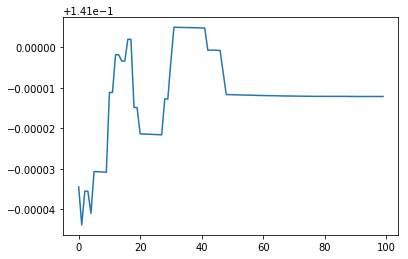

In [232]:
lr, epochs, batch_size = 1e-1 , 100 , 15
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy, extract_z=False)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        print("network loss -> ", loss)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


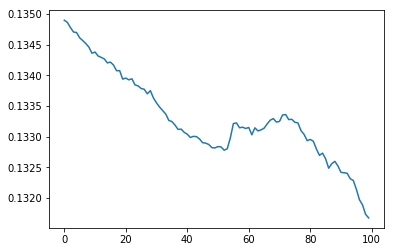

In [191]:
lr, epochs, batch_size = 1e-1 , 100 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy, extract_z=False)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


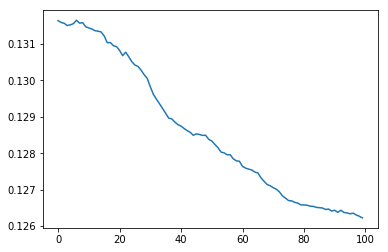

In [196]:
lr, epochs, batch_size = 1e-1 , 100 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy, extract_z=False)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

In [201]:
lr, epochs, batch_size = 1e-1 , 100 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy, extract_z=False)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


KeyboardInterrupt: 

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


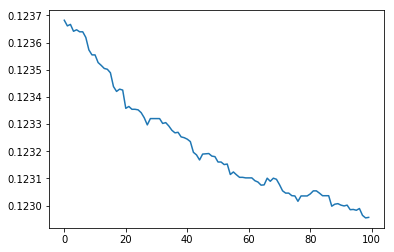

In [130]:
lr, epochs, batch_size = 1e-1 , 100 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy, extract_z=False)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


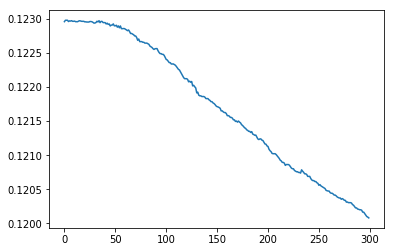

In [131]:
lr, epochs, batch_size = 1e-1 , 300 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy, extract_z=False)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


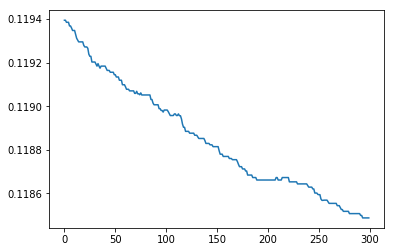

In [142]:
lr, epochs, batch_size = 1e-1 , 300 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy, extract_z=False)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

In [143]:
lr, epochs, batch_size = 1e-1 , 300 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy, extract_z=False)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [165]:
lr, epochs, batch_size = 1e-1 , 500 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy, extract_z=False)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
